In [1]:
import gc
import wandb
import torch
import mambapy
import numpy as np
import pandas as pd
from torch import nn, optim
from mambapy.mamba import Mamba, MambaConfig
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, hamming_loss, roc_auc_score

In [135]:
for cls in classes:
    print(f"Class {cls} has samples")

Class N* has samples
Class RS* has samples
Class ** has samples
Class El* has samples
Class Y*O has samples
Class s*b has samples
Class LXB has samples
Class cC* has samples
Class WR* has samples
Class HB* has samples
Class dS* has samples
Class Or* has samples
Class LP* has samples
Class BS* has samples
Class Ae* has samples
Class WV* has samples
Class HS* has samples
Class Ev* has samples
Class AB* has samples
Class sg* has samples
Class s*r has samples
Class Ce* has samples
Class gD* has samples
Class OH* has samples
Class HXB has samples
Class Pu* has samples
Class RV* has samples
Class Sy* has samples
Class V* has samples
Class TT* has samples
Class SN* has samples
Class Be* has samples
Class SB* has samples
Class Em* has samples
Class Er* has samples
Class PM* has samples
Class HV* has samples
Class pA* has samples
Class C* has samples
Class BY* has samples
Class Ro* has samples
Class XB* has samples
Class Ma* has samples
Class RC* has samples
Class Pe* has samples
Class CV* has 

In [2]:
class BalancedDataset(Dataset):
    def __init__(self, X, y, limit_per_label=201):
        self.X = X
        self.y = y
        self.limit_per_label = limit_per_label
        self.classes = np.unique(y)
        self.indices = self.balance_classes()

    def balance_classes(self):
        indices = []
        for cls in self.classes:
            cls_indices = np.where(self.y == cls)[0]
            # Set limit per label except for the * label
            if cls == "*":
                print("Skipping limit for * label")
            elif len(cls_indices) > self.limit_per_label:
                cls_indices = np.random.choice(cls_indices, self.limit_per_label, replace=False)
            indices.extend(cls_indices)
        np.random.shuffle(indices)
        return indices

    def re_sample(self):
        self.indices = self.balance_classes()

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        index = self.indices[idx]
        return self.X[index], self.y[index]
# Custom Dataset for validation with limit per class
class BalancedValidationDataset(Dataset):
    def __init__(self, X, y, limit_per_label=100):
        self.X = X
        self.y = y
        self.limit_per_label = limit_per_label
        self.classes = np.unique(y)
        self.indices = self.balance_classes()

    def balance_classes(self):
        indices = []
        for cls in self.classes:
            cls_indices = np.where(self.y == cls)[0]
            if len(cls_indices) > self.limit_per_label:
                cls_indices = np.random.choice(cls_indices, self.limit_per_label, replace=False)
            indices.extend(cls_indices)
        np.random.shuffle(indices)
        return indices
    
    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        index = self.indices[idx]
        return self.X[index], self.y[index]
    
def calculate_metrics(y_true, y_pred):
    metrics = {
        "micro_f1": f1_score(y_true, y_pred, average='micro'),
        "macro_f1": f1_score(y_true, y_pred, average='macro'),
        "weighted_f1": f1_score(y_true, y_pred, average='weighted'),
        "micro_precision": precision_score(y_true, y_pred, average='micro'),
        "macro_precision": precision_score(y_true, y_pred, average='macro'),
        "weighted_precision": precision_score(y_true, y_pred, average='weighted'),
        "micro_recall": recall_score(y_true, y_pred, average='micro'),
        "macro_recall": recall_score(y_true, y_pred, average='macro'),
        "weighted_recall": recall_score(y_true, y_pred, average='weighted'),
        "hamming_loss": hamming_loss(y_true, y_pred)
    }
    
    # Check if there are at least two classes present in y_true
    #if len(np.unique(y_true)) > 1:
        #metrics["roc_auc"] = roc_auc_score(y_true, y_pred, average='macro', multi_class='ovr')
    #else:
       # metrics["roc_auc"] = None  # or you can set it to a default value or message
    
    return metrics
    
def calculate_class_weights(y):
    if y.ndim > 1:  # Check if y is 2D (multi-hot encoded)
        class_counts = np.sum(y, axis=0)  # Count how many times each class appears
    else:
        class_counts = np.bincount(y)  # For a 1D array, use bincount 
    print("Class counts:", class_counts)       
    total_samples = y.shape[0] if y.ndim > 1 else len(y)
    class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
    return class_weights

    
def train_model_mamba(
    model, train_loader, val_loader, test_loader, 
    num_epochs=500, lr=1e-4, max_patience=20, device='cuda'
):
    # Move model to device
    model = model.to(device)

    # Define optimizer, scheduler, and loss function
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=int(max_patience / 5), verbose=True
    )
    all_labels = []

    for _, y_batch in train_loader:
        all_labels.extend(y_batch.cpu().numpy())    
        print("Shape of train_loader:", train_loader.dataset)
        print("Shape of val_loader:", len(val_loader))
        print("Shape of test_loader:", len(test_loader))
        print("Shape of all_labels:", len(all_labels))
        
    class_weights = calculate_class_weights(np.array(all_labels))
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
    print("Class weights:", class_weights)
    criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)
    best_val_loss = float('inf')
    patience = max_patience

    for epoch in range(num_epochs):
        # Resample training and validation data
        train_loader.dataset.re_sample()
        val_loader.dataset.balance_classes()

        # Class weights
        all_labels = []
        for _, y_batch in train_loader:
            all_labels.extend(y_batch.cpu().numpy())
        class_weights = calculate_class_weights(np.array(all_labels))
        class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
        criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)

        # Training phase
        model.train()
        train_loss, train_accuracy = 0.0, 0.0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
            # Convert outputs to binary predictions
            predicted = (outputs > 0.5).float()

            # Calculate accuracy for each batch
            correct = (predicted == y_batch).float()
            train_accuracy += correct.mean(dim=1).mean().item()  # Mean across classes and samples

            

        # Validation phase
        model.eval()
        val_loss, val_accuracy = 0.0, 0.0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                outputs = model(X_val)
                loss = criterion(outputs, y_val)

                val_loss += loss.item() * X_val.size(0)
                predicted = (outputs > 0.5).float()
                correct = (predicted == y_val).float()
                val_accuracy += correct.mean(dim=1).mean().item()

        # Test phase
        test_loss, test_accuracy = 0.0, 0.0
        with torch.no_grad():
            for X_test, y_test in test_loader:
                X_test, y_test = X_test.to(device), y_test.to(device)
                outputs = model(X_test)
                loss = criterion(outputs, y_test)

                test_loss += loss.item() * X_test.size(0)
                predicted = (outputs > 0.5).float()
                correct = (predicted == y_test).float()
                test_accuracy += correct.mean(dim=1).mean().item()

        # Test phase and metric collection
        # Inside your test phase
        y_true, y_pred = [], []
        with torch.no_grad():
            for X_test, y_test in test_loader:
                X_test, y_test = X_test.to(device), y_test.to(device)
                outputs = model(X_test)
                predicted = (outputs > 0.5).float()
                y_true.extend(y_test.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

        metrics = calculate_metrics(np.array(y_true), np.array(y_pred))
        wandb.log(metrics)

        # Update scheduler
        scheduler.step(val_loss / len(val_loader.dataset))

        # Log metrics to WandB
        wandb.log({
            "epoch": epoch,
            "train_loss": train_loss / len(train_loader.dataset),
            "val_loss": val_loss / len(val_loader.dataset),
            "train_accuracy": train_accuracy / len(train_loader),
            "val_accuracy": val_accuracy / len(val_loader),
            "learning_rate": optimizer.param_groups[0]['lr'],
            "test_loss": test_loss / len(test_loader.dataset),
            "test_accuracy": test_accuracy / len(test_loader),
            #"confusion_matrix": wandb.plot.confusion_matrix(
            #   probs=None, y_true=y_true, preds=y_pred, class_names=np.unique(y_true)
            #), remove for now as it is not multilabel
            #"classification_report": classification_report(
            #    y_true, y_pred, target_names=[str(i) for i in range(len(np.unique(y_true)))]
            #)
        })

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience = max_patience
            best_model = model.state_dict()
        else:
            patience -= 1
            if patience <= 0:
                print("Early stopping triggered.")
                break

    # Load the best model weights
    model.load_state_dict(best_model)
    return model



In [3]:
import numpy as np
from torch.utils.data import Dataset

class BalancedMultiLabelDataset(Dataset):
    def __init__(self, X, y, limit_per_label=201):
        """
        Multilabel version of the BalancedDataset.
        
        Args:
        - X (array-like): Input features.
        - y (array-like): Multi-hot encoded labels (2D array, each row is a multi-hot vector).
        - limit_per_label (int): Target number of samples per label.
        """
        self.X = X
        self.y = y
        self.limit_per_label = limit_per_label
        self.num_classes = y.shape[1]  # Number of possible classes
        self.indices = self.balance_classes()

    def balance_classes(self):
        indices = []
        class_counts = torch.sum(self.y, axis=0)  # Total occurrences of each class
        for cls in range(self.num_classes):
            cls_indices = np.where(self.y[:, cls] == 1)[0]  # Indices where this label is active
            if len(cls_indices) < self.limit_per_label:  # Upsample minority classes
                if len(cls_indices) == 0:
                    continue  # Skip this class if there are no samples for it

                extra_indices = np.random.choice(cls_indices, self.limit_per_label - len(cls_indices), replace=True)
                cls_indices = np.concatenate([cls_indices, extra_indices])
            elif len(cls_indices) > self.limit_per_label:  # Downsample majority classes
                cls_indices = np.random.choice(cls_indices, self.limit_per_label, replace=False)
            indices.extend(cls_indices)
        indices = np.unique(indices)  # Remove duplicate indices
        np.random.shuffle(indices)
        return indices

    def re_sample(self):
        """Rebalance the dataset if needed, for example, after changes to the dataset."""
        self.indices = self.balance_classes()

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        index = self.indices[idx]
        return self.X[index], self.y[index]



In [4]:
class StarClassifierMAMBA(nn.Module):
    def __init__(self, d_model, num_classes, d_state=64, d_conv=4, input_dim=17, n_layers=6):
        super(StarClassifierMAMBA, self).__init__()
        self.d_model = d_model
        self.num_classes = num_classes

        # MAMBA layer initialization
        config = MambaConfig(
            d_model=d_model,
            d_state=d_state,
            d_conv=d_conv,
            n_layers=n_layers

        )
        self.mamba_layer = Mamba(config)

        # Input projection to match the MAMBA layer dimension
        self.input_projection = nn.Linear(input_dim, d_model)

        # Fully connected classifier head with sigmoid activation for multi-label classification
        self.classifier = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, num_classes)
        )


    def forward(self, x):
        x = self.input_projection(x)  # Ensure the input has the correct dimension
        #x = x.unsqueeze(1)  # Adds a sequence dimension (L=1).
        x = self.mamba_layer(x)
        x = x.mean(dim=1)  # Pooling operation for classification
        x = self.classifier(x)
        return x

In [5]:
# If X exists, delete it
if 'X' in locals():   
    del X, y
gc.collect()

batch_size = 512

# Example usage
if __name__ == "__main__":
    # Load and preprocess your data (example from original script)
    X = pd.read_pickle("Pickles/train_data_transformed.pkl")
    classes = pd.read_pickle("Pickles/List_of_Classes.pkl")

    # remove the * from the classes numpy array
    #classes = np.delete(classes, 53) # remove the * from the classes numpy array, index 53

    # Get labels and set them as y, drop them from X
    y = X[classes]

    # Drop gaia data
    X.drop(["parallax", "ra", "dec", "ra_error", "dec_error", "parallax_error", "pmra", "pmdec", "pmra_error", "pmdec_error", 
            "phot_g_mean_flux", "flagnopllx", "phot_g_mean_flux_error", "phot_bp_mean_flux", "phot_rp_mean_flux", 
            "phot_bp_mean_flux_error", "phot_rp_mean_flux_error", "obsid", "flagnoflux", "otype"], axis=1, inplace=True)
    
    # Drop labels
    X.drop(classes, axis=1, inplace=True)

    # Drop the * from X
    #X.drop(["*"], axis=1, inplace=True)

    
    # Read test data
    X_test = pd.read_pickle("Pickles/test_data_transformed.pkl")

    # Get labels and set them as y, drop them from X
    y_test = X_test[classes]

    # Drop gaia data
    X_test.drop(["parallax", "ra", "dec", "ra_error", "dec_error", "parallax_error", "pmra", "pmdec", "pmra_error", "pmdec_error", 
                "phot_g_mean_flux", "flagnopllx", "phot_g_mean_flux_error", "phot_bp_mean_flux", "phot_rp_mean_flux", 
                "phot_bp_mean_flux_error", "phot_rp_mean_flux_error", "obsid", "flagnoflux", "otype"], axis=1, inplace=True)
    
    # Drop labels
    X_test.drop(classes, axis=1, inplace=True)

    # Drop the * from X
    #X_test.drop(["*"], axis=1, inplace=True)
    
    # Split validation data
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Clear memory
    del X, y
    gc.collect()

    # Convert to torch tensors and create datasets
    X_train = torch.tensor(X_train.values, dtype=torch.float32).unsqueeze(1)  # Convert DataFrame to numpy array
    X_val = torch.tensor(X_val.values, dtype=torch.float32).unsqueeze(1)      # Convert DataFrame to numpy array    
    X_test = torch.tensor(X_test.values, dtype=torch.float32).unsqueeze(1)    # Convert DataFrame to numpy array
    y_train = torch.tensor(y_train.values, dtype=torch.float32)  # Convert DataFrame to numpy array and float32
    y_val = torch.tensor(y_val.values, dtype=torch.float32)      # Convert DataFrame to numpy array and float32
    y_test = torch.tensor(y_test.values, dtype=torch.float32)    # Convert DataFrame to numpy array and float32

    train_dataset = BalancedMultiLabelDataset(X_train, y_train)
    val_dataset = BalancedMultiLabelDataset(X_val, y_val)
    test_dataset = BalancedMultiLabelDataset(X_test, y_test)


    #train_dataset = BalancedDataset(X_train, y_train)
    #val_dataset = BalancedValidationDataset(X_val, y_val)
    #test_dataset = BalancedValidationDataset(X_test, y_test, limit_per_label=10000)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Print the shapes of the datasets
    print(f"Train dataset shape: {X_train.shape}")
    print(f"Validation dataset shape: {X_val.shape}")
    print(f"Test dataset shape: {X_test.shape}")
    print(f"Train labels shape: {y_train.shape}")
    print(f"Validation labels shape: {y_val.shape}")
    print(f"Test labels shape: {y_test.shape}")

Train dataset shape: torch.Size([92584, 1, 3647])
Validation dataset shape: torch.Size([23147, 1, 3647])
Test dataset shape: torch.Size([20424, 1, 3647])
Train labels shape: torch.Size([92584, 66])
Validation labels shape: torch.Size([23147, 66])
Test labels shape: torch.Size([20424, 66])


In [6]:
# Same, but now with class weights
# Define the model with your parameters
d_model = 2048 # Embedding dimension
num_classes = 66  # Star classification categories
input_dim = 3647 # Number of spectra points

# Define the training parameters
num_epochs = 3000
lr = 2e-5
patience = 100   
depth = 6

# Define the config dictionary object
config = {"num_classes": num_classes, "batch_size": batch_size, "lr": lr, "patience": patience, "num_epochs": num_epochs, "d_model": d_model, "depth": depth}

# Initialize WandB project
wandb.init(project="ALLSTARS***lamost-mamba-test", entity="joaoc-university-of-southampton", config=config)
# Initialize and train the model
# Train the model using your `train_model_vit` or an adjusted training loop
model_mamba = StarClassifierMAMBA(d_model=d_model, num_classes=num_classes, input_dim=input_dim, n_layers=depth)
print(model_mamba)
# print number of parameters per layer
for name, param in model_mamba.named_parameters():
    print(name, param.numel())
print("Total number of parameters:", sum(p.numel() for p in model_mamba.parameters() if p.requires_grad))

# Move the model to device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_mamba = model_mamba.to(device)

# Train the model using your `train_model_vit` or an adjusted training loop
trained_model = train_model_mamba(
    model=model_mamba,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=num_epochs,
    lr=lr,
    max_patience=patience,
    device=device
)
# Save the model and finish WandB session
wandb.finish()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: joaoc (joaoc-university-of-southampton). Use `wandb login --relogin` to force relogin


StarClassifierMAMBA(
  (mamba_layer): Mamba(
    (layers): ModuleList(
      (0-5): 6 x ResidualBlock(
        (mixer): MambaBlock(
          (in_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (conv1d): Conv1d(4096, 4096, kernel_size=(4,), stride=(1,), padding=(3,), groups=4096)
          (x_proj): Linear(in_features=4096, out_features=256, bias=False)
          (dt_proj): Linear(in_features=128, out_features=4096, bias=True)
          (out_proj): Linear(in_features=4096, out_features=2048, bias=False)
        )
        (norm): RMSNorm()
      )
    )
  )
  (input_projection): Linear(in_features=3647, out_features=2048, bias=True)
  (classifier): Sequential(
    (0): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=2048, out_features=66, bias=True)
  )
)
mamba_layer.layers.0.mixer.A_log 262144
mamba_layer.layers.0.mixer.D 4096
mamba_layer.layers.0.mixer.in_proj.weight 16777216
mamba_layer.layers.0.mixer.conv1d.weight 16384
mam

C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Shape of train_loader: <__main__.BalancedMultiLabelDataset object at 0x000001F67FE5E190>
Shape of val_loader: 10
Shape of test_loader: 10
Shape of all_labels: 512
Shape of train_loader: <__main__.BalancedMultiLabelDataset object at 0x000001F67FE5E190>
Shape of val_loader: 10
Shape of test_loader: 10
Shape of all_labels: 1024
Shape of train_loader: <__main__.BalancedMultiLabelDataset object at 0x000001F67FE5E190>
Shape of val_loader: 10
Shape of test_loader: 10
Shape of all_labels: 1536
Shape of train_loader: <__main__.BalancedMultiLabelDataset object at 0x000001F67FE5E190>
Shape of val_loader: 10
Shape of test_loader: 10
Shape of all_labels: 2048
Shape of train_loader: <__main__.BalancedMultiLabelDataset object at 0x000001F67FE5E190>
Shape of val_loader: 10
Shape of test_loader: 10
Shape of all_labels: 2560
Shape of train_loader: <__main__.BalancedMultiLabelDataset object at 0x000001F67FE5E190>
Shape of val_loader: 10
Shape of test_loader: 10
Shape of all_labels: 3072
Shape of train_lo

C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)


Class weights: tensor([9.4758e+01, 4.5557e-01, 7.9561e-02, 4.3072e+00, 2.8202e-01, 4.7379e+00,
        9.4758e+01, 1.2980e+00, 0.0000e+00, 1.9619e-01, 2.8714e-01, 7.8312e-01,
        4.2302e-01, 4.4909e-01, 3.1586e+01, 3.9482e+00, 4.4909e-01, 4.5710e-02,
        3.4710e-01, 2.9612e+00, 1.5793e+01, 1.1018e+00, 4.4073e-01, 3.1586e+01,
        3.1586e+01, 4.3268e-01, 1.5793e+01, 2.3689e+01, 1.1627e-01, 1.1018e+00,
        9.4758e+01, 2.3689e+00, 3.1798e-01, 4.3467e-01, 4.3667e-01, 4.1379e-01,
        7.5806e-01, 1.5793e+01, 4.7143e-01, 4.6910e-01, 2.5135e-01, 1.0529e+01,
        2.5610e+00, 9.4758e+01, 4.2302e-01, 9.1998e-01, 2.3689e+01, 0.0000e+00,
        3.3963e-01, 0.0000e+00, 3.7752e-01, 0.0000e+00, 1.1845e+01, 1.5152e-02,
        0.0000e+00, 3.1905e-01, 4.5999e-01, 4.2114e-01, 3.3842e+00, 9.4758e+01,
        1.1860e-01, 4.7379e+01, 6.3172e+00, 1.5793e+01, 2.8628e-01, 9.4758e+01],
       device='cuda:0')
Class counts: [1.000e+00 2.110e+02 1.192e+03 2.200e+01 3.390e+02 2.000e+01 1.000

C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Class counts: [1.000e+00 2.060e+02 1.199e+03 2.200e+01 3.310e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.790e+02 3.160e+02 1.210e+02 2.200e+02 2.090e+02
 3.000e+00 2.400e+01 2.130e+02 2.072e+03 2.700e+02 3.200e+01 6.000e+00
 8.600e+01 2.200e+02 3.000e+00 3.000e+00 2.170e+02 6.000e+00 4.000e+00
 8.120e+02 8.600e+01 1.000e+00 4.000e+01 3.160e+02 2.200e+02 2.120e+02
 2.240e+02 1.250e+02 6.000e+00 2.030e+02 2.050e+02 3.810e+02 9.000e+00
 3.700e+01 1.000e+00 2.230e+02 1.030e+02 4.000e+00 0.000e+00 3.040e+02
 0.000e+00 2.450e+02 0.000e+00 8.000e+00 6.235e+03 0.000e+00 3.030e+02
 2.040e+02 2.250e+02 2.800e+01 1.000e+00 7.870e+02 2.000e+00 1.500e+01
 6.000e+00 3.280e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{me

Class counts: [1.000e+00 2.050e+02 1.195e+03 2.200e+01 3.300e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.840e+02 3.260e+02 1.210e+02 2.220e+02 2.070e+02
 3.000e+00 2.400e+01 2.120e+02 2.085e+03 2.720e+02 3.200e+01 6.000e+00
 8.600e+01 2.220e+02 3.000e+00 3.000e+00 2.200e+02 6.000e+00 4.000e+00
 8.230e+02 8.600e+01 1.000e+00 4.000e+01 2.960e+02 2.140e+02 2.230e+02
 2.180e+02 1.250e+02 6.000e+00 2.020e+02 2.030e+02 3.780e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 2.940e+02
 0.000e+00 2.480e+02 0.000e+00 8.000e+00 6.258e+03 0.000e+00 3.150e+02
 2.040e+02 2.190e+02 2.800e+01 1.000e+00 7.980e+02 2.000e+00 1.500e+01
 6.000e+00 3.460e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Class counts: [1.000e+00 2.030e+02 1.198e+03 2.200e+01 3.350e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.780e+02 3.260e+02 1.210e+02 2.320e+02 2.140e+02
 3.000e+00 2.400e+01 2.060e+02 2.069e+03 2.690e+02 3.200e+01 6.000e+00
 8.600e+01 2.110e+02 3.000e+00 3.000e+00 2.170e+02 6.000e+00 4.000e+00
 8.090e+02 8.600e+01 1.000e+00 4.000e+01 3.000e+02 2.130e+02 2.260e+02
 2.270e+02 1.250e+02 6.000e+00 2.030e+02 2.020e+02 3.640e+02 9.000e+00
 3.700e+01 1.000e+00 2.300e+02 1.030e+02 4.000e+00 0.000e+00 3.070e+02
 0.000e+00 2.490e+02 0.000e+00 8.000e+00 6.247e+03 0.000e+00 2.950e+02
 2.090e+02 2.270e+02 2.800e+01 1.000e+00 7.940e+02 2.000e+00 1.500e+01
 6.000e+00 3.510e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.110e+02 1.189e+03 2.200e+01 3.420e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.720e+02 3.120e+02 1.210e+02 2.270e+02 2.110e+02
 3.000e+00 2.400e+01 2.040e+02 2.070e+03 2.700e+02 3.200e+01 6.000e+00
 8.600e+01 2.210e+02 3.000e+00 3.000e+00 2.200e+02 6.000e+00 4.000e+00
 8.120e+02 8.600e+01 1.000e+00 4.000e+01 3.070e+02 2.190e+02 2.320e+02
 2.290e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.580e+02 9.000e+00
 3.700e+01 1.000e+00 2.330e+02 1.030e+02 4.000e+00 0.000e+00 2.740e+02
 0.000e+00 2.490e+02 0.000e+00 8.000e+00 6.248e+03 0.000e+00 3.110e+02
 2.040e+02 2.260e+02 2.800e+01 1.000e+00 7.870e+02 2.000e+00 1.500e+01
 6.000e+00 3.260e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.183e+03 2.200e+01 3.240e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.760e+02 3.270e+02 1.210e+02 2.190e+02 2.100e+02
 3.000e+00 2.400e+01 2.040e+02 2.077e+03 2.760e+02 3.200e+01 6.000e+00
 8.600e+01 2.230e+02 3.000e+00 3.000e+00 2.150e+02 6.000e+00 4.000e+00
 8.200e+02 8.600e+01 1.000e+00 4.000e+01 2.950e+02 2.190e+02 2.300e+02
 2.310e+02 1.250e+02 6.000e+00 2.010e+02 2.090e+02 3.730e+02 9.000e+00
 3.700e+01 1.000e+00 2.270e+02 1.030e+02 4.000e+00 0.000e+00 2.740e+02
 0.000e+00 2.510e+02 0.000e+00 8.000e+00 6.251e+03 0.000e+00 3.200e+02
 2.060e+02 2.220e+02 2.800e+01 1.000e+00 8.010e+02 2.000e+00 1.500e+01
 6.000e+00 3.300e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.040e+02 1.189e+03 2.200e+01 3.400e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.810e+02 3.200e+02 1.210e+02 2.270e+02 2.100e+02
 3.000e+00 2.400e+01 2.060e+02 2.077e+03 2.670e+02 3.200e+01 6.000e+00
 8.600e+01 2.220e+02 3.000e+00 3.000e+00 2.150e+02 6.000e+00 4.000e+00
 8.190e+02 8.600e+01 1.000e+00 4.000e+01 3.110e+02 2.190e+02 2.190e+02
 2.270e+02 1.250e+02 6.000e+00 2.020e+02 2.020e+02 3.830e+02 9.000e+00
 3.700e+01 1.000e+00 2.220e+02 1.030e+02 4.000e+00 0.000e+00 2.900e+02
 0.000e+00 2.470e+02 0.000e+00 8.000e+00 6.255e+03 0.000e+00 3.090e+02
 2.020e+02 2.260e+02 2.800e+01 1.000e+00 7.970e+02 2.000e+00 1.500e+01
 6.000e+00 3.270e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.202e+03 2.200e+01 3.260e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.710e+02 3.200e+02 1.210e+02 2.350e+02 2.090e+02
 3.000e+00 2.400e+01 2.060e+02 2.066e+03 2.650e+02 3.200e+01 6.000e+00
 8.600e+01 2.170e+02 3.000e+00 3.000e+00 2.140e+02 6.000e+00 4.000e+00
 8.170e+02 8.600e+01 1.000e+00 4.000e+01 3.190e+02 2.230e+02 2.280e+02
 2.240e+02 1.250e+02 6.000e+00 2.010e+02 2.020e+02 3.730e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 2.930e+02
 0.000e+00 2.460e+02 0.000e+00 8.000e+00 6.238e+03 0.000e+00 2.980e+02
 2.020e+02 2.310e+02 2.800e+01 1.000e+00 7.870e+02 2.000e+00 1.500e+01
 6.000e+00 3.290e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.110e+02 1.197e+03 2.200e+01 3.300e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.910e+02 3.200e+02 1.210e+02 2.250e+02 2.130e+02
 3.000e+00 2.400e+01 2.060e+02 2.061e+03 2.690e+02 3.200e+01 6.000e+00
 8.600e+01 2.150e+02 3.000e+00 3.000e+00 2.160e+02 6.000e+00 4.000e+00
 8.110e+02 8.600e+01 1.000e+00 4.000e+01 3.010e+02 2.140e+02 2.280e+02
 2.240e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.650e+02 9.000e+00
 3.700e+01 1.000e+00 2.330e+02 1.030e+02 4.000e+00 0.000e+00 3.070e+02
 0.000e+00 2.480e+02 0.000e+00 8.000e+00 6.234e+03 0.000e+00 2.910e+02
 2.090e+02 2.190e+02 2.800e+01 1.000e+00 7.920e+02 2.000e+00 1.500e+01
 6.000e+00 3.390e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.185e+03 2.200e+01 3.270e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.790e+02 3.230e+02 1.210e+02 2.240e+02 2.130e+02
 3.000e+00 2.400e+01 2.140e+02 2.059e+03 2.660e+02 3.200e+01 6.000e+00
 8.600e+01 2.250e+02 3.000e+00 3.000e+00 2.160e+02 6.000e+00 4.000e+00
 8.150e+02 8.600e+01 1.000e+00 4.000e+01 3.040e+02 2.160e+02 2.220e+02
 2.250e+02 1.250e+02 6.000e+00 2.020e+02 2.020e+02 3.750e+02 9.000e+00
 3.700e+01 1.000e+00 2.310e+02 1.030e+02 4.000e+00 0.000e+00 2.950e+02
 0.000e+00 2.410e+02 0.000e+00 8.000e+00 6.233e+03 0.000e+00 2.930e+02
 2.070e+02 2.220e+02 2.800e+01 1.000e+00 8.050e+02 2.000e+00 1.500e+01
 6.000e+00 3.280e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.080e+02 1.197e+03 2.200e+01 3.320e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.710e+02 3.250e+02 1.210e+02 2.250e+02 2.110e+02
 3.000e+00 2.400e+01 2.140e+02 2.074e+03 2.670e+02 3.200e+01 6.000e+00
 8.600e+01 2.190e+02 3.000e+00 3.000e+00 2.180e+02 6.000e+00 4.000e+00
 8.120e+02 8.600e+01 1.000e+00 4.000e+01 3.070e+02 2.270e+02 2.250e+02
 2.200e+02 1.250e+02 6.000e+00 2.010e+02 2.060e+02 3.670e+02 9.000e+00
 3.700e+01 1.000e+00 2.230e+02 1.030e+02 4.000e+00 0.000e+00 2.720e+02
 0.000e+00 2.510e+02 0.000e+00 8.000e+00 6.249e+03 0.000e+00 3.060e+02
 2.030e+02 2.310e+02 2.800e+01 1.000e+00 7.980e+02 2.000e+00 1.500e+01
 6.000e+00 3.350e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.120e+02 1.193e+03 2.200e+01 3.210e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.650e+02 3.170e+02 1.210e+02 2.220e+02 2.080e+02
 3.000e+00 2.400e+01 2.090e+02 2.068e+03 2.690e+02 3.200e+01 6.000e+00
 8.600e+01 2.180e+02 3.000e+00 3.000e+00 2.260e+02 6.000e+00 4.000e+00
 8.100e+02 8.600e+01 1.000e+00 4.000e+01 3.040e+02 2.210e+02 2.260e+02
 2.300e+02 1.250e+02 6.000e+00 2.020e+02 2.060e+02 3.560e+02 9.000e+00
 3.700e+01 1.000e+00 2.240e+02 1.030e+02 4.000e+00 0.000e+00 2.880e+02
 0.000e+00 2.490e+02 0.000e+00 8.000e+00 6.224e+03 0.000e+00 3.240e+02
 2.070e+02 2.180e+02 2.800e+01 1.000e+00 7.870e+02 2.000e+00 1.500e+01
 6.000e+00 3.250e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.080e+02 1.189e+03 2.200e+01 3.300e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.800e+02 3.320e+02 1.210e+02 2.250e+02 2.090e+02
 3.000e+00 2.400e+01 2.030e+02 2.085e+03 2.710e+02 3.200e+01 6.000e+00
 8.600e+01 2.170e+02 3.000e+00 3.000e+00 2.150e+02 6.000e+00 4.000e+00
 8.240e+02 8.600e+01 1.000e+00 4.000e+01 2.910e+02 2.170e+02 2.330e+02
 2.210e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.740e+02 9.000e+00
 3.700e+01 1.000e+00 2.240e+02 1.030e+02 4.000e+00 0.000e+00 2.830e+02
 0.000e+00 2.510e+02 0.000e+00 8.000e+00 6.260e+03 0.000e+00 3.150e+02
 2.060e+02 2.310e+02 2.800e+01 1.000e+00 8.010e+02 2.000e+00 1.500e+01
 6.000e+00 3.400e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.190e+03 2.200e+01 3.300e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.670e+02 3.190e+02 1.210e+02 2.270e+02 2.080e+02
 3.000e+00 2.400e+01 2.050e+02 2.066e+03 2.660e+02 3.200e+01 6.000e+00
 8.600e+01 2.220e+02 3.000e+00 3.000e+00 2.220e+02 6.000e+00 4.000e+00
 8.200e+02 8.600e+01 1.000e+00 4.000e+01 3.040e+02 2.220e+02 2.190e+02
 2.260e+02 1.250e+02 6.000e+00 2.020e+02 2.020e+02 3.770e+02 9.000e+00
 3.700e+01 1.000e+00 2.240e+02 1.030e+02 4.000e+00 0.000e+00 2.700e+02
 0.000e+00 2.460e+02 0.000e+00 8.000e+00 6.233e+03 0.000e+00 3.100e+02
 2.030e+02 2.300e+02 2.800e+01 1.000e+00 7.890e+02 2.000e+00 1.500e+01
 6.000e+00 3.320e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.050e+02 1.197e+03 2.200e+01 3.310e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.840e+02 3.300e+02 1.210e+02 2.200e+02 2.090e+02
 3.000e+00 2.400e+01 2.070e+02 2.084e+03 2.740e+02 3.200e+01 6.000e+00
 8.600e+01 2.180e+02 3.000e+00 3.000e+00 2.180e+02 6.000e+00 4.000e+00
 8.070e+02 8.600e+01 1.000e+00 4.000e+01 3.090e+02 2.120e+02 2.280e+02
 2.220e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.590e+02 9.000e+00
 3.700e+01 1.000e+00 2.300e+02 1.030e+02 4.000e+00 0.000e+00 2.960e+02
 0.000e+00 2.510e+02 0.000e+00 8.000e+00 6.250e+03 0.000e+00 3.100e+02
 2.050e+02 2.290e+02 2.800e+01 1.000e+00 7.990e+02 2.000e+00 1.500e+01
 6.000e+00 3.340e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.040e+02 1.195e+03 2.200e+01 3.350e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.700e+02 3.110e+02 1.210e+02 2.240e+02 2.060e+02
 3.000e+00 2.400e+01 2.060e+02 2.063e+03 2.670e+02 3.200e+01 6.000e+00
 8.600e+01 2.180e+02 3.000e+00 3.000e+00 2.200e+02 6.000e+00 4.000e+00
 8.180e+02 8.600e+01 1.000e+00 4.000e+01 3.060e+02 2.210e+02 2.160e+02
 2.200e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.800e+02 9.000e+00
 3.700e+01 1.000e+00 2.250e+02 1.030e+02 4.000e+00 0.000e+00 2.870e+02
 0.000e+00 2.440e+02 0.000e+00 8.000e+00 6.220e+03 0.000e+00 3.050e+02
 2.030e+02 2.310e+02 2.800e+01 1.000e+00 7.770e+02 2.000e+00 1.500e+01
 6.000e+00 3.360e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.120e+02 1.187e+03 2.200e+01 3.380e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.630e+02 3.290e+02 1.210e+02 2.230e+02 2.090e+02
 3.000e+00 2.400e+01 2.040e+02 2.065e+03 2.730e+02 3.200e+01 6.000e+00
 8.600e+01 2.160e+02 3.000e+00 3.000e+00 2.180e+02 6.000e+00 4.000e+00
 8.220e+02 8.600e+01 1.000e+00 4.000e+01 2.990e+02 2.210e+02 2.250e+02
 2.170e+02 1.250e+02 6.000e+00 2.030e+02 2.020e+02 3.770e+02 9.000e+00
 3.700e+01 1.000e+00 2.320e+02 1.030e+02 4.000e+00 0.000e+00 2.820e+02
 0.000e+00 2.490e+02 0.000e+00 8.000e+00 6.250e+03 0.000e+00 3.100e+02
 2.070e+02 2.300e+02 2.800e+01 1.000e+00 7.980e+02 2.000e+00 1.500e+01
 6.000e+00 3.250e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.187e+03 2.200e+01 3.340e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.590e+02 3.140e+02 1.210e+02 2.180e+02 2.120e+02
 3.000e+00 2.400e+01 2.050e+02 2.067e+03 2.740e+02 3.200e+01 6.000e+00
 8.600e+01 2.150e+02 3.000e+00 3.000e+00 2.120e+02 6.000e+00 4.000e+00
 8.110e+02 8.600e+01 1.000e+00 4.000e+01 3.070e+02 2.260e+02 2.210e+02
 2.180e+02 1.250e+02 6.000e+00 2.010e+02 2.020e+02 3.760e+02 9.000e+00
 3.700e+01 1.000e+00 2.350e+02 1.030e+02 4.000e+00 0.000e+00 2.730e+02
 0.000e+00 2.540e+02 0.000e+00 8.000e+00 6.233e+03 0.000e+00 3.130e+02
 2.060e+02 2.380e+02 2.800e+01 1.000e+00 7.860e+02 2.000e+00 1.500e+01
 6.000e+00 3.290e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.100e+02 1.200e+03 2.200e+01 3.350e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.810e+02 3.170e+02 1.210e+02 2.170e+02 2.150e+02
 3.000e+00 2.400e+01 2.100e+02 2.074e+03 2.760e+02 3.200e+01 6.000e+00
 8.600e+01 2.170e+02 3.000e+00 3.000e+00 2.220e+02 6.000e+00 4.000e+00
 8.140e+02 8.600e+01 1.000e+00 4.000e+01 3.140e+02 2.170e+02 2.330e+02
 2.230e+02 1.250e+02 6.000e+00 2.010e+02 2.020e+02 3.570e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 2.830e+02
 0.000e+00 2.510e+02 0.000e+00 8.000e+00 6.252e+03 0.000e+00 3.080e+02
 2.060e+02 2.220e+02 2.800e+01 1.000e+00 7.920e+02 2.000e+00 1.500e+01
 6.000e+00 3.300e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.110e+02 1.197e+03 2.200e+01 3.360e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.780e+02 3.230e+02 1.210e+02 2.260e+02 2.080e+02
 3.000e+00 2.400e+01 2.080e+02 2.067e+03 2.670e+02 3.200e+01 6.000e+00
 8.600e+01 2.160e+02 3.000e+00 3.000e+00 2.130e+02 6.000e+00 4.000e+00
 8.250e+02 8.600e+01 1.000e+00 4.000e+01 2.920e+02 2.180e+02 2.300e+02
 2.190e+02 1.250e+02 6.000e+00 2.040e+02 2.070e+02 3.800e+02 9.000e+00
 3.700e+01 1.000e+00 2.310e+02 1.030e+02 4.000e+00 0.000e+00 2.790e+02
 0.000e+00 2.440e+02 0.000e+00 8.000e+00 6.250e+03 0.000e+00 3.020e+02
 2.050e+02 2.230e+02 2.800e+01 1.000e+00 7.890e+02 2.000e+00 1.500e+01
 6.000e+00 3.450e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.050e+02 1.193e+03 2.200e+01 3.280e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.860e+02 3.330e+02 1.210e+02 2.240e+02 2.090e+02
 3.000e+00 2.400e+01 2.060e+02 2.064e+03 2.670e+02 3.200e+01 6.000e+00
 8.600e+01 2.150e+02 3.000e+00 3.000e+00 2.240e+02 6.000e+00 4.000e+00
 8.130e+02 8.600e+01 1.000e+00 4.000e+01 2.940e+02 2.170e+02 2.290e+02
 2.230e+02 1.250e+02 6.000e+00 2.020e+02 2.040e+02 3.580e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 2.980e+02
 0.000e+00 2.480e+02 0.000e+00 8.000e+00 6.233e+03 0.000e+00 3.070e+02
 2.050e+02 2.130e+02 2.800e+01 1.000e+00 7.990e+02 2.000e+00 1.500e+01
 6.000e+00 3.440e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.196e+03 2.200e+01 3.360e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.710e+02 3.240e+02 1.210e+02 2.270e+02 2.090e+02
 3.000e+00 2.400e+01 2.080e+02 2.067e+03 2.720e+02 3.200e+01 6.000e+00
 8.600e+01 2.190e+02 3.000e+00 3.000e+00 2.190e+02 6.000e+00 4.000e+00
 8.140e+02 8.600e+01 1.000e+00 4.000e+01 2.990e+02 2.190e+02 2.220e+02
 2.290e+02 1.250e+02 6.000e+00 2.010e+02 2.070e+02 3.710e+02 9.000e+00
 3.700e+01 1.000e+00 2.230e+02 1.030e+02 4.000e+00 0.000e+00 2.800e+02
 0.000e+00 2.490e+02 0.000e+00 8.000e+00 6.247e+03 0.000e+00 3.050e+02
 2.070e+02 2.240e+02 2.800e+01 1.000e+00 7.930e+02 2.000e+00 1.500e+01
 6.000e+00 3.420e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.030e+02 1.188e+03 2.200e+01 3.280e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.710e+02 3.140e+02 1.210e+02 2.270e+02 2.120e+02
 3.000e+00 2.400e+01 2.080e+02 2.061e+03 2.650e+02 3.200e+01 6.000e+00
 8.600e+01 2.210e+02 3.000e+00 3.000e+00 2.300e+02 6.000e+00 4.000e+00
 8.130e+02 8.600e+01 1.000e+00 4.000e+01 3.050e+02 2.180e+02 2.260e+02
 2.240e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.550e+02 9.000e+00
 3.700e+01 1.000e+00 2.350e+02 1.030e+02 4.000e+00 0.000e+00 2.880e+02
 0.000e+00 2.450e+02 0.000e+00 8.000e+00 6.226e+03 0.000e+00 3.110e+02
 2.080e+02 2.190e+02 2.800e+01 1.000e+00 7.880e+02 2.000e+00 1.500e+01
 6.000e+00 3.320e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.193e+03 2.200e+01 3.340e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.810e+02 3.230e+02 1.210e+02 2.290e+02 2.110e+02
 3.000e+00 2.400e+01 2.060e+02 2.070e+03 2.680e+02 3.200e+01 6.000e+00
 8.600e+01 2.240e+02 3.000e+00 3.000e+00 2.180e+02 6.000e+00 4.000e+00
 8.230e+02 8.600e+01 1.000e+00 4.000e+01 3.040e+02 2.150e+02 2.300e+02
 2.200e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.730e+02 9.000e+00
 3.700e+01 1.000e+00 2.310e+02 1.030e+02 4.000e+00 0.000e+00 2.890e+02
 0.000e+00 2.460e+02 0.000e+00 8.000e+00 6.255e+03 0.000e+00 3.090e+02
 2.060e+02 2.170e+02 2.800e+01 1.000e+00 8.000e+02 2.000e+00 1.500e+01
 6.000e+00 3.360e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.100e+02 1.194e+03 2.200e+01 3.240e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.930e+02 3.210e+02 1.210e+02 2.270e+02 2.180e+02
 3.000e+00 2.400e+01 2.040e+02 2.056e+03 2.700e+02 3.200e+01 6.000e+00
 8.600e+01 2.140e+02 3.000e+00 3.000e+00 2.160e+02 6.000e+00 4.000e+00
 8.150e+02 8.600e+01 1.000e+00 4.000e+01 3.020e+02 2.180e+02 2.270e+02
 2.210e+02 1.250e+02 6.000e+00 2.010e+02 2.050e+02 3.700e+02 9.000e+00
 3.700e+01 1.000e+00 2.290e+02 1.030e+02 4.000e+00 0.000e+00 2.980e+02
 0.000e+00 2.490e+02 0.000e+00 8.000e+00 6.220e+03 0.000e+00 2.750e+02
 2.060e+02 2.270e+02 2.800e+01 1.000e+00 7.940e+02 2.000e+00 1.500e+01
 6.000e+00 3.340e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.040e+02 1.205e+03 2.200e+01 3.260e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.870e+02 3.270e+02 1.210e+02 2.240e+02 2.070e+02
 3.000e+00 2.400e+01 2.060e+02 2.071e+03 2.730e+02 3.200e+01 6.000e+00
 8.600e+01 2.210e+02 3.000e+00 3.000e+00 2.180e+02 6.000e+00 4.000e+00
 8.130e+02 8.600e+01 1.000e+00 4.000e+01 3.120e+02 2.110e+02 2.260e+02
 2.200e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.670e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 2.930e+02
 0.000e+00 2.450e+02 0.000e+00 8.000e+00 6.242e+03 0.000e+00 2.900e+02
 2.060e+02 2.310e+02 2.800e+01 1.000e+00 7.990e+02 2.000e+00 1.500e+01
 6.000e+00 3.390e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.050e+02 1.195e+03 2.200e+01 3.440e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.760e+02 3.060e+02 1.210e+02 2.240e+02 2.150e+02
 3.000e+00 2.400e+01 2.100e+02 2.071e+03 2.730e+02 3.200e+01 6.000e+00
 8.600e+01 2.200e+02 3.000e+00 3.000e+00 2.230e+02 6.000e+00 4.000e+00
 8.140e+02 8.600e+01 1.000e+00 4.000e+01 3.030e+02 2.180e+02 2.220e+02
 2.210e+02 1.250e+02 6.000e+00 2.010e+02 2.060e+02 3.670e+02 9.000e+00
 3.700e+01 1.000e+00 2.290e+02 1.030e+02 4.000e+00 0.000e+00 2.860e+02
 0.000e+00 2.510e+02 0.000e+00 8.000e+00 6.245e+03 0.000e+00 3.010e+02
 2.040e+02 2.270e+02 2.800e+01 1.000e+00 7.860e+02 2.000e+00 1.500e+01
 6.000e+00 3.390e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.185e+03 2.200e+01 3.270e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.720e+02 3.150e+02 1.210e+02 2.180e+02 2.100e+02
 3.000e+00 2.400e+01 2.040e+02 2.073e+03 2.660e+02 3.200e+01 6.000e+00
 8.600e+01 2.200e+02 3.000e+00 3.000e+00 2.210e+02 6.000e+00 4.000e+00
 8.110e+02 8.600e+01 1.000e+00 4.000e+01 3.010e+02 2.220e+02 2.180e+02
 2.230e+02 1.250e+02 6.000e+00 2.030e+02 2.020e+02 3.700e+02 9.000e+00
 3.700e+01 1.000e+00 2.340e+02 1.030e+02 4.000e+00 0.000e+00 2.900e+02
 0.000e+00 2.450e+02 0.000e+00 8.000e+00 6.233e+03 0.000e+00 3.130e+02
 2.070e+02 2.380e+02 2.800e+01 1.000e+00 7.880e+02 2.000e+00 1.500e+01
 6.000e+00 3.260e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.050e+02 1.197e+03 2.200e+01 3.280e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.620e+02 3.100e+02 1.210e+02 2.220e+02 2.080e+02
 3.000e+00 2.400e+01 2.050e+02 2.054e+03 2.680e+02 3.200e+01 6.000e+00
 8.600e+01 2.160e+02 3.000e+00 3.000e+00 2.140e+02 6.000e+00 4.000e+00
 7.990e+02 8.600e+01 1.000e+00 4.000e+01 3.020e+02 2.130e+02 2.180e+02
 2.300e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.650e+02 9.000e+00
 3.700e+01 1.000e+00 2.340e+02 1.030e+02 4.000e+00 0.000e+00 2.790e+02
 0.000e+00 2.450e+02 0.000e+00 8.000e+00 6.205e+03 0.000e+00 3.180e+02
 2.060e+02 2.190e+02 2.800e+01 1.000e+00 7.810e+02 2.000e+00 1.500e+01
 6.000e+00 3.410e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.186e+03 2.200e+01 3.260e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.800e+02 3.130e+02 1.210e+02 2.290e+02 2.150e+02
 3.000e+00 2.400e+01 2.070e+02 2.059e+03 2.640e+02 3.200e+01 6.000e+00
 8.600e+01 2.240e+02 3.000e+00 3.000e+00 2.230e+02 6.000e+00 4.000e+00
 8.110e+02 8.600e+01 1.000e+00 4.000e+01 3.090e+02 2.200e+02 2.210e+02
 2.250e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.650e+02 9.000e+00
 3.700e+01 1.000e+00 2.310e+02 1.030e+02 4.000e+00 0.000e+00 2.920e+02
 0.000e+00 2.450e+02 0.000e+00 8.000e+00 6.222e+03 0.000e+00 2.990e+02
 2.080e+02 2.200e+02 2.800e+01 1.000e+00 7.930e+02 2.000e+00 1.500e+01
 6.000e+00 3.250e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.050e+02 1.186e+03 2.200e+01 3.310e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.790e+02 3.130e+02 1.210e+02 2.200e+02 2.060e+02
 3.000e+00 2.400e+01 2.060e+02 2.069e+03 2.740e+02 3.200e+01 6.000e+00
 8.600e+01 2.200e+02 3.000e+00 3.000e+00 2.170e+02 6.000e+00 4.000e+00
 8.130e+02 8.600e+01 1.000e+00 4.000e+01 2.880e+02 2.200e+02 2.270e+02
 2.290e+02 1.250e+02 6.000e+00 2.030e+02 2.030e+02 3.670e+02 9.000e+00
 3.700e+01 1.000e+00 2.320e+02 1.030e+02 4.000e+00 0.000e+00 2.920e+02
 0.000e+00 2.520e+02 0.000e+00 8.000e+00 6.230e+03 0.000e+00 3.100e+02
 2.050e+02 2.180e+02 2.800e+01 1.000e+00 7.820e+02 2.000e+00 1.500e+01
 6.000e+00 3.440e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.189e+03 2.200e+01 3.310e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.920e+02 3.260e+02 1.210e+02 2.220e+02 2.120e+02
 3.000e+00 2.400e+01 2.070e+02 2.081e+03 2.720e+02 3.200e+01 6.000e+00
 8.600e+01 2.150e+02 3.000e+00 3.000e+00 2.200e+02 6.000e+00 4.000e+00
 8.180e+02 8.600e+01 1.000e+00 4.000e+01 2.920e+02 2.150e+02 2.240e+02
 2.200e+02 1.250e+02 6.000e+00 2.020e+02 2.020e+02 3.720e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 2.930e+02
 0.000e+00 2.510e+02 0.000e+00 8.000e+00 6.246e+03 0.000e+00 3.080e+02
 2.070e+02 2.190e+02 2.800e+01 1.000e+00 7.940e+02 2.000e+00 1.500e+01
 6.000e+00 3.440e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.080e+02 1.197e+03 2.200e+01 3.330e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.740e+02 3.040e+02 1.210e+02 2.330e+02 2.160e+02
 3.000e+00 2.400e+01 2.040e+02 2.065e+03 2.750e+02 3.200e+01 6.000e+00
 8.600e+01 2.260e+02 3.000e+00 3.000e+00 2.180e+02 6.000e+00 4.000e+00
 8.060e+02 8.600e+01 1.000e+00 4.000e+01 3.000e+02 2.190e+02 2.210e+02
 2.120e+02 1.250e+02 6.000e+00 2.020e+02 2.040e+02 3.650e+02 9.000e+00
 3.700e+01 1.000e+00 2.300e+02 1.030e+02 4.000e+00 0.000e+00 2.970e+02
 0.000e+00 2.520e+02 0.000e+00 8.000e+00 6.222e+03 0.000e+00 2.890e+02
 2.100e+02 2.290e+02 2.800e+01 1.000e+00 7.870e+02 2.000e+00 1.500e+01
 6.000e+00 3.410e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.140e+02 1.188e+03 2.200e+01 3.380e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.720e+02 3.190e+02 1.210e+02 2.230e+02 2.100e+02
 3.000e+00 2.400e+01 2.100e+02 2.072e+03 2.640e+02 3.200e+01 6.000e+00
 8.600e+01 2.170e+02 3.000e+00 3.000e+00 2.200e+02 6.000e+00 4.000e+00
 8.120e+02 8.600e+01 1.000e+00 4.000e+01 3.130e+02 2.160e+02 2.300e+02
 2.210e+02 1.250e+02 6.000e+00 2.020e+02 2.050e+02 3.600e+02 9.000e+00
 3.700e+01 1.000e+00 2.270e+02 1.030e+02 4.000e+00 0.000e+00 2.800e+02
 0.000e+00 2.430e+02 0.000e+00 8.000e+00 6.235e+03 0.000e+00 3.190e+02
 2.080e+02 2.230e+02 2.800e+01 1.000e+00 7.900e+02 2.000e+00 1.500e+01
 6.000e+00 3.120e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.110e+02 1.202e+03 2.200e+01 3.410e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.690e+02 3.210e+02 1.210e+02 2.200e+02 2.130e+02
 3.000e+00 2.400e+01 2.110e+02 2.068e+03 2.660e+02 3.200e+01 6.000e+00
 8.600e+01 2.200e+02 3.000e+00 3.000e+00 2.260e+02 6.000e+00 4.000e+00
 8.110e+02 8.600e+01 1.000e+00 4.000e+01 3.000e+02 2.190e+02 2.210e+02
 2.240e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.620e+02 9.000e+00
 3.700e+01 1.000e+00 2.320e+02 1.030e+02 4.000e+00 0.000e+00 2.860e+02
 0.000e+00 2.460e+02 0.000e+00 8.000e+00 6.260e+03 0.000e+00 3.220e+02
 2.030e+02 2.200e+02 2.800e+01 1.000e+00 7.970e+02 2.000e+00 1.500e+01
 6.000e+00 3.430e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.110e+02 1.194e+03 2.200e+01 3.270e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.780e+02 3.060e+02 1.210e+02 2.220e+02 2.100e+02
 3.000e+00 2.400e+01 2.050e+02 2.062e+03 2.750e+02 3.200e+01 6.000e+00
 8.600e+01 2.200e+02 3.000e+00 3.000e+00 2.230e+02 6.000e+00 4.000e+00
 8.120e+02 8.600e+01 1.000e+00 4.000e+01 3.060e+02 2.140e+02 2.190e+02
 2.330e+02 1.250e+02 6.000e+00 2.010e+02 2.050e+02 3.680e+02 9.000e+00
 3.700e+01 1.000e+00 2.230e+02 1.030e+02 4.000e+00 0.000e+00 2.900e+02
 0.000e+00 2.510e+02 0.000e+00 8.000e+00 6.210e+03 0.000e+00 3.030e+02
 2.050e+02 2.190e+02 2.800e+01 1.000e+00 7.770e+02 2.000e+00 1.500e+01
 6.000e+00 3.210e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.193e+03 2.200e+01 3.340e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.730e+02 3.350e+02 1.210e+02 2.230e+02 2.100e+02
 3.000e+00 2.400e+01 2.040e+02 2.069e+03 2.620e+02 3.200e+01 6.000e+00
 8.600e+01 2.130e+02 3.000e+00 3.000e+00 2.190e+02 6.000e+00 4.000e+00
 8.060e+02 8.600e+01 1.000e+00 4.000e+01 3.060e+02 2.170e+02 2.270e+02
 2.180e+02 1.250e+02 6.000e+00 2.010e+02 2.020e+02 3.580e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 2.880e+02
 0.000e+00 2.410e+02 0.000e+00 8.000e+00 6.233e+03 0.000e+00 3.190e+02
 2.060e+02 2.280e+02 2.800e+01 1.000e+00 7.990e+02 2.000e+00 1.500e+01
 6.000e+00 3.360e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.184e+03 2.200e+01 3.280e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.630e+02 3.150e+02 1.210e+02 2.240e+02 2.090e+02
 3.000e+00 2.400e+01 2.100e+02 2.061e+03 2.640e+02 3.200e+01 6.000e+00
 8.600e+01 2.210e+02 3.000e+00 3.000e+00 2.210e+02 6.000e+00 4.000e+00
 8.130e+02 8.600e+01 1.000e+00 4.000e+01 2.880e+02 2.180e+02 2.240e+02
 2.210e+02 1.250e+02 6.000e+00 2.010e+02 2.050e+02 3.660e+02 9.000e+00
 3.700e+01 1.000e+00 2.230e+02 1.030e+02 4.000e+00 0.000e+00 2.910e+02
 0.000e+00 2.450e+02 0.000e+00 8.000e+00 6.209e+03 0.000e+00 3.130e+02
 2.120e+02 2.270e+02 2.800e+01 1.000e+00 7.860e+02 2.000e+00 1.500e+01
 6.000e+00 3.400e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.194e+03 2.200e+01 3.270e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.740e+02 3.150e+02 1.210e+02 2.340e+02 2.130e+02
 3.000e+00 2.400e+01 2.110e+02 2.071e+03 2.730e+02 3.200e+01 6.000e+00
 8.600e+01 2.200e+02 3.000e+00 3.000e+00 2.220e+02 6.000e+00 4.000e+00
 8.250e+02 8.600e+01 1.000e+00 4.000e+01 2.980e+02 2.160e+02 2.260e+02
 2.160e+02 1.250e+02 6.000e+00 2.020e+02 2.020e+02 3.750e+02 9.000e+00
 3.700e+01 1.000e+00 2.310e+02 1.030e+02 4.000e+00 0.000e+00 2.880e+02
 0.000e+00 2.520e+02 0.000e+00 8.000e+00 6.240e+03 0.000e+00 2.930e+02
 2.080e+02 2.250e+02 2.800e+01 1.000e+00 7.890e+02 2.000e+00 1.500e+01
 6.000e+00 3.470e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.100e+02 1.200e+03 2.200e+01 3.320e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.730e+02 3.210e+02 1.210e+02 2.270e+02 2.110e+02
 3.000e+00 2.400e+01 2.090e+02 2.073e+03 2.740e+02 3.200e+01 6.000e+00
 8.600e+01 2.120e+02 3.000e+00 3.000e+00 2.120e+02 6.000e+00 4.000e+00
 8.090e+02 8.600e+01 1.000e+00 4.000e+01 2.970e+02 2.130e+02 2.250e+02
 2.190e+02 1.250e+02 6.000e+00 2.010e+02 2.020e+02 3.700e+02 9.000e+00
 3.700e+01 1.000e+00 2.310e+02 1.030e+02 4.000e+00 0.000e+00 2.900e+02
 0.000e+00 2.550e+02 0.000e+00 8.000e+00 6.235e+03 0.000e+00 3.120e+02
 2.080e+02 2.180e+02 2.800e+01 1.000e+00 7.870e+02 2.000e+00 1.500e+01
 6.000e+00 3.470e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.188e+03 2.200e+01 3.340e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.840e+02 3.050e+02 1.210e+02 2.150e+02 2.130e+02
 3.000e+00 2.400e+01 2.080e+02 2.076e+03 2.670e+02 3.200e+01 6.000e+00
 8.600e+01 2.250e+02 3.000e+00 3.000e+00 2.220e+02 6.000e+00 4.000e+00
 8.120e+02 8.600e+01 1.000e+00 4.000e+01 2.930e+02 2.190e+02 2.240e+02
 2.150e+02 1.250e+02 6.000e+00 2.020e+02 2.070e+02 3.640e+02 9.000e+00
 3.700e+01 1.000e+00 2.300e+02 1.030e+02 4.000e+00 0.000e+00 3.000e+02
 0.000e+00 2.510e+02 0.000e+00 8.000e+00 6.230e+03 0.000e+00 3.130e+02
 2.070e+02 2.280e+02 2.800e+01 1.000e+00 7.860e+02 2.000e+00 1.500e+01
 6.000e+00 3.330e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.198e+03 2.200e+01 3.340e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.680e+02 3.280e+02 1.210e+02 2.190e+02 2.100e+02
 3.000e+00 2.400e+01 2.080e+02 2.056e+03 2.760e+02 3.200e+01 6.000e+00
 8.600e+01 2.130e+02 3.000e+00 3.000e+00 2.220e+02 6.000e+00 4.000e+00
 8.140e+02 8.600e+01 1.000e+00 4.000e+01 3.050e+02 2.220e+02 2.180e+02
 2.250e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.720e+02 9.000e+00
 3.700e+01 1.000e+00 2.310e+02 1.030e+02 4.000e+00 0.000e+00 2.930e+02
 0.000e+00 2.510e+02 0.000e+00 8.000e+00 6.242e+03 0.000e+00 2.980e+02
 2.070e+02 2.270e+02 2.800e+01 1.000e+00 7.920e+02 2.000e+00 1.500e+01
 6.000e+00 3.390e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.030e+02 1.184e+03 2.200e+01 3.230e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.810e+02 3.150e+02 1.210e+02 2.270e+02 2.150e+02
 3.000e+00 2.400e+01 2.050e+02 2.082e+03 2.710e+02 3.200e+01 6.000e+00
 8.600e+01 2.130e+02 3.000e+00 3.000e+00 2.210e+02 6.000e+00 4.000e+00
 8.120e+02 8.600e+01 1.000e+00 4.000e+01 2.900e+02 2.110e+02 2.240e+02
 2.220e+02 1.250e+02 6.000e+00 2.020e+02 2.020e+02 3.650e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 2.970e+02
 0.000e+00 2.550e+02 0.000e+00 8.000e+00 6.226e+03 0.000e+00 3.130e+02
 2.120e+02 2.240e+02 2.800e+01 1.000e+00 7.890e+02 2.000e+00 1.500e+01
 6.000e+00 3.460e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.100e+02 1.198e+03 2.200e+01 3.290e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.850e+02 3.140e+02 1.210e+02 2.280e+02 2.100e+02
 3.000e+00 2.400e+01 2.060e+02 2.080e+03 2.710e+02 3.200e+01 6.000e+00
 8.600e+01 2.190e+02 3.000e+00 3.000e+00 2.240e+02 6.000e+00 4.000e+00
 8.080e+02 8.600e+01 1.000e+00 4.000e+01 3.110e+02 2.160e+02 2.280e+02
 2.180e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.540e+02 9.000e+00
 3.700e+01 1.000e+00 2.310e+02 1.030e+02 4.000e+00 0.000e+00 2.930e+02
 0.000e+00 2.510e+02 0.000e+00 8.000e+00 6.234e+03 0.000e+00 3.070e+02
 2.050e+02 2.230e+02 2.800e+01 1.000e+00 7.860e+02 2.000e+00 1.500e+01
 6.000e+00 3.280e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.050e+02 1.196e+03 2.200e+01 3.370e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.870e+02 3.110e+02 1.210e+02 2.220e+02 2.070e+02
 3.000e+00 2.400e+01 2.040e+02 2.073e+03 2.680e+02 3.200e+01 6.000e+00
 8.600e+01 2.130e+02 3.000e+00 3.000e+00 2.210e+02 6.000e+00 4.000e+00
 8.170e+02 8.600e+01 1.000e+00 4.000e+01 3.030e+02 2.100e+02 2.260e+02
 2.250e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.680e+02 9.000e+00
 3.700e+01 1.000e+00 2.290e+02 1.030e+02 4.000e+00 0.000e+00 3.040e+02
 0.000e+00 2.470e+02 0.000e+00 8.000e+00 6.228e+03 0.000e+00 3.020e+02
 2.040e+02 2.300e+02 2.800e+01 1.000e+00 7.740e+02 2.000e+00 1.500e+01
 6.000e+00 3.360e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.110e+02 1.203e+03 2.200e+01 3.340e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.600e+02 3.190e+02 1.210e+02 2.210e+02 2.110e+02
 3.000e+00 2.400e+01 2.060e+02 2.070e+03 2.760e+02 3.200e+01 6.000e+00
 8.600e+01 2.210e+02 3.000e+00 3.000e+00 2.170e+02 6.000e+00 4.000e+00
 8.070e+02 8.600e+01 1.000e+00 4.000e+01 3.130e+02 2.160e+02 2.150e+02
 2.200e+02 1.250e+02 6.000e+00 2.010e+02 2.020e+02 3.730e+02 9.000e+00
 3.700e+01 1.000e+00 2.270e+02 1.030e+02 4.000e+00 0.000e+00 2.830e+02
 0.000e+00 2.470e+02 0.000e+00 8.000e+00 6.240e+03 0.000e+00 3.130e+02
 2.050e+02 2.340e+02 2.800e+01 1.000e+00 7.950e+02 2.000e+00 1.500e+01
 6.000e+00 3.290e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.186e+03 2.200e+01 3.340e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.630e+02 3.300e+02 1.210e+02 2.370e+02 2.050e+02
 3.000e+00 2.400e+01 2.060e+02 2.067e+03 2.700e+02 3.200e+01 6.000e+00
 8.600e+01 2.190e+02 3.000e+00 3.000e+00 2.210e+02 6.000e+00 4.000e+00
 8.100e+02 8.600e+01 1.000e+00 4.000e+01 2.920e+02 2.190e+02 2.200e+02
 2.250e+02 1.250e+02 6.000e+00 2.030e+02 2.020e+02 3.670e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 2.800e+02
 0.000e+00 2.540e+02 0.000e+00 8.000e+00 6.233e+03 0.000e+00 3.030e+02
 2.050e+02 2.260e+02 2.800e+01 1.000e+00 7.960e+02 2.000e+00 1.500e+01
 6.000e+00 3.410e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.202e+03 2.200e+01 3.280e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.710e+02 3.210e+02 1.210e+02 2.250e+02 2.070e+02
 3.000e+00 2.400e+01 2.110e+02 2.068e+03 2.740e+02 3.200e+01 6.000e+00
 8.600e+01 2.180e+02 3.000e+00 3.000e+00 2.210e+02 6.000e+00 4.000e+00
 8.070e+02 8.600e+01 1.000e+00 4.000e+01 3.040e+02 2.200e+02 2.250e+02
 2.200e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.590e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 2.800e+02
 0.000e+00 2.500e+02 0.000e+00 8.000e+00 6.228e+03 0.000e+00 3.050e+02
 2.040e+02 2.220e+02 2.800e+01 1.000e+00 7.880e+02 2.000e+00 1.500e+01
 6.000e+00 3.400e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.120e+02 1.190e+03 2.200e+01 3.300e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.800e+02 3.190e+02 1.210e+02 2.170e+02 2.100e+02
 3.000e+00 2.400e+01 2.070e+02 2.059e+03 2.640e+02 3.200e+01 6.000e+00
 8.600e+01 2.180e+02 3.000e+00 3.000e+00 2.260e+02 6.000e+00 4.000e+00
 8.110e+02 8.600e+01 1.000e+00 4.000e+01 2.930e+02 2.280e+02 2.230e+02
 2.190e+02 1.250e+02 6.000e+00 2.040e+02 2.040e+02 3.600e+02 9.000e+00
 3.700e+01 1.000e+00 2.230e+02 1.030e+02 4.000e+00 0.000e+00 2.860e+02
 0.000e+00 2.440e+02 0.000e+00 8.000e+00 6.221e+03 0.000e+00 2.980e+02
 2.050e+02 2.300e+02 2.800e+01 1.000e+00 7.930e+02 2.000e+00 1.500e+01
 6.000e+00 3.370e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.040e+02 1.194e+03 2.200e+01 3.280e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.750e+02 3.250e+02 1.210e+02 2.270e+02 2.110e+02
 3.000e+00 2.400e+01 2.070e+02 2.073e+03 2.710e+02 3.200e+01 6.000e+00
 8.600e+01 2.180e+02 3.000e+00 3.000e+00 2.210e+02 6.000e+00 4.000e+00
 8.060e+02 8.600e+01 1.000e+00 4.000e+01 3.100e+02 2.210e+02 2.220e+02
 2.210e+02 1.250e+02 6.000e+00 2.020e+02 2.050e+02 3.610e+02 9.000e+00
 3.700e+01 1.000e+00 2.290e+02 1.030e+02 4.000e+00 0.000e+00 2.960e+02
 0.000e+00 2.460e+02 0.000e+00 8.000e+00 6.241e+03 0.000e+00 3.090e+02
 2.090e+02 2.230e+02 2.800e+01 1.000e+00 7.970e+02 2.000e+00 1.500e+01
 6.000e+00 3.260e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.197e+03 2.200e+01 3.280e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.880e+02 3.150e+02 1.210e+02 2.230e+02 2.100e+02
 3.000e+00 2.400e+01 2.060e+02 2.055e+03 2.640e+02 3.200e+01 6.000e+00
 8.600e+01 2.220e+02 3.000e+00 3.000e+00 2.110e+02 6.000e+00 4.000e+00
 8.220e+02 8.600e+01 1.000e+00 4.000e+01 3.100e+02 2.140e+02 2.160e+02
 2.160e+02 1.250e+02 6.000e+00 2.020e+02 2.020e+02 3.930e+02 9.000e+00
 3.700e+01 1.000e+00 2.270e+02 1.030e+02 4.000e+00 0.000e+00 2.970e+02
 0.000e+00 2.450e+02 0.000e+00 8.000e+00 6.215e+03 0.000e+00 2.930e+02
 2.030e+02 2.200e+02 2.800e+01 1.000e+00 7.900e+02 2.000e+00 1.500e+01
 6.000e+00 3.260e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.100e+02 1.196e+03 2.200e+01 3.280e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.690e+02 3.270e+02 1.210e+02 2.260e+02 2.110e+02
 3.000e+00 2.400e+01 2.040e+02 2.057e+03 2.680e+02 3.200e+01 6.000e+00
 8.600e+01 2.130e+02 3.000e+00 3.000e+00 2.250e+02 6.000e+00 4.000e+00
 8.110e+02 8.600e+01 1.000e+00 4.000e+01 3.040e+02 2.210e+02 2.210e+02
 2.270e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.630e+02 9.000e+00
 3.700e+01 1.000e+00 2.320e+02 1.030e+02 4.000e+00 0.000e+00 2.930e+02
 0.000e+00 2.440e+02 0.000e+00 8.000e+00 6.233e+03 0.000e+00 3.120e+02
 2.060e+02 2.180e+02 2.800e+01 1.000e+00 7.920e+02 2.000e+00 1.500e+01
 6.000e+00 3.330e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.040e+02 1.192e+03 2.200e+01 3.200e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.700e+02 3.190e+02 1.210e+02 2.250e+02 2.180e+02
 3.000e+00 2.400e+01 2.090e+02 2.069e+03 2.750e+02 3.200e+01 6.000e+00
 8.600e+01 2.160e+02 3.000e+00 3.000e+00 2.130e+02 6.000e+00 4.000e+00
 8.030e+02 8.600e+01 1.000e+00 4.000e+01 2.930e+02 2.220e+02 2.220e+02
 2.280e+02 1.250e+02 6.000e+00 2.020e+02 2.020e+02 3.660e+02 9.000e+00
 3.700e+01 1.000e+00 2.290e+02 1.030e+02 4.000e+00 0.000e+00 2.900e+02
 0.000e+00 2.530e+02 0.000e+00 8.000e+00 6.228e+03 0.000e+00 3.010e+02
 2.090e+02 2.280e+02 2.800e+01 1.000e+00 7.930e+02 2.000e+00 1.500e+01
 6.000e+00 3.490e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.194e+03 2.200e+01 3.250e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.780e+02 3.240e+02 1.210e+02 2.260e+02 2.090e+02
 3.000e+00 2.400e+01 2.110e+02 2.088e+03 2.730e+02 3.200e+01 6.000e+00
 8.600e+01 2.170e+02 3.000e+00 3.000e+00 2.190e+02 6.000e+00 4.000e+00
 8.150e+02 8.600e+01 1.000e+00 4.000e+01 3.010e+02 2.160e+02 2.320e+02
 2.180e+02 1.250e+02 6.000e+00 2.040e+02 2.040e+02 3.620e+02 9.000e+00
 3.700e+01 1.000e+00 2.340e+02 1.030e+02 4.000e+00 0.000e+00 2.970e+02
 0.000e+00 2.490e+02 0.000e+00 8.000e+00 6.248e+03 0.000e+00 3.090e+02
 2.030e+02 2.280e+02 2.800e+01 1.000e+00 7.920e+02 2.000e+00 1.500e+01
 6.000e+00 3.360e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.187e+03 2.200e+01 3.380e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.690e+02 3.120e+02 1.210e+02 2.290e+02 2.100e+02
 3.000e+00 2.400e+01 2.080e+02 2.076e+03 2.670e+02 3.200e+01 6.000e+00
 8.600e+01 2.220e+02 3.000e+00 3.000e+00 2.080e+02 6.000e+00 4.000e+00
 8.170e+02 8.600e+01 1.000e+00 4.000e+01 3.040e+02 2.180e+02 2.230e+02
 2.190e+02 1.250e+02 6.000e+00 2.010e+02 2.010e+02 3.840e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 3.090e+02
 0.000e+00 2.470e+02 0.000e+00 8.000e+00 6.237e+03 0.000e+00 3.150e+02
 2.050e+02 2.280e+02 2.800e+01 1.000e+00 7.860e+02 2.000e+00 1.500e+01
 6.000e+00 3.300e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.199e+03 2.200e+01 3.350e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.820e+02 3.220e+02 1.210e+02 2.220e+02 2.060e+02
 3.000e+00 2.400e+01 2.090e+02 2.077e+03 2.680e+02 3.200e+01 6.000e+00
 8.600e+01 2.240e+02 3.000e+00 3.000e+00 2.160e+02 6.000e+00 4.000e+00
 8.200e+02 8.600e+01 1.000e+00 4.000e+01 2.940e+02 2.140e+02 2.160e+02
 2.240e+02 1.250e+02 6.000e+00 2.020e+02 2.070e+02 3.860e+02 9.000e+00
 3.700e+01 1.000e+00 2.260e+02 1.030e+02 4.000e+00 0.000e+00 2.910e+02
 0.000e+00 2.430e+02 0.000e+00 8.000e+00 6.257e+03 0.000e+00 3.130e+02
 2.030e+02 2.220e+02 2.800e+01 1.000e+00 7.960e+02 2.000e+00 1.500e+01
 6.000e+00 3.410e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.110e+02 1.193e+03 2.200e+01 3.350e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.790e+02 3.290e+02 1.210e+02 2.270e+02 2.090e+02
 3.000e+00 2.400e+01 2.120e+02 2.063e+03 2.630e+02 3.200e+01 6.000e+00
 8.600e+01 2.220e+02 3.000e+00 3.000e+00 2.120e+02 6.000e+00 4.000e+00
 8.260e+02 8.600e+01 1.000e+00 4.000e+01 3.000e+02 2.180e+02 2.240e+02
 2.210e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.880e+02 9.000e+00
 3.700e+01 1.000e+00 2.290e+02 1.030e+02 4.000e+00 0.000e+00 2.890e+02
 0.000e+00 2.400e+02 0.000e+00 8.000e+00 6.255e+03 0.000e+00 3.010e+02
 2.050e+02 2.210e+02 2.800e+01 1.000e+00 8.020e+02 2.000e+00 1.500e+01
 6.000e+00 3.310e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.199e+03 2.200e+01 3.240e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.760e+02 3.280e+02 1.210e+02 2.270e+02 2.100e+02
 3.000e+00 2.400e+01 2.080e+02 2.081e+03 2.750e+02 3.200e+01 6.000e+00
 8.600e+01 2.180e+02 3.000e+00 3.000e+00 2.200e+02 6.000e+00 4.000e+00
 8.150e+02 8.600e+01 1.000e+00 4.000e+01 3.160e+02 2.120e+02 2.240e+02
 2.240e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.690e+02 9.000e+00
 3.700e+01 1.000e+00 2.290e+02 1.030e+02 4.000e+00 0.000e+00 2.880e+02
 0.000e+00 2.540e+02 0.000e+00 8.000e+00 6.253e+03 0.000e+00 3.120e+02
 2.070e+02 2.230e+02 2.800e+01 1.000e+00 7.990e+02 2.000e+00 1.500e+01
 6.000e+00 3.290e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.050e+02 1.190e+03 2.200e+01 3.320e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.730e+02 3.250e+02 1.210e+02 2.260e+02 2.120e+02
 3.000e+00 2.400e+01 2.100e+02 2.058e+03 2.700e+02 3.200e+01 6.000e+00
 8.600e+01 2.140e+02 3.000e+00 3.000e+00 2.220e+02 6.000e+00 4.000e+00
 8.270e+02 8.600e+01 1.000e+00 4.000e+01 3.060e+02 2.140e+02 2.280e+02
 2.300e+02 1.250e+02 6.000e+00 2.020e+02 2.040e+02 3.750e+02 9.000e+00
 3.700e+01 1.000e+00 2.300e+02 1.030e+02 4.000e+00 0.000e+00 2.840e+02
 0.000e+00 2.460e+02 0.000e+00 8.000e+00 6.246e+03 0.000e+00 2.960e+02
 2.090e+02 2.220e+02 2.800e+01 1.000e+00 7.930e+02 2.000e+00 1.500e+01
 6.000e+00 3.290e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.110e+02 1.201e+03 2.200e+01 3.360e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.590e+02 3.290e+02 1.210e+02 2.280e+02 2.100e+02
 3.000e+00 2.400e+01 2.100e+02 2.078e+03 2.730e+02 3.200e+01 6.000e+00
 8.600e+01 2.180e+02 3.000e+00 3.000e+00 2.140e+02 6.000e+00 4.000e+00
 8.070e+02 8.600e+01 1.000e+00 4.000e+01 3.090e+02 2.180e+02 2.150e+02
 2.170e+02 1.250e+02 6.000e+00 2.020e+02 2.050e+02 3.760e+02 9.000e+00
 3.700e+01 1.000e+00 2.270e+02 1.030e+02 4.000e+00 0.000e+00 2.870e+02
 0.000e+00 2.560e+02 0.000e+00 8.000e+00 6.250e+03 0.000e+00 3.250e+02
 2.050e+02 2.220e+02 2.800e+01 1.000e+00 7.980e+02 2.000e+00 1.500e+01
 6.000e+00 3.270e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.110e+02 1.202e+03 2.200e+01 3.360e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.760e+02 3.190e+02 1.210e+02 2.270e+02 2.140e+02
 3.000e+00 2.400e+01 2.080e+02 2.062e+03 2.710e+02 3.200e+01 6.000e+00
 8.600e+01 2.180e+02 3.000e+00 3.000e+00 2.180e+02 6.000e+00 4.000e+00
 8.120e+02 8.600e+01 1.000e+00 4.000e+01 3.100e+02 2.210e+02 2.290e+02
 2.250e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.630e+02 9.000e+00
 3.700e+01 1.000e+00 2.320e+02 1.030e+02 4.000e+00 0.000e+00 2.920e+02
 0.000e+00 2.480e+02 0.000e+00 8.000e+00 6.253e+03 0.000e+00 2.990e+02
 2.030e+02 2.210e+02 2.800e+01 1.000e+00 7.970e+02 2.000e+00 1.500e+01
 6.000e+00 3.350e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.100e+02 1.197e+03 2.200e+01 3.380e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.820e+02 3.400e+02 1.210e+02 2.210e+02 2.110e+02
 3.000e+00 2.400e+01 2.040e+02 2.073e+03 2.690e+02 3.200e+01 6.000e+00
 8.600e+01 2.110e+02 3.000e+00 3.000e+00 2.120e+02 6.000e+00 4.000e+00
 8.150e+02 8.600e+01 1.000e+00 4.000e+01 3.220e+02 2.110e+02 2.210e+02
 2.200e+02 1.250e+02 6.000e+00 2.020e+02 2.010e+02 3.800e+02 9.000e+00
 3.700e+01 1.000e+00 2.270e+02 1.030e+02 4.000e+00 0.000e+00 2.930e+02
 0.000e+00 2.480e+02 0.000e+00 8.000e+00 6.258e+03 0.000e+00 3.110e+02
 2.090e+02 2.250e+02 2.800e+01 1.000e+00 8.050e+02 2.000e+00 1.500e+01
 6.000e+00 3.190e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.188e+03 2.200e+01 3.310e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.830e+02 3.310e+02 1.210e+02 2.360e+02 2.120e+02
 3.000e+00 2.400e+01 2.140e+02 2.076e+03 2.670e+02 3.200e+01 6.000e+00
 8.600e+01 2.180e+02 3.000e+00 3.000e+00 2.180e+02 6.000e+00 4.000e+00
 8.060e+02 8.600e+01 1.000e+00 4.000e+01 2.930e+02 2.140e+02 2.280e+02
 2.200e+02 1.250e+02 6.000e+00 2.030e+02 2.030e+02 3.580e+02 9.000e+00
 3.700e+01 1.000e+00 2.350e+02 1.030e+02 4.000e+00 0.000e+00 2.960e+02
 0.000e+00 2.460e+02 0.000e+00 8.000e+00 6.241e+03 0.000e+00 2.940e+02
 2.050e+02 2.200e+02 2.800e+01 1.000e+00 8.030e+02 2.000e+00 1.500e+01
 6.000e+00 3.370e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.050e+02 1.189e+03 2.200e+01 3.410e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.770e+02 3.230e+02 1.210e+02 2.230e+02 2.120e+02
 3.000e+00 2.400e+01 2.070e+02 2.071e+03 2.660e+02 3.200e+01 6.000e+00
 8.600e+01 2.210e+02 3.000e+00 3.000e+00 2.130e+02 6.000e+00 4.000e+00
 8.210e+02 8.600e+01 1.000e+00 4.000e+01 3.100e+02 2.200e+02 2.270e+02
 2.220e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.790e+02 9.000e+00
 3.700e+01 1.000e+00 2.240e+02 1.030e+02 4.000e+00 0.000e+00 2.880e+02
 0.000e+00 2.460e+02 0.000e+00 8.000e+00 6.252e+03 0.000e+00 3.150e+02
 2.040e+02 2.230e+02 2.800e+01 1.000e+00 7.970e+02 2.000e+00 1.500e+01
 6.000e+00 3.240e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.110e+02 1.191e+03 2.200e+01 3.220e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.650e+02 3.210e+02 1.210e+02 2.310e+02 2.070e+02
 3.000e+00 2.400e+01 2.040e+02 2.069e+03 2.730e+02 3.200e+01 6.000e+00
 8.600e+01 2.210e+02 3.000e+00 3.000e+00 2.210e+02 6.000e+00 4.000e+00
 8.250e+02 8.600e+01 1.000e+00 4.000e+01 3.010e+02 2.230e+02 2.260e+02
 2.180e+02 1.250e+02 6.000e+00 2.020e+02 2.050e+02 3.760e+02 9.000e+00
 3.700e+01 1.000e+00 2.230e+02 1.030e+02 4.000e+00 0.000e+00 2.780e+02
 0.000e+00 2.500e+02 0.000e+00 8.000e+00 6.231e+03 0.000e+00 3.060e+02
 2.060e+02 2.290e+02 2.800e+01 1.000e+00 7.910e+02 2.000e+00 1.500e+01
 6.000e+00 3.250e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.201e+03 2.200e+01 3.280e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.800e+02 3.050e+02 1.210e+02 2.290e+02 2.160e+02
 3.000e+00 2.400e+01 2.020e+02 2.068e+03 2.680e+02 3.200e+01 6.000e+00
 8.600e+01 2.240e+02 3.000e+00 3.000e+00 2.200e+02 6.000e+00 4.000e+00
 8.090e+02 8.600e+01 1.000e+00 4.000e+01 3.080e+02 2.090e+02 2.280e+02
 2.300e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.590e+02 9.000e+00
 3.700e+01 1.000e+00 2.270e+02 1.030e+02 4.000e+00 0.000e+00 2.880e+02
 0.000e+00 2.450e+02 0.000e+00 8.000e+00 6.228e+03 0.000e+00 3.000e+02
 2.040e+02 2.290e+02 2.800e+01 1.000e+00 7.890e+02 2.000e+00 1.500e+01
 6.000e+00 3.360e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.120e+02 1.206e+03 2.200e+01 3.290e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.860e+02 3.280e+02 1.210e+02 2.180e+02 2.140e+02
 3.000e+00 2.400e+01 2.070e+02 2.065e+03 2.760e+02 3.200e+01 6.000e+00
 8.600e+01 2.090e+02 3.000e+00 3.000e+00 2.190e+02 6.000e+00 4.000e+00
 8.170e+02 8.600e+01 1.000e+00 4.000e+01 3.230e+02 2.210e+02 2.200e+02
 2.170e+02 1.250e+02 6.000e+00 2.010e+02 2.010e+02 3.760e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 2.870e+02
 0.000e+00 2.530e+02 0.000e+00 8.000e+00 6.246e+03 0.000e+00 2.980e+02
 2.060e+02 2.200e+02 2.800e+01 1.000e+00 7.940e+02 2.000e+00 1.500e+01
 6.000e+00 3.300e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.080e+02 1.196e+03 2.200e+01 3.300e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.780e+02 3.210e+02 1.210e+02 2.290e+02 2.060e+02
 3.000e+00 2.400e+01 2.100e+02 2.076e+03 2.710e+02 3.200e+01 6.000e+00
 8.600e+01 2.250e+02 3.000e+00 3.000e+00 2.240e+02 6.000e+00 4.000e+00
 8.150e+02 8.600e+01 1.000e+00 4.000e+01 3.030e+02 2.160e+02 2.230e+02
 2.280e+02 1.250e+02 6.000e+00 2.040e+02 2.020e+02 3.660e+02 9.000e+00
 3.700e+01 1.000e+00 2.260e+02 1.030e+02 4.000e+00 0.000e+00 2.800e+02
 0.000e+00 2.520e+02 0.000e+00 8.000e+00 6.250e+03 0.000e+00 2.990e+02
 2.060e+02 2.260e+02 2.800e+01 1.000e+00 7.940e+02 2.000e+00 1.500e+01
 6.000e+00 3.390e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.206e+03 2.200e+01 3.270e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.850e+02 3.210e+02 1.210e+02 2.210e+02 2.090e+02
 3.000e+00 2.400e+01 2.060e+02 2.081e+03 2.710e+02 3.200e+01 6.000e+00
 8.600e+01 2.210e+02 3.000e+00 3.000e+00 2.180e+02 6.000e+00 4.000e+00
 8.080e+02 8.600e+01 1.000e+00 4.000e+01 3.070e+02 2.230e+02 2.200e+02
 2.140e+02 1.250e+02 6.000e+00 2.040e+02 2.030e+02 3.680e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 2.960e+02
 0.000e+00 2.480e+02 0.000e+00 8.000e+00 6.248e+03 0.000e+00 3.130e+02
 2.040e+02 2.220e+02 2.800e+01 1.000e+00 7.940e+02 2.000e+00 1.500e+01
 6.000e+00 3.440e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.100e+02 1.195e+03 2.200e+01 3.240e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.860e+02 3.240e+02 1.210e+02 2.190e+02 2.080e+02
 3.000e+00 2.400e+01 2.040e+02 2.067e+03 2.670e+02 3.200e+01 6.000e+00
 8.600e+01 2.150e+02 3.000e+00 3.000e+00 2.190e+02 6.000e+00 4.000e+00
 8.150e+02 8.600e+01 1.000e+00 4.000e+01 2.980e+02 2.200e+02 2.180e+02
 2.200e+02 1.250e+02 6.000e+00 2.010e+02 2.050e+02 3.760e+02 9.000e+00
 3.700e+01 1.000e+00 2.290e+02 1.030e+02 4.000e+00 0.000e+00 2.880e+02
 0.000e+00 2.450e+02 0.000e+00 8.000e+00 6.229e+03 0.000e+00 2.990e+02
 2.040e+02 2.320e+02 2.800e+01 1.000e+00 7.920e+02 2.000e+00 1.500e+01
 6.000e+00 3.370e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.080e+02 1.197e+03 2.200e+01 3.290e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.790e+02 3.200e+02 1.210e+02 2.240e+02 2.130e+02
 3.000e+00 2.400e+01 2.070e+02 2.076e+03 2.720e+02 3.200e+01 6.000e+00
 8.600e+01 2.230e+02 3.000e+00 3.000e+00 2.180e+02 6.000e+00 4.000e+00
 8.180e+02 8.600e+01 1.000e+00 4.000e+01 3.070e+02 2.190e+02 2.260e+02
 2.210e+02 1.250e+02 6.000e+00 2.010e+02 2.060e+02 3.720e+02 9.000e+00
 3.700e+01 1.000e+00 2.220e+02 1.030e+02 4.000e+00 0.000e+00 2.810e+02
 0.000e+00 2.520e+02 0.000e+00 8.000e+00 6.248e+03 0.000e+00 3.060e+02
 2.060e+02 2.280e+02 2.800e+01 1.000e+00 7.970e+02 2.000e+00 1.500e+01
 6.000e+00 3.320e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.200e+03 2.200e+01 3.330e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.800e+02 3.150e+02 1.210e+02 2.220e+02 2.090e+02
 3.000e+00 2.400e+01 2.110e+02 2.056e+03 2.700e+02 3.200e+01 6.000e+00
 8.600e+01 2.150e+02 3.000e+00 3.000e+00 2.200e+02 6.000e+00 4.000e+00
 8.100e+02 8.600e+01 1.000e+00 4.000e+01 3.100e+02 2.200e+02 2.230e+02
 2.210e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.650e+02 9.000e+00
 3.700e+01 1.000e+00 2.260e+02 1.030e+02 4.000e+00 0.000e+00 2.870e+02
 0.000e+00 2.490e+02 0.000e+00 8.000e+00 6.217e+03 0.000e+00 2.820e+02
 2.070e+02 2.310e+02 2.800e+01 1.000e+00 7.810e+02 2.000e+00 1.500e+01
 6.000e+00 3.340e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.195e+03 2.200e+01 3.380e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.710e+02 3.210e+02 1.210e+02 2.350e+02 2.110e+02
 3.000e+00 2.400e+01 2.090e+02 2.069e+03 2.630e+02 3.200e+01 6.000e+00
 8.600e+01 2.160e+02 3.000e+00 3.000e+00 2.180e+02 6.000e+00 4.000e+00
 8.110e+02 8.600e+01 1.000e+00 4.000e+01 3.040e+02 2.140e+02 2.220e+02
 2.270e+02 1.250e+02 6.000e+00 2.020e+02 2.040e+02 3.690e+02 9.000e+00
 3.700e+01 1.000e+00 2.230e+02 1.030e+02 4.000e+00 0.000e+00 2.890e+02
 0.000e+00 2.440e+02 0.000e+00 8.000e+00 6.236e+03 0.000e+00 3.030e+02
 2.050e+02 2.270e+02 2.800e+01 1.000e+00 7.910e+02 2.000e+00 1.500e+01
 6.000e+00 3.360e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.100e+02 1.201e+03 2.200e+01 3.260e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.800e+02 3.380e+02 1.210e+02 2.240e+02 2.090e+02
 3.000e+00 2.400e+01 2.090e+02 2.063e+03 2.770e+02 3.200e+01 6.000e+00
 8.600e+01 2.190e+02 3.000e+00 3.000e+00 2.200e+02 6.000e+00 4.000e+00
 8.140e+02 8.600e+01 1.000e+00 4.000e+01 3.070e+02 2.220e+02 2.270e+02
 2.180e+02 1.250e+02 6.000e+00 2.010e+02 2.020e+02 3.650e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 2.890e+02
 0.000e+00 2.540e+02 0.000e+00 8.000e+00 6.249e+03 0.000e+00 2.960e+02
 2.030e+02 2.170e+02 2.800e+01 1.000e+00 8.110e+02 2.000e+00 1.500e+01
 6.000e+00 3.380e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.195e+03 2.200e+01 3.260e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.850e+02 3.250e+02 1.210e+02 2.260e+02 2.110e+02
 3.000e+00 2.400e+01 2.090e+02 2.072e+03 2.720e+02 3.200e+01 6.000e+00
 8.600e+01 2.150e+02 3.000e+00 3.000e+00 2.150e+02 6.000e+00 4.000e+00
 8.160e+02 8.600e+01 1.000e+00 4.000e+01 3.010e+02 2.150e+02 2.250e+02
 2.200e+02 1.250e+02 6.000e+00 2.030e+02 2.040e+02 3.740e+02 9.000e+00
 3.700e+01 1.000e+00 2.290e+02 1.030e+02 4.000e+00 0.000e+00 3.020e+02
 0.000e+00 2.480e+02 0.000e+00 8.000e+00 6.238e+03 0.000e+00 2.980e+02
 2.090e+02 2.200e+02 2.800e+01 1.000e+00 7.930e+02 2.000e+00 1.500e+01
 6.000e+00 3.360e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.100e+02 1.198e+03 2.200e+01 3.430e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.770e+02 3.120e+02 1.210e+02 2.230e+02 2.110e+02
 3.000e+00 2.400e+01 2.070e+02 2.065e+03 2.630e+02 3.200e+01 6.000e+00
 8.600e+01 2.230e+02 3.000e+00 3.000e+00 2.150e+02 6.000e+00 4.000e+00
 8.140e+02 8.600e+01 1.000e+00 4.000e+01 3.040e+02 2.180e+02 2.250e+02
 2.220e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.720e+02 9.000e+00
 3.700e+01 1.000e+00 2.240e+02 1.030e+02 4.000e+00 0.000e+00 2.930e+02
 0.000e+00 2.420e+02 0.000e+00 8.000e+00 6.246e+03 0.000e+00 3.110e+02
 2.080e+02 2.240e+02 2.800e+01 1.000e+00 7.910e+02 2.000e+00 1.500e+01
 6.000e+00 3.400e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.040e+02 1.202e+03 2.200e+01 3.350e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.780e+02 3.090e+02 1.210e+02 2.270e+02 2.080e+02
 3.000e+00 2.400e+01 2.080e+02 2.063e+03 2.690e+02 3.200e+01 6.000e+00
 8.600e+01 2.170e+02 3.000e+00 3.000e+00 2.140e+02 6.000e+00 4.000e+00
 8.210e+02 8.600e+01 1.000e+00 4.000e+01 3.160e+02 2.140e+02 2.260e+02
 2.220e+02 1.250e+02 6.000e+00 2.010e+02 2.070e+02 3.790e+02 9.000e+00
 3.700e+01 1.000e+00 2.250e+02 1.030e+02 4.000e+00 0.000e+00 2.770e+02
 0.000e+00 2.490e+02 0.000e+00 8.000e+00 6.232e+03 0.000e+00 3.010e+02
 2.090e+02 2.200e+02 2.800e+01 1.000e+00 7.780e+02 2.000e+00 1.500e+01
 6.000e+00 3.300e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.080e+02 1.201e+03 2.200e+01 3.250e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.710e+02 3.200e+02 1.210e+02 2.270e+02 2.140e+02
 3.000e+00 2.400e+01 2.060e+02 2.064e+03 2.630e+02 3.200e+01 6.000e+00
 8.600e+01 2.200e+02 3.000e+00 3.000e+00 2.200e+02 6.000e+00 4.000e+00
 8.100e+02 8.600e+01 1.000e+00 4.000e+01 3.190e+02 2.170e+02 2.270e+02
 2.230e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.610e+02 9.000e+00
 3.700e+01 1.000e+00 2.290e+02 1.030e+02 4.000e+00 0.000e+00 3.010e+02
 0.000e+00 2.440e+02 0.000e+00 8.000e+00 6.235e+03 0.000e+00 3.100e+02
 2.050e+02 2.270e+02 2.800e+01 1.000e+00 7.980e+02 2.000e+00 1.500e+01
 6.000e+00 3.240e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.202e+03 2.200e+01 3.400e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.790e+02 3.120e+02 1.210e+02 2.240e+02 2.080e+02
 3.000e+00 2.400e+01 2.110e+02 2.077e+03 2.760e+02 3.200e+01 6.000e+00
 8.600e+01 2.180e+02 3.000e+00 3.000e+00 2.140e+02 6.000e+00 4.000e+00
 8.200e+02 8.600e+01 1.000e+00 4.000e+01 3.060e+02 2.130e+02 2.290e+02
 2.160e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.750e+02 9.000e+00
 3.700e+01 1.000e+00 2.260e+02 1.030e+02 4.000e+00 0.000e+00 2.880e+02
 0.000e+00 2.520e+02 0.000e+00 8.000e+00 6.242e+03 0.000e+00 3.050e+02
 2.060e+02 2.220e+02 2.800e+01 1.000e+00 7.790e+02 2.000e+00 1.500e+01
 6.000e+00 3.360e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.100e+02 1.203e+03 2.200e+01 3.420e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.830e+02 3.330e+02 1.210e+02 2.190e+02 2.080e+02
 3.000e+00 2.400e+01 2.080e+02 2.063e+03 2.680e+02 3.200e+01 6.000e+00
 8.600e+01 2.170e+02 3.000e+00 3.000e+00 2.250e+02 6.000e+00 4.000e+00
 8.050e+02 8.600e+01 1.000e+00 4.000e+01 3.040e+02 2.150e+02 2.270e+02
 2.300e+02 1.250e+02 6.000e+00 2.030e+02 2.060e+02 3.510e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 2.900e+02
 0.000e+00 2.460e+02 0.000e+00 8.000e+00 6.257e+03 0.000e+00 3.020e+02
 2.060e+02 2.210e+02 2.800e+01 1.000e+00 8.020e+02 2.000e+00 1.500e+01
 6.000e+00 3.320e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.080e+02 1.205e+03 2.200e+01 3.270e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.710e+02 3.230e+02 1.210e+02 2.250e+02 2.110e+02
 3.000e+00 2.400e+01 2.040e+02 2.066e+03 2.740e+02 3.200e+01 6.000e+00
 8.600e+01 2.160e+02 3.000e+00 3.000e+00 2.170e+02 6.000e+00 4.000e+00
 8.120e+02 8.600e+01 1.000e+00 4.000e+01 3.110e+02 2.210e+02 2.220e+02
 2.210e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.710e+02 9.000e+00
 3.700e+01 1.000e+00 2.240e+02 1.030e+02 4.000e+00 0.000e+00 2.770e+02
 0.000e+00 2.480e+02 0.000e+00 8.000e+00 6.238e+03 0.000e+00 3.130e+02
 2.050e+02 2.190e+02 2.800e+01 1.000e+00 7.940e+02 2.000e+00 1.500e+01
 6.000e+00 3.370e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.080e+02 1.193e+03 2.200e+01 3.340e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.930e+02 3.320e+02 1.210e+02 2.230e+02 2.100e+02
 3.000e+00 2.400e+01 2.080e+02 2.083e+03 2.690e+02 3.200e+01 6.000e+00
 8.600e+01 2.110e+02 3.000e+00 3.000e+00 2.180e+02 6.000e+00 4.000e+00
 8.100e+02 8.600e+01 1.000e+00 4.000e+01 3.230e+02 2.210e+02 2.310e+02
 2.270e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.590e+02 9.000e+00
 3.700e+01 1.000e+00 2.190e+02 1.030e+02 4.000e+00 0.000e+00 3.000e+02
 0.000e+00 2.460e+02 0.000e+00 8.000e+00 6.252e+03 0.000e+00 3.030e+02
 2.040e+02 2.270e+02 2.800e+01 1.000e+00 7.980e+02 2.000e+00 1.500e+01
 6.000e+00 3.170e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.186e+03 2.200e+01 3.390e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.800e+02 3.150e+02 1.210e+02 2.200e+02 2.060e+02
 3.000e+00 2.400e+01 2.090e+02 2.068e+03 2.680e+02 3.200e+01 6.000e+00
 8.600e+01 2.240e+02 3.000e+00 3.000e+00 2.170e+02 6.000e+00 4.000e+00
 8.230e+02 8.600e+01 1.000e+00 4.000e+01 3.070e+02 2.210e+02 2.280e+02
 2.210e+02 1.250e+02 6.000e+00 2.010e+02 2.060e+02 3.760e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 2.910e+02
 0.000e+00 2.470e+02 0.000e+00 8.000e+00 6.244e+03 0.000e+00 3.130e+02
 2.050e+02 2.180e+02 2.800e+01 1.000e+00 7.900e+02 2.000e+00 1.500e+01
 6.000e+00 3.170e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.080e+02 1.195e+03 2.200e+01 3.280e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.790e+02 3.290e+02 1.210e+02 2.230e+02 2.100e+02
 3.000e+00 2.400e+01 2.060e+02 2.073e+03 2.680e+02 3.200e+01 6.000e+00
 8.600e+01 2.160e+02 3.000e+00 3.000e+00 2.180e+02 6.000e+00 4.000e+00
 8.180e+02 8.600e+01 1.000e+00 4.000e+01 3.050e+02 2.180e+02 2.330e+02
 2.240e+02 1.250e+02 6.000e+00 2.020e+02 2.030e+02 3.650e+02 9.000e+00
 3.700e+01 1.000e+00 2.250e+02 1.030e+02 4.000e+00 0.000e+00 2.860e+02
 0.000e+00 2.450e+02 0.000e+00 8.000e+00 6.246e+03 0.000e+00 3.110e+02
 2.040e+02 2.250e+02 2.800e+01 1.000e+00 7.980e+02 2.000e+00 1.500e+01
 6.000e+00 3.360e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.197e+03 2.200e+01 3.280e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.670e+02 3.120e+02 1.210e+02 2.190e+02 2.110e+02
 3.000e+00 2.400e+01 2.120e+02 2.057e+03 2.690e+02 3.200e+01 6.000e+00
 8.600e+01 2.160e+02 3.000e+00 3.000e+00 2.280e+02 6.000e+00 4.000e+00
 8.190e+02 8.600e+01 1.000e+00 4.000e+01 2.940e+02 2.210e+02 2.280e+02
 2.180e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.610e+02 9.000e+00
 3.700e+01 1.000e+00 2.230e+02 1.030e+02 4.000e+00 0.000e+00 2.820e+02
 0.000e+00 2.500e+02 0.000e+00 8.000e+00 6.214e+03 0.000e+00 3.100e+02
 2.070e+02 2.200e+02 2.800e+01 1.000e+00 7.810e+02 2.000e+00 1.500e+01
 6.000e+00 3.460e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.179e+03 2.200e+01 3.400e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.830e+02 3.270e+02 1.210e+02 2.250e+02 2.080e+02
 3.000e+00 2.400e+01 2.060e+02 2.074e+03 2.640e+02 3.200e+01 6.000e+00
 8.600e+01 2.270e+02 3.000e+00 3.000e+00 2.170e+02 6.000e+00 4.000e+00
 8.150e+02 8.600e+01 1.000e+00 4.000e+01 3.000e+02 2.160e+02 2.210e+02
 2.230e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.750e+02 9.000e+00
 3.700e+01 1.000e+00 2.290e+02 1.030e+02 4.000e+00 0.000e+00 2.920e+02
 0.000e+00 2.470e+02 0.000e+00 8.000e+00 6.249e+03 0.000e+00 3.100e+02
 2.070e+02 2.260e+02 2.800e+01 1.000e+00 8.030e+02 2.000e+00 1.500e+01
 6.000e+00 3.180e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.110e+02 1.200e+03 2.200e+01 3.370e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.810e+02 3.150e+02 1.210e+02 2.300e+02 2.070e+02
 3.000e+00 2.400e+01 2.140e+02 2.069e+03 2.660e+02 3.200e+01 6.000e+00
 8.600e+01 2.160e+02 3.000e+00 3.000e+00 2.150e+02 6.000e+00 4.000e+00
 8.080e+02 8.600e+01 1.000e+00 4.000e+01 3.050e+02 2.160e+02 2.180e+02
 2.160e+02 1.250e+02 6.000e+00 2.010e+02 2.060e+02 3.730e+02 9.000e+00
 3.700e+01 1.000e+00 2.320e+02 1.030e+02 4.000e+00 0.000e+00 2.990e+02
 0.000e+00 2.440e+02 0.000e+00 8.000e+00 6.232e+03 0.000e+00 3.010e+02
 2.080e+02 2.170e+02 2.800e+01 1.000e+00 7.830e+02 2.000e+00 1.500e+01
 6.000e+00 3.300e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.080e+02 1.194e+03 2.200e+01 3.340e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.790e+02 3.190e+02 1.210e+02 2.240e+02 2.110e+02
 3.000e+00 2.400e+01 2.060e+02 2.080e+03 2.760e+02 3.200e+01 6.000e+00
 8.600e+01 2.130e+02 3.000e+00 3.000e+00 2.160e+02 6.000e+00 4.000e+00
 8.200e+02 8.600e+01 1.000e+00 4.000e+01 2.930e+02 2.120e+02 2.240e+02
 2.260e+02 1.250e+02 6.000e+00 2.030e+02 2.030e+02 3.780e+02 9.000e+00
 3.700e+01 1.000e+00 2.240e+02 1.030e+02 4.000e+00 0.000e+00 2.930e+02
 0.000e+00 2.480e+02 0.000e+00 8.000e+00 6.248e+03 0.000e+00 3.120e+02
 2.060e+02 2.210e+02 2.800e+01 1.000e+00 7.890e+02 2.000e+00 1.500e+01
 6.000e+00 3.460e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.198e+03 2.200e+01 3.190e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.650e+02 3.180e+02 1.210e+02 2.250e+02 2.160e+02
 3.000e+00 2.400e+01 2.080e+02 2.061e+03 2.670e+02 3.200e+01 6.000e+00
 8.600e+01 2.230e+02 3.000e+00 3.000e+00 2.230e+02 6.000e+00 4.000e+00
 8.120e+02 8.600e+01 1.000e+00 4.000e+01 2.960e+02 2.170e+02 2.230e+02
 2.210e+02 1.250e+02 6.000e+00 2.030e+02 2.030e+02 3.640e+02 9.000e+00
 3.700e+01 1.000e+00 2.240e+02 1.030e+02 4.000e+00 0.000e+00 2.710e+02
 0.000e+00 2.490e+02 0.000e+00 8.000e+00 6.221e+03 0.000e+00 3.080e+02
 2.070e+02 2.260e+02 2.800e+01 1.000e+00 7.990e+02 2.000e+00 1.500e+01
 6.000e+00 3.410e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.199e+03 2.200e+01 3.300e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.740e+02 3.220e+02 1.210e+02 2.250e+02 2.100e+02
 3.000e+00 2.400e+01 2.070e+02 2.061e+03 2.660e+02 3.200e+01 6.000e+00
 8.600e+01 2.270e+02 3.000e+00 3.000e+00 2.180e+02 6.000e+00 4.000e+00
 8.290e+02 8.600e+01 1.000e+00 4.000e+01 3.080e+02 2.180e+02 2.240e+02
 2.230e+02 1.250e+02 6.000e+00 2.020e+02 2.040e+02 3.850e+02 9.000e+00
 3.700e+01 1.000e+00 2.230e+02 1.030e+02 4.000e+00 0.000e+00 2.890e+02
 0.000e+00 2.490e+02 0.000e+00 8.000e+00 6.255e+03 0.000e+00 3.040e+02
 2.070e+02 2.240e+02 2.800e+01 1.000e+00 8.020e+02 2.000e+00 1.500e+01
 6.000e+00 3.360e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.188e+03 2.200e+01 3.420e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.700e+02 3.130e+02 1.210e+02 2.270e+02 2.090e+02
 3.000e+00 2.400e+01 2.080e+02 2.062e+03 2.680e+02 3.200e+01 6.000e+00
 8.600e+01 2.150e+02 3.000e+00 3.000e+00 2.140e+02 6.000e+00 4.000e+00
 8.160e+02 8.600e+01 1.000e+00 4.000e+01 2.970e+02 2.170e+02 2.270e+02
 2.280e+02 1.250e+02 6.000e+00 2.020e+02 2.020e+02 3.730e+02 9.000e+00
 3.700e+01 1.000e+00 2.270e+02 1.030e+02 4.000e+00 0.000e+00 2.920e+02
 0.000e+00 2.450e+02 0.000e+00 8.000e+00 6.230e+03 0.000e+00 3.020e+02
 2.090e+02 2.260e+02 2.800e+01 1.000e+00 7.780e+02 2.000e+00 1.500e+01
 6.000e+00 3.340e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.100e+02 1.189e+03 2.200e+01 3.410e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.700e+02 3.250e+02 1.210e+02 2.300e+02 2.100e+02
 3.000e+00 2.400e+01 2.120e+02 2.082e+03 2.760e+02 3.200e+01 6.000e+00
 8.600e+01 2.220e+02 3.000e+00 3.000e+00 2.200e+02 6.000e+00 4.000e+00
 8.150e+02 8.600e+01 1.000e+00 4.000e+01 2.960e+02 2.160e+02 2.230e+02
 2.210e+02 1.250e+02 6.000e+00 2.020e+02 2.040e+02 3.700e+02 9.000e+00
 3.700e+01 1.000e+00 2.250e+02 1.030e+02 4.000e+00 0.000e+00 2.870e+02
 0.000e+00 2.550e+02 0.000e+00 8.000e+00 6.259e+03 0.000e+00 3.150e+02
 2.080e+02 2.180e+02 2.800e+01 1.000e+00 7.990e+02 2.000e+00 1.500e+01
 6.000e+00 3.280e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.080e+02 1.201e+03 2.200e+01 3.380e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.740e+02 3.190e+02 1.210e+02 2.310e+02 2.130e+02
 3.000e+00 2.400e+01 2.040e+02 2.065e+03 2.650e+02 3.200e+01 6.000e+00
 8.600e+01 2.260e+02 3.000e+00 3.000e+00 2.210e+02 6.000e+00 4.000e+00
 8.150e+02 8.600e+01 1.000e+00 4.000e+01 2.970e+02 2.180e+02 2.210e+02
 2.120e+02 1.250e+02 6.000e+00 2.020e+02 2.070e+02 3.710e+02 9.000e+00
 3.700e+01 1.000e+00 2.270e+02 1.030e+02 4.000e+00 0.000e+00 2.680e+02
 0.000e+00 2.500e+02 0.000e+00 8.000e+00 6.246e+03 0.000e+00 3.140e+02
 2.070e+02 2.160e+02 2.800e+01 1.000e+00 8.000e+02 2.000e+00 1.500e+01
 6.000e+00 3.490e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.195e+03 2.200e+01 3.260e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.760e+02 3.100e+02 1.210e+02 2.210e+02 2.100e+02
 3.000e+00 2.400e+01 2.100e+02 2.077e+03 2.700e+02 3.200e+01 6.000e+00
 8.600e+01 2.180e+02 3.000e+00 3.000e+00 2.180e+02 6.000e+00 4.000e+00
 8.050e+02 8.600e+01 1.000e+00 4.000e+01 2.970e+02 2.200e+02 2.170e+02
 2.310e+02 1.250e+02 6.000e+00 2.040e+02 2.020e+02 3.680e+02 9.000e+00
 3.700e+01 1.000e+00 2.320e+02 1.030e+02 4.000e+00 0.000e+00 2.990e+02
 0.000e+00 2.510e+02 0.000e+00 8.000e+00 6.233e+03 0.000e+00 3.110e+02
 2.030e+02 2.260e+02 2.800e+01 1.000e+00 7.810e+02 2.000e+00 1.500e+01
 6.000e+00 3.420e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.191e+03 2.200e+01 3.330e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.800e+02 3.250e+02 1.210e+02 2.190e+02 2.150e+02
 3.000e+00 2.400e+01 2.110e+02 2.061e+03 2.690e+02 3.200e+01 6.000e+00
 8.600e+01 2.210e+02 3.000e+00 3.000e+00 2.110e+02 6.000e+00 4.000e+00
 8.120e+02 8.600e+01 1.000e+00 4.000e+01 3.000e+02 2.140e+02 2.290e+02
 2.320e+02 1.250e+02 6.000e+00 2.010e+02 2.050e+02 3.700e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 2.980e+02
 0.000e+00 2.480e+02 0.000e+00 8.000e+00 6.245e+03 0.000e+00 2.980e+02
 2.070e+02 2.240e+02 2.800e+01 1.000e+00 8.040e+02 2.000e+00 1.500e+01
 6.000e+00 3.300e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.193e+03 2.200e+01 3.340e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.720e+02 3.110e+02 1.210e+02 2.240e+02 2.090e+02
 3.000e+00 2.400e+01 2.080e+02 2.060e+03 2.630e+02 3.200e+01 6.000e+00
 8.600e+01 2.210e+02 3.000e+00 3.000e+00 2.200e+02 6.000e+00 4.000e+00
 8.140e+02 8.600e+01 1.000e+00 4.000e+01 3.090e+02 2.190e+02 2.320e+02
 2.240e+02 1.250e+02 6.000e+00 2.030e+02 2.010e+02 3.600e+02 9.000e+00
 3.700e+01 1.000e+00 2.250e+02 1.030e+02 4.000e+00 0.000e+00 2.880e+02
 0.000e+00 2.450e+02 0.000e+00 8.000e+00 6.220e+03 0.000e+00 3.080e+02
 2.050e+02 2.230e+02 2.800e+01 1.000e+00 7.830e+02 2.000e+00 1.500e+01
 6.000e+00 3.340e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.190e+03 2.200e+01 3.300e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.740e+02 3.250e+02 1.210e+02 2.220e+02 2.070e+02
 3.000e+00 2.400e+01 2.080e+02 2.081e+03 2.760e+02 3.200e+01 6.000e+00
 8.600e+01 2.190e+02 3.000e+00 3.000e+00 2.200e+02 6.000e+00 4.000e+00
 8.210e+02 8.600e+01 1.000e+00 4.000e+01 3.050e+02 2.140e+02 2.340e+02
 2.180e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.650e+02 9.000e+00
 3.700e+01 1.000e+00 2.270e+02 1.030e+02 4.000e+00 0.000e+00 2.870e+02
 0.000e+00 2.520e+02 0.000e+00 8.000e+00 6.247e+03 0.000e+00 3.150e+02
 2.070e+02 2.260e+02 2.800e+01 1.000e+00 7.960e+02 2.000e+00 1.500e+01
 6.000e+00 3.300e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.196e+03 2.200e+01 3.330e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.750e+02 3.210e+02 1.210e+02 2.240e+02 2.150e+02
 3.000e+00 2.400e+01 2.090e+02 2.078e+03 2.740e+02 3.200e+01 6.000e+00
 8.600e+01 2.240e+02 3.000e+00 3.000e+00 2.180e+02 6.000e+00 4.000e+00
 8.180e+02 8.600e+01 1.000e+00 4.000e+01 3.140e+02 2.100e+02 2.260e+02
 2.200e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.720e+02 9.000e+00
 3.700e+01 1.000e+00 2.250e+02 1.030e+02 4.000e+00 0.000e+00 2.950e+02
 0.000e+00 2.510e+02 0.000e+00 8.000e+00 6.253e+03 0.000e+00 3.140e+02
 2.060e+02 2.220e+02 2.800e+01 1.000e+00 8.040e+02 2.000e+00 1.500e+01
 6.000e+00 3.300e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.100e+02 1.199e+03 2.200e+01 3.370e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.680e+02 3.190e+02 1.210e+02 2.280e+02 2.100e+02
 3.000e+00 2.400e+01 2.120e+02 2.074e+03 2.670e+02 3.200e+01 6.000e+00
 8.600e+01 2.150e+02 3.000e+00 3.000e+00 2.230e+02 6.000e+00 4.000e+00
 8.110e+02 8.600e+01 1.000e+00 4.000e+01 3.130e+02 2.200e+02 2.250e+02
 2.160e+02 1.250e+02 6.000e+00 2.040e+02 2.030e+02 3.610e+02 9.000e+00
 3.700e+01 1.000e+00 2.260e+02 1.030e+02 4.000e+00 0.000e+00 2.870e+02
 0.000e+00 2.500e+02 0.000e+00 8.000e+00 6.236e+03 0.000e+00 3.110e+02
 2.010e+02 2.250e+02 2.800e+01 1.000e+00 7.890e+02 2.000e+00 1.500e+01
 6.000e+00 3.240e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.100e+02 1.190e+03 2.200e+01 3.230e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.770e+02 3.220e+02 1.210e+02 2.220e+02 2.130e+02
 3.000e+00 2.400e+01 2.070e+02 2.068e+03 2.690e+02 3.200e+01 6.000e+00
 8.600e+01 2.210e+02 3.000e+00 3.000e+00 2.140e+02 6.000e+00 4.000e+00
 8.110e+02 8.600e+01 1.000e+00 4.000e+01 2.870e+02 2.230e+02 2.260e+02
 2.180e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.690e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 2.890e+02
 0.000e+00 2.490e+02 0.000e+00 8.000e+00 6.227e+03 0.000e+00 3.060e+02
 2.050e+02 2.270e+02 2.800e+01 1.000e+00 7.980e+02 2.000e+00 1.500e+01
 6.000e+00 3.480e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.191e+03 2.200e+01 3.260e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.830e+02 3.180e+02 1.210e+02 2.250e+02 2.110e+02
 3.000e+00 2.400e+01 2.060e+02 2.083e+03 2.740e+02 3.200e+01 6.000e+00
 8.600e+01 2.160e+02 3.000e+00 3.000e+00 2.220e+02 6.000e+00 4.000e+00
 8.050e+02 8.600e+01 1.000e+00 4.000e+01 3.060e+02 2.160e+02 2.210e+02
 2.210e+02 1.250e+02 6.000e+00 2.020e+02 2.030e+02 3.600e+02 9.000e+00
 3.700e+01 1.000e+00 2.310e+02 1.030e+02 4.000e+00 0.000e+00 2.980e+02
 0.000e+00 2.480e+02 0.000e+00 8.000e+00 6.228e+03 0.000e+00 3.150e+02
 2.050e+02 2.190e+02 2.800e+01 1.000e+00 7.870e+02 2.000e+00 1.500e+01
 6.000e+00 3.290e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.080e+02 1.185e+03 2.200e+01 3.320e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.830e+02 3.250e+02 1.210e+02 2.240e+02 2.180e+02
 3.000e+00 2.400e+01 2.070e+02 2.068e+03 2.730e+02 3.200e+01 6.000e+00
 8.600e+01 2.160e+02 3.000e+00 3.000e+00 2.190e+02 6.000e+00 4.000e+00
 8.220e+02 8.600e+01 1.000e+00 4.000e+01 3.000e+02 2.150e+02 2.320e+02
 2.260e+02 1.250e+02 6.000e+00 2.030e+02 2.050e+02 3.690e+02 9.000e+00
 3.700e+01 1.000e+00 2.330e+02 1.030e+02 4.000e+00 0.000e+00 2.880e+02
 0.000e+00 2.510e+02 0.000e+00 8.000e+00 6.249e+03 0.000e+00 2.900e+02
 2.040e+02 2.290e+02 2.800e+01 1.000e+00 8.010e+02 2.000e+00 1.500e+01
 6.000e+00 3.290e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.203e+03 2.200e+01 3.260e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.830e+02 3.080e+02 1.210e+02 2.250e+02 2.140e+02
 3.000e+00 2.400e+01 2.070e+02 2.061e+03 2.600e+02 3.200e+01 6.000e+00
 8.600e+01 2.170e+02 3.000e+00 3.000e+00 2.170e+02 6.000e+00 4.000e+00
 8.130e+02 8.600e+01 1.000e+00 4.000e+01 3.130e+02 2.120e+02 2.210e+02
 2.230e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.730e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 2.860e+02
 0.000e+00 2.410e+02 0.000e+00 8.000e+00 6.220e+03 0.000e+00 3.020e+02
 2.080e+02 2.240e+02 2.800e+01 1.000e+00 7.830e+02 2.000e+00 1.500e+01
 6.000e+00 3.370e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.080e+02 1.194e+03 2.200e+01 3.240e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.890e+02 3.120e+02 1.210e+02 2.220e+02 2.110e+02
 3.000e+00 2.400e+01 2.050e+02 2.079e+03 2.790e+02 3.200e+01 6.000e+00
 8.600e+01 2.230e+02 3.000e+00 3.000e+00 2.170e+02 6.000e+00 4.000e+00
 8.140e+02 8.600e+01 1.000e+00 4.000e+01 3.010e+02 2.220e+02 2.300e+02
 2.190e+02 1.250e+02 6.000e+00 2.010e+02 2.020e+02 3.650e+02 9.000e+00
 3.700e+01 1.000e+00 2.330e+02 1.030e+02 4.000e+00 0.000e+00 2.890e+02
 0.000e+00 2.580e+02 0.000e+00 8.000e+00 6.247e+03 0.000e+00 3.050e+02
 2.100e+02 2.190e+02 2.800e+01 1.000e+00 7.890e+02 2.000e+00 1.500e+01
 6.000e+00 3.400e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.200e+03 2.200e+01 3.340e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.810e+02 3.310e+02 1.210e+02 2.240e+02 2.100e+02
 3.000e+00 2.400e+01 2.070e+02 2.065e+03 2.680e+02 3.200e+01 6.000e+00
 8.600e+01 2.150e+02 3.000e+00 3.000e+00 2.100e+02 6.000e+00 4.000e+00
 8.050e+02 8.600e+01 1.000e+00 4.000e+01 3.020e+02 2.260e+02 2.220e+02
 2.190e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.710e+02 9.000e+00
 3.700e+01 1.000e+00 2.220e+02 1.030e+02 4.000e+00 0.000e+00 3.110e+02
 0.000e+00 2.430e+02 0.000e+00 8.000e+00 6.237e+03 0.000e+00 3.070e+02
 2.050e+02 2.180e+02 2.800e+01 1.000e+00 7.980e+02 2.000e+00 1.500e+01
 6.000e+00 3.460e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.040e+02 1.190e+03 2.200e+01 3.380e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.830e+02 3.220e+02 1.210e+02 2.380e+02 2.090e+02
 3.000e+00 2.400e+01 2.070e+02 2.077e+03 2.730e+02 3.200e+01 6.000e+00
 8.600e+01 2.180e+02 3.000e+00 3.000e+00 2.200e+02 6.000e+00 4.000e+00
 8.100e+02 8.600e+01 1.000e+00 4.000e+01 3.060e+02 2.220e+02 2.200e+02
 2.260e+02 1.250e+02 6.000e+00 2.010e+02 2.050e+02 3.680e+02 9.000e+00
 3.700e+01 1.000e+00 2.300e+02 1.030e+02 4.000e+00 0.000e+00 2.950e+02
 0.000e+00 2.520e+02 0.000e+00 8.000e+00 6.257e+03 0.000e+00 2.980e+02
 2.080e+02 2.180e+02 2.800e+01 1.000e+00 7.930e+02 2.000e+00 1.500e+01
 6.000e+00 3.270e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.030e+02 1.178e+03 2.200e+01 3.350e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.820e+02 3.200e+02 1.210e+02 2.210e+02 2.070e+02
 3.000e+00 2.400e+01 2.060e+02 2.072e+03 2.660e+02 3.200e+01 6.000e+00
 8.600e+01 2.190e+02 3.000e+00 3.000e+00 2.220e+02 6.000e+00 4.000e+00
 8.070e+02 8.600e+01 1.000e+00 4.000e+01 2.850e+02 2.150e+02 2.280e+02
 2.230e+02 1.250e+02 6.000e+00 2.010e+02 2.010e+02 3.550e+02 9.000e+00
 3.700e+01 1.000e+00 2.300e+02 1.030e+02 4.000e+00 0.000e+00 2.850e+02
 0.000e+00 2.440e+02 0.000e+00 8.000e+00 6.222e+03 0.000e+00 3.130e+02
 2.060e+02 2.240e+02 2.800e+01 1.000e+00 7.930e+02 2.000e+00 1.500e+01
 6.000e+00 3.430e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.100e+02 1.192e+03 2.200e+01 3.430e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.700e+02 3.140e+02 1.210e+02 2.230e+02 2.150e+02
 3.000e+00 2.400e+01 2.040e+02 2.064e+03 2.690e+02 3.200e+01 6.000e+00
 8.600e+01 2.150e+02 3.000e+00 3.000e+00 2.220e+02 6.000e+00 4.000e+00
 8.180e+02 8.600e+01 1.000e+00 4.000e+01 3.100e+02 2.170e+02 2.240e+02
 2.290e+02 1.250e+02 6.000e+00 2.010e+02 2.020e+02 3.700e+02 9.000e+00
 3.700e+01 1.000e+00 2.250e+02 1.030e+02 4.000e+00 0.000e+00 2.850e+02
 0.000e+00 2.460e+02 0.000e+00 8.000e+00 6.245e+03 0.000e+00 3.140e+02
 2.040e+02 2.240e+02 2.800e+01 1.000e+00 7.900e+02 2.000e+00 1.500e+01
 6.000e+00 3.220e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.217e+03 2.200e+01 3.360e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.670e+02 3.180e+02 1.210e+02 2.290e+02 2.140e+02
 3.000e+00 2.400e+01 2.090e+02 2.063e+03 2.610e+02 3.200e+01 6.000e+00
 8.600e+01 2.190e+02 3.000e+00 3.000e+00 2.210e+02 6.000e+00 4.000e+00
 8.060e+02 8.600e+01 1.000e+00 4.000e+01 3.090e+02 2.140e+02 2.290e+02
 2.120e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.540e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 2.830e+02
 0.000e+00 2.380e+02 0.000e+00 8.000e+00 6.237e+03 0.000e+00 3.090e+02
 2.050e+02 2.280e+02 2.800e+01 1.000e+00 7.930e+02 2.000e+00 1.500e+01
 6.000e+00 3.500e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.120e+02 1.218e+03 2.200e+01 3.350e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.780e+02 3.130e+02 1.210e+02 2.240e+02 2.090e+02
 3.000e+00 2.400e+01 2.080e+02 2.058e+03 2.670e+02 3.200e+01 6.000e+00
 8.600e+01 2.270e+02 3.000e+00 3.000e+00 2.180e+02 6.000e+00 4.000e+00
 8.100e+02 8.600e+01 1.000e+00 4.000e+01 3.220e+02 2.170e+02 2.200e+02
 2.160e+02 1.250e+02 6.000e+00 2.010e+02 2.060e+02 3.700e+02 9.000e+00
 3.700e+01 1.000e+00 2.260e+02 1.030e+02 4.000e+00 0.000e+00 2.810e+02
 0.000e+00 2.440e+02 0.000e+00 8.000e+00 6.243e+03 0.000e+00 2.990e+02
 2.060e+02 2.220e+02 2.800e+01 1.000e+00 7.940e+02 2.000e+00 1.500e+01
 6.000e+00 3.350e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.040e+02 1.199e+03 2.200e+01 3.240e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.730e+02 3.020e+02 1.210e+02 2.270e+02 2.180e+02
 3.000e+00 2.400e+01 2.030e+02 2.067e+03 2.680e+02 3.200e+01 6.000e+00
 8.600e+01 2.240e+02 3.000e+00 3.000e+00 2.200e+02 6.000e+00 4.000e+00
 7.980e+02 8.600e+01 1.000e+00 4.000e+01 3.090e+02 2.190e+02 2.180e+02
 2.220e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.580e+02 9.000e+00
 3.700e+01 1.000e+00 2.270e+02 1.030e+02 4.000e+00 0.000e+00 2.850e+02
 0.000e+00 2.500e+02 0.000e+00 8.000e+00 6.210e+03 0.000e+00 3.010e+02
 2.050e+02 2.350e+02 2.800e+01 1.000e+00 7.860e+02 2.000e+00 1.500e+01
 6.000e+00 3.420e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.110e+02 1.203e+03 2.200e+01 3.290e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.830e+02 3.240e+02 1.210e+02 2.200e+02 2.090e+02
 3.000e+00 2.400e+01 2.050e+02 2.071e+03 2.650e+02 3.200e+01 6.000e+00
 8.600e+01 2.160e+02 3.000e+00 3.000e+00 2.180e+02 6.000e+00 4.000e+00
 8.160e+02 8.600e+01 1.000e+00 4.000e+01 3.000e+02 2.180e+02 2.270e+02
 2.170e+02 1.250e+02 6.000e+00 2.010e+02 2.060e+02 3.690e+02 9.000e+00
 3.700e+01 1.000e+00 2.320e+02 1.030e+02 4.000e+00 0.000e+00 2.980e+02
 0.000e+00 2.460e+02 0.000e+00 8.000e+00 6.245e+03 0.000e+00 3.160e+02
 2.050e+02 2.220e+02 2.800e+01 1.000e+00 7.910e+02 2.000e+00 1.500e+01
 6.000e+00 3.430e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.080e+02 1.198e+03 2.200e+01 3.400e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.750e+02 3.350e+02 1.210e+02 2.350e+02 2.160e+02
 3.000e+00 2.400e+01 2.030e+02 2.067e+03 2.690e+02 3.200e+01 6.000e+00
 8.600e+01 2.150e+02 3.000e+00 3.000e+00 2.150e+02 6.000e+00 4.000e+00
 8.130e+02 8.600e+01 1.000e+00 4.000e+01 3.020e+02 2.210e+02 2.290e+02
 2.130e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.670e+02 9.000e+00
 3.700e+01 1.000e+00 2.290e+02 1.030e+02 4.000e+00 0.000e+00 3.020e+02
 0.000e+00 2.460e+02 0.000e+00 8.000e+00 6.258e+03 0.000e+00 3.110e+02
 2.060e+02 2.140e+02 2.800e+01 1.000e+00 8.080e+02 2.000e+00 1.500e+01
 6.000e+00 3.400e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.204e+03 2.200e+01 3.240e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.740e+02 3.070e+02 1.210e+02 2.250e+02 2.090e+02
 3.000e+00 2.400e+01 2.090e+02 2.060e+03 2.630e+02 3.200e+01 6.000e+00
 8.600e+01 2.260e+02 3.000e+00 3.000e+00 2.200e+02 6.000e+00 4.000e+00
 8.170e+02 8.600e+01 1.000e+00 4.000e+01 2.910e+02 2.150e+02 2.220e+02
 2.200e+02 1.250e+02 6.000e+00 2.020e+02 2.040e+02 3.730e+02 9.000e+00
 3.700e+01 1.000e+00 2.300e+02 1.030e+02 4.000e+00 0.000e+00 3.020e+02
 0.000e+00 2.400e+02 0.000e+00 8.000e+00 6.224e+03 0.000e+00 3.020e+02
 2.070e+02 2.260e+02 2.800e+01 1.000e+00 7.840e+02 2.000e+00 1.500e+01
 6.000e+00 3.550e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.100e+02 1.193e+03 2.200e+01 3.360e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.740e+02 3.210e+02 1.210e+02 2.220e+02 2.100e+02
 3.000e+00 2.400e+01 2.020e+02 2.061e+03 2.640e+02 3.200e+01 6.000e+00
 8.600e+01 2.190e+02 3.000e+00 3.000e+00 2.200e+02 6.000e+00 4.000e+00
 8.090e+02 8.600e+01 1.000e+00 4.000e+01 3.130e+02 2.210e+02 2.250e+02
 2.190e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.620e+02 9.000e+00
 3.700e+01 1.000e+00 2.310e+02 1.030e+02 4.000e+00 0.000e+00 2.940e+02
 0.000e+00 2.410e+02 0.000e+00 8.000e+00 6.240e+03 0.000e+00 3.190e+02
 2.120e+02 2.200e+02 2.800e+01 1.000e+00 7.950e+02 2.000e+00 1.500e+01
 6.000e+00 3.240e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.130e+02 1.200e+03 2.200e+01 3.270e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.730e+02 3.220e+02 1.210e+02 2.220e+02 2.090e+02
 3.000e+00 2.400e+01 2.070e+02 2.070e+03 2.650e+02 3.200e+01 6.000e+00
 8.600e+01 2.160e+02 3.000e+00 3.000e+00 2.240e+02 6.000e+00 4.000e+00
 8.180e+02 8.600e+01 1.000e+00 4.000e+01 3.000e+02 2.120e+02 2.260e+02
 2.190e+02 1.250e+02 6.000e+00 2.020e+02 2.020e+02 3.660e+02 9.000e+00
 3.700e+01 1.000e+00 2.240e+02 1.030e+02 4.000e+00 0.000e+00 2.880e+02
 0.000e+00 2.440e+02 0.000e+00 8.000e+00 6.232e+03 0.000e+00 3.130e+02
 2.070e+02 2.290e+02 2.800e+01 1.000e+00 7.920e+02 2.000e+00 1.500e+01
 6.000e+00 3.410e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.080e+02 1.192e+03 2.200e+01 3.290e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.610e+02 3.220e+02 1.210e+02 2.270e+02 2.180e+02
 3.000e+00 2.400e+01 2.100e+02 2.070e+03 2.750e+02 3.200e+01 6.000e+00
 8.600e+01 2.160e+02 3.000e+00 3.000e+00 2.200e+02 6.000e+00 4.000e+00
 8.260e+02 8.600e+01 1.000e+00 4.000e+01 2.970e+02 2.230e+02 2.280e+02
 2.180e+02 1.250e+02 6.000e+00 2.040e+02 2.050e+02 3.760e+02 9.000e+00
 3.700e+01 1.000e+00 2.220e+02 1.030e+02 4.000e+00 0.000e+00 2.860e+02
 0.000e+00 2.530e+02 0.000e+00 8.000e+00 6.248e+03 0.000e+00 3.150e+02
 2.070e+02 2.190e+02 2.800e+01 1.000e+00 7.980e+02 2.000e+00 1.500e+01
 6.000e+00 3.390e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.020e+02 1.179e+03 2.200e+01 3.290e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.770e+02 3.160e+02 1.210e+02 2.320e+02 2.090e+02
 3.000e+00 2.400e+01 2.070e+02 2.073e+03 2.640e+02 3.200e+01 6.000e+00
 8.600e+01 2.240e+02 3.000e+00 3.000e+00 2.210e+02 6.000e+00 4.000e+00
 8.170e+02 8.600e+01 1.000e+00 4.000e+01 3.050e+02 2.220e+02 2.230e+02
 2.280e+02 1.250e+02 6.000e+00 2.020e+02 2.030e+02 3.710e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 2.940e+02
 0.000e+00 2.440e+02 0.000e+00 8.000e+00 6.239e+03 0.000e+00 3.120e+02
 2.060e+02 2.200e+02 2.800e+01 1.000e+00 7.940e+02 2.000e+00 1.500e+01
 6.000e+00 3.260e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.191e+03 2.200e+01 3.270e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.670e+02 3.270e+02 1.210e+02 2.340e+02 2.100e+02
 3.000e+00 2.400e+01 2.060e+02 2.074e+03 2.730e+02 3.200e+01 6.000e+00
 8.600e+01 2.130e+02 3.000e+00 3.000e+00 2.230e+02 6.000e+00 4.000e+00
 8.180e+02 8.600e+01 1.000e+00 4.000e+01 3.070e+02 2.100e+02 2.280e+02
 2.270e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.650e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 2.930e+02
 0.000e+00 2.500e+02 0.000e+00 8.000e+00 6.237e+03 0.000e+00 3.010e+02
 2.060e+02 2.330e+02 2.800e+01 1.000e+00 7.930e+02 2.000e+00 1.500e+01
 6.000e+00 3.260e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.040e+02 1.191e+03 2.200e+01 3.260e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.660e+02 3.070e+02 1.210e+02 2.230e+02 2.110e+02
 3.000e+00 2.400e+01 2.070e+02 2.057e+03 2.680e+02 3.200e+01 6.000e+00
 8.600e+01 2.240e+02 3.000e+00 3.000e+00 2.170e+02 6.000e+00 4.000e+00
 8.220e+02 8.600e+01 1.000e+00 4.000e+01 3.130e+02 2.190e+02 2.310e+02
 2.240e+02 1.250e+02 6.000e+00 2.020e+02 2.050e+02 3.720e+02 9.000e+00
 3.700e+01 1.000e+00 2.290e+02 1.030e+02 4.000e+00 0.000e+00 2.880e+02
 0.000e+00 2.450e+02 0.000e+00 8.000e+00 6.221e+03 0.000e+00 3.090e+02
 2.060e+02 2.230e+02 2.800e+01 1.000e+00 7.840e+02 2.000e+00 1.500e+01
 6.000e+00 3.230e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.050e+02 1.184e+03 2.200e+01 3.380e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.740e+02 3.200e+02 1.210e+02 2.160e+02 2.080e+02
 3.000e+00 2.400e+01 2.070e+02 2.065e+03 2.680e+02 3.200e+01 6.000e+00
 8.600e+01 2.170e+02 3.000e+00 3.000e+00 2.170e+02 6.000e+00 4.000e+00
 8.190e+02 8.600e+01 1.000e+00 4.000e+01 2.910e+02 2.260e+02 2.300e+02
 2.190e+02 1.250e+02 6.000e+00 2.010e+02 2.060e+02 3.700e+02 9.000e+00
 3.700e+01 1.000e+00 2.270e+02 1.030e+02 4.000e+00 0.000e+00 2.820e+02
 0.000e+00 2.470e+02 0.000e+00 8.000e+00 6.234e+03 0.000e+00 3.140e+02
 2.060e+02 2.260e+02 2.800e+01 1.000e+00 7.870e+02 2.000e+00 1.500e+01
 6.000e+00 3.310e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.203e+03 2.200e+01 3.320e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.810e+02 3.240e+02 1.210e+02 2.260e+02 2.100e+02
 3.000e+00 2.400e+01 2.040e+02 2.068e+03 2.660e+02 3.200e+01 6.000e+00
 8.600e+01 2.170e+02 3.000e+00 3.000e+00 2.170e+02 6.000e+00 4.000e+00
 8.230e+02 8.600e+01 1.000e+00 4.000e+01 3.090e+02 2.160e+02 2.330e+02
 2.160e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.710e+02 9.000e+00
 3.700e+01 1.000e+00 2.240e+02 1.030e+02 4.000e+00 0.000e+00 2.930e+02
 0.000e+00 2.450e+02 0.000e+00 8.000e+00 6.243e+03 0.000e+00 3.060e+02
 2.040e+02 2.250e+02 2.800e+01 1.000e+00 7.940e+02 2.000e+00 1.500e+01
 6.000e+00 3.370e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.110e+02 1.202e+03 2.200e+01 3.350e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.810e+02 3.110e+02 1.210e+02 2.220e+02 2.120e+02
 3.000e+00 2.400e+01 2.030e+02 2.073e+03 2.690e+02 3.200e+01 6.000e+00
 8.600e+01 2.160e+02 3.000e+00 3.000e+00 2.160e+02 6.000e+00 4.000e+00
 8.130e+02 8.600e+01 1.000e+00 4.000e+01 3.110e+02 2.160e+02 2.210e+02
 2.140e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.740e+02 9.000e+00
 3.700e+01 1.000e+00 2.240e+02 1.030e+02 4.000e+00 0.000e+00 2.830e+02
 0.000e+00 2.460e+02 0.000e+00 8.000e+00 6.227e+03 0.000e+00 3.100e+02
 2.040e+02 2.280e+02 2.800e+01 1.000e+00 7.830e+02 2.000e+00 1.500e+01
 6.000e+00 3.340e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.192e+03 2.200e+01 3.230e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.740e+02 3.260e+02 1.210e+02 2.210e+02 2.090e+02
 3.000e+00 2.400e+01 2.100e+02 2.072e+03 2.670e+02 3.200e+01 6.000e+00
 8.600e+01 2.190e+02 3.000e+00 3.000e+00 2.220e+02 6.000e+00 4.000e+00
 8.030e+02 8.600e+01 1.000e+00 4.000e+01 2.910e+02 2.170e+02 2.170e+02
 2.250e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.620e+02 9.000e+00
 3.700e+01 1.000e+00 2.330e+02 1.030e+02 4.000e+00 0.000e+00 2.920e+02
 0.000e+00 2.480e+02 0.000e+00 8.000e+00 6.231e+03 0.000e+00 3.180e+02
 2.040e+02 2.220e+02 2.800e+01 1.000e+00 7.990e+02 2.000e+00 1.500e+01
 6.000e+00 3.410e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.198e+03 2.200e+01 3.360e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.740e+02 3.290e+02 1.210e+02 2.200e+02 2.120e+02
 3.000e+00 2.400e+01 2.050e+02 2.062e+03 2.630e+02 3.200e+01 6.000e+00
 8.600e+01 2.140e+02 3.000e+00 3.000e+00 2.160e+02 6.000e+00 4.000e+00
 8.300e+02 8.600e+01 1.000e+00 4.000e+01 3.170e+02 2.110e+02 2.310e+02
 2.160e+02 1.250e+02 6.000e+00 2.020e+02 2.040e+02 3.810e+02 9.000e+00
 3.700e+01 1.000e+00 2.310e+02 1.030e+02 4.000e+00 0.000e+00 3.060e+02
 0.000e+00 2.440e+02 0.000e+00 8.000e+00 6.250e+03 0.000e+00 3.080e+02
 2.050e+02 2.310e+02 2.800e+01 1.000e+00 7.980e+02 2.000e+00 1.500e+01
 6.000e+00 3.280e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.202e+03 2.200e+01 3.300e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.760e+02 3.140e+02 1.210e+02 2.180e+02 2.170e+02
 3.000e+00 2.400e+01 2.080e+02 2.078e+03 2.770e+02 3.200e+01 6.000e+00
 8.600e+01 2.190e+02 3.000e+00 3.000e+00 2.200e+02 6.000e+00 4.000e+00
 8.110e+02 8.600e+01 1.000e+00 4.000e+01 2.940e+02 2.160e+02 2.260e+02
 2.170e+02 1.250e+02 6.000e+00 2.030e+02 2.030e+02 3.630e+02 9.000e+00
 3.700e+01 1.000e+00 2.310e+02 1.030e+02 4.000e+00 0.000e+00 2.960e+02
 0.000e+00 2.520e+02 0.000e+00 8.000e+00 6.245e+03 0.000e+00 3.120e+02
 2.050e+02 2.250e+02 2.800e+01 1.000e+00 7.920e+02 2.000e+00 1.500e+01
 6.000e+00 3.540e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.192e+03 2.200e+01 3.240e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.910e+02 3.250e+02 1.210e+02 2.290e+02 2.110e+02
 3.000e+00 2.400e+01 2.070e+02 2.077e+03 2.670e+02 3.200e+01 6.000e+00
 8.600e+01 2.150e+02 3.000e+00 3.000e+00 2.160e+02 6.000e+00 4.000e+00
 8.170e+02 8.600e+01 1.000e+00 4.000e+01 3.090e+02 2.110e+02 2.270e+02
 2.160e+02 1.250e+02 6.000e+00 2.010e+02 2.010e+02 3.720e+02 9.000e+00
 3.700e+01 1.000e+00 2.260e+02 1.030e+02 4.000e+00 0.000e+00 2.920e+02
 0.000e+00 2.470e+02 0.000e+00 8.000e+00 6.229e+03 0.000e+00 2.940e+02
 2.060e+02 2.290e+02 2.800e+01 1.000e+00 7.970e+02 2.000e+00 1.500e+01
 6.000e+00 3.270e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.140e+02 1.188e+03 2.200e+01 3.360e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.790e+02 3.140e+02 1.210e+02 2.250e+02 2.120e+02
 3.000e+00 2.400e+01 2.060e+02 2.074e+03 2.690e+02 3.200e+01 6.000e+00
 8.600e+01 2.160e+02 3.000e+00 3.000e+00 2.210e+02 6.000e+00 4.000e+00
 8.150e+02 8.600e+01 1.000e+00 4.000e+01 3.000e+02 2.210e+02 2.290e+02
 2.250e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.630e+02 9.000e+00
 3.700e+01 1.000e+00 2.270e+02 1.030e+02 4.000e+00 0.000e+00 2.860e+02
 0.000e+00 2.480e+02 0.000e+00 8.000e+00 6.241e+03 0.000e+00 3.080e+02
 2.060e+02 2.270e+02 2.800e+01 1.000e+00 7.860e+02 2.000e+00 1.500e+01
 6.000e+00 3.260e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.193e+03 2.200e+01 3.290e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.810e+02 3.190e+02 1.210e+02 2.250e+02 2.110e+02
 3.000e+00 2.400e+01 2.060e+02 2.065e+03 2.750e+02 3.200e+01 6.000e+00
 8.600e+01 2.160e+02 3.000e+00 3.000e+00 2.150e+02 6.000e+00 4.000e+00
 8.120e+02 8.600e+01 1.000e+00 4.000e+01 3.090e+02 2.260e+02 2.200e+02
 2.260e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.750e+02 9.000e+00
 3.700e+01 1.000e+00 2.290e+02 1.030e+02 4.000e+00 0.000e+00 2.860e+02
 0.000e+00 2.500e+02 0.000e+00 8.000e+00 6.237e+03 0.000e+00 3.010e+02
 2.050e+02 2.170e+02 2.800e+01 1.000e+00 7.890e+02 2.000e+00 1.500e+01
 6.000e+00 3.290e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.080e+02 1.198e+03 2.200e+01 3.360e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.830e+02 3.230e+02 1.210e+02 2.200e+02 2.120e+02
 3.000e+00 2.400e+01 2.050e+02 2.076e+03 2.740e+02 3.200e+01 6.000e+00
 8.600e+01 2.170e+02 3.000e+00 3.000e+00 2.110e+02 6.000e+00 4.000e+00
 8.110e+02 8.600e+01 1.000e+00 4.000e+01 2.880e+02 2.190e+02 2.290e+02
 2.300e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.690e+02 9.000e+00
 3.700e+01 1.000e+00 2.230e+02 1.030e+02 4.000e+00 0.000e+00 2.750e+02
 0.000e+00 2.500e+02 0.000e+00 8.000e+00 6.256e+03 0.000e+00 3.090e+02
 2.030e+02 2.250e+02 2.800e+01 1.000e+00 7.970e+02 2.000e+00 1.500e+01
 6.000e+00 3.530e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.160e+02 1.206e+03 2.200e+01 3.390e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.640e+02 3.130e+02 1.210e+02 2.330e+02 2.080e+02
 3.000e+00 2.400e+01 2.080e+02 2.056e+03 2.700e+02 3.200e+01 6.000e+00
 8.600e+01 2.150e+02 3.000e+00 3.000e+00 2.170e+02 6.000e+00 4.000e+00
 8.130e+02 8.600e+01 1.000e+00 4.000e+01 3.030e+02 2.170e+02 2.170e+02
 2.280e+02 1.250e+02 6.000e+00 2.020e+02 2.050e+02 3.770e+02 9.000e+00
 3.700e+01 1.000e+00 2.260e+02 1.030e+02 4.000e+00 0.000e+00 2.830e+02
 0.000e+00 2.470e+02 0.000e+00 8.000e+00 6.230e+03 0.000e+00 2.960e+02
 2.050e+02 2.240e+02 2.800e+01 1.000e+00 7.770e+02 2.000e+00 1.500e+01
 6.000e+00 3.360e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.188e+03 2.200e+01 3.250e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.740e+02 3.140e+02 1.210e+02 2.280e+02 2.150e+02
 3.000e+00 2.400e+01 2.080e+02 2.064e+03 2.700e+02 3.200e+01 6.000e+00
 8.600e+01 2.270e+02 3.000e+00 3.000e+00 2.230e+02 6.000e+00 4.000e+00
 8.080e+02 8.600e+01 1.000e+00 4.000e+01 3.040e+02 2.170e+02 2.240e+02
 2.330e+02 1.250e+02 6.000e+00 2.010e+02 2.050e+02 3.590e+02 9.000e+00
 3.700e+01 1.000e+00 2.270e+02 1.030e+02 4.000e+00 0.000e+00 2.990e+02
 0.000e+00 2.510e+02 0.000e+00 8.000e+00 6.229e+03 0.000e+00 3.050e+02
 2.080e+02 2.190e+02 2.800e+01 1.000e+00 7.960e+02 2.000e+00 1.500e+01
 6.000e+00 3.290e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.185e+03 2.200e+01 3.280e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.880e+02 3.240e+02 1.210e+02 2.210e+02 2.140e+02
 3.000e+00 2.400e+01 2.140e+02 2.085e+03 2.710e+02 3.200e+01 6.000e+00
 8.600e+01 2.200e+02 3.000e+00 3.000e+00 2.220e+02 6.000e+00 4.000e+00
 8.130e+02 8.600e+01 1.000e+00 4.000e+01 3.030e+02 2.140e+02 2.260e+02
 2.250e+02 1.250e+02 6.000e+00 2.030e+02 2.040e+02 3.630e+02 9.000e+00
 3.700e+01 1.000e+00 2.270e+02 1.030e+02 4.000e+00 0.000e+00 2.850e+02
 0.000e+00 2.470e+02 0.000e+00 8.000e+00 6.247e+03 0.000e+00 3.120e+02
 2.060e+02 2.170e+02 2.800e+01 1.000e+00 8.010e+02 2.000e+00 1.500e+01
 6.000e+00 3.240e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.110e+02 1.196e+03 2.200e+01 3.320e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.650e+02 3.210e+02 1.210e+02 2.270e+02 2.090e+02
 3.000e+00 2.400e+01 2.040e+02 2.057e+03 2.670e+02 3.200e+01 6.000e+00
 8.600e+01 2.130e+02 3.000e+00 3.000e+00 2.220e+02 6.000e+00 4.000e+00
 8.170e+02 8.600e+01 1.000e+00 4.000e+01 3.000e+02 2.210e+02 2.230e+02
 2.160e+02 1.250e+02 6.000e+00 2.040e+02 2.020e+02 3.700e+02 9.000e+00
 3.700e+01 1.000e+00 2.310e+02 1.030e+02 4.000e+00 0.000e+00 2.880e+02
 0.000e+00 2.450e+02 0.000e+00 8.000e+00 6.223e+03 0.000e+00 3.050e+02
 2.070e+02 2.260e+02 2.800e+01 1.000e+00 7.830e+02 2.000e+00 1.500e+01
 6.000e+00 3.360e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.120e+02 1.196e+03 2.200e+01 3.470e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.660e+02 3.180e+02 1.210e+02 2.250e+02 2.130e+02
 3.000e+00 2.400e+01 2.060e+02 2.051e+03 2.610e+02 3.200e+01 6.000e+00
 8.600e+01 2.210e+02 3.000e+00 3.000e+00 2.080e+02 6.000e+00 4.000e+00
 8.020e+02 8.600e+01 1.000e+00 4.000e+01 3.050e+02 2.210e+02 2.160e+02
 2.270e+02 1.250e+02 6.000e+00 2.020e+02 2.100e+02 3.760e+02 9.000e+00
 3.700e+01 1.000e+00 2.300e+02 1.030e+02 4.000e+00 0.000e+00 2.760e+02
 0.000e+00 2.430e+02 0.000e+00 8.000e+00 6.235e+03 0.000e+00 3.020e+02
 2.050e+02 2.300e+02 2.800e+01 1.000e+00 7.930e+02 2.000e+00 1.500e+01
 6.000e+00 3.250e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.050e+02 1.192e+03 2.200e+01 3.380e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.620e+02 3.150e+02 1.210e+02 2.260e+02 2.140e+02
 3.000e+00 2.400e+01 2.110e+02 2.059e+03 2.610e+02 3.200e+01 6.000e+00
 8.600e+01 2.180e+02 3.000e+00 3.000e+00 2.130e+02 6.000e+00 4.000e+00
 8.130e+02 8.600e+01 1.000e+00 4.000e+01 3.020e+02 2.190e+02 2.190e+02
 2.230e+02 1.250e+02 6.000e+00 2.020e+02 2.040e+02 3.790e+02 9.000e+00
 3.700e+01 1.000e+00 2.290e+02 1.030e+02 4.000e+00 0.000e+00 2.980e+02
 0.000e+00 2.440e+02 0.000e+00 8.000e+00 6.227e+03 0.000e+00 3.120e+02
 2.030e+02 2.260e+02 2.800e+01 1.000e+00 7.880e+02 2.000e+00 1.500e+01
 6.000e+00 3.360e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.203e+03 2.200e+01 3.370e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.780e+02 3.190e+02 1.210e+02 2.230e+02 2.120e+02
 3.000e+00 2.400e+01 2.040e+02 2.061e+03 2.680e+02 3.200e+01 6.000e+00
 8.600e+01 2.130e+02 3.000e+00 3.000e+00 2.170e+02 6.000e+00 4.000e+00
 8.170e+02 8.600e+01 1.000e+00 4.000e+01 3.180e+02 2.230e+02 2.220e+02
 2.130e+02 1.250e+02 6.000e+00 2.030e+02 2.020e+02 3.760e+02 9.000e+00
 3.700e+01 1.000e+00 2.260e+02 1.030e+02 4.000e+00 0.000e+00 2.910e+02
 0.000e+00 2.480e+02 0.000e+00 8.000e+00 6.237e+03 0.000e+00 3.050e+02
 2.090e+02 2.210e+02 2.800e+01 1.000e+00 7.850e+02 2.000e+00 1.500e+01
 6.000e+00 3.300e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.150e+02 1.191e+03 2.200e+01 3.340e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.760e+02 3.200e+02 1.210e+02 2.140e+02 2.100e+02
 3.000e+00 2.400e+01 2.070e+02 2.059e+03 2.700e+02 3.200e+01 6.000e+00
 8.600e+01 2.130e+02 3.000e+00 3.000e+00 2.160e+02 6.000e+00 4.000e+00
 8.200e+02 8.600e+01 1.000e+00 4.000e+01 3.020e+02 2.180e+02 2.310e+02
 2.250e+02 1.250e+02 6.000e+00 2.030e+02 2.040e+02 3.710e+02 9.000e+00
 3.700e+01 1.000e+00 2.270e+02 1.030e+02 4.000e+00 0.000e+00 2.820e+02
 0.000e+00 2.460e+02 0.000e+00 8.000e+00 6.230e+03 0.000e+00 3.080e+02
 2.070e+02 2.220e+02 2.800e+01 1.000e+00 7.860e+02 2.000e+00 1.500e+01
 6.000e+00 3.270e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.197e+03 2.200e+01 3.330e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.730e+02 3.230e+02 1.210e+02 2.280e+02 2.100e+02
 3.000e+00 2.400e+01 2.030e+02 2.067e+03 2.700e+02 3.200e+01 6.000e+00
 8.600e+01 2.180e+02 3.000e+00 3.000e+00 2.240e+02 6.000e+00 4.000e+00
 8.140e+02 8.600e+01 1.000e+00 4.000e+01 3.070e+02 2.200e+02 2.200e+02
 2.210e+02 1.250e+02 6.000e+00 2.010e+02 2.050e+02 3.680e+02 9.000e+00
 3.700e+01 1.000e+00 2.320e+02 1.030e+02 4.000e+00 0.000e+00 2.870e+02
 0.000e+00 2.490e+02 0.000e+00 8.000e+00 6.244e+03 0.000e+00 3.050e+02
 2.030e+02 2.280e+02 2.800e+01 1.000e+00 7.940e+02 2.000e+00 1.500e+01
 6.000e+00 3.320e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.186e+03 2.200e+01 3.280e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.800e+02 3.260e+02 1.210e+02 2.210e+02 2.110e+02
 3.000e+00 2.400e+01 2.110e+02 2.069e+03 2.650e+02 3.200e+01 6.000e+00
 8.600e+01 2.080e+02 3.000e+00 3.000e+00 2.200e+02 6.000e+00 4.000e+00
 8.100e+02 8.600e+01 1.000e+00 4.000e+01 2.960e+02 2.170e+02 2.220e+02
 2.210e+02 1.250e+02 6.000e+00 2.010e+02 2.020e+02 3.660e+02 9.000e+00
 3.700e+01 1.000e+00 2.300e+02 1.030e+02 4.000e+00 0.000e+00 2.980e+02
 0.000e+00 2.440e+02 0.000e+00 8.000e+00 6.218e+03 0.000e+00 3.130e+02
 2.090e+02 2.190e+02 2.800e+01 1.000e+00 7.850e+02 2.000e+00 1.500e+01
 6.000e+00 3.340e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.202e+03 2.200e+01 3.360e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.850e+02 3.350e+02 1.210e+02 2.280e+02 2.120e+02
 3.000e+00 2.400e+01 2.040e+02 2.065e+03 2.690e+02 3.200e+01 6.000e+00
 8.600e+01 2.150e+02 3.000e+00 3.000e+00 2.110e+02 6.000e+00 4.000e+00
 8.190e+02 8.600e+01 1.000e+00 4.000e+01 3.090e+02 2.160e+02 2.330e+02
 2.230e+02 1.250e+02 6.000e+00 2.010e+02 2.050e+02 3.730e+02 9.000e+00
 3.700e+01 1.000e+00 2.230e+02 1.030e+02 4.000e+00 0.000e+00 2.970e+02
 0.000e+00 2.490e+02 0.000e+00 8.000e+00 6.257e+03 0.000e+00 2.950e+02
 2.080e+02 2.240e+02 2.800e+01 1.000e+00 8.020e+02 2.000e+00 1.500e+01
 6.000e+00 3.380e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.100e+02 1.200e+03 2.200e+01 3.190e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.800e+02 3.180e+02 1.210e+02 2.260e+02 2.100e+02
 3.000e+00 2.400e+01 2.080e+02 2.074e+03 2.710e+02 3.200e+01 6.000e+00
 8.600e+01 2.190e+02 3.000e+00 3.000e+00 2.160e+02 6.000e+00 4.000e+00
 8.150e+02 8.600e+01 1.000e+00 4.000e+01 3.200e+02 2.160e+02 2.210e+02
 2.260e+02 1.250e+02 6.000e+00 2.010e+02 2.020e+02 3.760e+02 9.000e+00
 3.700e+01 1.000e+00 2.210e+02 1.030e+02 4.000e+00 0.000e+00 2.970e+02
 0.000e+00 2.510e+02 0.000e+00 8.000e+00 6.226e+03 0.000e+00 3.100e+02
 2.040e+02 2.190e+02 2.800e+01 1.000e+00 7.880e+02 2.000e+00 1.500e+01
 6.000e+00 3.260e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.050e+02 1.194e+03 2.200e+01 3.310e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.840e+02 3.140e+02 1.210e+02 2.250e+02 2.100e+02
 3.000e+00 2.400e+01 2.070e+02 2.071e+03 2.750e+02 3.200e+01 6.000e+00
 8.600e+01 2.240e+02 3.000e+00 3.000e+00 2.130e+02 6.000e+00 4.000e+00
 8.160e+02 8.600e+01 1.000e+00 4.000e+01 3.140e+02 2.220e+02 2.300e+02
 2.150e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.710e+02 9.000e+00
 3.700e+01 1.000e+00 2.310e+02 1.030e+02 4.000e+00 0.000e+00 2.950e+02
 0.000e+00 2.540e+02 0.000e+00 8.000e+00 6.240e+03 0.000e+00 3.000e+02
 2.080e+02 2.200e+02 2.800e+01 1.000e+00 7.890e+02 2.000e+00 1.500e+01
 6.000e+00 3.270e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.197e+03 2.200e+01 3.330e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.630e+02 3.220e+02 1.210e+02 2.200e+02 2.110e+02
 3.000e+00 2.400e+01 2.110e+02 2.062e+03 2.700e+02 3.200e+01 6.000e+00
 8.600e+01 2.170e+02 3.000e+00 3.000e+00 2.210e+02 6.000e+00 4.000e+00
 8.110e+02 8.600e+01 1.000e+00 4.000e+01 3.180e+02 2.200e+02 2.280e+02
 2.200e+02 1.250e+02 6.000e+00 2.020e+02 2.030e+02 3.600e+02 9.000e+00
 3.700e+01 1.000e+00 2.240e+02 1.030e+02 4.000e+00 0.000e+00 2.800e+02
 0.000e+00 2.500e+02 0.000e+00 8.000e+00 6.230e+03 0.000e+00 3.060e+02
 2.090e+02 2.310e+02 2.800e+01 1.000e+00 7.910e+02 2.000e+00 1.500e+01
 6.000e+00 3.220e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.194e+03 2.200e+01 3.360e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.750e+02 3.240e+02 1.210e+02 2.230e+02 2.070e+02
 3.000e+00 2.400e+01 2.090e+02 2.067e+03 2.660e+02 3.200e+01 6.000e+00
 8.600e+01 2.190e+02 3.000e+00 3.000e+00 2.180e+02 6.000e+00 4.000e+00
 8.070e+02 8.600e+01 1.000e+00 4.000e+01 3.070e+02 2.160e+02 2.220e+02
 2.210e+02 1.250e+02 6.000e+00 2.040e+02 2.030e+02 3.650e+02 9.000e+00
 3.700e+01 1.000e+00 2.290e+02 1.030e+02 4.000e+00 0.000e+00 2.970e+02
 0.000e+00 2.460e+02 0.000e+00 8.000e+00 6.232e+03 0.000e+00 2.960e+02
 2.040e+02 2.350e+02 2.800e+01 1.000e+00 7.950e+02 2.000e+00 1.500e+01
 6.000e+00 3.300e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.192e+03 2.200e+01 3.340e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.690e+02 3.210e+02 1.210e+02 2.240e+02 2.080e+02
 3.000e+00 2.400e+01 2.090e+02 2.073e+03 2.700e+02 3.200e+01 6.000e+00
 8.600e+01 2.210e+02 3.000e+00 3.000e+00 2.200e+02 6.000e+00 4.000e+00
 8.160e+02 8.600e+01 1.000e+00 4.000e+01 2.940e+02 2.190e+02 2.250e+02
 2.140e+02 1.250e+02 6.000e+00 2.020e+02 2.030e+02 3.690e+02 9.000e+00
 3.700e+01 1.000e+00 2.300e+02 1.030e+02 4.000e+00 0.000e+00 2.860e+02
 0.000e+00 2.460e+02 0.000e+00 8.000e+00 6.237e+03 0.000e+00 3.200e+02
 2.040e+02 2.200e+02 2.800e+01 1.000e+00 7.920e+02 2.000e+00 1.500e+01
 6.000e+00 3.400e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.192e+03 2.200e+01 3.300e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.580e+02 3.220e+02 1.210e+02 2.210e+02 2.100e+02
 3.000e+00 2.400e+01 2.130e+02 2.061e+03 2.760e+02 3.200e+01 6.000e+00
 8.600e+01 2.170e+02 3.000e+00 3.000e+00 2.110e+02 6.000e+00 4.000e+00
 8.210e+02 8.600e+01 1.000e+00 4.000e+01 3.050e+02 2.170e+02 2.240e+02
 2.250e+02 1.250e+02 6.000e+00 2.030e+02 2.050e+02 3.840e+02 9.000e+00
 3.700e+01 1.000e+00 2.300e+02 1.030e+02 4.000e+00 0.000e+00 2.930e+02
 0.000e+00 2.500e+02 0.000e+00 8.000e+00 6.239e+03 0.000e+00 3.070e+02
 2.070e+02 2.240e+02 2.800e+01 1.000e+00 7.930e+02 2.000e+00 1.500e+01
 6.000e+00 3.310e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.198e+03 2.200e+01 3.380e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.770e+02 3.200e+02 1.210e+02 2.190e+02 2.120e+02
 3.000e+00 2.400e+01 2.060e+02 2.065e+03 2.670e+02 3.200e+01 6.000e+00
 8.600e+01 2.170e+02 3.000e+00 3.000e+00 2.230e+02 6.000e+00 4.000e+00
 8.150e+02 8.600e+01 1.000e+00 4.000e+01 2.980e+02 2.190e+02 2.350e+02
 2.170e+02 1.250e+02 6.000e+00 2.020e+02 2.040e+02 3.550e+02 9.000e+00
 3.700e+01 1.000e+00 2.260e+02 1.030e+02 4.000e+00 0.000e+00 2.870e+02
 0.000e+00 2.480e+02 0.000e+00 8.000e+00 6.240e+03 0.000e+00 3.170e+02
 2.070e+02 2.180e+02 2.800e+01 1.000e+00 7.920e+02 2.000e+00 1.500e+01
 6.000e+00 3.410e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.198e+03 2.200e+01 3.360e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.780e+02 3.180e+02 1.210e+02 2.290e+02 2.080e+02
 3.000e+00 2.400e+01 2.060e+02 2.077e+03 2.660e+02 3.200e+01 6.000e+00
 8.600e+01 2.190e+02 3.000e+00 3.000e+00 2.190e+02 6.000e+00 4.000e+00
 8.210e+02 8.600e+01 1.000e+00 4.000e+01 3.090e+02 2.140e+02 2.200e+02
 2.250e+02 1.250e+02 6.000e+00 2.030e+02 2.070e+02 3.800e+02 9.000e+00
 3.700e+01 1.000e+00 2.270e+02 1.030e+02 4.000e+00 0.000e+00 2.950e+02
 0.000e+00 2.430e+02 0.000e+00 8.000e+00 6.255e+03 0.000e+00 3.180e+02
 2.060e+02 2.180e+02 2.800e+01 1.000e+00 7.880e+02 2.000e+00 1.500e+01
 6.000e+00 3.310e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.050e+02 1.188e+03 2.200e+01 3.430e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.670e+02 3.280e+02 1.210e+02 2.240e+02 2.090e+02
 3.000e+00 2.400e+01 2.080e+02 2.064e+03 2.640e+02 3.200e+01 6.000e+00
 8.600e+01 2.110e+02 3.000e+00 3.000e+00 2.180e+02 6.000e+00 4.000e+00
 8.230e+02 8.600e+01 1.000e+00 4.000e+01 3.020e+02 2.120e+02 2.330e+02
 2.220e+02 1.250e+02 6.000e+00 2.020e+02 2.050e+02 3.700e+02 9.000e+00
 3.700e+01 1.000e+00 2.240e+02 1.030e+02 4.000e+00 0.000e+00 2.930e+02
 0.000e+00 2.440e+02 0.000e+00 8.000e+00 6.240e+03 0.000e+00 3.020e+02
 2.100e+02 2.380e+02 2.800e+01 1.000e+00 7.910e+02 2.000e+00 1.500e+01
 6.000e+00 3.350e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.040e+02 1.195e+03 2.200e+01 3.290e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.830e+02 3.140e+02 1.210e+02 2.210e+02 2.100e+02
 3.000e+00 2.400e+01 2.080e+02 2.068e+03 2.690e+02 3.200e+01 6.000e+00
 8.600e+01 2.250e+02 3.000e+00 3.000e+00 2.170e+02 6.000e+00 4.000e+00
 8.140e+02 8.600e+01 1.000e+00 4.000e+01 3.050e+02 2.210e+02 2.250e+02
 2.300e+02 1.250e+02 6.000e+00 2.030e+02 2.010e+02 3.700e+02 9.000e+00
 3.700e+01 1.000e+00 2.320e+02 1.030e+02 4.000e+00 0.000e+00 2.840e+02
 0.000e+00 2.480e+02 0.000e+00 8.000e+00 6.246e+03 0.000e+00 3.040e+02
 2.040e+02 2.210e+02 2.800e+01 1.000e+00 7.900e+02 2.000e+00 1.500e+01
 6.000e+00 3.420e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.120e+02 1.194e+03 2.200e+01 3.280e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.770e+02 3.230e+02 1.210e+02 2.240e+02 2.100e+02
 3.000e+00 2.400e+01 2.040e+02 2.070e+03 2.690e+02 3.200e+01 6.000e+00
 8.600e+01 2.180e+02 3.000e+00 3.000e+00 2.270e+02 6.000e+00 4.000e+00
 8.220e+02 8.600e+01 1.000e+00 4.000e+01 3.000e+02 2.140e+02 2.230e+02
 2.120e+02 1.250e+02 6.000e+00 2.010e+02 2.050e+02 3.700e+02 9.000e+00
 3.700e+01 1.000e+00 2.300e+02 1.030e+02 4.000e+00 0.000e+00 2.810e+02
 0.000e+00 2.470e+02 0.000e+00 8.000e+00 6.236e+03 0.000e+00 3.160e+02
 2.080e+02 2.200e+02 2.800e+01 1.000e+00 7.950e+02 2.000e+00 1.500e+01
 6.000e+00 3.300e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.040e+02 1.188e+03 2.200e+01 3.360e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.820e+02 3.220e+02 1.210e+02 2.250e+02 2.030e+02
 3.000e+00 2.400e+01 2.130e+02 2.088e+03 2.700e+02 3.200e+01 6.000e+00
 8.600e+01 2.220e+02 3.000e+00 3.000e+00 2.230e+02 6.000e+00 4.000e+00
 8.130e+02 8.600e+01 1.000e+00 4.000e+01 3.010e+02 2.120e+02 2.260e+02
 2.220e+02 1.250e+02 6.000e+00 2.020e+02 2.040e+02 3.620e+02 9.000e+00
 3.700e+01 1.000e+00 2.290e+02 1.030e+02 4.000e+00 0.000e+00 3.030e+02
 0.000e+00 2.460e+02 0.000e+00 8.000e+00 6.249e+03 0.000e+00 3.140e+02
 2.090e+02 2.230e+02 2.800e+01 1.000e+00 7.890e+02 2.000e+00 1.500e+01
 6.000e+00 3.330e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.00e+00 2.12e+02 1.20e+03 2.20e+01 3.33e+02 2.00e+01 1.00e+00 7.30e+01
 0.00e+00 4.71e+02 3.14e+02 1.21e+02 2.25e+02 2.15e+02 3.00e+00 2.40e+01
 2.06e+02 2.06e+03 2.71e+02 3.20e+01 6.00e+00 8.60e+01 2.20e+02 3.00e+00
 3.00e+00 2.19e+02 6.00e+00 4.00e+00 8.16e+02 8.60e+01 1.00e+00 4.00e+01
 3.03e+02 2.18e+02 2.20e+02 2.21e+02 1.25e+02 6.00e+00 2.01e+02 2.04e+02
 3.75e+02 9.00e+00 3.70e+01 1.00e+00 2.25e+02 1.03e+02 4.00e+00 0.00e+00
 2.97e+02 0.00e+00 2.49e+02 0.00e+00 8.00e+00 6.23e+03 0.00e+00 3.06e+02
 2.05e+02 2.21e+02 2.80e+01 1.00e+00 7.89e+02 2.00e+00 1.50e+01 6.00e+00
 3.41e+02 1.00e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.200e+03 2.200e+01 3.320e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.910e+02 3.180e+02 1.210e+02 2.260e+02 2.100e+02
 3.000e+00 2.400e+01 2.060e+02 2.082e+03 2.680e+02 3.200e+01 6.000e+00
 8.600e+01 2.120e+02 3.000e+00 3.000e+00 2.280e+02 6.000e+00 4.000e+00
 8.150e+02 8.600e+01 1.000e+00 4.000e+01 3.110e+02 2.130e+02 2.190e+02
 2.190e+02 1.250e+02 6.000e+00 2.010e+02 2.020e+02 3.660e+02 9.000e+00
 3.700e+01 1.000e+00 2.240e+02 1.030e+02 4.000e+00 0.000e+00 2.910e+02
 0.000e+00 2.500e+02 0.000e+00 8.000e+00 6.238e+03 0.000e+00 3.150e+02
 2.040e+02 2.160e+02 2.800e+01 1.000e+00 7.860e+02 2.000e+00 1.500e+01
 6.000e+00 3.380e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.100e+02 1.193e+03 2.200e+01 3.230e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.670e+02 3.170e+02 1.210e+02 2.210e+02 2.070e+02
 3.000e+00 2.400e+01 2.070e+02 2.061e+03 2.710e+02 3.200e+01 6.000e+00
 8.600e+01 2.190e+02 3.000e+00 3.000e+00 2.130e+02 6.000e+00 4.000e+00
 8.080e+02 8.600e+01 1.000e+00 4.000e+01 3.150e+02 2.200e+02 2.290e+02
 2.240e+02 1.250e+02 6.000e+00 2.020e+02 2.030e+02 3.640e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 2.760e+02
 0.000e+00 2.480e+02 0.000e+00 8.000e+00 6.217e+03 0.000e+00 3.040e+02
 2.080e+02 2.300e+02 2.800e+01 1.000e+00 7.890e+02 2.000e+00 1.500e+01
 6.000e+00 3.190e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.196e+03 2.200e+01 3.340e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.830e+02 3.200e+02 1.210e+02 2.160e+02 2.150e+02
 3.000e+00 2.400e+01 2.080e+02 2.065e+03 2.670e+02 3.200e+01 6.000e+00
 8.600e+01 2.210e+02 3.000e+00 3.000e+00 2.230e+02 6.000e+00 4.000e+00
 8.130e+02 8.600e+01 1.000e+00 4.000e+01 3.150e+02 2.170e+02 2.220e+02
 2.220e+02 1.250e+02 6.000e+00 2.010e+02 2.060e+02 3.660e+02 9.000e+00
 3.700e+01 1.000e+00 2.270e+02 1.030e+02 4.000e+00 0.000e+00 2.820e+02
 0.000e+00 2.440e+02 0.000e+00 8.000e+00 6.237e+03 0.000e+00 3.070e+02
 2.020e+02 2.240e+02 2.800e+01 1.000e+00 7.980e+02 2.000e+00 1.500e+01
 6.000e+00 3.220e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.201e+03 2.200e+01 3.270e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.840e+02 3.230e+02 1.210e+02 2.120e+02 2.120e+02
 3.000e+00 2.400e+01 2.060e+02 2.062e+03 2.690e+02 3.200e+01 6.000e+00
 8.600e+01 2.260e+02 3.000e+00 3.000e+00 2.200e+02 6.000e+00 4.000e+00
 8.110e+02 8.600e+01 1.000e+00 4.000e+01 3.070e+02 2.210e+02 2.280e+02
 2.190e+02 1.250e+02 6.000e+00 2.020e+02 2.050e+02 3.610e+02 9.000e+00
 3.700e+01 1.000e+00 2.210e+02 1.030e+02 4.000e+00 0.000e+00 2.860e+02
 0.000e+00 2.470e+02 0.000e+00 8.000e+00 6.234e+03 0.000e+00 3.010e+02
 2.060e+02 2.290e+02 2.800e+01 1.000e+00 8.030e+02 2.000e+00 1.500e+01
 6.000e+00 3.380e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.201e+03 2.200e+01 3.400e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.740e+02 3.210e+02 1.210e+02 2.210e+02 2.130e+02
 3.000e+00 2.400e+01 2.090e+02 2.060e+03 2.730e+02 3.200e+01 6.000e+00
 8.600e+01 2.240e+02 3.000e+00 3.000e+00 2.120e+02 6.000e+00 4.000e+00
 8.110e+02 8.600e+01 1.000e+00 4.000e+01 3.000e+02 2.170e+02 2.280e+02
 2.290e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.690e+02 9.000e+00
 3.700e+01 1.000e+00 2.270e+02 1.030e+02 4.000e+00 0.000e+00 2.790e+02
 0.000e+00 2.510e+02 0.000e+00 8.000e+00 6.254e+03 0.000e+00 3.030e+02
 2.060e+02 2.200e+02 2.800e+01 1.000e+00 8.000e+02 2.000e+00 1.500e+01
 6.000e+00 3.450e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.050e+02 1.187e+03 2.200e+01 3.330e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.800e+02 3.180e+02 1.210e+02 2.310e+02 2.120e+02
 3.000e+00 2.400e+01 2.050e+02 2.077e+03 2.670e+02 3.200e+01 6.000e+00
 8.600e+01 2.110e+02 3.000e+00 3.000e+00 2.230e+02 6.000e+00 4.000e+00
 8.170e+02 8.600e+01 1.000e+00 4.000e+01 3.010e+02 2.150e+02 2.260e+02
 2.240e+02 1.250e+02 6.000e+00 2.030e+02 2.030e+02 3.660e+02 9.000e+00
 3.700e+01 1.000e+00 2.240e+02 1.030e+02 4.000e+00 0.000e+00 3.050e+02
 0.000e+00 2.470e+02 0.000e+00 8.000e+00 6.230e+03 0.000e+00 3.100e+02
 2.050e+02 2.220e+02 2.800e+01 1.000e+00 7.850e+02 2.000e+00 1.500e+01
 6.000e+00 3.370e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.196e+03 2.200e+01 3.270e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.550e+02 3.220e+02 1.210e+02 2.270e+02 2.130e+02
 3.000e+00 2.400e+01 2.060e+02 2.055e+03 2.640e+02 3.200e+01 6.000e+00
 8.600e+01 2.190e+02 3.000e+00 3.000e+00 2.190e+02 6.000e+00 4.000e+00
 8.170e+02 8.600e+01 1.000e+00 4.000e+01 2.920e+02 2.240e+02 2.370e+02
 2.230e+02 1.250e+02 6.000e+00 2.020e+02 2.030e+02 3.590e+02 9.000e+00
 3.700e+01 1.000e+00 2.290e+02 1.030e+02 4.000e+00 0.000e+00 2.920e+02
 0.000e+00 2.450e+02 0.000e+00 8.000e+00 6.232e+03 0.000e+00 3.210e+02
 2.020e+02 2.210e+02 2.800e+01 1.000e+00 7.960e+02 2.000e+00 1.500e+01
 6.000e+00 3.500e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.198e+03 2.200e+01 3.350e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.810e+02 3.120e+02 1.210e+02 2.170e+02 2.070e+02
 3.000e+00 2.400e+01 2.090e+02 2.068e+03 2.670e+02 3.200e+01 6.000e+00
 8.600e+01 2.250e+02 3.000e+00 3.000e+00 2.170e+02 6.000e+00 4.000e+00
 8.100e+02 8.600e+01 1.000e+00 4.000e+01 2.960e+02 2.220e+02 2.240e+02
 2.230e+02 1.250e+02 6.000e+00 2.010e+02 2.020e+02 3.670e+02 9.000e+00
 3.700e+01 1.000e+00 2.310e+02 1.030e+02 4.000e+00 0.000e+00 2.820e+02
 0.000e+00 2.430e+02 0.000e+00 8.000e+00 6.240e+03 0.000e+00 3.090e+02
 2.030e+02 2.250e+02 2.800e+01 1.000e+00 7.870e+02 2.000e+00 1.500e+01
 6.000e+00 3.450e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.050e+02 1.180e+03 2.200e+01 3.280e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.670e+02 3.310e+02 1.210e+02 2.300e+02 2.100e+02
 3.000e+00 2.400e+01 2.110e+02 2.074e+03 2.670e+02 3.200e+01 6.000e+00
 8.600e+01 2.180e+02 3.000e+00 3.000e+00 2.240e+02 6.000e+00 4.000e+00
 8.240e+02 8.600e+01 1.000e+00 4.000e+01 3.040e+02 2.180e+02 2.340e+02
 2.220e+02 1.250e+02 6.000e+00 2.020e+02 2.020e+02 3.640e+02 9.000e+00
 3.700e+01 1.000e+00 2.250e+02 1.030e+02 4.000e+00 0.000e+00 2.900e+02
 0.000e+00 2.450e+02 0.000e+00 8.000e+00 6.239e+03 0.000e+00 3.100e+02
 2.030e+02 2.280e+02 2.800e+01 1.000e+00 8.020e+02 2.000e+00 1.500e+01
 6.000e+00 3.240e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.120e+02 1.194e+03 2.200e+01 3.330e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.710e+02 3.140e+02 1.210e+02 2.350e+02 2.110e+02
 3.000e+00 2.400e+01 2.060e+02 2.063e+03 2.680e+02 3.200e+01 6.000e+00
 8.600e+01 2.200e+02 3.000e+00 3.000e+00 2.230e+02 6.000e+00 4.000e+00
 8.130e+02 8.600e+01 1.000e+00 4.000e+01 2.980e+02 2.240e+02 2.220e+02
 2.310e+02 1.250e+02 6.000e+00 2.010e+02 2.020e+02 3.660e+02 9.000e+00
 3.700e+01 1.000e+00 2.260e+02 1.030e+02 4.000e+00 0.000e+00 2.930e+02
 0.000e+00 2.440e+02 0.000e+00 8.000e+00 6.236e+03 0.000e+00 2.950e+02
 2.030e+02 2.280e+02 2.800e+01 1.000e+00 7.860e+02 2.000e+00 1.500e+01
 6.000e+00 3.350e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.193e+03 2.200e+01 3.330e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.760e+02 3.290e+02 1.210e+02 2.220e+02 2.120e+02
 3.000e+00 2.400e+01 2.070e+02 2.051e+03 2.620e+02 3.200e+01 6.000e+00
 8.600e+01 2.180e+02 3.000e+00 3.000e+00 2.140e+02 6.000e+00 4.000e+00
 8.070e+02 8.600e+01 1.000e+00 4.000e+01 3.170e+02 2.150e+02 2.330e+02
 2.300e+02 1.250e+02 6.000e+00 2.010e+02 2.020e+02 3.580e+02 9.000e+00
 3.700e+01 1.000e+00 2.300e+02 1.030e+02 4.000e+00 0.000e+00 2.850e+02
 0.000e+00 2.480e+02 0.000e+00 8.000e+00 6.231e+03 0.000e+00 3.060e+02
 2.080e+02 2.180e+02 2.800e+01 1.000e+00 8.010e+02 2.000e+00 1.500e+01
 6.000e+00 3.220e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.080e+02 1.201e+03 2.200e+01 3.270e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.770e+02 3.160e+02 1.210e+02 2.290e+02 2.110e+02
 3.000e+00 2.400e+01 2.080e+02 2.065e+03 2.700e+02 3.200e+01 6.000e+00
 8.600e+01 2.270e+02 3.000e+00 3.000e+00 2.130e+02 6.000e+00 4.000e+00
 8.100e+02 8.600e+01 1.000e+00 4.000e+01 2.940e+02 2.160e+02 2.200e+02
 2.230e+02 1.250e+02 6.000e+00 2.020e+02 2.050e+02 3.750e+02 9.000e+00
 3.700e+01 1.000e+00 2.330e+02 1.030e+02 4.000e+00 0.000e+00 2.890e+02
 0.000e+00 2.480e+02 0.000e+00 8.000e+00 6.236e+03 0.000e+00 3.030e+02
 2.040e+02 2.170e+02 2.800e+01 1.000e+00 7.940e+02 2.000e+00 1.500e+01
 6.000e+00 3.440e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.205e+03 2.200e+01 3.350e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.690e+02 3.200e+02 1.210e+02 2.280e+02 2.120e+02
 3.000e+00 2.400e+01 2.040e+02 2.071e+03 2.700e+02 3.200e+01 6.000e+00
 8.600e+01 2.180e+02 3.000e+00 3.000e+00 2.200e+02 6.000e+00 4.000e+00
 8.130e+02 8.600e+01 1.000e+00 4.000e+01 3.090e+02 2.150e+02 2.170e+02
 2.210e+02 1.250e+02 6.000e+00 2.020e+02 2.040e+02 3.740e+02 9.000e+00
 3.700e+01 1.000e+00 2.250e+02 1.030e+02 4.000e+00 0.000e+00 2.960e+02
 0.000e+00 2.490e+02 0.000e+00 8.000e+00 6.248e+03 0.000e+00 3.080e+02
 2.070e+02 2.310e+02 2.800e+01 1.000e+00 7.930e+02 2.000e+00 1.500e+01
 6.000e+00 3.390e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.195e+03 2.200e+01 3.340e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.740e+02 3.270e+02 1.210e+02 2.240e+02 2.130e+02
 3.000e+00 2.400e+01 2.110e+02 2.075e+03 2.740e+02 3.200e+01 6.000e+00
 8.600e+01 2.170e+02 3.000e+00 3.000e+00 2.240e+02 6.000e+00 4.000e+00
 8.120e+02 8.600e+01 1.000e+00 4.000e+01 3.020e+02 2.180e+02 2.300e+02
 2.240e+02 1.250e+02 6.000e+00 2.010e+02 2.070e+02 3.560e+02 9.000e+00
 3.700e+01 1.000e+00 2.260e+02 1.030e+02 4.000e+00 0.000e+00 2.910e+02
 0.000e+00 2.500e+02 0.000e+00 8.000e+00 6.251e+03 0.000e+00 3.150e+02
 2.060e+02 2.170e+02 2.800e+01 1.000e+00 7.980e+02 2.000e+00 1.500e+01
 6.000e+00 3.340e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.182e+03 2.200e+01 3.400e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.770e+02 3.120e+02 1.210e+02 2.250e+02 2.140e+02
 3.000e+00 2.400e+01 2.080e+02 2.078e+03 2.710e+02 3.200e+01 6.000e+00
 8.600e+01 2.140e+02 3.000e+00 3.000e+00 2.170e+02 6.000e+00 4.000e+00
 8.090e+02 8.600e+01 1.000e+00 4.000e+01 3.110e+02 2.230e+02 2.280e+02
 2.250e+02 1.250e+02 6.000e+00 2.010e+02 2.020e+02 3.620e+02 9.000e+00
 3.700e+01 1.000e+00 2.240e+02 1.030e+02 4.000e+00 0.000e+00 2.860e+02
 0.000e+00 2.480e+02 0.000e+00 8.000e+00 6.233e+03 0.000e+00 3.040e+02
 2.060e+02 2.330e+02 2.800e+01 1.000e+00 7.830e+02 2.000e+00 1.500e+01
 6.000e+00 3.170e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.050e+02 1.192e+03 2.200e+01 3.410e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.760e+02 3.180e+02 1.210e+02 2.280e+02 2.090e+02
 3.000e+00 2.400e+01 2.070e+02 2.063e+03 2.730e+02 3.200e+01 6.000e+00
 8.600e+01 2.280e+02 3.000e+00 3.000e+00 2.130e+02 6.000e+00 4.000e+00
 8.020e+02 8.600e+01 1.000e+00 4.000e+01 2.890e+02 2.230e+02 2.290e+02
 2.180e+02 1.250e+02 6.000e+00 2.020e+02 2.010e+02 3.580e+02 9.000e+00
 3.700e+01 1.000e+00 2.250e+02 1.030e+02 4.000e+00 0.000e+00 2.870e+02
 0.000e+00 2.530e+02 0.000e+00 8.000e+00 6.227e+03 0.000e+00 2.930e+02
 2.050e+02 2.250e+02 2.800e+01 1.000e+00 7.950e+02 2.000e+00 1.500e+01
 6.000e+00 3.510e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.120e+02 1.196e+03 2.200e+01 3.400e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.730e+02 3.210e+02 1.210e+02 2.240e+02 2.120e+02
 3.000e+00 2.400e+01 2.070e+02 2.080e+03 2.770e+02 3.200e+01 6.000e+00
 8.600e+01 2.250e+02 3.000e+00 3.000e+00 2.130e+02 6.000e+00 4.000e+00
 8.050e+02 8.600e+01 1.000e+00 4.000e+01 2.890e+02 2.240e+02 2.270e+02
 2.240e+02 1.250e+02 6.000e+00 2.030e+02 2.040e+02 3.630e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 2.970e+02
 0.000e+00 2.510e+02 0.000e+00 8.000e+00 6.265e+03 0.000e+00 3.170e+02
 2.040e+02 2.200e+02 2.800e+01 1.000e+00 8.010e+02 2.000e+00 1.500e+01
 6.000e+00 3.440e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.199e+03 2.200e+01 3.390e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.880e+02 3.250e+02 1.210e+02 2.240e+02 2.110e+02
 3.000e+00 2.400e+01 2.080e+02 2.071e+03 2.730e+02 3.200e+01 6.000e+00
 8.600e+01 2.120e+02 3.000e+00 3.000e+00 2.230e+02 6.000e+00 4.000e+00
 8.070e+02 8.600e+01 1.000e+00 4.000e+01 2.980e+02 2.190e+02 2.140e+02
 2.270e+02 1.250e+02 6.000e+00 2.010e+02 2.020e+02 3.680e+02 9.000e+00
 3.700e+01 1.000e+00 2.320e+02 1.030e+02 4.000e+00 0.000e+00 2.870e+02
 0.000e+00 2.520e+02 0.000e+00 8.000e+00 6.256e+03 0.000e+00 2.960e+02
 2.070e+02 2.220e+02 2.800e+01 1.000e+00 7.920e+02 2.000e+00 1.500e+01
 6.000e+00 3.490e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.190e+03 2.200e+01 3.260e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.760e+02 3.290e+02 1.210e+02 2.190e+02 2.130e+02
 3.000e+00 2.400e+01 2.060e+02 2.072e+03 2.700e+02 3.200e+01 6.000e+00
 8.600e+01 2.150e+02 3.000e+00 3.000e+00 2.120e+02 6.000e+00 4.000e+00
 8.090e+02 8.600e+01 1.000e+00 4.000e+01 3.030e+02 2.230e+02 2.220e+02
 2.250e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.730e+02 9.000e+00
 3.700e+01 1.000e+00 2.330e+02 1.030e+02 4.000e+00 0.000e+00 2.920e+02
 0.000e+00 2.470e+02 0.000e+00 8.000e+00 6.244e+03 0.000e+00 3.130e+02
 2.050e+02 2.280e+02 2.800e+01 1.000e+00 7.980e+02 2.000e+00 1.500e+01
 6.000e+00 3.280e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.100e+02 1.209e+03 2.200e+01 3.220e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.790e+02 3.290e+02 1.210e+02 2.240e+02 2.100e+02
 3.000e+00 2.400e+01 2.040e+02 2.055e+03 2.630e+02 3.200e+01 6.000e+00
 8.600e+01 2.150e+02 3.000e+00 3.000e+00 2.230e+02 6.000e+00 4.000e+00
 8.200e+02 8.600e+01 1.000e+00 4.000e+01 3.000e+02 2.150e+02 2.280e+02
 2.180e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.670e+02 9.000e+00
 3.700e+01 1.000e+00 2.310e+02 1.030e+02 4.000e+00 0.000e+00 2.810e+02
 0.000e+00 2.390e+02 0.000e+00 8.000e+00 6.236e+03 0.000e+00 3.020e+02
 2.060e+02 2.230e+02 2.800e+01 1.000e+00 7.970e+02 2.000e+00 1.500e+01
 6.000e+00 3.510e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.080e+02 1.187e+03 2.200e+01 3.300e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.940e+02 3.170e+02 1.210e+02 2.280e+02 2.110e+02
 3.000e+00 2.400e+01 2.070e+02 2.085e+03 2.670e+02 3.200e+01 6.000e+00
 8.600e+01 2.240e+02 3.000e+00 3.000e+00 2.190e+02 6.000e+00 4.000e+00
 8.160e+02 8.600e+01 1.000e+00 4.000e+01 3.030e+02 2.220e+02 2.290e+02
 2.270e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.660e+02 9.000e+00
 3.700e+01 1.000e+00 2.230e+02 1.030e+02 4.000e+00 0.000e+00 2.940e+02
 0.000e+00 2.470e+02 0.000e+00 8.000e+00 6.253e+03 0.000e+00 3.020e+02
 2.020e+02 2.270e+02 2.800e+01 1.000e+00 7.980e+02 2.000e+00 1.500e+01
 6.000e+00 3.330e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.100e+02 1.195e+03 2.200e+01 3.300e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.720e+02 3.210e+02 1.210e+02 2.200e+02 2.130e+02
 3.000e+00 2.400e+01 2.060e+02 2.057e+03 2.710e+02 3.200e+01 6.000e+00
 8.600e+01 2.180e+02 3.000e+00 3.000e+00 2.170e+02 6.000e+00 4.000e+00
 8.170e+02 8.600e+01 1.000e+00 4.000e+01 3.100e+02 2.210e+02 2.320e+02
 2.250e+02 1.250e+02 6.000e+00 2.010e+02 2.020e+02 3.660e+02 9.000e+00
 3.700e+01 1.000e+00 2.240e+02 1.030e+02 4.000e+00 0.000e+00 2.840e+02
 0.000e+00 2.490e+02 0.000e+00 8.000e+00 6.233e+03 0.000e+00 3.080e+02
 2.050e+02 2.200e+02 2.800e+01 1.000e+00 7.960e+02 2.000e+00 1.500e+01
 6.000e+00 3.310e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.100e+02 1.201e+03 2.200e+01 3.400e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.690e+02 3.130e+02 1.210e+02 2.210e+02 2.100e+02
 3.000e+00 2.400e+01 2.070e+02 2.067e+03 2.690e+02 3.200e+01 6.000e+00
 8.600e+01 2.170e+02 3.000e+00 3.000e+00 2.160e+02 6.000e+00 4.000e+00
 8.140e+02 8.600e+01 1.000e+00 4.000e+01 3.070e+02 2.200e+02 2.290e+02
 2.190e+02 1.250e+02 6.000e+00 2.040e+02 2.020e+02 3.670e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 2.920e+02
 0.000e+00 2.470e+02 0.000e+00 8.000e+00 6.243e+03 0.000e+00 3.090e+02
 2.070e+02 2.290e+02 2.800e+01 1.000e+00 7.840e+02 2.000e+00 1.500e+01
 6.000e+00 3.360e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.204e+03 2.200e+01 3.290e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.790e+02 3.140e+02 1.210e+02 2.250e+02 2.100e+02
 3.000e+00 2.400e+01 2.070e+02 2.063e+03 2.660e+02 3.200e+01 6.000e+00
 8.600e+01 2.190e+02 3.000e+00 3.000e+00 2.130e+02 6.000e+00 4.000e+00
 8.190e+02 8.600e+01 1.000e+00 4.000e+01 3.100e+02 2.140e+02 2.240e+02
 2.200e+02 1.250e+02 6.000e+00 2.020e+02 2.020e+02 3.800e+02 9.000e+00
 3.700e+01 1.000e+00 2.310e+02 1.030e+02 4.000e+00 0.000e+00 2.840e+02
 0.000e+00 2.460e+02 0.000e+00 8.000e+00 6.238e+03 0.000e+00 2.940e+02
 2.090e+02 2.310e+02 2.800e+01 1.000e+00 7.860e+02 2.000e+00 1.500e+01
 6.000e+00 3.430e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.080e+02 1.195e+03 2.200e+01 3.180e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.750e+02 3.180e+02 1.210e+02 2.180e+02 2.100e+02
 3.000e+00 2.400e+01 2.030e+02 2.074e+03 2.790e+02 3.200e+01 6.000e+00
 8.600e+01 2.200e+02 3.000e+00 3.000e+00 2.120e+02 6.000e+00 4.000e+00
 8.140e+02 8.600e+01 1.000e+00 4.000e+01 3.120e+02 2.170e+02 2.200e+02
 2.260e+02 1.250e+02 6.000e+00 2.030e+02 2.050e+02 3.800e+02 9.000e+00
 3.700e+01 1.000e+00 2.310e+02 1.030e+02 4.000e+00 0.000e+00 2.850e+02
 0.000e+00 2.540e+02 0.000e+00 8.000e+00 6.235e+03 0.000e+00 3.100e+02
 2.060e+02 2.270e+02 2.800e+01 1.000e+00 7.910e+02 2.000e+00 1.500e+01
 6.000e+00 3.260e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.110e+02 1.186e+03 2.200e+01 3.400e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.730e+02 3.080e+02 1.210e+02 2.250e+02 2.100e+02
 3.000e+00 2.400e+01 2.100e+02 2.075e+03 2.740e+02 3.200e+01 6.000e+00
 8.600e+01 2.300e+02 3.000e+00 3.000e+00 2.190e+02 6.000e+00 4.000e+00
 8.140e+02 8.600e+01 1.000e+00 4.000e+01 3.090e+02 2.160e+02 2.210e+02
 2.290e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.720e+02 9.000e+00
 3.700e+01 1.000e+00 2.290e+02 1.030e+02 4.000e+00 0.000e+00 2.930e+02
 0.000e+00 2.520e+02 0.000e+00 8.000e+00 6.248e+03 0.000e+00 3.070e+02
 2.060e+02 2.260e+02 2.800e+01 1.000e+00 7.900e+02 2.000e+00 1.500e+01
 6.000e+00 3.170e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.080e+02 1.193e+03 2.200e+01 3.240e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.880e+02 3.160e+02 1.210e+02 2.240e+02 2.090e+02
 3.000e+00 2.400e+01 2.080e+02 2.069e+03 2.660e+02 3.200e+01 6.000e+00
 8.600e+01 2.250e+02 3.000e+00 3.000e+00 2.160e+02 6.000e+00 4.000e+00
 8.100e+02 8.600e+01 1.000e+00 4.000e+01 3.160e+02 2.140e+02 2.260e+02
 2.210e+02 1.250e+02 6.000e+00 2.020e+02 2.030e+02 3.660e+02 9.000e+00
 3.700e+01 1.000e+00 2.270e+02 1.030e+02 4.000e+00 0.000e+00 2.910e+02
 0.000e+00 2.470e+02 0.000e+00 8.000e+00 6.227e+03 0.000e+00 2.960e+02
 2.100e+02 2.260e+02 2.800e+01 1.000e+00 7.960e+02 2.000e+00 1.500e+01
 6.000e+00 3.260e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.198e+03 2.200e+01 3.410e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.850e+02 3.170e+02 1.210e+02 2.230e+02 2.090e+02
 3.000e+00 2.400e+01 2.050e+02 2.076e+03 2.680e+02 3.200e+01 6.000e+00
 8.600e+01 2.250e+02 3.000e+00 3.000e+00 2.200e+02 6.000e+00 4.000e+00
 8.110e+02 8.600e+01 1.000e+00 4.000e+01 3.080e+02 2.180e+02 2.260e+02
 2.230e+02 1.250e+02 6.000e+00 2.030e+02 2.040e+02 3.630e+02 9.000e+00
 3.700e+01 1.000e+00 2.260e+02 1.030e+02 4.000e+00 0.000e+00 2.920e+02
 0.000e+00 2.460e+02 0.000e+00 8.000e+00 6.256e+03 0.000e+00 3.090e+02
 2.060e+02 2.240e+02 2.800e+01 1.000e+00 7.940e+02 2.000e+00 1.500e+01
 6.000e+00 3.380e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.080e+02 1.187e+03 2.200e+01 3.270e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.690e+02 3.150e+02 1.210e+02 2.240e+02 2.090e+02
 3.000e+00 2.400e+01 2.070e+02 2.070e+03 2.670e+02 3.200e+01 6.000e+00
 8.600e+01 2.200e+02 3.000e+00 3.000e+00 2.150e+02 6.000e+00 4.000e+00
 8.130e+02 8.600e+01 1.000e+00 4.000e+01 3.040e+02 2.200e+02 2.270e+02
 2.260e+02 1.250e+02 6.000e+00 2.020e+02 2.010e+02 3.690e+02 9.000e+00
 3.700e+01 1.000e+00 2.260e+02 1.030e+02 4.000e+00 0.000e+00 2.900e+02
 0.000e+00 2.450e+02 0.000e+00 8.000e+00 6.224e+03 0.000e+00 3.190e+02
 2.060e+02 2.230e+02 2.800e+01 1.000e+00 7.860e+02 2.000e+00 1.500e+01
 6.000e+00 3.280e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.100e+02 1.192e+03 2.200e+01 3.250e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.790e+02 3.200e+02 1.210e+02 2.270e+02 2.120e+02
 3.000e+00 2.400e+01 2.030e+02 2.058e+03 2.640e+02 3.200e+01 6.000e+00
 8.600e+01 2.190e+02 3.000e+00 3.000e+00 2.170e+02 6.000e+00 4.000e+00
 8.130e+02 8.600e+01 1.000e+00 4.000e+01 3.090e+02 2.240e+02 2.240e+02
 2.220e+02 1.250e+02 6.000e+00 2.020e+02 2.010e+02 3.700e+02 9.000e+00
 3.700e+01 1.000e+00 2.310e+02 1.030e+02 4.000e+00 0.000e+00 2.950e+02
 0.000e+00 2.430e+02 0.000e+00 8.000e+00 6.229e+03 0.000e+00 3.040e+02
 2.080e+02 2.200e+02 2.800e+01 1.000e+00 7.930e+02 2.000e+00 1.500e+01
 6.000e+00 3.280e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.100e+02 1.205e+03 2.200e+01 3.190e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.850e+02 3.120e+02 1.210e+02 2.250e+02 2.110e+02
 3.000e+00 2.400e+01 2.120e+02 2.077e+03 2.700e+02 3.200e+01 6.000e+00
 8.600e+01 2.170e+02 3.000e+00 3.000e+00 2.170e+02 6.000e+00 4.000e+00
 8.130e+02 8.600e+01 1.000e+00 4.000e+01 3.160e+02 2.130e+02 2.270e+02
 2.190e+02 1.250e+02 6.000e+00 2.020e+02 2.030e+02 3.670e+02 9.000e+00
 3.700e+01 1.000e+00 2.250e+02 1.030e+02 4.000e+00 0.000e+00 2.850e+02
 0.000e+00 2.470e+02 0.000e+00 8.000e+00 6.227e+03 0.000e+00 2.980e+02
 2.080e+02 2.260e+02 2.800e+01 1.000e+00 7.850e+02 2.000e+00 1.500e+01
 6.000e+00 3.350e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.194e+03 2.200e+01 3.410e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.830e+02 3.210e+02 1.210e+02 2.170e+02 2.090e+02
 3.000e+00 2.400e+01 2.070e+02 2.074e+03 2.710e+02 3.200e+01 6.000e+00
 8.600e+01 2.240e+02 3.000e+00 3.000e+00 2.180e+02 6.000e+00 4.000e+00
 8.080e+02 8.600e+01 1.000e+00 4.000e+01 3.150e+02 2.180e+02 2.230e+02
 2.200e+02 1.250e+02 6.000e+00 2.020e+02 2.030e+02 3.650e+02 9.000e+00
 3.700e+01 1.000e+00 2.310e+02 1.030e+02 4.000e+00 0.000e+00 2.930e+02
 0.000e+00 2.490e+02 0.000e+00 8.000e+00 6.250e+03 0.000e+00 3.020e+02
 2.060e+02 2.330e+02 2.800e+01 1.000e+00 7.950e+02 2.000e+00 1.500e+01
 6.000e+00 3.250e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.197e+03 2.200e+01 3.410e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.670e+02 3.080e+02 1.210e+02 2.220e+02 2.130e+02
 3.000e+00 2.400e+01 2.080e+02 2.060e+03 2.690e+02 3.200e+01 6.000e+00
 8.600e+01 2.210e+02 3.000e+00 3.000e+00 2.260e+02 6.000e+00 4.000e+00
 8.180e+02 8.600e+01 1.000e+00 4.000e+01 3.050e+02 2.160e+02 2.310e+02
 2.290e+02 1.250e+02 6.000e+00 2.020e+02 2.020e+02 3.590e+02 9.000e+00
 3.700e+01 1.000e+00 2.250e+02 1.030e+02 4.000e+00 0.000e+00 2.790e+02
 0.000e+00 2.490e+02 0.000e+00 8.000e+00 6.248e+03 0.000e+00 3.080e+02
 2.120e+02 2.250e+02 2.800e+01 1.000e+00 7.870e+02 2.000e+00 1.500e+01
 6.000e+00 3.410e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.207e+03 2.200e+01 3.190e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.640e+02 3.340e+02 1.210e+02 2.200e+02 2.120e+02
 3.000e+00 2.400e+01 2.070e+02 2.053e+03 2.710e+02 3.200e+01 6.000e+00
 8.600e+01 2.160e+02 3.000e+00 3.000e+00 2.150e+02 6.000e+00 4.000e+00
 8.110e+02 8.600e+01 1.000e+00 4.000e+01 3.060e+02 2.250e+02 2.240e+02
 2.110e+02 1.250e+02 6.000e+00 2.040e+02 2.050e+02 3.700e+02 9.000e+00
 3.700e+01 1.000e+00 2.260e+02 1.030e+02 4.000e+00 0.000e+00 2.900e+02
 0.000e+00 2.440e+02 0.000e+00 8.000e+00 6.226e+03 0.000e+00 3.100e+02
 2.070e+02 2.180e+02 2.800e+01 1.000e+00 8.040e+02 2.000e+00 1.500e+01
 6.000e+00 3.440e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.080e+02 1.183e+03 2.200e+01 3.320e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.710e+02 3.140e+02 1.210e+02 2.240e+02 2.120e+02
 3.000e+00 2.400e+01 2.120e+02 2.072e+03 2.670e+02 3.200e+01 6.000e+00
 8.600e+01 2.170e+02 3.000e+00 3.000e+00 2.120e+02 6.000e+00 4.000e+00
 8.060e+02 8.600e+01 1.000e+00 4.000e+01 3.080e+02 2.110e+02 2.300e+02
 2.250e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.620e+02 9.000e+00
 3.700e+01 1.000e+00 2.340e+02 1.030e+02 4.000e+00 0.000e+00 2.820e+02
 0.000e+00 2.450e+02 0.000e+00 8.000e+00 6.217e+03 0.000e+00 3.170e+02
 2.050e+02 2.210e+02 2.800e+01 1.000e+00 7.860e+02 2.000e+00 1.500e+01
 6.000e+00 3.170e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.050e+02 1.191e+03 2.200e+01 3.380e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.730e+02 3.170e+02 1.210e+02 2.310e+02 2.130e+02
 3.000e+00 2.400e+01 2.070e+02 2.061e+03 2.660e+02 3.200e+01 6.000e+00
 8.600e+01 2.150e+02 3.000e+00 3.000e+00 2.240e+02 6.000e+00 4.000e+00
 8.240e+02 8.600e+01 1.000e+00 4.000e+01 2.900e+02 2.190e+02 2.280e+02
 2.200e+02 1.250e+02 6.000e+00 2.020e+02 2.050e+02 3.700e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 2.750e+02
 0.000e+00 2.440e+02 0.000e+00 8.000e+00 6.238e+03 0.000e+00 2.990e+02
 2.070e+02 2.240e+02 2.800e+01 1.000e+00 7.870e+02 2.000e+00 1.500e+01
 6.000e+00 3.390e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.188e+03 2.200e+01 3.360e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.780e+02 3.150e+02 1.210e+02 2.310e+02 2.100e+02
 3.000e+00 2.400e+01 2.040e+02 2.057e+03 2.620e+02 3.200e+01 6.000e+00
 8.600e+01 2.240e+02 3.000e+00 3.000e+00 2.210e+02 6.000e+00 4.000e+00
 8.100e+02 8.600e+01 1.000e+00 4.000e+01 2.960e+02 2.190e+02 2.290e+02
 2.320e+02 1.250e+02 6.000e+00 2.030e+02 2.030e+02 3.580e+02 9.000e+00
 3.700e+01 1.000e+00 2.250e+02 1.030e+02 4.000e+00 0.000e+00 2.960e+02
 0.000e+00 2.440e+02 0.000e+00 8.000e+00 6.230e+03 0.000e+00 2.970e+02
 2.050e+02 2.230e+02 2.800e+01 1.000e+00 7.950e+02 2.000e+00 1.500e+01
 6.000e+00 3.320e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.182e+03 2.200e+01 3.330e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.750e+02 3.370e+02 1.210e+02 2.270e+02 2.110e+02
 3.000e+00 2.400e+01 2.080e+02 2.076e+03 2.720e+02 3.200e+01 6.000e+00
 8.600e+01 2.130e+02 3.000e+00 3.000e+00 2.230e+02 6.000e+00 4.000e+00
 8.170e+02 8.600e+01 1.000e+00 4.000e+01 3.030e+02 2.160e+02 2.260e+02
 2.270e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.660e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 2.890e+02
 0.000e+00 2.510e+02 0.000e+00 8.000e+00 6.246e+03 0.000e+00 3.050e+02
 2.030e+02 2.290e+02 2.800e+01 1.000e+00 8.010e+02 2.000e+00 1.500e+01
 6.000e+00 3.250e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.196e+03 2.200e+01 3.310e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.840e+02 3.300e+02 1.210e+02 2.240e+02 2.080e+02
 3.000e+00 2.400e+01 2.040e+02 2.067e+03 2.680e+02 3.200e+01 6.000e+00
 8.600e+01 2.150e+02 3.000e+00 3.000e+00 2.180e+02 6.000e+00 4.000e+00
 8.110e+02 8.600e+01 1.000e+00 4.000e+01 3.080e+02 2.180e+02 2.300e+02
 2.250e+02 1.250e+02 6.000e+00 2.020e+02 2.040e+02 3.610e+02 9.000e+00
 3.700e+01 1.000e+00 2.270e+02 1.030e+02 4.000e+00 0.000e+00 2.930e+02
 0.000e+00 2.480e+02 0.000e+00 8.000e+00 6.240e+03 0.000e+00 2.990e+02
 2.050e+02 2.270e+02 2.800e+01 1.000e+00 7.970e+02 2.000e+00 1.500e+01
 6.000e+00 3.270e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.196e+03 2.200e+01 3.280e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.870e+02 3.070e+02 1.210e+02 2.220e+02 2.060e+02
 3.000e+00 2.400e+01 2.020e+02 2.074e+03 2.670e+02 3.200e+01 6.000e+00
 8.600e+01 2.200e+02 3.000e+00 3.000e+00 2.180e+02 6.000e+00 4.000e+00
 8.140e+02 8.600e+01 1.000e+00 4.000e+01 3.150e+02 2.100e+02 2.250e+02
 2.200e+02 1.250e+02 6.000e+00 2.020e+02 2.020e+02 3.690e+02 9.000e+00
 3.700e+01 1.000e+00 2.310e+02 1.030e+02 4.000e+00 0.000e+00 3.090e+02
 0.000e+00 2.450e+02 0.000e+00 8.000e+00 6.218e+03 0.000e+00 3.160e+02
 2.050e+02 2.190e+02 2.800e+01 1.000e+00 7.770e+02 2.000e+00 1.500e+01
 6.000e+00 3.260e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.080e+02 1.192e+03 2.200e+01 3.330e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.720e+02 3.210e+02 1.210e+02 2.190e+02 2.090e+02
 3.000e+00 2.400e+01 2.060e+02 2.066e+03 2.740e+02 3.200e+01 6.000e+00
 8.600e+01 2.200e+02 3.000e+00 3.000e+00 2.220e+02 6.000e+00 4.000e+00
 8.140e+02 8.600e+01 1.000e+00 4.000e+01 3.000e+02 2.100e+02 2.340e+02
 2.330e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.560e+02 9.000e+00
 3.700e+01 1.000e+00 2.310e+02 1.030e+02 4.000e+00 0.000e+00 2.860e+02
 0.000e+00 2.520e+02 0.000e+00 8.000e+00 6.244e+03 0.000e+00 3.150e+02
 2.080e+02 2.200e+02 2.800e+01 1.000e+00 7.940e+02 2.000e+00 1.500e+01
 6.000e+00 3.320e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.202e+03 2.200e+01 3.280e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.760e+02 3.260e+02 1.210e+02 2.260e+02 2.100e+02
 3.000e+00 2.400e+01 2.110e+02 2.074e+03 2.730e+02 3.200e+01 6.000e+00
 8.600e+01 2.110e+02 3.000e+00 3.000e+00 2.180e+02 6.000e+00 4.000e+00
 8.160e+02 8.600e+01 1.000e+00 4.000e+01 3.090e+02 2.160e+02 2.280e+02
 2.220e+02 1.250e+02 6.000e+00 2.010e+02 2.020e+02 3.680e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 2.850e+02
 0.000e+00 2.480e+02 0.000e+00 8.000e+00 6.241e+03 0.000e+00 3.100e+02
 2.050e+02 2.180e+02 2.800e+01 1.000e+00 7.870e+02 2.000e+00 1.500e+01
 6.000e+00 3.400e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.195e+03 2.200e+01 3.390e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.680e+02 3.230e+02 1.210e+02 2.290e+02 2.090e+02
 3.000e+00 2.400e+01 2.060e+02 2.073e+03 2.680e+02 3.200e+01 6.000e+00
 8.600e+01 2.160e+02 3.000e+00 3.000e+00 2.110e+02 6.000e+00 4.000e+00
 8.090e+02 8.600e+01 1.000e+00 4.000e+01 2.910e+02 2.160e+02 2.220e+02
 2.170e+02 1.250e+02 6.000e+00 2.030e+02 2.030e+02 3.740e+02 9.000e+00
 3.700e+01 1.000e+00 2.250e+02 1.030e+02 4.000e+00 0.000e+00 2.990e+02
 0.000e+00 2.480e+02 0.000e+00 8.000e+00 6.234e+03 0.000e+00 3.210e+02
 2.070e+02 2.190e+02 2.800e+01 1.000e+00 7.900e+02 2.000e+00 1.500e+01
 6.000e+00 3.500e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.130e+02 1.202e+03 2.200e+01 3.330e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.790e+02 3.200e+02 1.210e+02 2.220e+02 2.080e+02
 3.000e+00 2.400e+01 2.050e+02 2.059e+03 2.630e+02 3.200e+01 6.000e+00
 8.600e+01 2.230e+02 3.000e+00 3.000e+00 2.150e+02 6.000e+00 4.000e+00
 8.250e+02 8.600e+01 1.000e+00 4.000e+01 3.030e+02 2.190e+02 2.370e+02
 2.140e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.710e+02 9.000e+00
 3.700e+01 1.000e+00 2.250e+02 1.030e+02 4.000e+00 0.000e+00 2.850e+02
 0.000e+00 2.430e+02 0.000e+00 8.000e+00 6.240e+03 0.000e+00 3.100e+02
 2.060e+02 2.200e+02 2.800e+01 1.000e+00 7.940e+02 2.000e+00 1.500e+01
 6.000e+00 3.360e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.050e+02 1.192e+03 2.200e+01 3.350e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.680e+02 3.110e+02 1.210e+02 2.310e+02 2.090e+02
 3.000e+00 2.400e+01 2.070e+02 2.067e+03 2.680e+02 3.200e+01 6.000e+00
 8.600e+01 2.140e+02 3.000e+00 3.000e+00 2.170e+02 6.000e+00 4.000e+00
 8.250e+02 8.600e+01 1.000e+00 4.000e+01 2.940e+02 2.170e+02 2.320e+02
 2.200e+02 1.250e+02 6.000e+00 2.020e+02 2.050e+02 3.740e+02 9.000e+00
 3.700e+01 1.000e+00 2.270e+02 1.030e+02 4.000e+00 0.000e+00 2.970e+02
 0.000e+00 2.520e+02 0.000e+00 8.000e+00 6.227e+03 0.000e+00 3.020e+02
 2.040e+02 2.300e+02 2.800e+01 1.000e+00 7.770e+02 2.000e+00 1.500e+01
 6.000e+00 3.470e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.207e+03 2.200e+01 3.360e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.690e+02 3.260e+02 1.210e+02 2.230e+02 2.110e+02
 3.000e+00 2.400e+01 2.090e+02 2.060e+03 2.660e+02 3.200e+01 6.000e+00
 8.600e+01 2.220e+02 3.000e+00 3.000e+00 2.240e+02 6.000e+00 4.000e+00
 8.210e+02 8.600e+01 1.000e+00 4.000e+01 3.050e+02 2.140e+02 2.270e+02
 2.200e+02 1.250e+02 6.000e+00 2.030e+02 2.040e+02 3.680e+02 9.000e+00
 3.700e+01 1.000e+00 2.270e+02 1.030e+02 4.000e+00 0.000e+00 2.980e+02
 0.000e+00 2.430e+02 0.000e+00 8.000e+00 6.254e+03 0.000e+00 3.000e+02
 2.060e+02 2.310e+02 2.800e+01 1.000e+00 8.000e+02 2.000e+00 1.500e+01
 6.000e+00 3.450e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.110e+02 1.188e+03 2.200e+01 3.290e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.720e+02 3.260e+02 1.210e+02 2.320e+02 2.090e+02
 3.000e+00 2.400e+01 2.070e+02 2.073e+03 2.710e+02 3.200e+01 6.000e+00
 8.600e+01 2.180e+02 3.000e+00 3.000e+00 2.160e+02 6.000e+00 4.000e+00
 8.260e+02 8.600e+01 1.000e+00 4.000e+01 3.030e+02 2.140e+02 2.250e+02
 2.260e+02 1.250e+02 6.000e+00 2.020e+02 2.040e+02 3.830e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 2.900e+02
 0.000e+00 2.480e+02 0.000e+00 8.000e+00 6.248e+03 0.000e+00 3.080e+02
 2.050e+02 2.220e+02 2.800e+01 1.000e+00 7.960e+02 2.000e+00 1.500e+01
 6.000e+00 3.280e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.195e+03 2.200e+01 3.410e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.760e+02 3.160e+02 1.210e+02 2.200e+02 2.080e+02
 3.000e+00 2.400e+01 2.090e+02 2.068e+03 2.710e+02 3.200e+01 6.000e+00
 8.600e+01 2.190e+02 3.000e+00 3.000e+00 2.230e+02 6.000e+00 4.000e+00
 8.130e+02 8.600e+01 1.000e+00 4.000e+01 3.080e+02 2.220e+02 2.290e+02
 2.230e+02 1.250e+02 6.000e+00 2.020e+02 2.030e+02 3.590e+02 9.000e+00
 3.700e+01 1.000e+00 2.270e+02 1.030e+02 4.000e+00 0.000e+00 2.870e+02
 0.000e+00 2.470e+02 0.000e+00 8.000e+00 6.246e+03 0.000e+00 3.110e+02
 2.080e+02 2.200e+02 2.800e+01 1.000e+00 7.860e+02 2.000e+00 1.500e+01
 6.000e+00 3.300e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_24296\1141872216.py:86: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Early stopping triggered.


epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇██
hamming_loss,█████▇▇▆▆▆▆▅▅▅▅▄▄▄▃▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
learning_rate,████████████████████▄▄▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
macro_f1,▁▁▂▃▃▅▅▅▅▄▆▆▆▆▆▆▆▇▆▇▇▇▇▇█▇▇█████▇███████
macro_precision,▁▁▃▄▅▆▅▅▅▆▆▆▆▆▇▇▇▇▇▇██▇██▇██▇█▇██▇█▇██▇█
macro_recall,▁▁▂▂▃▅▃▄▄▅▆▆▆▆▆▆▆▆▇▇▆█▇█▇▇▇▇██▇██▇██████
micro_f1,▁▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████████
micro_precision,▁█████▇████████▇▇███████████████████████
micro_recall,▁▁▂▁▁▂▂▃▃▃▄▄▄▅▅▅▅▆▅▅▆▆▆▆▇▆▆▇▇▇▇▇▇███████
test_accuracy,▁▆▆▆▆▆▆▆▆▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇███▇███████████
test_loss,█▇█▅▄▃▃▃▃▂▂▂▂▂▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂▂▂▂▂


In [8]:
import sklearn.metrics as metrics

# Confusion matrix and classification report
y_true, y_pred = [], []
with torch.no_grad():
    for X_test, y_test in test_loader:
        X_test, y_test = X_test.to(device), y_test.to(device)
        outputs = model_mamba(X_test)
        predicted = (outputs > 0.5).float()
        y_true.extend(y_test.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = metrics.multilabel_confusion_matrix(y_true, y_pred)
print(cm)
print(metrics.classification_report(y_true, y_pred, target_names=classes))


[[[4720    0]
  [   0    0]]

 [[4503   15]
  [ 177   25]]

 [[3727   22]
  [ 731  240]]

 [[4716    0]
  [   4    0]]

 [[4556   13]
  [ 107   44]]

 [[4716    0]
  [   1    3]]

 [[4720    0]
  [   0    0]]

 [[4690    0]
  [  18   12]]

 [[4720    0]
  [   0    0]]

 [[4263   20]
  [ 231  206]]

 [[4440   21]
  [ 198   61]]

 [[4678    6]
  [  26   10]]

 [[4491   14]
  [  76  139]]

 [[4642    2]
  [  62   14]]

 [[4719    0]
  [   1    0]]

 [[4712    2]
  [   6    0]]

 [[4541    1]
  [  47  131]]

 [[3184   16]
  [ 772  748]]

 [[4654    6]
  [  18   42]]

 [[4712    1]
  [   5    2]]

 [[4717    0]
  [   3    0]]

 [[4685    1]
  [  22   12]]

 [[4616   12]
  [  51   41]]

 [[4719    0]
  [   1    0]]

 [[4720    0]
  [   0    0]]

 [[4495   21]
  [ 185   19]]

 [[4719    0]
  [   1    0]]

 [[4720    0]
  [   0    0]]

 [[3932   26]
  [ 622  140]]

 [[4687    3]
  [  24    6]]

 [[4719    0]
  [   1    0]]

 [[4706    4]
  [   8    2]]

 [[4442    0]
  [ 277    1]]

 [[4506   

C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:15

              precision    recall  f1-score   support

          N*       0.00      0.00      0.00         0
         RS*       0.62      0.12      0.21       202
          **       0.92      0.25      0.39       971
         El*       0.00      0.00      0.00         4
         Y*O       0.77      0.29      0.42       151
         s*b       1.00      0.75      0.86         4
         LXB       0.00      0.00      0.00         0
         cC*       1.00      0.40      0.57        30
         WR*       0.00      0.00      0.00         0
         HB*       0.91      0.47      0.62       437
         dS*       0.74      0.24      0.36       259
         Or*       0.62      0.28      0.38        36
         LP*       0.91      0.65      0.76       215
         BS*       0.88      0.18      0.30        76
         Ae*       0.00      0.00      0.00         1
         WV*       0.00      0.00      0.00         6
         HS*       0.99      0.74      0.85       178
         Ev*       0.98    

In [53]:
# Same, but now with class weights
# Define the model with your parameters
d_model = 1024 # Embedding dimension
num_classes = 66  # Star classification categories
input_dim = 3647 # Number of spectra points

# Define the training parameters
num_epochs = 500
lr = 2e-5
patience = 50   
depth = 6

# Define the config dictionary object
config = {"num_classes": num_classes, "batch_size": batch_size, "lr": lr, "patience": patience, "num_epochs": num_epochs, "d_model": d_model, "depth": depth}

# Initialize WandB project
wandb.init(project="ALLSTARS***lamost-mamba-test", entity="joaoc-university-of-southampton", config=config)
# Initialize and train the model
# Train the model using your `train_model_vit` or an adjusted training loop
model_mamba = StarClassifierMAMBA(d_model=d_model, num_classes=num_classes, input_dim=input_dim, n_layers=depth)
print(model_mamba)
# print number of parameters per layer
for name, param in model_mamba.named_parameters():
    print(name, param.numel())
print("Total number of parameters:", sum(p.numel() for p in model_mamba.parameters() if p.requires_grad))

# Move the model to device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_mamba = model_mamba.to(device)

# Train the model using your `train_model_vit` or an adjusted training loop
trained_model = train_model_mamba(
    model=model_mamba,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=num_epochs,
    lr=lr,
    max_patience=patience,
    device=device
)
# Save the model and finish WandB session
wandb.finish()

hamming_loss,▁
macro_f1,▁
macro_precision,▁
macro_recall,▁
micro_f1,▁
micro_precision,▁
micro_recall,▁
weighted_f1,▁
weighted_precision,▁
weighted_recall,▁
hamming_loss,0.06732


StarClassifierMAMBA(
  (mamba_layer): Mamba(
    (layers): ModuleList(
      (0-5): 6 x ResidualBlock(
        (mixer): MambaBlock(
          (in_proj): Linear(in_features=1024, out_features=4096, bias=False)
          (conv1d): Conv1d(2048, 2048, kernel_size=(4,), stride=(1,), padding=(3,), groups=2048)
          (x_proj): Linear(in_features=2048, out_features=192, bias=False)
          (dt_proj): Linear(in_features=64, out_features=2048, bias=True)
          (out_proj): Linear(in_features=2048, out_features=1024, bias=False)
        )
        (norm): RMSNorm()
      )
    )
  )
  (input_projection): Linear(in_features=3647, out_features=1024, bias=True)
  (classifier): Sequential(
    (0): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=1024, out_features=66, bias=True)
  )
)
mamba_layer.layers.0.mixer.A_log 131072
mamba_layer.layers.0.mixer.D 2048
mamba_layer.layers.0.mixer.in_proj.weight 4194304
mamba_layer.layers.0.mixer.conv1d.weight 8192
mamba_

C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Shape of train_loader: <__main__.BalancedMultiLabelDataset object at 0x000001AFE5F0D910>
Shape of val_loader: 10
Shape of test_loader: 10
Shape of all_labels: 512
Shape of train_loader: <__main__.BalancedMultiLabelDataset object at 0x000001AFE5F0D910>
Shape of val_loader: 10
Shape of test_loader: 10
Shape of all_labels: 1024
Shape of train_loader: <__main__.BalancedMultiLabelDataset object at 0x000001AFE5F0D910>
Shape of val_loader: 10
Shape of test_loader: 10
Shape of all_labels: 1536
Shape of train_loader: <__main__.BalancedMultiLabelDataset object at 0x000001AFE5F0D910>
Shape of val_loader: 10
Shape of test_loader: 10
Shape of all_labels: 2048
Shape of train_loader: <__main__.BalancedMultiLabelDataset object at 0x000001AFE5F0D910>
Shape of val_loader: 10
Shape of test_loader: 10
Shape of all_labels: 2560
Shape of train_loader: <__main__.BalancedMultiLabelDataset object at 0x000001AFE5F0D910>
Shape of val_loader: 10
Shape of test_loader: 10
Shape of all_labels: 3072
Shape of train_lo

C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)


Class weights: tensor([9.4545e+01, 4.5237e-01, 7.8985e-02, 4.2975e+00, 2.8307e-01, 4.7273e+00,
        9.4545e+01, 1.2951e+00, 0.0000e+00, 2.0073e-01, 3.0499e-01, 7.8137e-01,
        4.1467e-01, 4.5022e-01, 3.1515e+01, 3.9394e+00, 4.3975e-01, 4.5564e-02,
        3.5410e-01, 2.9545e+00, 1.5758e+01, 1.0994e+00, 4.3369e-01, 3.1515e+01,
        3.1515e+01, 4.4180e-01, 1.5758e+01, 2.3636e+01, 1.1601e-01, 1.0994e+00,
        9.4545e+01, 2.3636e+00, 3.0897e-01, 4.3975e-01, 4.2781e-01, 4.2020e-01,
        7.5636e-01, 1.5758e+01, 4.7038e-01, 4.7038e-01, 2.5012e-01, 1.0505e+01,
        2.5553e+00, 9.4545e+01, 4.1286e-01, 9.1792e-01, 2.3636e+01, 0.0000e+00,
        3.2828e-01, 0.0000e+00, 3.8278e-01, 0.0000e+00, 1.1818e+01, 1.5152e-02,
        0.0000e+00, 3.0897e-01, 4.6120e-01, 4.1467e-01, 3.3766e+00, 9.4545e+01,
        1.2090e-01, 4.7273e+01, 6.3030e+00, 1.5758e+01, 2.8223e-01, 9.4545e+01],
       device='cuda:0')
Class counts: [1.000e+00 2.050e+02 1.202e+03 2.200e+01 3.320e+02 2.000e+01 1.000

C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Class counts: [1.000e+00 2.070e+02 1.186e+03 2.200e+01 3.350e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.750e+02 3.290e+02 1.210e+02 2.220e+02 2.090e+02
 3.000e+00 2.400e+01 2.050e+02 2.070e+03 2.710e+02 3.200e+01 6.000e+00
 8.600e+01 2.130e+02 3.000e+00 3.000e+00 2.170e+02 6.000e+00 4.000e+00
 8.160e+02 8.600e+01 1.000e+00 4.000e+01 2.960e+02 2.200e+02 2.240e+02
 2.170e+02 1.250e+02 6.000e+00 2.010e+02 2.020e+02 3.730e+02 9.000e+00
 3.700e+01 1.000e+00 2.310e+02 1.030e+02 4.000e+00 0.000e+00 2.800e+02
 0.000e+00 2.470e+02 0.000e+00 8.000e+00 6.239e+03 0.000e+00 3.110e+02
 2.060e+02 2.260e+02 2.800e+01 1.000e+00 7.950e+02 2.000e+00 1.500e+01
 6.000e+00 3.380e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{me

Class counts: [1.000e+00 2.100e+02 1.195e+03 2.200e+01 3.250e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.780e+02 3.140e+02 1.210e+02 2.260e+02 2.070e+02
 3.000e+00 2.400e+01 2.050e+02 2.057e+03 2.590e+02 3.200e+01 6.000e+00
 8.600e+01 2.240e+02 3.000e+00 3.000e+00 2.160e+02 6.000e+00 4.000e+00
 8.170e+02 8.600e+01 1.000e+00 4.000e+01 3.110e+02 2.160e+02 2.280e+02
 2.210e+02 1.250e+02 6.000e+00 2.030e+02 2.040e+02 3.710e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 2.860e+02
 0.000e+00 2.420e+02 0.000e+00 8.000e+00 6.213e+03 0.000e+00 3.050e+02
 2.050e+02 2.220e+02 2.800e+01 1.000e+00 7.860e+02 2.000e+00 1.500e+01
 6.000e+00 3.250e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{me

Class counts: [1.000e+00 2.080e+02 1.200e+03 2.200e+01 3.420e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.800e+02 3.250e+02 1.210e+02 2.180e+02 2.110e+02
 3.000e+00 2.400e+01 2.080e+02 2.078e+03 2.730e+02 3.200e+01 6.000e+00
 8.600e+01 2.130e+02 3.000e+00 3.000e+00 2.200e+02 6.000e+00 4.000e+00
 8.070e+02 8.600e+01 1.000e+00 4.000e+01 3.200e+02 2.200e+02 2.230e+02
 2.240e+02 1.250e+02 6.000e+00 2.020e+02 2.050e+02 3.620e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 2.930e+02
 0.000e+00 2.500e+02 0.000e+00 8.000e+00 6.256e+03 0.000e+00 3.150e+02
 2.030e+02 2.230e+02 2.800e+01 1.000e+00 7.910e+02 2.000e+00 1.500e+01
 6.000e+00 3.250e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{me

Class counts: [1.000e+00 2.110e+02 1.189e+03 2.200e+01 3.340e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.830e+02 3.260e+02 1.210e+02 2.320e+02 2.110e+02
 3.000e+00 2.400e+01 2.050e+02 2.087e+03 2.690e+02 3.200e+01 6.000e+00
 8.600e+01 2.130e+02 3.000e+00 3.000e+00 2.220e+02 6.000e+00 4.000e+00
 8.180e+02 8.600e+01 1.000e+00 4.000e+01 3.130e+02 2.140e+02 2.300e+02
 2.170e+02 1.250e+02 6.000e+00 2.020e+02 2.010e+02 3.640e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 2.900e+02
 0.000e+00 2.460e+02 0.000e+00 8.000e+00 6.244e+03 0.000e+00 3.170e+02
 2.010e+02 2.200e+02 2.800e+01 1.000e+00 7.930e+02 2.000e+00 1.500e+01
 6.000e+00 3.190e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Class counts: [1.000e+00 2.070e+02 1.187e+03 2.200e+01 3.290e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.770e+02 3.260e+02 1.210e+02 2.230e+02 2.110e+02
 3.000e+00 2.400e+01 2.060e+02 2.055e+03 2.650e+02 3.200e+01 6.000e+00
 8.600e+01 2.180e+02 3.000e+00 3.000e+00 2.230e+02 6.000e+00 4.000e+00
 8.200e+02 8.600e+01 1.000e+00 4.000e+01 3.100e+02 2.190e+02 2.270e+02
 2.270e+02 1.250e+02 6.000e+00 2.020e+02 2.070e+02 3.680e+02 9.000e+00
 3.700e+01 1.000e+00 2.320e+02 1.030e+02 4.000e+00 0.000e+00 3.030e+02
 0.000e+00 2.470e+02 0.000e+00 8.000e+00 6.234e+03 0.000e+00 2.970e+02
 2.040e+02 2.260e+02 2.800e+01 1.000e+00 7.980e+02 2.000e+00 1.500e+01
 6.000e+00 3.160e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.196e+03 2.200e+01 3.290e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.710e+02 3.190e+02 1.210e+02 2.320e+02 2.100e+02
 3.000e+00 2.400e+01 2.100e+02 2.072e+03 2.710e+02 3.200e+01 6.000e+00
 8.600e+01 2.180e+02 3.000e+00 3.000e+00 2.200e+02 6.000e+00 4.000e+00
 8.180e+02 8.600e+01 1.000e+00 4.000e+01 3.080e+02 2.150e+02 2.190e+02
 2.180e+02 1.250e+02 6.000e+00 2.010e+02 2.050e+02 3.770e+02 9.000e+00
 3.700e+01 1.000e+00 2.290e+02 1.030e+02 4.000e+00 0.000e+00 2.830e+02
 0.000e+00 2.480e+02 0.000e+00 8.000e+00 6.233e+03 0.000e+00 3.010e+02
 2.030e+02 2.270e+02 2.800e+01 1.000e+00 7.900e+02 2.000e+00 1.500e+01
 6.000e+00 3.320e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.193e+03 2.200e+01 3.350e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.800e+02 3.080e+02 1.210e+02 2.220e+02 2.110e+02
 3.000e+00 2.400e+01 2.090e+02 2.074e+03 2.700e+02 3.200e+01 6.000e+00
 8.600e+01 2.260e+02 3.000e+00 3.000e+00 2.150e+02 6.000e+00 4.000e+00
 8.090e+02 8.600e+01 1.000e+00 4.000e+01 3.200e+02 2.140e+02 2.190e+02
 2.210e+02 1.250e+02 6.000e+00 2.020e+02 2.040e+02 3.730e+02 9.000e+00
 3.700e+01 1.000e+00 2.330e+02 1.030e+02 4.000e+00 0.000e+00 2.890e+02
 0.000e+00 2.490e+02 0.000e+00 8.000e+00 6.234e+03 0.000e+00 3.080e+02
 2.050e+02 2.240e+02 2.800e+01 1.000e+00 7.870e+02 2.000e+00 1.500e+01
 6.000e+00 3.180e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.040e+02 1.196e+03 2.200e+01 3.330e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.790e+02 3.200e+02 1.210e+02 2.250e+02 2.080e+02
 3.000e+00 2.400e+01 2.040e+02 2.066e+03 2.690e+02 3.200e+01 6.000e+00
 8.600e+01 2.230e+02 3.000e+00 3.000e+00 2.160e+02 6.000e+00 4.000e+00
 8.180e+02 8.600e+01 1.000e+00 4.000e+01 3.090e+02 2.160e+02 2.310e+02
 2.240e+02 1.250e+02 6.000e+00 2.020e+02 2.040e+02 3.690e+02 9.000e+00
 3.700e+01 1.000e+00 2.340e+02 1.030e+02 4.000e+00 0.000e+00 2.900e+02
 0.000e+00 2.440e+02 0.000e+00 8.000e+00 6.245e+03 0.000e+00 3.040e+02
 2.030e+02 2.240e+02 2.800e+01 1.000e+00 7.920e+02 2.000e+00 1.500e+01
 6.000e+00 3.330e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.040e+02 1.184e+03 2.200e+01 3.290e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.840e+02 3.300e+02 1.210e+02 2.180e+02 2.110e+02
 3.000e+00 2.400e+01 2.060e+02 2.083e+03 2.670e+02 3.200e+01 6.000e+00
 8.600e+01 2.230e+02 3.000e+00 3.000e+00 2.200e+02 6.000e+00 4.000e+00
 8.050e+02 8.600e+01 1.000e+00 4.000e+01 2.970e+02 2.190e+02 2.210e+02
 2.180e+02 1.250e+02 6.000e+00 2.030e+02 2.020e+02 3.620e+02 9.000e+00
 3.700e+01 1.000e+00 2.300e+02 1.030e+02 4.000e+00 0.000e+00 3.060e+02
 0.000e+00 2.490e+02 0.000e+00 8.000e+00 6.242e+03 0.000e+00 3.150e+02
 2.050e+02 2.310e+02 2.800e+01 1.000e+00 8.060e+02 2.000e+00 1.500e+01
 6.000e+00 3.340e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.195e+03 2.200e+01 3.240e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.710e+02 3.240e+02 1.210e+02 2.220e+02 2.110e+02
 3.000e+00 2.400e+01 2.100e+02 2.058e+03 2.660e+02 3.200e+01 6.000e+00
 8.600e+01 2.120e+02 3.000e+00 3.000e+00 2.190e+02 6.000e+00 4.000e+00
 8.180e+02 8.600e+01 1.000e+00 4.000e+01 2.960e+02 2.190e+02 2.210e+02
 2.170e+02 1.250e+02 6.000e+00 2.010e+02 2.010e+02 3.760e+02 9.000e+00
 3.700e+01 1.000e+00 2.260e+02 1.030e+02 4.000e+00 0.000e+00 2.890e+02
 0.000e+00 2.470e+02 0.000e+00 8.000e+00 6.219e+03 0.000e+00 3.050e+02
 2.110e+02 2.240e+02 2.800e+01 1.000e+00 7.880e+02 2.000e+00 1.500e+01
 6.000e+00 3.480e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.080e+02 1.186e+03 2.200e+01 3.230e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.770e+02 3.240e+02 1.210e+02 2.200e+02 2.080e+02
 3.000e+00 2.400e+01 2.100e+02 2.075e+03 2.710e+02 3.200e+01 6.000e+00
 8.600e+01 2.150e+02 3.000e+00 3.000e+00 2.160e+02 6.000e+00 4.000e+00
 8.210e+02 8.600e+01 1.000e+00 4.000e+01 3.020e+02 2.180e+02 2.230e+02
 2.180e+02 1.250e+02 6.000e+00 2.010e+02 2.020e+02 3.800e+02 9.000e+00
 3.700e+01 1.000e+00 2.270e+02 1.030e+02 4.000e+00 0.000e+00 2.890e+02
 0.000e+00 2.510e+02 0.000e+00 8.000e+00 6.224e+03 0.000e+00 3.190e+02
 2.030e+02 2.180e+02 2.800e+01 1.000e+00 7.900e+02 2.000e+00 1.500e+01
 6.000e+00 3.290e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.120e+02 1.187e+03 2.200e+01 3.400e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.630e+02 3.270e+02 1.210e+02 2.240e+02 2.130e+02
 3.000e+00 2.400e+01 2.060e+02 2.057e+03 2.700e+02 3.200e+01 6.000e+00
 8.600e+01 2.170e+02 3.000e+00 3.000e+00 2.160e+02 6.000e+00 4.000e+00
 8.200e+02 8.600e+01 1.000e+00 4.000e+01 2.980e+02 2.170e+02 2.210e+02
 2.210e+02 1.250e+02 6.000e+00 2.010e+02 2.070e+02 3.810e+02 9.000e+00
 3.700e+01 1.000e+00 2.310e+02 1.030e+02 4.000e+00 0.000e+00 2.750e+02
 0.000e+00 2.450e+02 0.000e+00 8.000e+00 6.240e+03 0.000e+00 3.060e+02
 2.040e+02 2.280e+02 2.800e+01 1.000e+00 8.000e+02 2.000e+00 1.500e+01
 6.000e+00 3.250e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.040e+02 1.201e+03 2.200e+01 3.300e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.670e+02 3.250e+02 1.210e+02 2.360e+02 2.070e+02
 3.000e+00 2.400e+01 2.090e+02 2.083e+03 2.680e+02 3.200e+01 6.000e+00
 8.600e+01 2.160e+02 3.000e+00 3.000e+00 2.190e+02 6.000e+00 4.000e+00
 8.130e+02 8.600e+01 1.000e+00 4.000e+01 3.080e+02 2.160e+02 2.240e+02
 2.170e+02 1.250e+02 6.000e+00 2.030e+02 2.010e+02 3.680e+02 9.000e+00
 3.700e+01 1.000e+00 2.230e+02 1.030e+02 4.000e+00 0.000e+00 2.940e+02
 0.000e+00 2.400e+02 0.000e+00 8.000e+00 6.240e+03 0.000e+00 3.130e+02
 2.050e+02 2.280e+02 2.800e+01 1.000e+00 7.890e+02 2.000e+00 1.500e+01
 6.000e+00 3.440e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.191e+03 2.200e+01 3.330e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.620e+02 3.170e+02 1.210e+02 2.240e+02 2.120e+02
 3.000e+00 2.400e+01 2.070e+02 2.077e+03 2.730e+02 3.200e+01 6.000e+00
 8.600e+01 2.180e+02 3.000e+00 3.000e+00 2.220e+02 6.000e+00 4.000e+00
 8.100e+02 8.600e+01 1.000e+00 4.000e+01 3.040e+02 2.150e+02 2.190e+02
 2.210e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.670e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 2.800e+02
 0.000e+00 2.470e+02 0.000e+00 8.000e+00 6.233e+03 0.000e+00 3.230e+02
 2.070e+02 2.280e+02 2.800e+01 1.000e+00 7.880e+02 2.000e+00 1.500e+01
 6.000e+00 3.260e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.185e+03 2.200e+01 3.360e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.760e+02 3.250e+02 1.210e+02 2.210e+02 2.100e+02
 3.000e+00 2.400e+01 2.060e+02 2.065e+03 2.600e+02 3.200e+01 6.000e+00
 8.600e+01 2.260e+02 3.000e+00 3.000e+00 2.190e+02 6.000e+00 4.000e+00
 8.280e+02 8.600e+01 1.000e+00 4.000e+01 2.950e+02 2.150e+02 2.220e+02
 2.140e+02 1.250e+02 6.000e+00 2.020e+02 2.050e+02 3.850e+02 9.000e+00
 3.700e+01 1.000e+00 2.290e+02 1.030e+02 4.000e+00 0.000e+00 3.010e+02
 0.000e+00 2.430e+02 0.000e+00 8.000e+00 6.240e+03 0.000e+00 3.120e+02
 2.040e+02 2.290e+02 2.800e+01 1.000e+00 8.010e+02 2.000e+00 1.500e+01
 6.000e+00 3.310e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.191e+03 2.200e+01 3.280e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.650e+02 3.240e+02 1.210e+02 2.250e+02 2.130e+02
 3.000e+00 2.400e+01 2.090e+02 2.066e+03 2.680e+02 3.200e+01 6.000e+00
 8.600e+01 2.140e+02 3.000e+00 3.000e+00 2.190e+02 6.000e+00 4.000e+00
 8.200e+02 8.600e+01 1.000e+00 4.000e+01 3.080e+02 2.190e+02 2.310e+02
 2.210e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.680e+02 9.000e+00
 3.700e+01 1.000e+00 2.300e+02 1.030e+02 4.000e+00 0.000e+00 2.960e+02
 0.000e+00 2.500e+02 0.000e+00 8.000e+00 6.243e+03 0.000e+00 3.140e+02
 2.100e+02 2.250e+02 2.800e+01 1.000e+00 7.950e+02 2.000e+00 1.500e+01
 6.000e+00 3.250e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.080e+02 1.198e+03 2.200e+01 3.390e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.770e+02 3.260e+02 1.210e+02 2.300e+02 2.060e+02
 3.000e+00 2.400e+01 2.090e+02 2.058e+03 2.640e+02 3.200e+01 6.000e+00
 8.600e+01 2.170e+02 3.000e+00 3.000e+00 2.110e+02 6.000e+00 4.000e+00
 8.140e+02 8.600e+01 1.000e+00 4.000e+01 2.970e+02 2.120e+02 2.260e+02
 2.210e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.750e+02 9.000e+00
 3.700e+01 1.000e+00 2.330e+02 1.030e+02 4.000e+00 0.000e+00 2.960e+02
 0.000e+00 2.430e+02 0.000e+00 8.000e+00 6.234e+03 0.000e+00 2.940e+02
 2.030e+02 2.240e+02 2.800e+01 1.000e+00 7.930e+02 2.000e+00 1.500e+01
 6.000e+00 3.450e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.040e+02 1.184e+03 2.200e+01 3.330e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.760e+02 3.200e+02 1.210e+02 2.220e+02 2.140e+02
 3.000e+00 2.400e+01 2.080e+02 2.072e+03 2.720e+02 3.200e+01 6.000e+00
 8.600e+01 2.190e+02 3.000e+00 3.000e+00 2.220e+02 6.000e+00 4.000e+00
 8.100e+02 8.600e+01 1.000e+00 4.000e+01 3.080e+02 2.260e+02 2.300e+02
 2.250e+02 1.250e+02 6.000e+00 2.010e+02 2.060e+02 3.560e+02 9.000e+00
 3.700e+01 1.000e+00 2.340e+02 1.030e+02 4.000e+00 0.000e+00 2.930e+02
 0.000e+00 2.540e+02 0.000e+00 8.000e+00 6.252e+03 0.000e+00 3.080e+02
 2.080e+02 2.260e+02 2.800e+01 1.000e+00 7.970e+02 2.000e+00 1.500e+01
 6.000e+00 3.200e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.202e+03 2.200e+01 3.210e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.630e+02 3.270e+02 1.210e+02 2.260e+02 2.100e+02
 3.000e+00 2.400e+01 2.080e+02 2.065e+03 2.670e+02 3.200e+01 6.000e+00
 8.600e+01 2.140e+02 3.000e+00 3.000e+00 2.250e+02 6.000e+00 4.000e+00
 8.190e+02 8.600e+01 1.000e+00 4.000e+01 2.970e+02 2.120e+02 2.280e+02
 2.210e+02 1.250e+02 6.000e+00 2.030e+02 2.050e+02 3.640e+02 9.000e+00
 3.700e+01 1.000e+00 2.260e+02 1.030e+02 4.000e+00 0.000e+00 2.990e+02
 0.000e+00 2.430e+02 0.000e+00 8.000e+00 6.226e+03 0.000e+00 3.160e+02
 2.040e+02 2.230e+02 2.800e+01 1.000e+00 7.930e+02 2.000e+00 1.500e+01
 6.000e+00 3.490e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.130e+02 1.187e+03 2.200e+01 3.250e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.820e+02 3.240e+02 1.210e+02 2.260e+02 2.090e+02
 3.000e+00 2.400e+01 2.050e+02 2.073e+03 2.690e+02 3.200e+01 6.000e+00
 8.600e+01 2.170e+02 3.000e+00 3.000e+00 2.190e+02 6.000e+00 4.000e+00
 8.110e+02 8.600e+01 1.000e+00 4.000e+01 2.910e+02 2.230e+02 2.350e+02
 2.220e+02 1.250e+02 6.000e+00 2.020e+02 2.060e+02 3.550e+02 9.000e+00
 3.700e+01 1.000e+00 2.350e+02 1.030e+02 4.000e+00 0.000e+00 2.850e+02
 0.000e+00 2.460e+02 0.000e+00 8.000e+00 6.238e+03 0.000e+00 3.110e+02
 2.040e+02 2.190e+02 2.800e+01 1.000e+00 7.950e+02 2.000e+00 1.500e+01
 6.000e+00 3.310e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.080e+02 1.189e+03 2.200e+01 3.350e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.730e+02 3.120e+02 1.210e+02 2.300e+02 2.110e+02
 3.000e+00 2.400e+01 2.060e+02 2.065e+03 2.720e+02 3.200e+01 6.000e+00
 8.600e+01 2.240e+02 3.000e+00 3.000e+00 2.150e+02 6.000e+00 4.000e+00
 8.170e+02 8.600e+01 1.000e+00 4.000e+01 3.110e+02 2.120e+02 2.360e+02
 2.280e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.640e+02 9.000e+00
 3.700e+01 1.000e+00 2.290e+02 1.030e+02 4.000e+00 0.000e+00 2.800e+02
 0.000e+00 2.480e+02 0.000e+00 8.000e+00 6.230e+03 0.000e+00 3.060e+02
 2.040e+02 2.180e+02 2.800e+01 1.000e+00 7.880e+02 2.000e+00 1.500e+01
 6.000e+00 3.240e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.100e+02 1.197e+03 2.200e+01 3.350e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.650e+02 3.110e+02 1.210e+02 2.250e+02 2.110e+02
 3.000e+00 2.400e+01 2.050e+02 2.056e+03 2.650e+02 3.200e+01 6.000e+00
 8.600e+01 2.210e+02 3.000e+00 3.000e+00 2.200e+02 6.000e+00 4.000e+00
 8.190e+02 8.600e+01 1.000e+00 4.000e+01 3.130e+02 2.200e+02 2.260e+02
 2.180e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.710e+02 9.000e+00
 3.700e+01 1.000e+00 2.330e+02 1.030e+02 4.000e+00 0.000e+00 2.700e+02
 0.000e+00 2.420e+02 0.000e+00 8.000e+00 6.234e+03 0.000e+00 3.040e+02
 2.090e+02 2.320e+02 2.800e+01 1.000e+00 7.840e+02 2.000e+00 1.500e+01
 6.000e+00 3.280e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.050e+02 1.202e+03 2.200e+01 3.330e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.710e+02 3.230e+02 1.210e+02 2.190e+02 2.080e+02
 3.000e+00 2.400e+01 2.090e+02 2.072e+03 2.680e+02 3.200e+01 6.000e+00
 8.600e+01 2.170e+02 3.000e+00 3.000e+00 2.150e+02 6.000e+00 4.000e+00
 8.110e+02 8.600e+01 1.000e+00 4.000e+01 3.040e+02 2.170e+02 2.230e+02
 2.180e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.710e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 2.850e+02
 0.000e+00 2.470e+02 0.000e+00 8.000e+00 6.242e+03 0.000e+00 3.170e+02
 2.070e+02 2.280e+02 2.800e+01 1.000e+00 7.910e+02 2.000e+00 1.500e+01
 6.000e+00 3.420e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.177e+03 2.200e+01 3.320e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.750e+02 3.090e+02 1.210e+02 2.210e+02 2.100e+02
 3.000e+00 2.400e+01 2.050e+02 2.063e+03 2.700e+02 3.200e+01 6.000e+00
 8.600e+01 2.200e+02 3.000e+00 3.000e+00 2.160e+02 6.000e+00 4.000e+00
 8.270e+02 8.600e+01 1.000e+00 4.000e+01 2.890e+02 2.230e+02 2.280e+02
 2.250e+02 1.250e+02 6.000e+00 2.020e+02 2.020e+02 3.810e+02 9.000e+00
 3.700e+01 1.000e+00 2.320e+02 1.030e+02 4.000e+00 0.000e+00 2.960e+02
 0.000e+00 2.440e+02 0.000e+00 8.000e+00 6.230e+03 0.000e+00 3.090e+02
 2.050e+02 2.220e+02 2.800e+01 1.000e+00 7.830e+02 2.000e+00 1.500e+01
 6.000e+00 3.350e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.020e+02 1.196e+03 2.200e+01 3.400e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.830e+02 3.190e+02 1.210e+02 2.160e+02 2.090e+02
 3.000e+00 2.400e+01 2.080e+02 2.078e+03 2.660e+02 3.200e+01 6.000e+00
 8.600e+01 2.190e+02 3.000e+00 3.000e+00 2.200e+02 6.000e+00 4.000e+00
 8.210e+02 8.600e+01 1.000e+00 4.000e+01 3.010e+02 2.160e+02 2.300e+02
 2.160e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.690e+02 9.000e+00
 3.700e+01 1.000e+00 2.200e+02 1.030e+02 4.000e+00 0.000e+00 2.880e+02
 0.000e+00 2.470e+02 0.000e+00 8.000e+00 6.248e+03 0.000e+00 3.200e+02
 2.060e+02 2.250e+02 2.800e+01 1.000e+00 7.920e+02 2.000e+00 1.500e+01
 6.000e+00 3.440e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.190e+03 2.200e+01 3.270e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.740e+02 3.280e+02 1.210e+02 2.270e+02 2.110e+02
 3.000e+00 2.400e+01 2.090e+02 2.075e+03 2.690e+02 3.200e+01 6.000e+00
 8.600e+01 2.080e+02 3.000e+00 3.000e+00 2.160e+02 6.000e+00 4.000e+00
 8.190e+02 8.600e+01 1.000e+00 4.000e+01 3.010e+02 2.210e+02 2.300e+02
 2.190e+02 1.250e+02 6.000e+00 2.020e+02 2.030e+02 3.710e+02 9.000e+00
 3.700e+01 1.000e+00 2.300e+02 1.030e+02 4.000e+00 0.000e+00 2.770e+02
 0.000e+00 2.500e+02 0.000e+00 8.000e+00 6.241e+03 0.000e+00 3.140e+02
 2.050e+02 2.210e+02 2.800e+01 1.000e+00 7.920e+02 2.000e+00 1.500e+01
 6.000e+00 3.340e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.080e+02 1.183e+03 2.200e+01 3.280e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.740e+02 3.280e+02 1.210e+02 2.180e+02 2.110e+02
 3.000e+00 2.400e+01 2.090e+02 2.071e+03 2.710e+02 3.200e+01 6.000e+00
 8.600e+01 2.200e+02 3.000e+00 3.000e+00 2.200e+02 6.000e+00 4.000e+00
 8.260e+02 8.600e+01 1.000e+00 4.000e+01 3.010e+02 2.160e+02 2.310e+02
 2.120e+02 1.250e+02 6.000e+00 2.030e+02 2.040e+02 3.730e+02 9.000e+00
 3.700e+01 1.000e+00 2.310e+02 1.030e+02 4.000e+00 0.000e+00 2.830e+02
 0.000e+00 2.430e+02 0.000e+00 8.000e+00 6.235e+03 0.000e+00 3.070e+02
 2.050e+02 2.300e+02 2.800e+01 1.000e+00 8.000e+02 2.000e+00 1.500e+01
 6.000e+00 3.290e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.190e+03 2.200e+01 3.370e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.850e+02 3.220e+02 1.210e+02 2.230e+02 2.110e+02
 3.000e+00 2.400e+01 2.090e+02 2.080e+03 2.670e+02 3.200e+01 6.000e+00
 8.600e+01 2.190e+02 3.000e+00 3.000e+00 2.200e+02 6.000e+00 4.000e+00
 8.150e+02 8.600e+01 1.000e+00 4.000e+01 3.010e+02 2.150e+02 2.230e+02
 2.260e+02 1.250e+02 6.000e+00 2.010e+02 2.020e+02 3.700e+02 9.000e+00
 3.700e+01 1.000e+00 2.360e+02 1.030e+02 4.000e+00 0.000e+00 2.840e+02
 0.000e+00 2.460e+02 0.000e+00 8.000e+00 6.258e+03 0.000e+00 3.080e+02
 2.030e+02 2.280e+02 2.800e+01 1.000e+00 7.930e+02 2.000e+00 1.500e+01
 6.000e+00 3.390e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.100e+02 1.206e+03 2.200e+01 3.310e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.930e+02 3.140e+02 1.210e+02 2.210e+02 2.140e+02
 3.000e+00 2.400e+01 2.080e+02 2.061e+03 2.620e+02 3.200e+01 6.000e+00
 8.600e+01 2.220e+02 3.000e+00 3.000e+00 2.230e+02 6.000e+00 4.000e+00
 8.030e+02 8.600e+01 1.000e+00 4.000e+01 3.030e+02 2.150e+02 2.190e+02
 2.180e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.590e+02 9.000e+00
 3.700e+01 1.000e+00 2.220e+02 1.030e+02 4.000e+00 0.000e+00 3.000e+02
 0.000e+00 2.470e+02 0.000e+00 8.000e+00 6.216e+03 0.000e+00 2.880e+02
 2.060e+02 2.290e+02 2.800e+01 1.000e+00 7.910e+02 2.000e+00 1.500e+01
 6.000e+00 3.380e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.201e+03 2.200e+01 3.370e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.740e+02 3.190e+02 1.210e+02 2.260e+02 2.100e+02
 3.000e+00 2.400e+01 2.090e+02 2.071e+03 2.790e+02 3.200e+01 6.000e+00
 8.600e+01 2.190e+02 3.000e+00 3.000e+00 2.160e+02 6.000e+00 4.000e+00
 8.180e+02 8.600e+01 1.000e+00 4.000e+01 3.030e+02 2.170e+02 2.210e+02
 2.230e+02 1.250e+02 6.000e+00 2.050e+02 2.020e+02 3.790e+02 9.000e+00
 3.700e+01 1.000e+00 2.290e+02 1.030e+02 4.000e+00 0.000e+00 2.910e+02
 0.000e+00 2.570e+02 0.000e+00 8.000e+00 6.257e+03 0.000e+00 2.970e+02
 2.060e+02 2.220e+02 2.800e+01 1.000e+00 7.920e+02 2.000e+00 1.500e+01
 6.000e+00 3.390e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.080e+02 1.189e+03 2.200e+01 3.440e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.750e+02 3.190e+02 1.210e+02 2.200e+02 2.080e+02
 3.000e+00 2.400e+01 2.120e+02 2.081e+03 2.690e+02 3.200e+01 6.000e+00
 8.600e+01 2.180e+02 3.000e+00 3.000e+00 2.210e+02 6.000e+00 4.000e+00
 8.110e+02 8.600e+01 1.000e+00 4.000e+01 3.110e+02 2.140e+02 2.240e+02
 2.270e+02 1.250e+02 6.000e+00 2.020e+02 2.050e+02 3.640e+02 9.000e+00
 3.700e+01 1.000e+00 2.370e+02 1.030e+02 4.000e+00 0.000e+00 3.000e+02
 0.000e+00 2.480e+02 0.000e+00 8.000e+00 6.260e+03 0.000e+00 3.130e+02
 2.050e+02 2.310e+02 2.800e+01 1.000e+00 7.890e+02 2.000e+00 1.500e+01
 6.000e+00 3.190e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.080e+02 1.192e+03 2.200e+01 3.440e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.640e+02 3.180e+02 1.210e+02 2.180e+02 2.140e+02
 3.000e+00 2.400e+01 2.060e+02 2.060e+03 2.700e+02 3.200e+01 6.000e+00
 8.600e+01 2.170e+02 3.000e+00 3.000e+00 2.250e+02 6.000e+00 4.000e+00
 8.140e+02 8.600e+01 1.000e+00 4.000e+01 2.850e+02 2.170e+02 2.200e+02
 2.220e+02 1.250e+02 6.000e+00 2.010e+02 2.060e+02 3.670e+02 9.000e+00
 3.700e+01 1.000e+00 2.340e+02 1.030e+02 4.000e+00 0.000e+00 2.770e+02
 0.000e+00 2.480e+02 0.000e+00 8.000e+00 6.246e+03 0.000e+00 3.190e+02
 2.060e+02 2.230e+02 2.800e+01 1.000e+00 7.940e+02 2.000e+00 1.500e+01
 6.000e+00 3.490e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.100e+02 1.191e+03 2.200e+01 3.360e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.640e+02 3.260e+02 1.210e+02 2.340e+02 2.100e+02
 3.000e+00 2.400e+01 2.100e+02 2.080e+03 2.660e+02 3.200e+01 6.000e+00
 8.600e+01 2.170e+02 3.000e+00 3.000e+00 2.170e+02 6.000e+00 4.000e+00
 8.190e+02 8.600e+01 1.000e+00 4.000e+01 2.990e+02 2.160e+02 2.220e+02
 2.190e+02 1.250e+02 6.000e+00 2.020e+02 2.040e+02 3.780e+02 9.000e+00
 3.700e+01 1.000e+00 2.330e+02 1.030e+02 4.000e+00 0.000e+00 2.850e+02
 0.000e+00 2.420e+02 0.000e+00 8.000e+00 6.257e+03 0.000e+00 3.190e+02
 2.040e+02 2.260e+02 2.800e+01 1.000e+00 7.960e+02 2.000e+00 1.500e+01
 6.000e+00 3.350e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.080e+02 1.185e+03 2.200e+01 3.360e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.890e+02 3.310e+02 1.210e+02 2.200e+02 2.120e+02
 3.000e+00 2.400e+01 2.040e+02 2.087e+03 2.740e+02 3.200e+01 6.000e+00
 8.600e+01 2.190e+02 3.000e+00 3.000e+00 2.100e+02 6.000e+00 4.000e+00
 8.150e+02 8.600e+01 1.000e+00 4.000e+01 3.100e+02 2.180e+02 2.200e+02
 2.210e+02 1.250e+02 6.000e+00 2.020e+02 2.030e+02 3.830e+02 9.000e+00
 3.700e+01 1.000e+00 2.270e+02 1.030e+02 4.000e+00 0.000e+00 3.020e+02
 0.000e+00 2.530e+02 0.000e+00 8.000e+00 6.262e+03 0.000e+00 3.060e+02
 2.050e+02 2.330e+02 2.800e+01 1.000e+00 8.050e+02 2.000e+00 1.500e+01
 6.000e+00 3.200e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.185e+03 2.200e+01 3.350e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.550e+02 3.250e+02 1.210e+02 2.260e+02 2.110e+02
 3.000e+00 2.400e+01 2.050e+02 2.056e+03 2.680e+02 3.200e+01 6.000e+00
 8.600e+01 2.170e+02 3.000e+00 3.000e+00 2.220e+02 6.000e+00 4.000e+00
 8.300e+02 8.600e+01 1.000e+00 4.000e+01 3.010e+02 2.150e+02 2.250e+02
 2.280e+02 1.250e+02 6.000e+00 2.020e+02 2.040e+02 3.810e+02 9.000e+00
 3.700e+01 1.000e+00 2.240e+02 1.030e+02 4.000e+00 0.000e+00 2.900e+02
 0.000e+00 2.480e+02 0.000e+00 8.000e+00 6.239e+03 0.000e+00 3.150e+02
 2.070e+02 2.260e+02 2.800e+01 1.000e+00 7.960e+02 2.000e+00 1.500e+01
 6.000e+00 3.260e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.203e+03 2.200e+01 3.360e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.650e+02 3.100e+02 1.210e+02 2.270e+02 2.060e+02
 3.000e+00 2.400e+01 2.050e+02 2.054e+03 2.680e+02 3.200e+01 6.000e+00
 8.600e+01 2.250e+02 3.000e+00 3.000e+00 2.200e+02 6.000e+00 4.000e+00
 8.180e+02 8.600e+01 1.000e+00 4.000e+01 3.080e+02 2.150e+02 2.210e+02
 2.160e+02 1.250e+02 6.000e+00 2.020e+02 2.040e+02 3.750e+02 9.000e+00
 3.700e+01 1.000e+00 2.340e+02 1.030e+02 4.000e+00 0.000e+00 2.740e+02
 0.000e+00 2.460e+02 0.000e+00 8.000e+00 6.226e+03 0.000e+00 3.070e+02
 2.030e+02 2.210e+02 2.800e+01 1.000e+00 7.840e+02 2.000e+00 1.500e+01
 6.000e+00 3.360e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.110e+02 1.191e+03 2.200e+01 3.330e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.790e+02 3.140e+02 1.210e+02 2.260e+02 2.080e+02
 3.000e+00 2.400e+01 2.060e+02 2.074e+03 2.660e+02 3.200e+01 6.000e+00
 8.600e+01 2.240e+02 3.000e+00 3.000e+00 2.200e+02 6.000e+00 4.000e+00
 8.170e+02 8.600e+01 1.000e+00 4.000e+01 3.060e+02 2.180e+02 2.270e+02
 2.180e+02 1.250e+02 6.000e+00 2.030e+02 2.060e+02 3.680e+02 9.000e+00
 3.700e+01 1.000e+00 2.300e+02 1.030e+02 4.000e+00 0.000e+00 2.860e+02
 0.000e+00 2.400e+02 0.000e+00 8.000e+00 6.234e+03 0.000e+00 3.180e+02
 2.040e+02 2.170e+02 2.800e+01 1.000e+00 7.860e+02 2.000e+00 1.500e+01
 6.000e+00 3.270e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.195e+03 2.200e+01 3.230e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.670e+02 3.210e+02 1.210e+02 2.180e+02 2.110e+02
 3.000e+00 2.400e+01 2.050e+02 2.068e+03 2.690e+02 3.200e+01 6.000e+00
 8.600e+01 2.200e+02 3.000e+00 3.000e+00 2.230e+02 6.000e+00 4.000e+00
 8.200e+02 8.600e+01 1.000e+00 4.000e+01 3.100e+02 2.180e+02 2.220e+02
 2.170e+02 1.250e+02 6.000e+00 2.020e+02 2.030e+02 3.730e+02 9.000e+00
 3.700e+01 1.000e+00 2.300e+02 1.030e+02 4.000e+00 0.000e+00 2.900e+02
 0.000e+00 2.460e+02 0.000e+00 8.000e+00 6.234e+03 0.000e+00 3.270e+02
 2.070e+02 2.210e+02 2.800e+01 1.000e+00 7.930e+02 2.000e+00 1.500e+01
 6.000e+00 3.290e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.080e+02 1.192e+03 2.200e+01 3.250e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.750e+02 3.000e+02 1.210e+02 2.240e+02 2.150e+02
 3.000e+00 2.400e+01 2.070e+02 2.071e+03 2.700e+02 3.200e+01 6.000e+00
 8.600e+01 2.190e+02 3.000e+00 3.000e+00 2.200e+02 6.000e+00 4.000e+00
 8.090e+02 8.600e+01 1.000e+00 4.000e+01 3.130e+02 2.210e+02 2.270e+02
 2.170e+02 1.250e+02 6.000e+00 2.020e+02 2.010e+02 3.600e+02 9.000e+00
 3.700e+01 1.000e+00 2.300e+02 1.030e+02 4.000e+00 0.000e+00 3.000e+02
 0.000e+00 2.490e+02 0.000e+00 8.000e+00 6.211e+03 0.000e+00 3.100e+02
 2.060e+02 2.240e+02 2.800e+01 1.000e+00 7.770e+02 2.000e+00 1.500e+01
 6.000e+00 3.190e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.080e+02 1.201e+03 2.200e+01 3.230e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.890e+02 3.180e+02 1.210e+02 2.210e+02 2.110e+02
 3.000e+00 2.400e+01 2.100e+02 2.081e+03 2.760e+02 3.200e+01 6.000e+00
 8.600e+01 2.250e+02 3.000e+00 3.000e+00 2.160e+02 6.000e+00 4.000e+00
 8.210e+02 8.600e+01 1.000e+00 4.000e+01 3.040e+02 2.160e+02 2.330e+02
 2.230e+02 1.250e+02 6.000e+00 2.010e+02 2.060e+02 3.700e+02 9.000e+00
 3.700e+01 1.000e+00 2.230e+02 1.030e+02 4.000e+00 0.000e+00 2.910e+02
 0.000e+00 2.520e+02 0.000e+00 8.000e+00 6.255e+03 0.000e+00 3.060e+02
 2.070e+02 2.190e+02 2.800e+01 1.000e+00 7.970e+02 2.000e+00 1.500e+01
 6.000e+00 3.360e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.184e+03 2.200e+01 3.240e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.800e+02 3.100e+02 1.210e+02 2.220e+02 2.090e+02
 3.000e+00 2.400e+01 2.040e+02 2.082e+03 2.740e+02 3.200e+01 6.000e+00
 8.600e+01 2.260e+02 3.000e+00 3.000e+00 2.230e+02 6.000e+00 4.000e+00
 8.140e+02 8.600e+01 1.000e+00 4.000e+01 3.010e+02 2.240e+02 2.200e+02
 2.220e+02 1.250e+02 6.000e+00 2.010e+02 2.020e+02 3.690e+02 9.000e+00
 3.700e+01 1.000e+00 2.220e+02 1.030e+02 4.000e+00 0.000e+00 2.850e+02
 0.000e+00 2.530e+02 0.000e+00 8.000e+00 6.230e+03 0.000e+00 3.210e+02
 2.070e+02 2.210e+02 2.800e+01 1.000e+00 7.880e+02 2.000e+00 1.500e+01
 6.000e+00 3.250e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.050e+02 1.196e+03 2.200e+01 3.280e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.890e+02 3.160e+02 1.210e+02 2.250e+02 2.070e+02
 3.000e+00 2.400e+01 2.030e+02 2.067e+03 2.630e+02 3.200e+01 6.000e+00
 8.600e+01 2.220e+02 3.000e+00 3.000e+00 2.170e+02 6.000e+00 4.000e+00
 8.120e+02 8.600e+01 1.000e+00 4.000e+01 3.130e+02 2.200e+02 2.240e+02
 2.200e+02 1.250e+02 6.000e+00 2.010e+02 2.020e+02 3.690e+02 9.000e+00
 3.700e+01 1.000e+00 2.330e+02 1.030e+02 4.000e+00 0.000e+00 2.930e+02
 0.000e+00 2.440e+02 0.000e+00 8.000e+00 6.232e+03 0.000e+00 3.010e+02
 2.040e+02 2.260e+02 2.800e+01 1.000e+00 7.890e+02 2.000e+00 1.500e+01
 6.000e+00 3.300e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.188e+03 2.200e+01 3.410e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.730e+02 3.310e+02 1.210e+02 2.180e+02 2.090e+02
 3.000e+00 2.400e+01 2.090e+02 2.066e+03 2.630e+02 3.200e+01 6.000e+00
 8.600e+01 2.140e+02 3.000e+00 3.000e+00 2.210e+02 6.000e+00 4.000e+00
 8.100e+02 8.600e+01 1.000e+00 4.000e+01 3.020e+02 2.170e+02 2.260e+02
 2.270e+02 1.250e+02 6.000e+00 2.020e+02 2.040e+02 3.610e+02 9.000e+00
 3.700e+01 1.000e+00 2.290e+02 1.030e+02 4.000e+00 0.000e+00 3.040e+02
 0.000e+00 2.430e+02 0.000e+00 8.000e+00 6.244e+03 0.000e+00 3.170e+02
 2.060e+02 2.250e+02 2.800e+01 1.000e+00 7.970e+02 2.000e+00 1.500e+01
 6.000e+00 3.270e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.190e+03 2.200e+01 3.370e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.750e+02 3.160e+02 1.210e+02 2.310e+02 2.070e+02
 3.000e+00 2.400e+01 2.090e+02 2.066e+03 2.670e+02 3.200e+01 6.000e+00
 8.600e+01 2.230e+02 3.000e+00 3.000e+00 2.120e+02 6.000e+00 4.000e+00
 8.180e+02 8.600e+01 1.000e+00 4.000e+01 3.140e+02 2.150e+02 2.310e+02
 2.210e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.730e+02 9.000e+00
 3.700e+01 1.000e+00 2.240e+02 1.030e+02 4.000e+00 0.000e+00 2.840e+02
 0.000e+00 2.470e+02 0.000e+00 8.000e+00 6.228e+03 0.000e+00 2.980e+02
 2.070e+02 2.260e+02 2.800e+01 1.000e+00 7.870e+02 2.000e+00 1.500e+01
 6.000e+00 3.240e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.080e+02 1.189e+03 2.200e+01 3.240e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.780e+02 3.120e+02 1.210e+02 2.190e+02 2.090e+02
 3.000e+00 2.400e+01 2.080e+02 2.085e+03 2.740e+02 3.200e+01 6.000e+00
 8.600e+01 2.230e+02 3.000e+00 3.000e+00 2.250e+02 6.000e+00 4.000e+00
 8.100e+02 8.600e+01 1.000e+00 4.000e+01 3.020e+02 2.220e+02 2.280e+02
 2.190e+02 1.250e+02 6.000e+00 2.030e+02 2.030e+02 3.550e+02 9.000e+00
 3.700e+01 1.000e+00 2.290e+02 1.030e+02 4.000e+00 0.000e+00 2.870e+02
 0.000e+00 2.490e+02 0.000e+00 8.000e+00 6.234e+03 0.000e+00 3.160e+02
 2.070e+02 2.280e+02 2.800e+01 1.000e+00 7.860e+02 2.000e+00 1.500e+01
 6.000e+00 3.300e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.050e+02 1.199e+03 2.200e+01 3.270e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.680e+02 3.210e+02 1.210e+02 2.250e+02 2.150e+02
 3.000e+00 2.400e+01 2.070e+02 2.056e+03 2.700e+02 3.200e+01 6.000e+00
 8.600e+01 2.140e+02 3.000e+00 3.000e+00 2.190e+02 6.000e+00 4.000e+00
 8.100e+02 8.600e+01 1.000e+00 4.000e+01 3.130e+02 2.280e+02 2.230e+02
 2.180e+02 1.250e+02 6.000e+00 2.020e+02 2.050e+02 3.660e+02 9.000e+00
 3.700e+01 1.000e+00 2.270e+02 1.030e+02 4.000e+00 0.000e+00 2.880e+02
 0.000e+00 2.460e+02 0.000e+00 8.000e+00 6.228e+03 0.000e+00 3.050e+02
 2.070e+02 2.200e+02 2.800e+01 1.000e+00 7.930e+02 2.000e+00 1.500e+01
 6.000e+00 3.350e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.193e+03 2.200e+01 3.340e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.800e+02 3.200e+02 1.210e+02 2.300e+02 2.130e+02
 3.000e+00 2.400e+01 2.080e+02 2.080e+03 2.720e+02 3.200e+01 6.000e+00
 8.600e+01 2.180e+02 3.000e+00 3.000e+00 2.150e+02 6.000e+00 4.000e+00
 8.110e+02 8.600e+01 1.000e+00 4.000e+01 3.190e+02 2.200e+02 2.170e+02
 2.210e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.770e+02 9.000e+00
 3.700e+01 1.000e+00 2.290e+02 1.030e+02 4.000e+00 0.000e+00 2.940e+02
 0.000e+00 2.500e+02 0.000e+00 8.000e+00 6.248e+03 0.000e+00 3.020e+02
 2.050e+02 2.280e+02 2.800e+01 1.000e+00 7.920e+02 2.000e+00 1.500e+01
 6.000e+00 3.210e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.080e+02 1.192e+03 2.200e+01 3.300e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.690e+02 3.180e+02 1.210e+02 2.280e+02 2.050e+02
 3.000e+00 2.400e+01 2.070e+02 2.074e+03 2.720e+02 3.200e+01 6.000e+00
 8.600e+01 2.220e+02 3.000e+00 3.000e+00 2.170e+02 6.000e+00 4.000e+00
 8.150e+02 8.600e+01 1.000e+00 4.000e+01 2.970e+02 2.140e+02 2.230e+02
 2.270e+02 1.250e+02 6.000e+00 2.030e+02 2.040e+02 3.730e+02 9.000e+00
 3.700e+01 1.000e+00 2.310e+02 1.030e+02 4.000e+00 0.000e+00 2.890e+02
 0.000e+00 2.480e+02 0.000e+00 8.000e+00 6.236e+03 0.000e+00 3.120e+02
 2.040e+02 2.240e+02 2.800e+01 1.000e+00 7.860e+02 2.000e+00 1.500e+01
 6.000e+00 3.380e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.199e+03 2.200e+01 3.340e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.700e+02 3.260e+02 1.210e+02 2.290e+02 2.130e+02
 3.000e+00 2.400e+01 2.090e+02 2.069e+03 2.700e+02 3.200e+01 6.000e+00
 8.600e+01 2.160e+02 3.000e+00 3.000e+00 2.180e+02 6.000e+00 4.000e+00
 8.100e+02 8.600e+01 1.000e+00 4.000e+01 2.940e+02 2.160e+02 2.270e+02
 2.180e+02 1.250e+02 6.000e+00 2.020e+02 2.030e+02 3.630e+02 9.000e+00
 3.700e+01 1.000e+00 2.290e+02 1.030e+02 4.000e+00 0.000e+00 2.890e+02
 0.000e+00 2.510e+02 0.000e+00 8.000e+00 6.239e+03 0.000e+00 3.080e+02
 2.040e+02 2.220e+02 2.800e+01 1.000e+00 7.970e+02 2.000e+00 1.500e+01
 6.000e+00 3.540e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.198e+03 2.200e+01 3.310e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.680e+02 3.220e+02 1.210e+02 2.210e+02 2.150e+02
 3.000e+00 2.400e+01 2.130e+02 2.057e+03 2.620e+02 3.200e+01 6.000e+00
 8.600e+01 2.220e+02 3.000e+00 3.000e+00 2.160e+02 6.000e+00 4.000e+00
 8.130e+02 8.600e+01 1.000e+00 4.000e+01 3.060e+02 2.180e+02 2.210e+02
 2.250e+02 1.250e+02 6.000e+00 2.020e+02 2.040e+02 3.740e+02 9.000e+00
 3.700e+01 1.000e+00 2.260e+02 1.030e+02 4.000e+00 0.000e+00 2.780e+02
 0.000e+00 2.440e+02 0.000e+00 8.000e+00 6.241e+03 0.000e+00 3.080e+02
 2.060e+02 2.240e+02 2.800e+01 1.000e+00 8.040e+02 2.000e+00 1.500e+01
 6.000e+00 3.350e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.100e+02 1.195e+03 2.200e+01 3.340e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.820e+02 3.210e+02 1.210e+02 2.200e+02 2.110e+02
 3.000e+00 2.400e+01 2.150e+02 2.064e+03 2.700e+02 3.200e+01 6.000e+00
 8.600e+01 2.210e+02 3.000e+00 3.000e+00 2.160e+02 6.000e+00 4.000e+00
 8.040e+02 8.600e+01 1.000e+00 4.000e+01 2.990e+02 2.150e+02 2.270e+02
 2.260e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.590e+02 9.000e+00
 3.700e+01 1.000e+00 2.290e+02 1.030e+02 4.000e+00 0.000e+00 2.880e+02
 0.000e+00 2.460e+02 0.000e+00 8.000e+00 6.231e+03 0.000e+00 2.880e+02
 2.060e+02 2.290e+02 2.800e+01 1.000e+00 7.950e+02 2.000e+00 1.500e+01
 6.000e+00 3.350e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.020e+02 1.206e+03 2.200e+01 3.300e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.600e+02 3.260e+02 1.210e+02 2.340e+02 2.120e+02
 3.000e+00 2.400e+01 2.070e+02 2.068e+03 2.780e+02 3.200e+01 6.000e+00
 8.600e+01 2.150e+02 3.000e+00 3.000e+00 2.160e+02 6.000e+00 4.000e+00
 8.100e+02 8.600e+01 1.000e+00 4.000e+01 3.080e+02 2.130e+02 2.210e+02
 2.190e+02 1.250e+02 6.000e+00 2.020e+02 2.030e+02 3.710e+02 9.000e+00
 3.700e+01 1.000e+00 2.270e+02 1.030e+02 4.000e+00 0.000e+00 2.770e+02
 0.000e+00 2.550e+02 0.000e+00 8.000e+00 6.236e+03 0.000e+00 3.110e+02
 2.060e+02 2.170e+02 2.800e+01 1.000e+00 7.940e+02 2.000e+00 1.500e+01
 6.000e+00 3.510e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.050e+02 1.191e+03 2.200e+01 3.280e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.770e+02 3.260e+02 1.210e+02 2.270e+02 2.090e+02
 3.000e+00 2.400e+01 2.070e+02 2.069e+03 2.640e+02 3.200e+01 6.000e+00
 8.600e+01 2.170e+02 3.000e+00 3.000e+00 2.200e+02 6.000e+00 4.000e+00
 8.150e+02 8.600e+01 1.000e+00 4.000e+01 2.890e+02 2.200e+02 2.390e+02
 2.250e+02 1.250e+02 6.000e+00 2.020e+02 2.050e+02 3.540e+02 9.000e+00
 3.700e+01 1.000e+00 2.270e+02 1.030e+02 4.000e+00 0.000e+00 3.020e+02
 0.000e+00 2.430e+02 0.000e+00 8.000e+00 6.239e+03 0.000e+00 3.070e+02
 2.060e+02 2.260e+02 2.800e+01 1.000e+00 7.950e+02 2.000e+00 1.500e+01
 6.000e+00 3.440e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.050e+02 1.202e+03 2.200e+01 3.300e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.880e+02 3.210e+02 1.210e+02 2.210e+02 2.100e+02
 3.000e+00 2.400e+01 2.040e+02 2.066e+03 2.650e+02 3.200e+01 6.000e+00
 8.600e+01 2.270e+02 3.000e+00 3.000e+00 2.250e+02 6.000e+00 4.000e+00
 8.090e+02 8.600e+01 1.000e+00 4.000e+01 3.070e+02 2.150e+02 2.250e+02
 2.250e+02 1.250e+02 6.000e+00 2.030e+02 2.020e+02 3.570e+02 9.000e+00
 3.700e+01 1.000e+00 2.310e+02 1.030e+02 4.000e+00 0.000e+00 2.940e+02
 0.000e+00 2.460e+02 0.000e+00 8.000e+00 6.250e+03 0.000e+00 3.000e+02
 2.070e+02 2.260e+02 2.800e+01 1.000e+00 8.020e+02 2.000e+00 1.500e+01
 6.000e+00 3.470e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.030e+02 1.198e+03 2.200e+01 3.340e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.860e+02 3.140e+02 1.210e+02 2.270e+02 2.110e+02
 3.000e+00 2.400e+01 2.090e+02 2.074e+03 2.710e+02 3.200e+01 6.000e+00
 8.600e+01 2.210e+02 3.000e+00 3.000e+00 2.190e+02 6.000e+00 4.000e+00
 8.090e+02 8.600e+01 1.000e+00 4.000e+01 3.050e+02 2.190e+02 2.240e+02
 2.250e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.640e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 2.970e+02
 0.000e+00 2.500e+02 0.000e+00 8.000e+00 6.243e+03 0.000e+00 2.970e+02
 2.060e+02 2.240e+02 2.800e+01 1.000e+00 7.870e+02 2.000e+00 1.500e+01
 6.000e+00 3.450e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.192e+03 2.200e+01 3.240e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.630e+02 3.260e+02 1.210e+02 2.310e+02 2.080e+02
 3.000e+00 2.400e+01 2.100e+02 2.075e+03 2.730e+02 3.200e+01 6.000e+00
 8.600e+01 2.210e+02 3.000e+00 3.000e+00 2.200e+02 6.000e+00 4.000e+00
 8.110e+02 8.600e+01 1.000e+00 4.000e+01 3.010e+02 2.160e+02 2.270e+02
 2.170e+02 1.250e+02 6.000e+00 2.020e+02 2.040e+02 3.620e+02 9.000e+00
 3.700e+01 1.000e+00 2.220e+02 1.030e+02 4.000e+00 0.000e+00 2.980e+02
 0.000e+00 2.500e+02 0.000e+00 8.000e+00 6.222e+03 0.000e+00 3.180e+02
 2.060e+02 2.190e+02 2.800e+01 1.000e+00 7.960e+02 2.000e+00 1.500e+01
 6.000e+00 3.340e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.050e+02 1.202e+03 2.200e+01 3.280e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.700e+02 3.280e+02 1.210e+02 2.290e+02 2.110e+02
 3.000e+00 2.400e+01 2.090e+02 2.066e+03 2.670e+02 3.200e+01 6.000e+00
 8.600e+01 2.140e+02 3.000e+00 3.000e+00 2.200e+02 6.000e+00 4.000e+00
 8.080e+02 8.600e+01 1.000e+00 4.000e+01 3.100e+02 2.190e+02 2.280e+02
 2.240e+02 1.250e+02 6.000e+00 2.020e+02 2.020e+02 3.580e+02 9.000e+00
 3.700e+01 1.000e+00 2.260e+02 1.030e+02 4.000e+00 0.000e+00 2.910e+02
 0.000e+00 2.440e+02 0.000e+00 8.000e+00 6.238e+03 0.000e+00 3.090e+02
 2.070e+02 2.210e+02 2.800e+01 1.000e+00 7.950e+02 2.000e+00 1.500e+01
 6.000e+00 3.420e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.100e+02 1.190e+03 2.200e+01 3.410e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.590e+02 3.230e+02 1.210e+02 2.200e+02 2.090e+02
 3.000e+00 2.400e+01 2.130e+02 2.062e+03 2.620e+02 3.200e+01 6.000e+00
 8.600e+01 2.170e+02 3.000e+00 3.000e+00 2.160e+02 6.000e+00 4.000e+00
 8.240e+02 8.600e+01 1.000e+00 4.000e+01 2.910e+02 2.130e+02 2.250e+02
 2.250e+02 1.250e+02 6.000e+00 2.020e+02 2.030e+02 3.810e+02 9.000e+00
 3.700e+01 1.000e+00 2.290e+02 1.030e+02 4.000e+00 0.000e+00 2.880e+02
 0.000e+00 2.450e+02 0.000e+00 8.000e+00 6.242e+03 0.000e+00 3.160e+02
 2.020e+02 2.310e+02 2.800e+01 1.000e+00 7.930e+02 2.000e+00 1.500e+01
 6.000e+00 3.440e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.050e+02 1.199e+03 2.200e+01 3.250e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.770e+02 3.260e+02 1.210e+02 2.240e+02 2.130e+02
 3.000e+00 2.400e+01 2.090e+02 2.063e+03 2.610e+02 3.200e+01 6.000e+00
 8.600e+01 2.210e+02 3.000e+00 3.000e+00 2.210e+02 6.000e+00 4.000e+00
 8.100e+02 8.600e+01 1.000e+00 4.000e+01 3.060e+02 2.200e+02 2.230e+02
 2.230e+02 1.250e+02 6.000e+00 2.010e+02 2.050e+02 3.640e+02 9.000e+00
 3.700e+01 1.000e+00 2.300e+02 1.030e+02 4.000e+00 0.000e+00 2.730e+02
 0.000e+00 2.440e+02 0.000e+00 8.000e+00 6.240e+03 0.000e+00 3.030e+02
 2.050e+02 2.290e+02 2.800e+01 1.000e+00 8.020e+02 2.000e+00 1.500e+01
 6.000e+00 3.360e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.030e+02 1.198e+03 2.200e+01 3.380e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.780e+02 3.210e+02 1.210e+02 2.330e+02 2.090e+02
 3.000e+00 2.400e+01 2.070e+02 2.072e+03 2.730e+02 3.200e+01 6.000e+00
 8.600e+01 2.230e+02 3.000e+00 3.000e+00 2.190e+02 6.000e+00 4.000e+00
 8.120e+02 8.600e+01 1.000e+00 4.000e+01 3.100e+02 2.190e+02 2.250e+02
 2.220e+02 1.250e+02 6.000e+00 2.010e+02 2.020e+02 3.660e+02 9.000e+00
 3.700e+01 1.000e+00 2.290e+02 1.030e+02 4.000e+00 0.000e+00 2.820e+02
 0.000e+00 2.550e+02 0.000e+00 8.000e+00 6.253e+03 0.000e+00 3.030e+02
 2.050e+02 2.180e+02 2.800e+01 1.000e+00 7.950e+02 2.000e+00 1.500e+01
 6.000e+00 3.320e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.192e+03 2.200e+01 3.260e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.690e+02 3.140e+02 1.210e+02 2.190e+02 2.110e+02
 3.000e+00 2.400e+01 2.060e+02 2.046e+03 2.630e+02 3.200e+01 6.000e+00
 8.600e+01 2.180e+02 3.000e+00 3.000e+00 2.230e+02 6.000e+00 4.000e+00
 8.290e+02 8.600e+01 1.000e+00 4.000e+01 3.020e+02 2.170e+02 2.270e+02
 2.220e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.770e+02 9.000e+00
 3.700e+01 1.000e+00 2.260e+02 1.030e+02 4.000e+00 0.000e+00 2.810e+02
 0.000e+00 2.450e+02 0.000e+00 8.000e+00 6.216e+03 0.000e+00 3.060e+02
 2.080e+02 2.230e+02 2.800e+01 1.000e+00 7.870e+02 2.000e+00 1.500e+01
 6.000e+00 3.330e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.194e+03 2.200e+01 3.300e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.750e+02 3.280e+02 1.210e+02 2.240e+02 2.130e+02
 3.000e+00 2.400e+01 2.080e+02 2.056e+03 2.620e+02 3.200e+01 6.000e+00
 8.600e+01 2.160e+02 3.000e+00 3.000e+00 2.270e+02 6.000e+00 4.000e+00
 8.210e+02 8.600e+01 1.000e+00 4.000e+01 3.110e+02 2.120e+02 2.220e+02
 2.220e+02 1.250e+02 6.000e+00 2.020e+02 2.040e+02 3.700e+02 9.000e+00
 3.700e+01 1.000e+00 2.350e+02 1.030e+02 4.000e+00 0.000e+00 2.880e+02
 0.000e+00 2.380e+02 0.000e+00 8.000e+00 6.238e+03 0.000e+00 3.040e+02
 2.040e+02 2.220e+02 2.800e+01 1.000e+00 8.010e+02 2.000e+00 1.500e+01
 6.000e+00 3.270e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.080e+02 1.193e+03 2.200e+01 3.360e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.760e+02 3.120e+02 1.210e+02 2.240e+02 2.090e+02
 3.000e+00 2.400e+01 2.080e+02 2.066e+03 2.720e+02 3.200e+01 6.000e+00
 8.600e+01 2.260e+02 3.000e+00 3.000e+00 2.140e+02 6.000e+00 4.000e+00
 8.100e+02 8.600e+01 1.000e+00 4.000e+01 2.970e+02 2.160e+02 2.260e+02
 2.200e+02 1.250e+02 6.000e+00 2.020e+02 2.020e+02 3.680e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 2.980e+02
 0.000e+00 2.490e+02 0.000e+00 8.000e+00 6.234e+03 0.000e+00 2.970e+02
 2.110e+02 2.280e+02 2.800e+01 1.000e+00 7.910e+02 2.000e+00 1.500e+01
 6.000e+00 3.450e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.100e+02 1.193e+03 2.200e+01 3.370e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.810e+02 3.170e+02 1.210e+02 2.190e+02 2.150e+02
 3.000e+00 2.400e+01 2.110e+02 2.077e+03 2.720e+02 3.200e+01 6.000e+00
 8.600e+01 2.160e+02 3.000e+00 3.000e+00 2.130e+02 6.000e+00 4.000e+00
 8.110e+02 8.600e+01 1.000e+00 4.000e+01 3.010e+02 2.140e+02 2.240e+02
 2.240e+02 1.250e+02 6.000e+00 2.020e+02 2.050e+02 3.720e+02 9.000e+00
 3.700e+01 1.000e+00 2.300e+02 1.030e+02 4.000e+00 0.000e+00 2.840e+02
 0.000e+00 2.520e+02 0.000e+00 8.000e+00 6.245e+03 0.000e+00 3.140e+02
 2.040e+02 2.190e+02 2.800e+01 1.000e+00 7.920e+02 2.000e+00 1.500e+01
 6.000e+00 3.310e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.110e+02 1.190e+03 2.200e+01 3.270e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.670e+02 3.180e+02 1.210e+02 2.300e+02 2.130e+02
 3.000e+00 2.400e+01 2.120e+02 2.068e+03 2.740e+02 3.200e+01 6.000e+00
 8.600e+01 2.200e+02 3.000e+00 3.000e+00 2.210e+02 6.000e+00 4.000e+00
 8.210e+02 8.600e+01 1.000e+00 4.000e+01 3.080e+02 2.130e+02 2.220e+02
 2.250e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.760e+02 9.000e+00
 3.700e+01 1.000e+00 2.230e+02 1.030e+02 4.000e+00 0.000e+00 2.870e+02
 0.000e+00 2.510e+02 0.000e+00 8.000e+00 6.230e+03 0.000e+00 3.060e+02
 2.050e+02 2.190e+02 2.800e+01 1.000e+00 7.950e+02 2.000e+00 1.500e+01
 6.000e+00 3.210e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.030e+02 1.186e+03 2.200e+01 3.360e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.840e+02 3.270e+02 1.210e+02 2.230e+02 2.130e+02
 3.000e+00 2.400e+01 2.040e+02 2.092e+03 2.770e+02 3.200e+01 6.000e+00
 8.600e+01 2.130e+02 3.000e+00 3.000e+00 2.190e+02 6.000e+00 4.000e+00
 8.200e+02 8.600e+01 1.000e+00 4.000e+01 3.090e+02 2.130e+02 2.230e+02
 2.220e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.760e+02 9.000e+00
 3.700e+01 1.000e+00 2.260e+02 1.030e+02 4.000e+00 0.000e+00 2.960e+02
 0.000e+00 2.540e+02 0.000e+00 8.000e+00 6.256e+03 0.000e+00 3.120e+02
 2.020e+02 2.320e+02 2.800e+01 1.000e+00 7.960e+02 2.000e+00 1.500e+01
 6.000e+00 3.250e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.050e+02 1.192e+03 2.200e+01 3.410e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.760e+02 3.250e+02 1.210e+02 2.230e+02 2.090e+02
 3.000e+00 2.400e+01 2.080e+02 2.064e+03 2.720e+02 3.200e+01 6.000e+00
 8.600e+01 2.140e+02 3.000e+00 3.000e+00 2.170e+02 6.000e+00 4.000e+00
 8.080e+02 8.600e+01 1.000e+00 4.000e+01 3.010e+02 2.130e+02 2.240e+02
 2.270e+02 1.250e+02 6.000e+00 2.010e+02 2.050e+02 3.650e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 2.900e+02
 0.000e+00 2.480e+02 0.000e+00 8.000e+00 6.237e+03 0.000e+00 3.070e+02
 2.090e+02 2.180e+02 2.800e+01 1.000e+00 7.920e+02 2.000e+00 1.500e+01
 6.000e+00 3.380e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.100e+02 1.195e+03 2.200e+01 3.370e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.810e+02 3.170e+02 1.210e+02 2.270e+02 2.110e+02
 3.000e+00 2.400e+01 2.060e+02 2.075e+03 2.740e+02 3.200e+01 6.000e+00
 8.600e+01 2.240e+02 3.000e+00 3.000e+00 2.200e+02 6.000e+00 4.000e+00
 8.140e+02 8.600e+01 1.000e+00 4.000e+01 3.020e+02 2.160e+02 2.200e+02
 2.230e+02 1.250e+02 6.000e+00 2.020e+02 2.060e+02 3.720e+02 9.000e+00
 3.700e+01 1.000e+00 2.270e+02 1.030e+02 4.000e+00 0.000e+00 2.960e+02
 0.000e+00 2.530e+02 0.000e+00 8.000e+00 6.253e+03 0.000e+00 3.000e+02
 2.050e+02 2.260e+02 2.800e+01 1.000e+00 7.980e+02 2.000e+00 1.500e+01
 6.000e+00 3.330e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.210e+03 2.200e+01 3.150e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.880e+02 3.170e+02 1.210e+02 2.230e+02 2.100e+02
 3.000e+00 2.400e+01 2.090e+02 2.078e+03 2.680e+02 3.200e+01 6.000e+00
 8.600e+01 2.150e+02 3.000e+00 3.000e+00 2.230e+02 6.000e+00 4.000e+00
 8.050e+02 8.600e+01 1.000e+00 4.000e+01 3.090e+02 2.130e+02 2.260e+02
 2.190e+02 1.250e+02 6.000e+00 2.020e+02 2.040e+02 3.540e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 2.880e+02
 0.000e+00 2.460e+02 0.000e+00 8.000e+00 6.219e+03 0.000e+00 3.040e+02
 2.030e+02 2.250e+02 2.800e+01 1.000e+00 7.850e+02 2.000e+00 1.500e+01
 6.000e+00 3.370e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.184e+03 2.200e+01 3.270e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.780e+02 3.310e+02 1.210e+02 2.190e+02 2.090e+02
 3.000e+00 2.400e+01 2.080e+02 2.076e+03 2.700e+02 3.200e+01 6.000e+00
 8.600e+01 2.180e+02 3.000e+00 3.000e+00 2.170e+02 6.000e+00 4.000e+00
 8.150e+02 8.600e+01 1.000e+00 4.000e+01 2.930e+02 2.200e+02 2.250e+02
 2.190e+02 1.250e+02 6.000e+00 2.020e+02 2.020e+02 3.710e+02 9.000e+00
 3.700e+01 1.000e+00 2.270e+02 1.030e+02 4.000e+00 0.000e+00 2.980e+02
 0.000e+00 2.510e+02 0.000e+00 8.000e+00 6.236e+03 0.000e+00 3.140e+02
 2.060e+02 2.260e+02 2.800e+01 1.000e+00 7.990e+02 2.000e+00 1.500e+01
 6.000e+00 3.370e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.040e+02 1.192e+03 2.200e+01 3.310e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.720e+02 3.090e+02 1.210e+02 2.220e+02 2.100e+02
 3.000e+00 2.400e+01 2.080e+02 2.070e+03 2.780e+02 3.200e+01 6.000e+00
 8.600e+01 2.270e+02 3.000e+00 3.000e+00 2.160e+02 6.000e+00 4.000e+00
 8.050e+02 8.600e+01 1.000e+00 4.000e+01 3.080e+02 2.240e+02 2.200e+02
 2.300e+02 1.250e+02 6.000e+00 2.010e+02 2.020e+02 3.670e+02 9.000e+00
 3.700e+01 1.000e+00 2.260e+02 1.030e+02 4.000e+00 0.000e+00 2.920e+02
 0.000e+00 2.510e+02 0.000e+00 8.000e+00 6.234e+03 0.000e+00 3.110e+02
 2.030e+02 2.190e+02 2.800e+01 1.000e+00 7.900e+02 2.000e+00 1.500e+01
 6.000e+00 3.310e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.100e+02 1.193e+03 2.200e+01 3.290e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.770e+02 3.290e+02 1.210e+02 2.320e+02 2.080e+02
 3.000e+00 2.400e+01 2.110e+02 2.073e+03 2.670e+02 3.200e+01 6.000e+00
 8.600e+01 2.150e+02 3.000e+00 3.000e+00 2.150e+02 6.000e+00 4.000e+00
 8.230e+02 8.600e+01 1.000e+00 4.000e+01 3.230e+02 2.170e+02 2.260e+02
 2.150e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.800e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 2.890e+02
 0.000e+00 2.520e+02 0.000e+00 8.000e+00 6.237e+03 0.000e+00 3.000e+02
 2.020e+02 2.260e+02 2.800e+01 1.000e+00 7.940e+02 2.000e+00 1.500e+01
 6.000e+00 3.150e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.205e+03 2.200e+01 3.350e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.850e+02 3.290e+02 1.210e+02 2.410e+02 2.070e+02
 3.000e+00 2.400e+01 2.090e+02 2.082e+03 2.690e+02 3.200e+01 6.000e+00
 8.600e+01 2.160e+02 3.000e+00 3.000e+00 2.170e+02 6.000e+00 4.000e+00
 8.110e+02 8.600e+01 1.000e+00 4.000e+01 3.010e+02 2.190e+02 2.170e+02
 2.200e+02 1.250e+02 6.000e+00 2.040e+02 2.030e+02 3.750e+02 9.000e+00
 3.700e+01 1.000e+00 2.230e+02 1.030e+02 4.000e+00 0.000e+00 2.870e+02
 0.000e+00 2.490e+02 0.000e+00 8.000e+00 6.257e+03 0.000e+00 2.920e+02
 2.040e+02 2.230e+02 2.800e+01 1.000e+00 7.950e+02 2.000e+00 1.500e+01
 6.000e+00 3.540e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.050e+02 1.210e+03 2.200e+01 3.440e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.790e+02 3.110e+02 1.210e+02 2.260e+02 2.100e+02
 3.000e+00 2.400e+01 2.090e+02 2.056e+03 2.690e+02 3.200e+01 6.000e+00
 8.600e+01 2.180e+02 3.000e+00 3.000e+00 2.090e+02 6.000e+00 4.000e+00
 8.120e+02 8.600e+01 1.000e+00 4.000e+01 3.190e+02 2.180e+02 2.300e+02
 2.240e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.710e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 2.950e+02
 0.000e+00 2.460e+02 0.000e+00 8.000e+00 6.240e+03 0.000e+00 2.910e+02
 2.020e+02 2.220e+02 2.800e+01 1.000e+00 7.830e+02 2.000e+00 1.500e+01
 6.000e+00 3.340e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.200e+03 2.200e+01 3.350e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.740e+02 3.230e+02 1.210e+02 2.240e+02 2.110e+02
 3.000e+00 2.400e+01 2.060e+02 2.068e+03 2.710e+02 3.200e+01 6.000e+00
 8.600e+01 2.260e+02 3.000e+00 3.000e+00 2.170e+02 6.000e+00 4.000e+00
 8.190e+02 8.600e+01 1.000e+00 4.000e+01 3.160e+02 2.180e+02 2.320e+02
 2.100e+02 1.250e+02 6.000e+00 2.020e+02 2.030e+02 3.680e+02 9.000e+00
 3.700e+01 1.000e+00 2.250e+02 1.030e+02 4.000e+00 0.000e+00 2.830e+02
 0.000e+00 2.490e+02 0.000e+00 8.000e+00 6.244e+03 0.000e+00 3.110e+02
 2.050e+02 2.210e+02 2.800e+01 1.000e+00 8.010e+02 2.000e+00 1.500e+01
 6.000e+00 3.330e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.197e+03 2.200e+01 3.330e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.670e+02 3.200e+02 1.210e+02 2.260e+02 2.080e+02
 3.000e+00 2.400e+01 2.100e+02 2.071e+03 2.720e+02 3.200e+01 6.000e+00
 8.600e+01 2.190e+02 3.000e+00 3.000e+00 2.170e+02 6.000e+00 4.000e+00
 8.130e+02 8.600e+01 1.000e+00 4.000e+01 3.060e+02 2.130e+02 2.310e+02
 2.280e+02 1.250e+02 6.000e+00 2.020e+02 2.030e+02 3.630e+02 9.000e+00
 3.700e+01 1.000e+00 2.260e+02 1.030e+02 4.000e+00 0.000e+00 2.700e+02
 0.000e+00 2.500e+02 0.000e+00 8.000e+00 6.236e+03 0.000e+00 3.020e+02
 2.030e+02 2.330e+02 2.800e+01 1.000e+00 7.890e+02 2.000e+00 1.500e+01
 6.000e+00 3.350e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.185e+03 2.200e+01 3.250e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.890e+02 3.180e+02 1.210e+02 2.180e+02 2.120e+02
 3.000e+00 2.400e+01 2.070e+02 2.086e+03 2.700e+02 3.200e+01 6.000e+00
 8.600e+01 2.190e+02 3.000e+00 3.000e+00 2.170e+02 6.000e+00 4.000e+00
 8.100e+02 8.600e+01 1.000e+00 4.000e+01 3.150e+02 2.160e+02 2.290e+02
 2.240e+02 1.250e+02 6.000e+00 2.030e+02 2.020e+02 3.620e+02 9.000e+00
 3.700e+01 1.000e+00 2.300e+02 1.030e+02 4.000e+00 0.000e+00 2.930e+02
 0.000e+00 2.480e+02 0.000e+00 8.000e+00 6.232e+03 0.000e+00 3.180e+02
 2.040e+02 2.220e+02 2.800e+01 1.000e+00 7.890e+02 2.000e+00 1.500e+01
 6.000e+00 3.140e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.188e+03 2.200e+01 3.300e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.880e+02 3.200e+02 1.210e+02 2.250e+02 2.120e+02
 3.000e+00 2.400e+01 2.070e+02 2.075e+03 2.690e+02 3.200e+01 6.000e+00
 8.600e+01 2.160e+02 3.000e+00 3.000e+00 2.180e+02 6.000e+00 4.000e+00
 8.070e+02 8.600e+01 1.000e+00 4.000e+01 3.060e+02 2.250e+02 2.240e+02
 2.140e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.630e+02 9.000e+00
 3.700e+01 1.000e+00 2.350e+02 1.030e+02 4.000e+00 0.000e+00 3.020e+02
 0.000e+00 2.480e+02 0.000e+00 8.000e+00 6.234e+03 0.000e+00 3.010e+02
 2.060e+02 2.250e+02 2.800e+01 1.000e+00 7.910e+02 2.000e+00 1.500e+01
 6.000e+00 3.310e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.188e+03 2.200e+01 3.230e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.850e+02 3.220e+02 1.210e+02 2.230e+02 2.090e+02
 3.000e+00 2.400e+01 2.100e+02 2.086e+03 2.760e+02 3.200e+01 6.000e+00
 8.600e+01 2.180e+02 3.000e+00 3.000e+00 2.160e+02 6.000e+00 4.000e+00
 8.070e+02 8.600e+01 1.000e+00 4.000e+01 2.990e+02 2.260e+02 2.240e+02
 2.180e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.650e+02 9.000e+00
 3.700e+01 1.000e+00 2.310e+02 1.030e+02 4.000e+00 0.000e+00 2.910e+02
 0.000e+00 2.520e+02 0.000e+00 8.000e+00 6.242e+03 0.000e+00 3.120e+02
 2.060e+02 2.200e+02 2.800e+01 1.000e+00 7.940e+02 2.000e+00 1.500e+01
 6.000e+00 3.360e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.080e+02 1.185e+03 2.200e+01 3.300e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.820e+02 3.240e+02 1.210e+02 2.210e+02 2.140e+02
 3.000e+00 2.400e+01 2.090e+02 2.071e+03 2.680e+02 3.200e+01 6.000e+00
 8.600e+01 2.170e+02 3.000e+00 3.000e+00 2.180e+02 6.000e+00 4.000e+00
 8.290e+02 8.600e+01 1.000e+00 4.000e+01 3.060e+02 2.180e+02 2.340e+02
 2.170e+02 1.250e+02 6.000e+00 2.020e+02 2.010e+02 3.750e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 2.750e+02
 0.000e+00 2.460e+02 0.000e+00 8.000e+00 6.242e+03 0.000e+00 2.990e+02
 2.060e+02 2.310e+02 2.800e+01 1.000e+00 7.950e+02 2.000e+00 1.500e+01
 6.000e+00 3.250e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.191e+03 2.200e+01 3.330e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.860e+02 3.130e+02 1.210e+02 2.200e+02 2.080e+02
 3.000e+00 2.400e+01 2.110e+02 2.068e+03 2.640e+02 3.200e+01 6.000e+00
 8.600e+01 2.230e+02 3.000e+00 3.000e+00 2.180e+02 6.000e+00 4.000e+00
 8.180e+02 8.600e+01 1.000e+00 4.000e+01 3.060e+02 2.240e+02 2.290e+02
 2.220e+02 1.250e+02 6.000e+00 2.010e+02 2.010e+02 3.690e+02 9.000e+00
 3.700e+01 1.000e+00 2.250e+02 1.030e+02 4.000e+00 0.000e+00 2.920e+02
 0.000e+00 2.430e+02 0.000e+00 8.000e+00 6.239e+03 0.000e+00 3.040e+02
 2.050e+02 2.230e+02 2.800e+01 1.000e+00 7.900e+02 2.000e+00 1.500e+01
 6.000e+00 3.360e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.188e+03 2.200e+01 3.340e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.670e+02 3.270e+02 1.210e+02 2.330e+02 2.100e+02
 3.000e+00 2.400e+01 2.100e+02 2.070e+03 2.730e+02 3.200e+01 6.000e+00
 8.600e+01 2.130e+02 3.000e+00 3.000e+00 2.150e+02 6.000e+00 4.000e+00
 8.260e+02 8.600e+01 1.000e+00 4.000e+01 3.180e+02 2.220e+02 2.250e+02
 2.170e+02 1.250e+02 6.000e+00 2.010e+02 2.010e+02 3.840e+02 9.000e+00
 3.700e+01 1.000e+00 2.270e+02 1.030e+02 4.000e+00 0.000e+00 2.830e+02
 0.000e+00 2.490e+02 0.000e+00 8.000e+00 6.243e+03 0.000e+00 3.050e+02
 2.040e+02 2.220e+02 2.800e+01 1.000e+00 7.920e+02 2.000e+00 1.500e+01
 6.000e+00 3.200e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.192e+03 2.200e+01 3.310e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.710e+02 3.180e+02 1.210e+02 2.270e+02 2.100e+02
 3.000e+00 2.400e+01 2.060e+02 2.063e+03 2.660e+02 3.200e+01 6.000e+00
 8.600e+01 2.240e+02 3.000e+00 3.000e+00 2.270e+02 6.000e+00 4.000e+00
 8.120e+02 8.600e+01 1.000e+00 4.000e+01 3.190e+02 2.080e+02 2.280e+02
 2.300e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.550e+02 9.000e+00
 3.700e+01 1.000e+00 2.320e+02 1.030e+02 4.000e+00 0.000e+00 2.820e+02
 0.000e+00 2.430e+02 0.000e+00 8.000e+00 6.230e+03 0.000e+00 3.050e+02
 2.060e+02 2.280e+02 2.800e+01 1.000e+00 7.930e+02 2.000e+00 1.500e+01
 6.000e+00 3.230e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.204e+03 2.200e+01 3.300e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.630e+02 3.270e+02 1.210e+02 2.250e+02 2.120e+02
 3.000e+00 2.400e+01 2.060e+02 2.053e+03 2.620e+02 3.200e+01 6.000e+00
 8.600e+01 2.130e+02 3.000e+00 3.000e+00 2.120e+02 6.000e+00 4.000e+00
 8.190e+02 8.600e+01 1.000e+00 4.000e+01 3.140e+02 2.090e+02 2.150e+02
 2.210e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.900e+02 9.000e+00
 3.700e+01 1.000e+00 2.320e+02 1.030e+02 4.000e+00 0.000e+00 2.810e+02
 0.000e+00 2.450e+02 0.000e+00 8.000e+00 6.229e+03 0.000e+00 3.120e+02
 2.050e+02 2.250e+02 2.800e+01 1.000e+00 7.930e+02 2.000e+00 1.500e+01
 6.000e+00 3.330e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.040e+02 1.196e+03 2.200e+01 3.350e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.770e+02 3.200e+02 1.210e+02 2.210e+02 2.070e+02
 3.000e+00 2.400e+01 2.080e+02 2.063e+03 2.690e+02 3.200e+01 6.000e+00
 8.600e+01 2.250e+02 3.000e+00 3.000e+00 2.190e+02 6.000e+00 4.000e+00
 8.210e+02 8.600e+01 1.000e+00 4.000e+01 2.990e+02 2.150e+02 2.280e+02
 2.180e+02 1.250e+02 6.000e+00 2.020e+02 2.040e+02 3.720e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 2.900e+02
 0.000e+00 2.450e+02 0.000e+00 8.000e+00 6.239e+03 0.000e+00 3.040e+02
 2.060e+02 2.230e+02 2.800e+01 1.000e+00 7.940e+02 2.000e+00 1.500e+01
 6.000e+00 3.370e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.130e+02 1.193e+03 2.200e+01 3.290e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.910e+02 2.990e+02 1.210e+02 2.150e+02 2.090e+02
 3.000e+00 2.400e+01 2.070e+02 2.083e+03 2.720e+02 3.200e+01 6.000e+00
 8.600e+01 2.230e+02 3.000e+00 3.000e+00 2.240e+02 6.000e+00 4.000e+00
 8.090e+02 8.600e+01 1.000e+00 4.000e+01 2.900e+02 2.150e+02 2.170e+02
 2.260e+02 1.250e+02 6.000e+00 2.020e+02 2.030e+02 3.660e+02 9.000e+00
 3.700e+01 1.000e+00 2.310e+02 1.030e+02 4.000e+00 0.000e+00 3.110e+02
 0.000e+00 2.510e+02 0.000e+00 8.000e+00 6.226e+03 0.000e+00 3.100e+02
 2.040e+02 2.270e+02 2.800e+01 1.000e+00 7.730e+02 2.000e+00 1.500e+01
 6.000e+00 3.380e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.193e+03 2.200e+01 3.280e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.850e+02 3.330e+02 1.210e+02 2.220e+02 2.130e+02
 3.000e+00 2.400e+01 2.050e+02 2.060e+03 2.680e+02 3.200e+01 6.000e+00
 8.600e+01 2.130e+02 3.000e+00 3.000e+00 2.200e+02 6.000e+00 4.000e+00
 8.010e+02 8.600e+01 1.000e+00 4.000e+01 3.040e+02 2.160e+02 2.240e+02
 2.240e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.550e+02 9.000e+00
 3.700e+01 1.000e+00 2.340e+02 1.030e+02 4.000e+00 0.000e+00 3.000e+02
 0.000e+00 2.470e+02 0.000e+00 8.000e+00 6.226e+03 0.000e+00 3.010e+02
 2.050e+02 2.190e+02 2.800e+01 1.000e+00 8.020e+02 2.000e+00 1.500e+01
 6.000e+00 3.340e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.110e+02 1.180e+03 2.200e+01 3.310e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.780e+02 3.140e+02 1.210e+02 2.230e+02 2.110e+02
 3.000e+00 2.400e+01 2.070e+02 2.086e+03 2.700e+02 3.200e+01 6.000e+00
 8.600e+01 2.230e+02 3.000e+00 3.000e+00 2.150e+02 6.000e+00 4.000e+00
 8.080e+02 8.600e+01 1.000e+00 4.000e+01 2.990e+02 2.210e+02 2.250e+02
 2.190e+02 1.250e+02 6.000e+00 2.030e+02 2.020e+02 3.660e+02 9.000e+00
 3.700e+01 1.000e+00 2.310e+02 1.030e+02 4.000e+00 0.000e+00 2.950e+02
 0.000e+00 2.480e+02 0.000e+00 8.000e+00 6.235e+03 0.000e+00 3.140e+02
 2.050e+02 2.320e+02 2.800e+01 1.000e+00 7.910e+02 2.000e+00 1.500e+01
 6.000e+00 3.250e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.206e+03 2.200e+01 3.330e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.710e+02 3.210e+02 1.210e+02 2.240e+02 2.110e+02
 3.000e+00 2.400e+01 2.110e+02 2.059e+03 2.680e+02 3.200e+01 6.000e+00
 8.600e+01 2.200e+02 3.000e+00 3.000e+00 2.190e+02 6.000e+00 4.000e+00
 8.230e+02 8.600e+01 1.000e+00 4.000e+01 3.030e+02 2.250e+02 2.270e+02
 2.160e+02 1.250e+02 6.000e+00 2.010e+02 2.050e+02 3.750e+02 9.000e+00
 3.700e+01 1.000e+00 2.270e+02 1.030e+02 4.000e+00 0.000e+00 2.790e+02
 0.000e+00 2.460e+02 0.000e+00 8.000e+00 6.249e+03 0.000e+00 3.010e+02
 2.030e+02 2.240e+02 2.800e+01 1.000e+00 7.940e+02 2.000e+00 1.500e+01
 6.000e+00 3.430e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.196e+03 2.200e+01 3.260e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.590e+02 3.110e+02 1.210e+02 2.270e+02 2.140e+02
 3.000e+00 2.400e+01 2.050e+02 2.062e+03 2.660e+02 3.200e+01 6.000e+00
 8.600e+01 2.180e+02 3.000e+00 3.000e+00 2.150e+02 6.000e+00 4.000e+00
 8.150e+02 8.600e+01 1.000e+00 4.000e+01 3.140e+02 2.190e+02 2.250e+02
 2.170e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.730e+02 9.000e+00
 3.700e+01 1.000e+00 2.290e+02 1.030e+02 4.000e+00 0.000e+00 2.930e+02
 0.000e+00 2.450e+02 0.000e+00 8.000e+00 6.222e+03 0.000e+00 3.190e+02
 2.090e+02 2.260e+02 2.800e+01 1.000e+00 7.860e+02 2.000e+00 1.500e+01
 6.000e+00 3.300e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.192e+03 2.200e+01 3.320e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.730e+02 3.190e+02 1.210e+02 2.200e+02 2.100e+02
 3.000e+00 2.400e+01 2.080e+02 2.061e+03 2.750e+02 3.200e+01 6.000e+00
 8.600e+01 2.250e+02 3.000e+00 3.000e+00 2.230e+02 6.000e+00 4.000e+00
 8.180e+02 8.600e+01 1.000e+00 4.000e+01 3.030e+02 2.250e+02 2.230e+02
 2.250e+02 1.250e+02 6.000e+00 2.020e+02 2.020e+02 3.700e+02 9.000e+00
 3.700e+01 1.000e+00 2.290e+02 1.030e+02 4.000e+00 0.000e+00 2.890e+02
 0.000e+00 2.500e+02 0.000e+00 8.000e+00 6.244e+03 0.000e+00 3.040e+02
 2.050e+02 2.200e+02 2.800e+01 1.000e+00 7.940e+02 2.000e+00 1.500e+01
 6.000e+00 3.400e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.181e+03 2.200e+01 3.320e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.780e+02 3.200e+02 1.210e+02 2.220e+02 2.100e+02
 3.000e+00 2.400e+01 2.120e+02 2.082e+03 2.660e+02 3.200e+01 6.000e+00
 8.600e+01 2.200e+02 3.000e+00 3.000e+00 2.220e+02 6.000e+00 4.000e+00
 8.070e+02 8.600e+01 1.000e+00 4.000e+01 2.960e+02 2.220e+02 2.230e+02
 2.260e+02 1.250e+02 6.000e+00 2.020e+02 2.040e+02 3.600e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 2.900e+02
 0.000e+00 2.440e+02 0.000e+00 8.000e+00 6.237e+03 0.000e+00 3.160e+02
 2.040e+02 2.270e+02 2.800e+01 1.000e+00 7.920e+02 2.000e+00 1.500e+01
 6.000e+00 3.290e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.100e+02 1.197e+03 2.200e+01 3.330e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.770e+02 3.130e+02 1.210e+02 2.300e+02 2.080e+02
 3.000e+00 2.400e+01 2.060e+02 2.069e+03 2.660e+02 3.200e+01 6.000e+00
 8.600e+01 2.250e+02 3.000e+00 3.000e+00 2.220e+02 6.000e+00 4.000e+00
 8.150e+02 8.600e+01 1.000e+00 4.000e+01 3.140e+02 2.210e+02 2.230e+02
 2.200e+02 1.250e+02 6.000e+00 2.040e+02 2.010e+02 3.680e+02 9.000e+00
 3.700e+01 1.000e+00 2.240e+02 1.030e+02 4.000e+00 0.000e+00 2.770e+02
 0.000e+00 2.410e+02 0.000e+00 8.000e+00 6.239e+03 0.000e+00 3.060e+02
 2.070e+02 2.210e+02 2.800e+01 1.000e+00 7.900e+02 2.000e+00 1.500e+01
 6.000e+00 3.260e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.197e+03 2.200e+01 3.270e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.800e+02 3.270e+02 1.210e+02 2.230e+02 2.110e+02
 3.000e+00 2.400e+01 2.060e+02 2.070e+03 2.710e+02 3.200e+01 6.000e+00
 8.600e+01 2.180e+02 3.000e+00 3.000e+00 2.250e+02 6.000e+00 4.000e+00
 8.180e+02 8.600e+01 1.000e+00 4.000e+01 3.080e+02 2.220e+02 2.220e+02
 2.240e+02 1.250e+02 6.000e+00 2.030e+02 2.050e+02 3.690e+02 9.000e+00
 3.700e+01 1.000e+00 2.270e+02 1.030e+02 4.000e+00 0.000e+00 2.870e+02
 0.000e+00 2.500e+02 0.000e+00 8.000e+00 6.248e+03 0.000e+00 3.090e+02
 2.020e+02 2.190e+02 2.800e+01 1.000e+00 7.980e+02 2.000e+00 1.500e+01
 6.000e+00 3.290e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.110e+02 1.200e+03 2.200e+01 3.310e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.660e+02 3.140e+02 1.210e+02 2.180e+02 2.120e+02
 3.000e+00 2.400e+01 2.110e+02 2.059e+03 2.690e+02 3.200e+01 6.000e+00
 8.600e+01 2.170e+02 3.000e+00 3.000e+00 2.170e+02 6.000e+00 4.000e+00
 8.160e+02 8.600e+01 1.000e+00 4.000e+01 3.070e+02 2.250e+02 2.210e+02
 2.210e+02 1.250e+02 6.000e+00 2.030e+02 2.050e+02 3.760e+02 9.000e+00
 3.700e+01 1.000e+00 2.290e+02 1.030e+02 4.000e+00 0.000e+00 2.880e+02
 0.000e+00 2.490e+02 0.000e+00 8.000e+00 6.235e+03 0.000e+00 3.060e+02
 2.080e+02 2.270e+02 2.800e+01 1.000e+00 7.830e+02 2.000e+00 1.500e+01
 6.000e+00 3.350e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.170e+02 1.198e+03 2.200e+01 3.350e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.820e+02 3.250e+02 1.210e+02 2.290e+02 2.110e+02
 3.000e+00 2.400e+01 2.110e+02 2.070e+03 2.700e+02 3.200e+01 6.000e+00
 8.600e+01 2.180e+02 3.000e+00 3.000e+00 2.110e+02 6.000e+00 4.000e+00
 8.100e+02 8.600e+01 1.000e+00 4.000e+01 3.140e+02 2.140e+02 2.270e+02
 2.230e+02 1.250e+02 6.000e+00 2.010e+02 2.010e+02 3.700e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 3.020e+02
 0.000e+00 2.500e+02 0.000e+00 8.000e+00 6.243e+03 0.000e+00 2.940e+02
 2.070e+02 2.240e+02 2.800e+01 1.000e+00 7.950e+02 2.000e+00 1.500e+01
 6.000e+00 3.180e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.050e+02 1.204e+03 2.200e+01 3.290e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.760e+02 3.100e+02 1.210e+02 2.220e+02 2.140e+02
 3.000e+00 2.400e+01 2.050e+02 2.067e+03 2.690e+02 3.200e+01 6.000e+00
 8.600e+01 2.220e+02 3.000e+00 3.000e+00 2.200e+02 6.000e+00 4.000e+00
 8.120e+02 8.600e+01 1.000e+00 4.000e+01 3.110e+02 2.140e+02 2.240e+02
 2.250e+02 1.250e+02 6.000e+00 2.010e+02 2.020e+02 3.660e+02 9.000e+00
 3.700e+01 1.000e+00 2.260e+02 1.030e+02 4.000e+00 0.000e+00 3.080e+02
 0.000e+00 2.500e+02 0.000e+00 8.000e+00 6.233e+03 0.000e+00 3.130e+02
 2.060e+02 2.220e+02 2.800e+01 1.000e+00 7.870e+02 2.000e+00 1.500e+01
 6.000e+00 3.410e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.196e+03 2.200e+01 3.340e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.810e+02 3.280e+02 1.210e+02 2.200e+02 2.120e+02
 3.000e+00 2.400e+01 2.110e+02 2.070e+03 2.680e+02 3.200e+01 6.000e+00
 8.600e+01 2.130e+02 3.000e+00 3.000e+00 2.150e+02 6.000e+00 4.000e+00
 8.210e+02 8.600e+01 1.000e+00 4.000e+01 3.030e+02 2.140e+02 2.200e+02
 2.260e+02 1.250e+02 6.000e+00 2.030e+02 2.040e+02 3.840e+02 9.000e+00
 3.700e+01 1.000e+00 2.290e+02 1.030e+02 4.000e+00 0.000e+00 3.000e+02
 0.000e+00 2.450e+02 0.000e+00 8.000e+00 6.257e+03 0.000e+00 3.020e+02
 2.100e+02 2.260e+02 2.800e+01 1.000e+00 7.940e+02 2.000e+00 1.500e+01
 6.000e+00 3.400e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.198e+03 2.200e+01 3.360e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.920e+02 3.260e+02 1.210e+02 2.250e+02 2.100e+02
 3.000e+00 2.400e+01 2.070e+02 2.067e+03 2.690e+02 3.200e+01 6.000e+00
 8.600e+01 2.210e+02 3.000e+00 3.000e+00 2.130e+02 6.000e+00 4.000e+00
 8.140e+02 8.600e+01 1.000e+00 4.000e+01 3.050e+02 2.230e+02 2.230e+02
 2.170e+02 1.250e+02 6.000e+00 2.020e+02 2.050e+02 3.760e+02 9.000e+00
 3.700e+01 1.000e+00 2.290e+02 1.030e+02 4.000e+00 0.000e+00 2.950e+02
 0.000e+00 2.480e+02 0.000e+00 8.000e+00 6.252e+03 0.000e+00 2.900e+02
 2.040e+02 2.230e+02 2.800e+01 1.000e+00 8.010e+02 2.000e+00 1.500e+01
 6.000e+00 3.340e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.204e+03 2.200e+01 3.290e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.670e+02 3.220e+02 1.210e+02 2.280e+02 2.060e+02
 3.000e+00 2.400e+01 2.040e+02 2.070e+03 2.660e+02 3.200e+01 6.000e+00
 8.600e+01 2.180e+02 3.000e+00 3.000e+00 2.180e+02 6.000e+00 4.000e+00
 8.130e+02 8.600e+01 1.000e+00 4.000e+01 3.330e+02 2.230e+02 2.280e+02
 2.190e+02 1.250e+02 6.000e+00 2.020e+02 2.060e+02 3.650e+02 9.000e+00
 3.700e+01 1.000e+00 2.250e+02 1.030e+02 4.000e+00 0.000e+00 3.040e+02
 0.000e+00 2.470e+02 0.000e+00 8.000e+00 6.238e+03 0.000e+00 3.130e+02
 2.040e+02 2.310e+02 2.800e+01 1.000e+00 7.880e+02 2.000e+00 1.500e+01
 6.000e+00 3.150e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.193e+03 2.200e+01 3.270e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.650e+02 3.200e+02 1.210e+02 2.230e+02 2.130e+02
 3.000e+00 2.400e+01 2.080e+02 2.061e+03 2.630e+02 3.200e+01 6.000e+00
 8.600e+01 2.160e+02 3.000e+00 3.000e+00 2.150e+02 6.000e+00 4.000e+00
 8.080e+02 8.600e+01 1.000e+00 4.000e+01 2.910e+02 2.180e+02 2.260e+02
 2.220e+02 1.250e+02 6.000e+00 2.010e+02 2.050e+02 3.650e+02 9.000e+00
 3.700e+01 1.000e+00 2.380e+02 1.030e+02 4.000e+00 0.000e+00 2.960e+02
 0.000e+00 2.450e+02 0.000e+00 8.000e+00 6.226e+03 0.000e+00 3.280e+02
 2.060e+02 2.140e+02 2.800e+01 1.000e+00 7.900e+02 2.000e+00 1.500e+01
 6.000e+00 3.440e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.080e+02 1.183e+03 2.200e+01 3.300e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.750e+02 3.260e+02 1.210e+02 2.280e+02 2.100e+02
 3.000e+00 2.400e+01 2.100e+02 2.069e+03 2.610e+02 3.200e+01 6.000e+00
 8.600e+01 2.160e+02 3.000e+00 3.000e+00 2.170e+02 6.000e+00 4.000e+00
 8.050e+02 8.600e+01 1.000e+00 4.000e+01 2.970e+02 2.160e+02 2.210e+02
 2.340e+02 1.250e+02 6.000e+00 2.010e+02 2.060e+02 3.650e+02 9.000e+00
 3.700e+01 1.000e+00 2.260e+02 1.030e+02 4.000e+00 0.000e+00 2.920e+02
 0.000e+00 2.410e+02 0.000e+00 8.000e+00 6.227e+03 0.000e+00 3.030e+02
 2.040e+02 2.320e+02 2.800e+01 1.000e+00 7.970e+02 2.000e+00 1.500e+01
 6.000e+00 3.320e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.183e+03 2.200e+01 3.270e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.860e+02 3.290e+02 1.210e+02 2.290e+02 2.080e+02
 3.000e+00 2.400e+01 2.060e+02 2.080e+03 2.670e+02 3.200e+01 6.000e+00
 8.600e+01 2.170e+02 3.000e+00 3.000e+00 2.230e+02 6.000e+00 4.000e+00
 8.120e+02 8.600e+01 1.000e+00 4.000e+01 2.870e+02 2.150e+02 2.250e+02
 2.270e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.620e+02 9.000e+00
 3.700e+01 1.000e+00 2.300e+02 1.030e+02 4.000e+00 0.000e+00 2.980e+02
 0.000e+00 2.460e+02 0.000e+00 8.000e+00 6.245e+03 0.000e+00 3.100e+02
 2.070e+02 2.220e+02 2.800e+01 1.000e+00 8.010e+02 2.000e+00 1.500e+01
 6.000e+00 3.420e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.080e+02 1.186e+03 2.200e+01 3.200e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.870e+02 3.170e+02 1.210e+02 2.240e+02 2.100e+02
 3.000e+00 2.400e+01 2.080e+02 2.086e+03 2.790e+02 3.200e+01 6.000e+00
 8.600e+01 2.190e+02 3.000e+00 3.000e+00 2.170e+02 6.000e+00 4.000e+00
 8.110e+02 8.600e+01 1.000e+00 4.000e+01 2.980e+02 2.190e+02 2.160e+02
 2.240e+02 1.250e+02 6.000e+00 2.020e+02 2.040e+02 3.760e+02 9.000e+00
 3.700e+01 1.000e+00 2.290e+02 1.030e+02 4.000e+00 0.000e+00 2.950e+02
 0.000e+00 2.540e+02 0.000e+00 8.000e+00 6.232e+03 0.000e+00 3.050e+02
 2.060e+02 2.220e+02 2.800e+01 1.000e+00 7.880e+02 2.000e+00 1.500e+01
 6.000e+00 3.320e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.080e+02 1.182e+03 2.200e+01 3.240e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.660e+02 3.290e+02 1.210e+02 2.220e+02 2.090e+02
 3.000e+00 2.400e+01 2.120e+02 2.067e+03 2.660e+02 3.200e+01 6.000e+00
 8.600e+01 2.150e+02 3.000e+00 3.000e+00 2.240e+02 6.000e+00 4.000e+00
 8.160e+02 8.600e+01 1.000e+00 4.000e+01 2.920e+02 2.170e+02 2.350e+02
 2.190e+02 1.250e+02 6.000e+00 2.020e+02 2.040e+02 3.550e+02 9.000e+00
 3.700e+01 1.000e+00 2.250e+02 1.030e+02 4.000e+00 0.000e+00 2.740e+02
 0.000e+00 2.440e+02 0.000e+00 8.000e+00 6.215e+03 0.000e+00 3.200e+02
 2.060e+02 2.200e+02 2.800e+01 1.000e+00 7.960e+02 2.000e+00 1.500e+01
 6.000e+00 3.310e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.080e+02 1.204e+03 2.200e+01 3.310e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.710e+02 3.130e+02 1.210e+02 2.240e+02 2.140e+02
 3.000e+00 2.400e+01 2.070e+02 2.061e+03 2.700e+02 3.200e+01 6.000e+00
 8.600e+01 2.220e+02 3.000e+00 3.000e+00 2.200e+02 6.000e+00 4.000e+00
 8.090e+02 8.600e+01 1.000e+00 4.000e+01 3.200e+02 2.140e+02 2.220e+02
 2.130e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.650e+02 9.000e+00
 3.700e+01 1.000e+00 2.360e+02 1.030e+02 4.000e+00 0.000e+00 2.940e+02
 0.000e+00 2.460e+02 0.000e+00 8.000e+00 6.228e+03 0.000e+00 3.030e+02
 2.060e+02 2.260e+02 2.800e+01 1.000e+00 7.910e+02 2.000e+00 1.500e+01
 6.000e+00 3.290e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.050e+02 1.195e+03 2.200e+01 3.330e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.930e+02 3.190e+02 1.210e+02 2.140e+02 2.100e+02
 3.000e+00 2.400e+01 2.100e+02 2.082e+03 2.680e+02 3.200e+01 6.000e+00
 8.600e+01 2.120e+02 3.000e+00 3.000e+00 2.190e+02 6.000e+00 4.000e+00
 8.080e+02 8.600e+01 1.000e+00 4.000e+01 3.090e+02 2.120e+02 2.210e+02
 2.280e+02 1.250e+02 6.000e+00 2.010e+02 2.070e+02 3.660e+02 9.000e+00
 3.700e+01 1.000e+00 2.250e+02 1.030e+02 4.000e+00 0.000e+00 3.110e+02
 0.000e+00 2.460e+02 0.000e+00 8.000e+00 6.234e+03 0.000e+00 3.100e+02
 2.050e+02 2.270e+02 2.800e+01 1.000e+00 7.830e+02 2.000e+00 1.500e+01
 6.000e+00 3.300e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.040e+02 1.189e+03 2.200e+01 3.330e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.700e+02 3.200e+02 1.210e+02 2.160e+02 2.070e+02
 3.000e+00 2.400e+01 2.080e+02 2.070e+03 2.690e+02 3.200e+01 6.000e+00
 8.600e+01 2.300e+02 3.000e+00 3.000e+00 2.150e+02 6.000e+00 4.000e+00
 8.250e+02 8.600e+01 1.000e+00 4.000e+01 3.050e+02 2.110e+02 2.240e+02
 2.230e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.840e+02 9.000e+00
 3.700e+01 1.000e+00 2.230e+02 1.030e+02 4.000e+00 0.000e+00 2.750e+02
 0.000e+00 2.460e+02 0.000e+00 8.000e+00 6.244e+03 0.000e+00 3.240e+02
 2.070e+02 2.230e+02 2.800e+01 1.000e+00 8.000e+02 2.000e+00 1.500e+01
 6.000e+00 3.310e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.030e+02 1.196e+03 2.200e+01 3.440e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.680e+02 3.150e+02 1.210e+02 2.240e+02 2.110e+02
 3.000e+00 2.400e+01 2.100e+02 2.057e+03 2.620e+02 3.200e+01 6.000e+00
 8.600e+01 2.220e+02 3.000e+00 3.000e+00 2.140e+02 6.000e+00 4.000e+00
 8.180e+02 8.600e+01 1.000e+00 4.000e+01 2.920e+02 2.140e+02 2.240e+02
 2.140e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.780e+02 9.000e+00
 3.700e+01 1.000e+00 2.340e+02 1.030e+02 4.000e+00 0.000e+00 2.890e+02
 0.000e+00 2.440e+02 0.000e+00 8.000e+00 6.233e+03 0.000e+00 3.090e+02
 2.020e+02 2.240e+02 2.800e+01 1.000e+00 7.910e+02 2.000e+00 1.500e+01
 6.000e+00 3.510e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.050e+02 1.192e+03 2.200e+01 3.240e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.780e+02 3.370e+02 1.210e+02 2.270e+02 2.120e+02
 3.000e+00 2.400e+01 2.090e+02 2.066e+03 2.700e+02 3.200e+01 6.000e+00
 8.600e+01 2.130e+02 3.000e+00 3.000e+00 2.190e+02 6.000e+00 4.000e+00
 8.130e+02 8.600e+01 1.000e+00 4.000e+01 3.230e+02 2.230e+02 2.210e+02
 2.200e+02 1.250e+02 6.000e+00 2.010e+02 2.050e+02 3.710e+02 9.000e+00
 3.700e+01 1.000e+00 2.290e+02 1.030e+02 4.000e+00 0.000e+00 2.980e+02
 0.000e+00 2.500e+02 0.000e+00 8.000e+00 6.238e+03 0.000e+00 3.000e+02
 2.060e+02 2.220e+02 2.800e+01 1.000e+00 8.020e+02 2.000e+00 1.500e+01
 6.000e+00 3.120e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.080e+02 1.189e+03 2.200e+01 3.200e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.610e+02 3.240e+02 1.210e+02 2.250e+02 2.130e+02
 3.000e+00 2.400e+01 2.110e+02 2.060e+03 2.650e+02 3.200e+01 6.000e+00
 8.600e+01 2.190e+02 3.000e+00 3.000e+00 2.150e+02 6.000e+00 4.000e+00
 8.170e+02 8.600e+01 1.000e+00 4.000e+01 2.960e+02 2.200e+02 2.230e+02
 2.220e+02 1.250e+02 6.000e+00 2.010e+02 2.010e+02 3.770e+02 9.000e+00
 3.700e+01 1.000e+00 2.240e+02 1.030e+02 4.000e+00 0.000e+00 2.830e+02
 0.000e+00 2.450e+02 0.000e+00 8.000e+00 6.218e+03 0.000e+00 3.180e+02
 2.050e+02 2.200e+02 2.800e+01 1.000e+00 7.980e+02 2.000e+00 1.500e+01
 6.000e+00 3.400e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.120e+02 1.186e+03 2.200e+01 3.260e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.780e+02 3.220e+02 1.210e+02 2.320e+02 2.060e+02
 3.000e+00 2.400e+01 2.130e+02 2.072e+03 2.710e+02 3.200e+01 6.000e+00
 8.600e+01 2.170e+02 3.000e+00 3.000e+00 2.200e+02 6.000e+00 4.000e+00
 8.100e+02 8.600e+01 1.000e+00 4.000e+01 2.920e+02 2.190e+02 2.190e+02
 2.160e+02 1.250e+02 6.000e+00 2.010e+02 2.020e+02 3.690e+02 9.000e+00
 3.700e+01 1.000e+00 2.270e+02 1.030e+02 4.000e+00 0.000e+00 2.890e+02
 0.000e+00 2.460e+02 0.000e+00 8.000e+00 6.213e+03 0.000e+00 2.930e+02
 2.070e+02 2.250e+02 2.800e+01 1.000e+00 7.870e+02 2.000e+00 1.500e+01
 6.000e+00 3.360e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.050e+02 1.193e+03 2.200e+01 3.370e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.690e+02 3.100e+02 1.210e+02 2.210e+02 2.090e+02
 3.000e+00 2.400e+01 2.040e+02 2.065e+03 2.660e+02 3.200e+01 6.000e+00
 8.600e+01 2.240e+02 3.000e+00 3.000e+00 2.180e+02 6.000e+00 4.000e+00
 8.200e+02 8.600e+01 1.000e+00 4.000e+01 2.970e+02 2.100e+02 2.200e+02
 2.230e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.800e+02 9.000e+00
 3.700e+01 1.000e+00 2.310e+02 1.030e+02 4.000e+00 0.000e+00 2.890e+02
 0.000e+00 2.460e+02 0.000e+00 8.000e+00 6.236e+03 0.000e+00 3.190e+02
 2.060e+02 2.260e+02 2.800e+01 1.000e+00 7.880e+02 2.000e+00 1.500e+01
 6.000e+00 3.430e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.200e+03 2.200e+01 3.310e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.780e+02 3.150e+02 1.210e+02 2.270e+02 2.140e+02
 3.000e+00 2.400e+01 2.080e+02 2.069e+03 2.630e+02 3.200e+01 6.000e+00
 8.600e+01 2.220e+02 3.000e+00 3.000e+00 2.230e+02 6.000e+00 4.000e+00
 8.170e+02 8.600e+01 1.000e+00 4.000e+01 2.990e+02 2.080e+02 2.230e+02
 2.160e+02 1.250e+02 6.000e+00 2.020e+02 2.040e+02 3.690e+02 9.000e+00
 3.700e+01 1.000e+00 2.290e+02 1.030e+02 4.000e+00 0.000e+00 2.910e+02
 0.000e+00 2.430e+02 0.000e+00 8.000e+00 6.234e+03 0.000e+00 3.050e+02
 2.050e+02 2.270e+02 2.800e+01 1.000e+00 7.960e+02 2.000e+00 1.500e+01
 6.000e+00 3.440e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.182e+03 2.200e+01 3.300e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.780e+02 3.250e+02 1.210e+02 2.230e+02 2.100e+02
 3.000e+00 2.400e+01 2.050e+02 2.079e+03 2.770e+02 3.200e+01 6.000e+00
 8.600e+01 2.230e+02 3.000e+00 3.000e+00 2.140e+02 6.000e+00 4.000e+00
 8.130e+02 8.600e+01 1.000e+00 4.000e+01 3.030e+02 2.210e+02 2.330e+02
 2.200e+02 1.250e+02 6.000e+00 2.010e+02 2.020e+02 3.640e+02 9.000e+00
 3.700e+01 1.000e+00 2.270e+02 1.030e+02 4.000e+00 0.000e+00 2.980e+02
 0.000e+00 2.530e+02 0.000e+00 8.000e+00 6.240e+03 0.000e+00 3.090e+02
 2.050e+02 2.270e+02 2.800e+01 1.000e+00 8.000e+02 2.000e+00 1.500e+01
 6.000e+00 3.280e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.184e+03 2.200e+01 3.340e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.660e+02 3.120e+02 1.210e+02 2.250e+02 2.110e+02
 3.000e+00 2.400e+01 2.090e+02 2.060e+03 2.670e+02 3.200e+01 6.000e+00
 8.600e+01 2.220e+02 3.000e+00 3.000e+00 2.150e+02 6.000e+00 4.000e+00
 8.170e+02 8.600e+01 1.000e+00 4.000e+01 2.980e+02 2.190e+02 2.290e+02
 2.150e+02 1.250e+02 6.000e+00 2.020e+02 2.040e+02 3.710e+02 9.000e+00
 3.700e+01 1.000e+00 2.340e+02 1.030e+02 4.000e+00 0.000e+00 2.920e+02
 0.000e+00 2.450e+02 0.000e+00 8.000e+00 6.221e+03 0.000e+00 3.160e+02
 2.050e+02 2.160e+02 2.800e+01 1.000e+00 7.900e+02 2.000e+00 1.500e+01
 6.000e+00 3.330e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.130e+02 1.200e+03 2.200e+01 3.380e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.650e+02 3.230e+02 1.210e+02 2.180e+02 2.100e+02
 3.000e+00 2.400e+01 2.110e+02 2.055e+03 2.650e+02 3.200e+01 6.000e+00
 8.600e+01 2.130e+02 3.000e+00 3.000e+00 2.230e+02 6.000e+00 4.000e+00
 8.190e+02 8.600e+01 1.000e+00 4.000e+01 3.070e+02 2.190e+02 2.230e+02
 2.270e+02 1.250e+02 6.000e+00 2.020e+02 2.050e+02 3.710e+02 9.000e+00
 3.700e+01 1.000e+00 2.240e+02 1.030e+02 4.000e+00 0.000e+00 2.910e+02
 0.000e+00 2.460e+02 0.000e+00 8.000e+00 6.237e+03 0.000e+00 3.170e+02
 2.030e+02 2.180e+02 2.800e+01 1.000e+00 7.890e+02 2.000e+00 1.500e+01
 6.000e+00 3.280e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.197e+03 2.200e+01 3.280e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.650e+02 3.230e+02 1.210e+02 2.270e+02 2.140e+02
 3.000e+00 2.400e+01 2.080e+02 2.067e+03 2.700e+02 3.200e+01 6.000e+00
 8.600e+01 2.170e+02 3.000e+00 3.000e+00 2.190e+02 6.000e+00 4.000e+00
 8.130e+02 8.600e+01 1.000e+00 4.000e+01 3.060e+02 2.180e+02 2.210e+02
 2.260e+02 1.250e+02 6.000e+00 2.010e+02 2.060e+02 3.710e+02 9.000e+00
 3.700e+01 1.000e+00 2.250e+02 1.030e+02 4.000e+00 0.000e+00 2.920e+02
 0.000e+00 2.470e+02 0.000e+00 8.000e+00 6.239e+03 0.000e+00 3.150e+02
 2.060e+02 2.220e+02 2.800e+01 1.000e+00 7.960e+02 2.000e+00 1.500e+01
 6.000e+00 3.320e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.110e+02 1.195e+03 2.200e+01 3.310e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.790e+02 3.220e+02 1.210e+02 2.260e+02 2.140e+02
 3.000e+00 2.400e+01 2.060e+02 2.069e+03 2.650e+02 3.200e+01 6.000e+00
 8.600e+01 2.190e+02 3.000e+00 3.000e+00 2.130e+02 6.000e+00 4.000e+00
 8.210e+02 8.600e+01 1.000e+00 4.000e+01 2.960e+02 2.170e+02 2.250e+02
 2.210e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.810e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 2.980e+02
 0.000e+00 2.460e+02 0.000e+00 8.000e+00 6.246e+03 0.000e+00 3.050e+02
 2.030e+02 2.280e+02 2.800e+01 1.000e+00 7.980e+02 2.000e+00 1.500e+01
 6.000e+00 3.410e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.180e+03 2.200e+01 3.300e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.840e+02 3.210e+02 1.210e+02 2.250e+02 2.130e+02
 3.000e+00 2.400e+01 2.060e+02 2.074e+03 2.700e+02 3.200e+01 6.000e+00
 8.600e+01 2.130e+02 3.000e+00 3.000e+00 2.170e+02 6.000e+00 4.000e+00
 8.090e+02 8.600e+01 1.000e+00 4.000e+01 3.090e+02 2.190e+02 2.230e+02
 2.250e+02 1.250e+02 6.000e+00 2.010e+02 2.020e+02 3.670e+02 9.000e+00
 3.700e+01 1.000e+00 2.270e+02 1.030e+02 4.000e+00 0.000e+00 2.750e+02
 0.000e+00 2.530e+02 0.000e+00 8.000e+00 6.220e+03 0.000e+00 2.940e+02
 2.040e+02 2.350e+02 2.800e+01 1.000e+00 7.890e+02 2.000e+00 1.500e+01
 6.000e+00 3.220e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.191e+03 2.200e+01 3.290e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.890e+02 3.190e+02 1.210e+02 2.230e+02 2.100e+02
 3.000e+00 2.400e+01 2.070e+02 2.066e+03 2.700e+02 3.200e+01 6.000e+00
 8.600e+01 2.230e+02 3.000e+00 3.000e+00 2.200e+02 6.000e+00 4.000e+00
 8.310e+02 8.600e+01 1.000e+00 4.000e+01 3.060e+02 2.190e+02 2.310e+02
 2.170e+02 1.250e+02 6.000e+00 2.020e+02 2.020e+02 3.780e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 2.940e+02
 0.000e+00 2.470e+02 0.000e+00 8.000e+00 6.246e+03 0.000e+00 2.950e+02
 2.080e+02 2.210e+02 2.800e+01 1.000e+00 7.940e+02 2.000e+00 1.500e+01
 6.000e+00 3.300e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.050e+02 1.200e+03 2.200e+01 3.390e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.720e+02 3.130e+02 1.210e+02 2.190e+02 2.110e+02
 3.000e+00 2.400e+01 2.070e+02 2.060e+03 2.670e+02 3.200e+01 6.000e+00
 8.600e+01 2.150e+02 3.000e+00 3.000e+00 2.170e+02 6.000e+00 4.000e+00
 8.140e+02 8.600e+01 1.000e+00 4.000e+01 3.060e+02 2.170e+02 2.280e+02
 2.160e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.670e+02 9.000e+00
 3.700e+01 1.000e+00 2.270e+02 1.030e+02 4.000e+00 0.000e+00 2.960e+02
 0.000e+00 2.450e+02 0.000e+00 8.000e+00 6.225e+03 0.000e+00 3.170e+02
 2.050e+02 2.180e+02 2.800e+01 1.000e+00 7.840e+02 2.000e+00 1.500e+01
 6.000e+00 3.390e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.196e+03 2.200e+01 3.320e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.660e+02 3.090e+02 1.210e+02 2.330e+02 2.150e+02
 3.000e+00 2.400e+01 2.060e+02 2.068e+03 2.640e+02 3.200e+01 6.000e+00
 8.600e+01 2.210e+02 3.000e+00 3.000e+00 2.190e+02 6.000e+00 4.000e+00
 8.110e+02 8.600e+01 1.000e+00 4.000e+01 3.160e+02 2.130e+02 2.210e+02
 2.300e+02 1.250e+02 6.000e+00 2.030e+02 2.040e+02 3.690e+02 9.000e+00
 3.700e+01 1.000e+00 2.290e+02 1.030e+02 4.000e+00 0.000e+00 2.960e+02
 0.000e+00 2.470e+02 0.000e+00 8.000e+00 6.235e+03 0.000e+00 3.050e+02
 2.070e+02 2.320e+02 2.800e+01 1.000e+00 7.860e+02 2.000e+00 1.500e+01
 6.000e+00 3.230e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.198e+03 2.200e+01 3.270e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.830e+02 3.100e+02 1.210e+02 2.240e+02 2.110e+02
 3.000e+00 2.400e+01 2.060e+02 2.065e+03 2.670e+02 3.200e+01 6.000e+00
 8.600e+01 2.200e+02 3.000e+00 3.000e+00 2.170e+02 6.000e+00 4.000e+00
 8.110e+02 8.600e+01 1.000e+00 4.000e+01 3.090e+02 2.230e+02 2.300e+02
 2.190e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.620e+02 9.000e+00
 3.700e+01 1.000e+00 2.310e+02 1.030e+02 4.000e+00 0.000e+00 2.930e+02
 0.000e+00 2.480e+02 0.000e+00 8.000e+00 6.223e+03 0.000e+00 3.000e+02
 2.030e+02 2.250e+02 2.800e+01 1.000e+00 7.830e+02 2.000e+00 1.500e+01
 6.000e+00 3.360e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.193e+03 2.200e+01 3.280e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.680e+02 3.310e+02 1.210e+02 2.220e+02 2.150e+02
 3.000e+00 2.400e+01 2.080e+02 2.066e+03 2.720e+02 3.200e+01 6.000e+00
 8.600e+01 2.150e+02 3.000e+00 3.000e+00 2.150e+02 6.000e+00 4.000e+00
 7.980e+02 8.600e+01 1.000e+00 4.000e+01 3.030e+02 2.220e+02 2.120e+02
 2.260e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.690e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 3.020e+02
 0.000e+00 2.500e+02 0.000e+00 8.000e+00 6.230e+03 0.000e+00 3.130e+02
 2.040e+02 2.230e+02 2.800e+01 1.000e+00 8.020e+02 2.000e+00 1.500e+01
 6.000e+00 3.320e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.140e+02 1.193e+03 2.200e+01 3.240e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 5.000e+02 3.150e+02 1.210e+02 2.200e+02 2.180e+02
 3.000e+00 2.400e+01 2.060e+02 2.076e+03 2.660e+02 3.200e+01 6.000e+00
 8.600e+01 2.160e+02 3.000e+00 3.000e+00 2.190e+02 6.000e+00 4.000e+00
 8.170e+02 8.600e+01 1.000e+00 4.000e+01 2.990e+02 2.150e+02 2.260e+02
 2.140e+02 1.250e+02 6.000e+00 2.020e+02 2.010e+02 3.700e+02 9.000e+00
 3.700e+01 1.000e+00 2.260e+02 1.030e+02 4.000e+00 0.000e+00 2.890e+02
 0.000e+00 2.430e+02 0.000e+00 8.000e+00 6.229e+03 0.000e+00 3.060e+02
 2.080e+02 2.170e+02 2.800e+01 1.000e+00 7.930e+02 2.000e+00 1.500e+01
 6.000e+00 3.370e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.050e+02 1.191e+03 2.200e+01 3.380e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.740e+02 3.000e+02 1.210e+02 2.270e+02 2.110e+02
 3.000e+00 2.400e+01 2.080e+02 2.077e+03 2.720e+02 3.200e+01 6.000e+00
 8.600e+01 2.210e+02 3.000e+00 3.000e+00 2.210e+02 6.000e+00 4.000e+00
 8.260e+02 8.600e+01 1.000e+00 4.000e+01 3.010e+02 2.160e+02 2.360e+02
 2.230e+02 1.250e+02 6.000e+00 2.010e+02 2.020e+02 3.670e+02 9.000e+00
 3.700e+01 1.000e+00 2.310e+02 1.030e+02 4.000e+00 0.000e+00 2.920e+02
 0.000e+00 2.510e+02 0.000e+00 8.000e+00 6.244e+03 0.000e+00 3.170e+02
 2.040e+02 2.190e+02 2.800e+01 1.000e+00 7.750e+02 2.000e+00 1.500e+01
 6.000e+00 3.340e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.191e+03 2.200e+01 3.320e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.810e+02 3.120e+02 1.210e+02 2.240e+02 2.170e+02
 3.000e+00 2.400e+01 2.110e+02 2.082e+03 2.720e+02 3.200e+01 6.000e+00
 8.600e+01 2.170e+02 3.000e+00 3.000e+00 2.200e+02 6.000e+00 4.000e+00
 8.160e+02 8.600e+01 1.000e+00 4.000e+01 3.120e+02 2.170e+02 2.220e+02
 2.220e+02 1.250e+02 6.000e+00 2.020e+02 2.020e+02 3.720e+02 9.000e+00
 3.700e+01 1.000e+00 2.270e+02 1.030e+02 4.000e+00 0.000e+00 2.980e+02
 0.000e+00 2.490e+02 0.000e+00 8.000e+00 6.245e+03 0.000e+00 3.080e+02
 2.050e+02 2.250e+02 2.800e+01 1.000e+00 7.900e+02 2.000e+00 1.500e+01
 6.000e+00 3.260e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.080e+02 1.187e+03 2.200e+01 3.250e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.750e+02 3.270e+02 1.210e+02 2.160e+02 2.100e+02
 3.000e+00 2.400e+01 2.070e+02 2.076e+03 2.700e+02 3.200e+01 6.000e+00
 8.600e+01 2.230e+02 3.000e+00 3.000e+00 2.150e+02 6.000e+00 4.000e+00
 8.200e+02 8.600e+01 1.000e+00 4.000e+01 2.850e+02 2.120e+02 2.340e+02
 2.170e+02 1.250e+02 6.000e+00 2.020e+02 2.030e+02 3.690e+02 9.000e+00
 3.700e+01 1.000e+00 2.240e+02 1.030e+02 4.000e+00 0.000e+00 2.990e+02
 0.000e+00 2.460e+02 0.000e+00 8.000e+00 6.232e+03 0.000e+00 3.160e+02
 2.050e+02 2.310e+02 2.800e+01 1.000e+00 8.030e+02 2.000e+00 1.500e+01
 6.000e+00 3.450e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.040e+02 1.192e+03 2.200e+01 3.340e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.750e+02 3.310e+02 1.210e+02 2.160e+02 2.080e+02
 3.000e+00 2.400e+01 2.050e+02 2.065e+03 2.660e+02 3.200e+01 6.000e+00
 8.600e+01 2.190e+02 3.000e+00 3.000e+00 2.160e+02 6.000e+00 4.000e+00
 8.170e+02 8.600e+01 1.000e+00 4.000e+01 3.100e+02 2.220e+02 2.300e+02
 2.240e+02 1.250e+02 6.000e+00 2.020e+02 2.050e+02 3.690e+02 9.000e+00
 3.700e+01 1.000e+00 2.250e+02 1.030e+02 4.000e+00 0.000e+00 2.850e+02
 0.000e+00 2.440e+02 0.000e+00 8.000e+00 6.252e+03 0.000e+00 3.100e+02
 2.070e+02 2.320e+02 2.800e+01 1.000e+00 8.030e+02 2.000e+00 1.500e+01
 6.000e+00 3.280e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.205e+03 2.200e+01 3.360e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.590e+02 3.230e+02 1.210e+02 2.220e+02 2.110e+02
 3.000e+00 2.400e+01 2.080e+02 2.060e+03 2.650e+02 3.200e+01 6.000e+00
 8.600e+01 2.120e+02 3.000e+00 3.000e+00 2.180e+02 6.000e+00 4.000e+00
 8.100e+02 8.600e+01 1.000e+00 4.000e+01 3.030e+02 2.170e+02 2.240e+02
 2.190e+02 1.250e+02 6.000e+00 2.020e+02 2.030e+02 3.660e+02 9.000e+00
 3.700e+01 1.000e+00 2.250e+02 1.030e+02 4.000e+00 0.000e+00 2.810e+02
 0.000e+00 2.450e+02 0.000e+00 8.000e+00 6.233e+03 0.000e+00 3.270e+02
 2.060e+02 2.180e+02 2.800e+01 1.000e+00 7.920e+02 2.000e+00 1.500e+01
 6.000e+00 3.420e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.130e+02 1.206e+03 2.200e+01 3.350e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.600e+02 3.110e+02 1.210e+02 2.320e+02 2.120e+02
 3.000e+00 2.400e+01 2.050e+02 2.070e+03 2.740e+02 3.200e+01 6.000e+00
 8.600e+01 2.160e+02 3.000e+00 3.000e+00 2.130e+02 6.000e+00 4.000e+00
 8.140e+02 8.600e+01 1.000e+00 4.000e+01 3.030e+02 2.210e+02 2.190e+02
 2.210e+02 1.250e+02 6.000e+00 2.030e+02 2.020e+02 3.800e+02 9.000e+00
 3.700e+01 1.000e+00 2.250e+02 1.030e+02 4.000e+00 0.000e+00 2.840e+02
 0.000e+00 2.530e+02 0.000e+00 8.000e+00 6.241e+03 0.000e+00 3.140e+02
 2.030e+02 2.230e+02 2.800e+01 1.000e+00 7.830e+02 2.000e+00 1.500e+01
 6.000e+00 3.430e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.030e+02 1.191e+03 2.200e+01 3.350e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.840e+02 3.180e+02 1.210e+02 2.250e+02 2.120e+02
 3.000e+00 2.400e+01 2.040e+02 2.068e+03 2.630e+02 3.200e+01 6.000e+00
 8.600e+01 2.200e+02 3.000e+00 3.000e+00 2.190e+02 6.000e+00 4.000e+00
 8.160e+02 8.600e+01 1.000e+00 4.000e+01 2.940e+02 2.230e+02 2.240e+02
 2.210e+02 1.250e+02 6.000e+00 2.010e+02 2.060e+02 3.710e+02 9.000e+00
 3.700e+01 1.000e+00 2.270e+02 1.030e+02 4.000e+00 0.000e+00 2.940e+02
 0.000e+00 2.430e+02 0.000e+00 8.000e+00 6.242e+03 0.000e+00 3.080e+02
 2.070e+02 2.240e+02 2.800e+01 1.000e+00 7.910e+02 2.000e+00 1.500e+01
 6.000e+00 3.470e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.188e+03 2.200e+01 3.260e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.660e+02 3.310e+02 1.210e+02 2.270e+02 2.090e+02
 3.000e+00 2.400e+01 2.050e+02 2.070e+03 2.650e+02 3.200e+01 6.000e+00
 8.600e+01 2.150e+02 3.000e+00 3.000e+00 2.210e+02 6.000e+00 4.000e+00
 8.140e+02 8.600e+01 1.000e+00 4.000e+01 2.980e+02 2.190e+02 2.300e+02
 2.180e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.610e+02 9.000e+00
 3.700e+01 1.000e+00 2.290e+02 1.030e+02 4.000e+00 0.000e+00 2.860e+02
 0.000e+00 2.480e+02 0.000e+00 8.000e+00 6.236e+03 0.000e+00 3.220e+02
 2.090e+02 2.250e+02 2.800e+01 1.000e+00 8.000e+02 2.000e+00 1.500e+01
 6.000e+00 3.350e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.187e+03 2.200e+01 3.260e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.760e+02 3.220e+02 1.210e+02 2.230e+02 2.110e+02
 3.000e+00 2.400e+01 2.120e+02 2.082e+03 2.740e+02 3.200e+01 6.000e+00
 8.600e+01 2.200e+02 3.000e+00 3.000e+00 2.270e+02 6.000e+00 4.000e+00
 8.080e+02 8.600e+01 1.000e+00 4.000e+01 3.040e+02 2.160e+02 2.290e+02
 2.220e+02 1.250e+02 6.000e+00 2.020e+02 2.030e+02 3.500e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 2.890e+02
 0.000e+00 2.480e+02 0.000e+00 8.000e+00 6.238e+03 0.000e+00 3.090e+02
 2.060e+02 2.270e+02 2.800e+01 1.000e+00 8.000e+02 2.000e+00 1.500e+01
 6.000e+00 3.310e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.202e+03 2.200e+01 3.290e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.720e+02 3.100e+02 1.210e+02 2.230e+02 2.120e+02
 3.000e+00 2.400e+01 2.060e+02 2.070e+03 2.670e+02 3.200e+01 6.000e+00
 8.600e+01 2.220e+02 3.000e+00 3.000e+00 2.160e+02 6.000e+00 4.000e+00
 8.160e+02 8.600e+01 1.000e+00 4.000e+01 2.930e+02 2.200e+02 2.210e+02
 2.190e+02 1.250e+02 6.000e+00 2.020e+02 2.030e+02 3.770e+02 9.000e+00
 3.700e+01 1.000e+00 2.250e+02 1.030e+02 4.000e+00 0.000e+00 2.710e+02
 0.000e+00 2.460e+02 0.000e+00 8.000e+00 6.235e+03 0.000e+00 3.030e+02
 2.060e+02 2.380e+02 2.800e+01 1.000e+00 7.850e+02 2.000e+00 1.500e+01
 6.000e+00 3.460e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.080e+02 1.184e+03 2.200e+01 3.230e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.740e+02 3.190e+02 1.210e+02 2.210e+02 2.110e+02
 3.000e+00 2.400e+01 2.080e+02 2.071e+03 2.760e+02 3.200e+01 6.000e+00
 8.600e+01 2.180e+02 3.000e+00 3.000e+00 2.170e+02 6.000e+00 4.000e+00
 8.180e+02 8.600e+01 1.000e+00 4.000e+01 2.960e+02 2.270e+02 2.380e+02
 2.290e+02 1.250e+02 6.000e+00 2.010e+02 2.050e+02 3.610e+02 9.000e+00
 3.700e+01 1.000e+00 2.270e+02 1.030e+02 4.000e+00 0.000e+00 2.830e+02
 0.000e+00 2.510e+02 0.000e+00 8.000e+00 6.237e+03 0.000e+00 3.020e+02
 2.050e+02 2.300e+02 2.800e+01 1.000e+00 7.900e+02 2.000e+00 1.500e+01
 6.000e+00 3.320e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.195e+03 2.200e+01 3.350e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.690e+02 3.270e+02 1.210e+02 2.190e+02 2.060e+02
 3.000e+00 2.400e+01 2.150e+02 2.070e+03 2.650e+02 3.200e+01 6.000e+00
 8.600e+01 2.240e+02 3.000e+00 3.000e+00 2.260e+02 6.000e+00 4.000e+00
 8.170e+02 8.600e+01 1.000e+00 4.000e+01 3.100e+02 2.150e+02 2.170e+02
 2.250e+02 1.250e+02 6.000e+00 2.020e+02 2.030e+02 3.720e+02 9.000e+00
 3.700e+01 1.000e+00 2.290e+02 1.030e+02 4.000e+00 0.000e+00 2.890e+02
 0.000e+00 2.460e+02 0.000e+00 8.000e+00 6.256e+03 0.000e+00 3.130e+02
 2.070e+02 2.280e+02 2.800e+01 1.000e+00 8.000e+02 2.000e+00 1.500e+01
 6.000e+00 3.300e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.110e+02 1.197e+03 2.200e+01 3.330e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.880e+02 3.140e+02 1.210e+02 2.230e+02 2.110e+02
 3.000e+00 2.400e+01 2.060e+02 2.080e+03 2.740e+02 3.200e+01 6.000e+00
 8.600e+01 2.160e+02 3.000e+00 3.000e+00 2.160e+02 6.000e+00 4.000e+00
 8.070e+02 8.600e+01 1.000e+00 4.000e+01 3.030e+02 2.220e+02 2.260e+02
 2.210e+02 1.250e+02 6.000e+00 2.030e+02 2.030e+02 3.630e+02 9.000e+00
 3.700e+01 1.000e+00 2.300e+02 1.030e+02 4.000e+00 0.000e+00 2.850e+02
 0.000e+00 2.510e+02 0.000e+00 8.000e+00 6.241e+03 0.000e+00 3.050e+02
 2.040e+02 2.220e+02 2.800e+01 1.000e+00 7.840e+02 2.000e+00 1.500e+01
 6.000e+00 3.370e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.030e+02 1.189e+03 2.200e+01 3.220e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.620e+02 3.120e+02 1.210e+02 2.390e+02 2.120e+02
 3.000e+00 2.400e+01 2.130e+02 2.072e+03 2.690e+02 3.200e+01 6.000e+00
 8.600e+01 2.170e+02 3.000e+00 3.000e+00 2.200e+02 6.000e+00 4.000e+00
 8.160e+02 8.600e+01 1.000e+00 4.000e+01 3.140e+02 2.260e+02 2.230e+02
 2.220e+02 1.250e+02 6.000e+00 2.040e+02 2.050e+02 3.710e+02 9.000e+00
 3.700e+01 1.000e+00 2.210e+02 1.030e+02 4.000e+00 0.000e+00 2.890e+02
 0.000e+00 2.480e+02 0.000e+00 8.000e+00 6.221e+03 0.000e+00 3.000e+02
 2.080e+02 2.260e+02 2.800e+01 1.000e+00 7.820e+02 2.000e+00 1.500e+01
 6.000e+00 3.250e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.193e+03 2.200e+01 3.310e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.760e+02 3.190e+02 1.210e+02 2.250e+02 2.110e+02
 3.000e+00 2.400e+01 2.080e+02 2.083e+03 2.750e+02 3.200e+01 6.000e+00
 8.600e+01 2.230e+02 3.000e+00 3.000e+00 2.160e+02 6.000e+00 4.000e+00
 7.970e+02 8.600e+01 1.000e+00 4.000e+01 3.070e+02 2.110e+02 2.320e+02
 2.270e+02 1.250e+02 6.000e+00 2.020e+02 2.020e+02 3.470e+02 9.000e+00
 3.700e+01 1.000e+00 2.350e+02 1.030e+02 4.000e+00 0.000e+00 2.960e+02
 0.000e+00 2.490e+02 0.000e+00 8.000e+00 6.244e+03 0.000e+00 3.110e+02
 2.080e+02 2.270e+02 2.800e+01 1.000e+00 7.960e+02 2.000e+00 1.500e+01
 6.000e+00 3.320e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.198e+03 2.200e+01 3.260e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.700e+02 3.310e+02 1.210e+02 2.200e+02 2.170e+02
 3.000e+00 2.400e+01 2.090e+02 2.058e+03 2.660e+02 3.200e+01 6.000e+00
 8.600e+01 2.140e+02 3.000e+00 3.000e+00 2.200e+02 6.000e+00 4.000e+00
 8.190e+02 8.600e+01 1.000e+00 4.000e+01 3.120e+02 2.160e+02 2.210e+02
 2.200e+02 1.250e+02 6.000e+00 2.020e+02 2.040e+02 3.760e+02 9.000e+00
 3.700e+01 1.000e+00 2.260e+02 1.030e+02 4.000e+00 0.000e+00 2.910e+02
 0.000e+00 2.450e+02 0.000e+00 8.000e+00 6.238e+03 0.000e+00 3.110e+02
 2.060e+02 2.210e+02 2.800e+01 1.000e+00 8.060e+02 2.000e+00 1.500e+01
 6.000e+00 3.330e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.183e+03 2.200e+01 3.300e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.760e+02 3.210e+02 1.210e+02 2.150e+02 2.100e+02
 3.000e+00 2.400e+01 2.060e+02 2.056e+03 2.630e+02 3.200e+01 6.000e+00
 8.600e+01 2.180e+02 3.000e+00 3.000e+00 2.190e+02 6.000e+00 4.000e+00
 8.120e+02 8.600e+01 1.000e+00 4.000e+01 3.080e+02 2.160e+02 2.230e+02
 2.210e+02 1.250e+02 6.000e+00 2.020e+02 2.030e+02 3.680e+02 9.000e+00
 3.700e+01 1.000e+00 2.320e+02 1.030e+02 4.000e+00 0.000e+00 2.910e+02
 0.000e+00 2.440e+02 0.000e+00 8.000e+00 6.207e+03 0.000e+00 3.100e+02
 2.050e+02 2.250e+02 2.800e+01 1.000e+00 7.890e+02 2.000e+00 1.500e+01
 6.000e+00 3.190e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.188e+03 2.200e+01 3.280e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.650e+02 3.280e+02 1.210e+02 2.230e+02 2.110e+02
 3.000e+00 2.400e+01 2.120e+02 2.059e+03 2.680e+02 3.200e+01 6.000e+00
 8.600e+01 2.200e+02 3.000e+00 3.000e+00 2.240e+02 6.000e+00 4.000e+00
 8.090e+02 8.600e+01 1.000e+00 4.000e+01 2.960e+02 2.190e+02 2.190e+02
 2.180e+02 1.250e+02 6.000e+00 2.020e+02 2.030e+02 3.640e+02 9.000e+00
 3.700e+01 1.000e+00 2.330e+02 1.030e+02 4.000e+00 0.000e+00 2.760e+02
 0.000e+00 2.460e+02 0.000e+00 8.000e+00 6.227e+03 0.000e+00 3.070e+02
 2.080e+02 2.230e+02 2.800e+01 1.000e+00 8.020e+02 2.000e+00 1.500e+01
 6.000e+00 3.410e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.050e+02 1.194e+03 2.200e+01 3.320e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.780e+02 3.280e+02 1.210e+02 2.270e+02 2.070e+02
 3.000e+00 2.400e+01 2.080e+02 2.069e+03 2.670e+02 3.200e+01 6.000e+00
 8.600e+01 2.170e+02 3.000e+00 3.000e+00 2.160e+02 6.000e+00 4.000e+00
 8.130e+02 8.600e+01 1.000e+00 4.000e+01 2.900e+02 2.210e+02 2.240e+02
 2.240e+02 1.250e+02 6.000e+00 2.020e+02 2.010e+02 3.710e+02 9.000e+00
 3.700e+01 1.000e+00 2.240e+02 1.030e+02 4.000e+00 0.000e+00 3.040e+02
 0.000e+00 2.430e+02 0.000e+00 8.000e+00 6.240e+03 0.000e+00 3.010e+02
 2.050e+02 2.270e+02 2.800e+01 1.000e+00 7.950e+02 2.000e+00 1.500e+01
 6.000e+00 3.550e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.195e+03 2.200e+01 3.310e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.730e+02 3.210e+02 1.210e+02 2.280e+02 2.120e+02
 3.000e+00 2.400e+01 2.110e+02 2.072e+03 2.670e+02 3.200e+01 6.000e+00
 8.600e+01 2.170e+02 3.000e+00 3.000e+00 2.170e+02 6.000e+00 4.000e+00
 8.110e+02 8.600e+01 1.000e+00 4.000e+01 3.000e+02 2.200e+02 2.230e+02
 2.240e+02 1.250e+02 6.000e+00 2.020e+02 2.040e+02 3.690e+02 9.000e+00
 3.700e+01 1.000e+00 2.310e+02 1.030e+02 4.000e+00 0.000e+00 2.870e+02
 0.000e+00 2.470e+02 0.000e+00 8.000e+00 6.248e+03 0.000e+00 3.160e+02
 2.060e+02 2.160e+02 2.800e+01 1.000e+00 7.950e+02 2.000e+00 1.500e+01
 6.000e+00 3.410e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.205e+03 2.200e+01 3.310e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.800e+02 3.140e+02 1.210e+02 2.240e+02 2.140e+02
 3.000e+00 2.400e+01 2.100e+02 2.062e+03 2.590e+02 3.200e+01 6.000e+00
 8.600e+01 2.220e+02 3.000e+00 3.000e+00 2.180e+02 6.000e+00 4.000e+00
 8.130e+02 8.600e+01 1.000e+00 4.000e+01 3.250e+02 2.180e+02 2.220e+02
 2.170e+02 1.250e+02 6.000e+00 2.010e+02 2.050e+02 3.710e+02 9.000e+00
 3.700e+01 1.000e+00 2.330e+02 1.030e+02 4.000e+00 0.000e+00 2.910e+02
 0.000e+00 2.390e+02 0.000e+00 8.000e+00 6.236e+03 0.000e+00 3.010e+02
 2.030e+02 2.280e+02 2.800e+01 1.000e+00 7.910e+02 2.000e+00 1.500e+01
 6.000e+00 3.220e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.030e+02 1.192e+03 2.200e+01 3.290e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.700e+02 3.220e+02 1.210e+02 2.250e+02 2.080e+02
 3.000e+00 2.400e+01 2.080e+02 2.058e+03 2.650e+02 3.200e+01 6.000e+00
 8.600e+01 2.220e+02 3.000e+00 3.000e+00 2.160e+02 6.000e+00 4.000e+00
 8.160e+02 8.600e+01 1.000e+00 4.000e+01 3.170e+02 2.150e+02 2.300e+02
 2.110e+02 1.250e+02 6.000e+00 2.010e+02 2.050e+02 3.680e+02 9.000e+00
 3.700e+01 1.000e+00 2.350e+02 1.030e+02 4.000e+00 0.000e+00 2.830e+02
 0.000e+00 2.470e+02 0.000e+00 8.000e+00 6.224e+03 0.000e+00 2.970e+02
 2.090e+02 2.330e+02 2.800e+01 1.000e+00 7.960e+02 2.000e+00 1.500e+01
 6.000e+00 3.240e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.100e+02 1.196e+03 2.200e+01 3.370e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.710e+02 3.250e+02 1.210e+02 2.320e+02 2.110e+02
 3.000e+00 2.400e+01 2.090e+02 2.066e+03 2.640e+02 3.200e+01 6.000e+00
 8.600e+01 2.130e+02 3.000e+00 3.000e+00 2.250e+02 6.000e+00 4.000e+00
 8.180e+02 8.600e+01 1.000e+00 4.000e+01 3.060e+02 2.130e+02 2.260e+02
 2.190e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.650e+02 9.000e+00
 3.700e+01 1.000e+00 2.310e+02 1.030e+02 4.000e+00 0.000e+00 2.850e+02
 0.000e+00 2.440e+02 0.000e+00 8.000e+00 6.238e+03 0.000e+00 3.020e+02
 2.050e+02 2.280e+02 2.800e+01 1.000e+00 7.900e+02 2.000e+00 1.500e+01
 6.000e+00 3.350e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.201e+03 2.200e+01 3.320e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.750e+02 3.290e+02 1.210e+02 2.120e+02 2.080e+02
 3.000e+00 2.400e+01 2.050e+02 2.047e+03 2.620e+02 3.200e+01 6.000e+00
 8.600e+01 2.170e+02 3.000e+00 3.000e+00 2.230e+02 6.000e+00 4.000e+00
 8.200e+02 8.600e+01 1.000e+00 4.000e+01 3.020e+02 2.190e+02 2.270e+02
 2.090e+02 1.250e+02 6.000e+00 2.010e+02 2.060e+02 3.680e+02 9.000e+00
 3.700e+01 1.000e+00 2.320e+02 1.030e+02 4.000e+00 0.000e+00 2.980e+02
 0.000e+00 2.460e+02 0.000e+00 8.000e+00 6.229e+03 0.000e+00 3.040e+02
 2.100e+02 2.290e+02 2.800e+01 1.000e+00 7.960e+02 2.000e+00 1.500e+01
 6.000e+00 3.360e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.100e+02 1.187e+03 2.200e+01 3.310e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.780e+02 3.210e+02 1.210e+02 2.210e+02 2.110e+02
 3.000e+00 2.400e+01 2.080e+02 2.060e+03 2.620e+02 3.200e+01 6.000e+00
 8.600e+01 2.150e+02 3.000e+00 3.000e+00 2.130e+02 6.000e+00 4.000e+00
 8.170e+02 8.600e+01 1.000e+00 4.000e+01 3.000e+02 2.190e+02 2.270e+02
 2.270e+02 1.250e+02 6.000e+00 2.020e+02 2.030e+02 3.750e+02 9.000e+00
 3.700e+01 1.000e+00 2.320e+02 1.030e+02 4.000e+00 0.000e+00 2.960e+02
 0.000e+00 2.410e+02 0.000e+00 8.000e+00 6.231e+03 0.000e+00 3.100e+02
 2.060e+02 2.200e+02 2.800e+01 1.000e+00 7.890e+02 2.000e+00 1.500e+01
 6.000e+00 3.330e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.181e+03 2.200e+01 3.280e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.680e+02 3.260e+02 1.210e+02 2.280e+02 2.080e+02
 3.000e+00 2.400e+01 2.070e+02 2.075e+03 2.730e+02 3.200e+01 6.000e+00
 8.600e+01 2.170e+02 3.000e+00 3.000e+00 2.160e+02 6.000e+00 4.000e+00
 8.160e+02 8.600e+01 1.000e+00 4.000e+01 3.050e+02 2.190e+02 2.280e+02
 2.310e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.700e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 2.790e+02
 0.000e+00 2.510e+02 0.000e+00 8.000e+00 6.237e+03 0.000e+00 3.100e+02
 2.020e+02 2.290e+02 2.800e+01 1.000e+00 7.940e+02 2.000e+00 1.500e+01
 6.000e+00 3.230e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.130e+02 1.197e+03 2.200e+01 3.400e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.680e+02 3.270e+02 1.210e+02 2.250e+02 2.100e+02
 3.000e+00 2.400e+01 2.150e+02 2.074e+03 2.720e+02 3.200e+01 6.000e+00
 8.600e+01 2.190e+02 3.000e+00 3.000e+00 2.210e+02 6.000e+00 4.000e+00
 8.130e+02 8.600e+01 1.000e+00 4.000e+01 3.060e+02 2.190e+02 2.230e+02
 2.230e+02 1.250e+02 6.000e+00 2.020e+02 2.070e+02 3.670e+02 9.000e+00
 3.700e+01 1.000e+00 2.260e+02 1.030e+02 4.000e+00 0.000e+00 2.940e+02
 0.000e+00 2.480e+02 0.000e+00 8.000e+00 6.261e+03 0.000e+00 3.090e+02
 2.060e+02 2.240e+02 2.800e+01 1.000e+00 8.000e+02 2.000e+00 1.500e+01
 6.000e+00 3.260e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.190e+03 2.200e+01 3.330e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.740e+02 3.180e+02 1.210e+02 2.270e+02 2.140e+02
 3.000e+00 2.400e+01 2.080e+02 2.090e+03 2.780e+02 3.200e+01 6.000e+00
 8.600e+01 2.220e+02 3.000e+00 3.000e+00 2.180e+02 6.000e+00 4.000e+00
 8.240e+02 8.600e+01 1.000e+00 4.000e+01 3.090e+02 2.130e+02 2.140e+02
 2.250e+02 1.250e+02 6.000e+00 2.010e+02 2.010e+02 3.900e+02 9.000e+00
 3.700e+01 1.000e+00 2.260e+02 1.030e+02 4.000e+00 0.000e+00 2.980e+02
 0.000e+00 2.510e+02 0.000e+00 8.000e+00 6.262e+03 0.000e+00 3.140e+02
 2.020e+02 2.290e+02 2.800e+01 1.000e+00 7.960e+02 2.000e+00 1.500e+01
 6.000e+00 3.330e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.191e+03 2.200e+01 3.290e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.860e+02 3.150e+02 1.210e+02 2.220e+02 2.150e+02
 3.000e+00 2.400e+01 2.080e+02 2.076e+03 2.640e+02 3.200e+01 6.000e+00
 8.600e+01 2.170e+02 3.000e+00 3.000e+00 2.220e+02 6.000e+00 4.000e+00
 8.190e+02 8.600e+01 1.000e+00 4.000e+01 3.040e+02 2.160e+02 2.260e+02
 2.210e+02 1.250e+02 6.000e+00 2.020e+02 2.020e+02 3.690e+02 9.000e+00
 3.700e+01 1.000e+00 2.240e+02 1.030e+02 4.000e+00 0.000e+00 3.090e+02
 0.000e+00 2.460e+02 0.000e+00 8.000e+00 6.235e+03 0.000e+00 3.040e+02
 2.050e+02 2.310e+02 2.800e+01 1.000e+00 7.910e+02 2.000e+00 1.500e+01
 6.000e+00 3.340e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.100e+02 1.194e+03 2.200e+01 3.290e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.760e+02 3.170e+02 1.210e+02 2.230e+02 2.120e+02
 3.000e+00 2.400e+01 2.050e+02 2.075e+03 2.770e+02 3.200e+01 6.000e+00
 8.600e+01 2.190e+02 3.000e+00 3.000e+00 2.180e+02 6.000e+00 4.000e+00
 8.160e+02 8.600e+01 1.000e+00 4.000e+01 3.010e+02 2.230e+02 2.200e+02
 2.160e+02 1.250e+02 6.000e+00 2.020e+02 2.050e+02 3.760e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 2.870e+02
 0.000e+00 2.520e+02 0.000e+00 8.000e+00 6.237e+03 0.000e+00 3.060e+02
 2.030e+02 2.270e+02 2.800e+01 1.000e+00 7.900e+02 2.000e+00 1.500e+01
 6.000e+00 3.340e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.191e+03 2.200e+01 3.300e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.770e+02 3.290e+02 1.210e+02 2.320e+02 2.090e+02
 3.000e+00 2.400e+01 2.120e+02 2.089e+03 2.680e+02 3.200e+01 6.000e+00
 8.600e+01 2.180e+02 3.000e+00 3.000e+00 2.170e+02 6.000e+00 4.000e+00
 8.100e+02 8.600e+01 1.000e+00 4.000e+01 3.030e+02 2.110e+02 2.200e+02
 2.250e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.710e+02 9.000e+00
 3.700e+01 1.000e+00 2.260e+02 1.030e+02 4.000e+00 0.000e+00 2.900e+02
 0.000e+00 2.450e+02 0.000e+00 8.000e+00 6.248e+03 0.000e+00 3.190e+02
 2.040e+02 2.210e+02 2.800e+01 1.000e+00 7.990e+02 2.000e+00 1.500e+01
 6.000e+00 3.320e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.199e+03 2.200e+01 3.380e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.820e+02 3.100e+02 1.210e+02 2.340e+02 2.110e+02
 3.000e+00 2.400e+01 2.050e+02 2.057e+03 2.610e+02 3.200e+01 6.000e+00
 8.600e+01 2.240e+02 3.000e+00 3.000e+00 2.190e+02 6.000e+00 4.000e+00
 8.120e+02 8.600e+01 1.000e+00 4.000e+01 2.940e+02 2.210e+02 2.270e+02
 2.240e+02 1.250e+02 6.000e+00 2.020e+02 2.070e+02 3.640e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 3.020e+02
 0.000e+00 2.430e+02 0.000e+00 8.000e+00 6.234e+03 0.000e+00 2.940e+02
 2.050e+02 2.200e+02 2.800e+01 1.000e+00 7.870e+02 2.000e+00 1.500e+01
 6.000e+00 3.440e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.100e+02 1.204e+03 2.200e+01 3.280e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.720e+02 3.190e+02 1.210e+02 2.250e+02 2.060e+02
 3.000e+00 2.400e+01 2.100e+02 2.061e+03 2.690e+02 3.200e+01 6.000e+00
 8.600e+01 2.240e+02 3.000e+00 3.000e+00 2.140e+02 6.000e+00 4.000e+00
 8.150e+02 8.600e+01 1.000e+00 4.000e+01 3.110e+02 2.120e+02 2.160e+02
 2.270e+02 1.250e+02 6.000e+00 2.030e+02 2.030e+02 3.830e+02 9.000e+00
 3.700e+01 1.000e+00 2.270e+02 1.030e+02 4.000e+00 0.000e+00 2.840e+02
 0.000e+00 2.460e+02 0.000e+00 8.000e+00 6.237e+03 0.000e+00 2.970e+02
 2.090e+02 2.260e+02 2.800e+01 1.000e+00 7.910e+02 2.000e+00 1.500e+01
 6.000e+00 3.380e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.189e+03 2.200e+01 3.310e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.760e+02 3.380e+02 1.210e+02 2.210e+02 2.080e+02
 3.000e+00 2.400e+01 2.080e+02 2.072e+03 2.690e+02 3.200e+01 6.000e+00
 8.600e+01 2.190e+02 3.000e+00 3.000e+00 2.160e+02 6.000e+00 4.000e+00
 8.090e+02 8.600e+01 1.000e+00 4.000e+01 3.020e+02 2.160e+02 2.270e+02
 2.280e+02 1.250e+02 6.000e+00 2.010e+02 2.060e+02 3.640e+02 9.000e+00
 3.700e+01 1.000e+00 2.300e+02 1.030e+02 4.000e+00 0.000e+00 2.860e+02
 0.000e+00 2.500e+02 0.000e+00 8.000e+00 6.250e+03 0.000e+00 3.090e+02
 2.060e+02 2.290e+02 2.800e+01 1.000e+00 8.060e+02 2.000e+00 1.500e+01
 6.000e+00 3.280e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.186e+03 2.200e+01 3.400e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.730e+02 3.200e+02 1.210e+02 2.340e+02 2.090e+02
 3.000e+00 2.400e+01 2.080e+02 2.070e+03 2.630e+02 3.200e+01 6.000e+00
 8.600e+01 2.190e+02 3.000e+00 3.000e+00 2.210e+02 6.000e+00 4.000e+00
 8.170e+02 8.600e+01 1.000e+00 4.000e+01 3.000e+02 2.190e+02 2.350e+02
 2.180e+02 1.250e+02 6.000e+00 2.020e+02 2.030e+02 3.590e+02 9.000e+00
 3.700e+01 1.000e+00 2.260e+02 1.030e+02 4.000e+00 0.000e+00 2.820e+02
 0.000e+00 2.470e+02 0.000e+00 8.000e+00 6.237e+03 0.000e+00 3.050e+02
 2.040e+02 2.260e+02 2.800e+01 1.000e+00 7.940e+02 2.000e+00 1.500e+01
 6.000e+00 3.320e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.140e+02 1.199e+03 2.200e+01 3.270e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.790e+02 3.250e+02 1.210e+02 2.220e+02 2.050e+02
 3.000e+00 2.400e+01 2.130e+02 2.073e+03 2.710e+02 3.200e+01 6.000e+00
 8.600e+01 2.180e+02 3.000e+00 3.000e+00 2.200e+02 6.000e+00 4.000e+00
 8.120e+02 8.600e+01 1.000e+00 4.000e+01 3.130e+02 2.140e+02 2.290e+02
 2.110e+02 1.250e+02 6.000e+00 2.020e+02 2.040e+02 3.610e+02 9.000e+00
 3.700e+01 1.000e+00 2.330e+02 1.030e+02 4.000e+00 0.000e+00 3.020e+02
 0.000e+00 2.480e+02 0.000e+00 8.000e+00 6.227e+03 0.000e+00 3.040e+02
 2.070e+02 2.230e+02 2.800e+01 1.000e+00 7.880e+02 2.000e+00 1.500e+01
 6.000e+00 3.230e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.193e+03 2.200e+01 3.330e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.770e+02 3.230e+02 1.210e+02 2.180e+02 2.080e+02
 3.000e+00 2.400e+01 2.070e+02 2.045e+03 2.680e+02 3.200e+01 6.000e+00
 8.600e+01 2.150e+02 3.000e+00 3.000e+00 2.260e+02 6.000e+00 4.000e+00
 8.290e+02 8.600e+01 1.000e+00 4.000e+01 3.050e+02 2.180e+02 2.220e+02
 2.320e+02 1.250e+02 6.000e+00 2.020e+02 2.040e+02 3.790e+02 9.000e+00
 3.700e+01 1.000e+00 2.350e+02 1.030e+02 4.000e+00 0.000e+00 2.940e+02
 0.000e+00 2.450e+02 0.000e+00 8.000e+00 6.242e+03 0.000e+00 2.910e+02
 2.060e+02 2.230e+02 2.800e+01 1.000e+00 7.880e+02 2.000e+00 1.500e+01
 6.000e+00 3.230e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.185e+03 2.200e+01 3.190e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.980e+02 3.010e+02 1.210e+02 2.190e+02 2.060e+02
 3.000e+00 2.400e+01 2.050e+02 2.085e+03 2.730e+02 3.200e+01 6.000e+00
 8.600e+01 2.190e+02 3.000e+00 3.000e+00 2.140e+02 6.000e+00 4.000e+00
 8.080e+02 8.600e+01 1.000e+00 4.000e+01 2.880e+02 2.100e+02 2.340e+02
 2.240e+02 1.250e+02 6.000e+00 2.030e+02 2.010e+02 3.580e+02 9.000e+00
 3.700e+01 1.000e+00 2.300e+02 1.030e+02 4.000e+00 0.000e+00 3.010e+02
 0.000e+00 2.490e+02 0.000e+00 8.000e+00 6.196e+03 0.000e+00 3.030e+02
 2.040e+02 2.250e+02 2.800e+01 1.000e+00 7.680e+02 2.000e+00 1.500e+01
 6.000e+00 3.380e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.184e+03 2.200e+01 3.420e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.810e+02 3.190e+02 1.210e+02 2.220e+02 2.110e+02
 3.000e+00 2.400e+01 2.080e+02 2.053e+03 2.670e+02 3.200e+01 6.000e+00
 8.600e+01 2.210e+02 3.000e+00 3.000e+00 2.120e+02 6.000e+00 4.000e+00
 8.220e+02 8.600e+01 1.000e+00 4.000e+01 3.060e+02 2.120e+02 2.250e+02
 2.280e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.830e+02 9.000e+00
 3.700e+01 1.000e+00 2.310e+02 1.030e+02 4.000e+00 0.000e+00 2.850e+02
 0.000e+00 2.450e+02 0.000e+00 8.000e+00 6.238e+03 0.000e+00 2.890e+02
 2.080e+02 2.260e+02 2.800e+01 1.000e+00 7.950e+02 2.000e+00 1.500e+01
 6.000e+00 3.230e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.181e+03 2.200e+01 3.390e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.700e+02 3.140e+02 1.210e+02 2.240e+02 2.130e+02
 3.000e+00 2.400e+01 2.050e+02 2.075e+03 2.700e+02 3.200e+01 6.000e+00
 8.600e+01 2.160e+02 3.000e+00 3.000e+00 2.140e+02 6.000e+00 4.000e+00
 8.110e+02 8.600e+01 1.000e+00 4.000e+01 2.920e+02 2.150e+02 2.240e+02
 2.250e+02 1.250e+02 6.000e+00 2.010e+02 2.010e+02 3.710e+02 9.000e+00
 3.700e+01 1.000e+00 2.230e+02 1.030e+02 4.000e+00 0.000e+00 2.940e+02
 0.000e+00 2.480e+02 0.000e+00 8.000e+00 6.225e+03 0.000e+00 3.200e+02
 2.070e+02 2.260e+02 2.800e+01 1.000e+00 7.860e+02 2.000e+00 1.500e+01
 6.000e+00 3.330e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.080e+02 1.194e+03 2.200e+01 3.360e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.690e+02 3.170e+02 1.210e+02 2.250e+02 2.130e+02
 3.000e+00 2.400e+01 2.080e+02 2.071e+03 2.670e+02 3.200e+01 6.000e+00
 8.600e+01 2.190e+02 3.000e+00 3.000e+00 2.170e+02 6.000e+00 4.000e+00
 8.170e+02 8.600e+01 1.000e+00 4.000e+01 3.150e+02 2.170e+02 2.200e+02
 2.260e+02 1.250e+02 6.000e+00 2.020e+02 2.070e+02 3.780e+02 9.000e+00
 3.700e+01 1.000e+00 2.320e+02 1.030e+02 4.000e+00 0.000e+00 2.770e+02
 0.000e+00 2.470e+02 0.000e+00 8.000e+00 6.249e+03 0.000e+00 3.130e+02
 2.030e+02 2.280e+02 2.800e+01 1.000e+00 7.900e+02 2.000e+00 1.500e+01
 6.000e+00 3.190e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.187e+03 2.200e+01 3.160e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.810e+02 3.180e+02 1.210e+02 2.300e+02 2.130e+02
 3.000e+00 2.400e+01 2.090e+02 2.087e+03 2.650e+02 3.200e+01 6.000e+00
 8.600e+01 2.150e+02 3.000e+00 3.000e+00 2.190e+02 6.000e+00 4.000e+00
 8.130e+02 8.600e+01 1.000e+00 4.000e+01 3.060e+02 2.140e+02 2.240e+02
 2.190e+02 1.250e+02 6.000e+00 2.020e+02 2.030e+02 3.680e+02 9.000e+00
 3.700e+01 1.000e+00 2.290e+02 1.030e+02 4.000e+00 0.000e+00 3.000e+02
 0.000e+00 2.460e+02 0.000e+00 8.000e+00 6.223e+03 0.000e+00 3.100e+02
 2.050e+02 2.310e+02 2.800e+01 1.000e+00 7.900e+02 2.000e+00 1.500e+01
 6.000e+00 3.260e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.080e+02 1.197e+03 2.200e+01 3.320e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.650e+02 3.230e+02 1.210e+02 2.230e+02 2.140e+02
 3.000e+00 2.400e+01 2.090e+02 2.073e+03 2.700e+02 3.200e+01 6.000e+00
 8.600e+01 2.200e+02 3.000e+00 3.000e+00 2.150e+02 6.000e+00 4.000e+00
 8.170e+02 8.600e+01 1.000e+00 4.000e+01 3.100e+02 2.130e+02 2.240e+02
 2.270e+02 1.250e+02 6.000e+00 2.020e+02 2.050e+02 3.760e+02 9.000e+00
 3.700e+01 1.000e+00 2.240e+02 1.030e+02 4.000e+00 0.000e+00 2.680e+02
 0.000e+00 2.500e+02 0.000e+00 8.000e+00 6.256e+03 0.000e+00 3.250e+02
 2.080e+02 2.200e+02 2.800e+01 1.000e+00 8.020e+02 2.000e+00 1.500e+01
 6.000e+00 3.310e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.201e+03 2.200e+01 3.360e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.730e+02 3.180e+02 1.210e+02 2.220e+02 2.120e+02
 3.000e+00 2.400e+01 2.060e+02 2.051e+03 2.700e+02 3.200e+01 6.000e+00
 8.600e+01 2.240e+02 3.000e+00 3.000e+00 2.160e+02 6.000e+00 4.000e+00
 8.110e+02 8.600e+01 1.000e+00 4.000e+01 3.300e+02 2.200e+02 2.210e+02
 2.230e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.720e+02 9.000e+00
 3.700e+01 1.000e+00 2.240e+02 1.030e+02 4.000e+00 0.000e+00 2.910e+02
 0.000e+00 2.460e+02 0.000e+00 8.000e+00 6.230e+03 0.000e+00 2.940e+02
 2.060e+02 2.260e+02 2.800e+01 1.000e+00 7.950e+02 2.000e+00 1.500e+01
 6.000e+00 3.200e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.189e+03 2.200e+01 3.300e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.740e+02 3.200e+02 1.210e+02 2.200e+02 2.130e+02
 3.000e+00 2.400e+01 2.100e+02 2.068e+03 2.670e+02 3.200e+01 6.000e+00
 8.600e+01 2.180e+02 3.000e+00 3.000e+00 2.220e+02 6.000e+00 4.000e+00
 8.200e+02 8.600e+01 1.000e+00 4.000e+01 3.030e+02 2.150e+02 2.300e+02
 2.240e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.660e+02 9.000e+00
 3.700e+01 1.000e+00 2.260e+02 1.030e+02 4.000e+00 0.000e+00 2.950e+02
 0.000e+00 2.450e+02 0.000e+00 8.000e+00 6.231e+03 0.000e+00 3.120e+02
 2.030e+02 2.250e+02 2.800e+01 1.000e+00 7.930e+02 2.000e+00 1.500e+01
 6.000e+00 3.250e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.191e+03 2.200e+01 3.320e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.730e+02 3.160e+02 1.210e+02 2.260e+02 2.150e+02
 3.000e+00 2.400e+01 2.040e+02 2.082e+03 2.680e+02 3.200e+01 6.000e+00
 8.600e+01 2.200e+02 3.000e+00 3.000e+00 2.150e+02 6.000e+00 4.000e+00
 8.140e+02 8.600e+01 1.000e+00 4.000e+01 3.010e+02 2.170e+02 2.310e+02
 2.240e+02 1.250e+02 6.000e+00 2.030e+02 2.040e+02 3.660e+02 9.000e+00
 3.700e+01 1.000e+00 2.260e+02 1.030e+02 4.000e+00 0.000e+00 2.680e+02
 0.000e+00 2.480e+02 0.000e+00 8.000e+00 6.245e+03 0.000e+00 3.180e+02
 2.020e+02 2.310e+02 2.800e+01 1.000e+00 7.940e+02 2.000e+00 1.500e+01
 6.000e+00 3.300e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.179e+03 2.200e+01 3.320e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.870e+02 3.130e+02 1.210e+02 2.200e+02 2.090e+02
 3.000e+00 2.400e+01 2.070e+02 2.084e+03 2.720e+02 3.200e+01 6.000e+00
 8.600e+01 2.160e+02 3.000e+00 3.000e+00 2.150e+02 6.000e+00 4.000e+00
 8.060e+02 8.600e+01 1.000e+00 4.000e+01 3.150e+02 2.130e+02 2.300e+02
 2.330e+02 1.250e+02 6.000e+00 2.020e+02 2.040e+02 3.590e+02 9.000e+00
 3.700e+01 1.000e+00 2.290e+02 1.030e+02 4.000e+00 0.000e+00 2.820e+02
 0.000e+00 2.460e+02 0.000e+00 8.000e+00 6.232e+03 0.000e+00 3.070e+02
 2.070e+02 2.300e+02 2.800e+01 1.000e+00 7.860e+02 2.000e+00 1.500e+01
 6.000e+00 3.140e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.100e+02 1.184e+03 2.200e+01 3.300e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.820e+02 3.140e+02 1.210e+02 2.220e+02 2.090e+02
 3.000e+00 2.400e+01 2.100e+02 2.093e+03 2.690e+02 3.200e+01 6.000e+00
 8.600e+01 2.220e+02 3.000e+00 3.000e+00 2.190e+02 6.000e+00 4.000e+00
 8.110e+02 8.600e+01 1.000e+00 4.000e+01 2.990e+02 2.190e+02 2.300e+02
 2.160e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.600e+02 9.000e+00
 3.700e+01 1.000e+00 2.330e+02 1.030e+02 4.000e+00 0.000e+00 2.990e+02
 0.000e+00 2.510e+02 0.000e+00 8.000e+00 6.238e+03 0.000e+00 3.230e+02
 2.030e+02 2.270e+02 2.800e+01 1.000e+00 7.860e+02 2.000e+00 1.500e+01
 6.000e+00 3.270e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.205e+03 2.200e+01 3.250e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.810e+02 3.210e+02 1.210e+02 2.310e+02 2.110e+02
 3.000e+00 2.400e+01 2.090e+02 2.087e+03 2.750e+02 3.200e+01 6.000e+00
 8.600e+01 2.240e+02 3.000e+00 3.000e+00 2.140e+02 6.000e+00 4.000e+00
 8.200e+02 8.600e+01 1.000e+00 4.000e+01 3.140e+02 2.110e+02 2.180e+02
 2.130e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.860e+02 9.000e+00
 3.700e+01 1.000e+00 2.240e+02 1.030e+02 4.000e+00 0.000e+00 2.950e+02
 0.000e+00 2.510e+02 0.000e+00 8.000e+00 6.255e+03 0.000e+00 3.120e+02
 2.080e+02 2.190e+02 2.800e+01 1.000e+00 7.990e+02 2.000e+00 1.500e+01
 6.000e+00 3.360e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.200e+03 2.200e+01 3.450e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.710e+02 3.130e+02 1.210e+02 2.200e+02 2.100e+02
 3.000e+00 2.400e+01 2.040e+02 2.061e+03 2.680e+02 3.200e+01 6.000e+00
 8.600e+01 2.170e+02 3.000e+00 3.000e+00 2.170e+02 6.000e+00 4.000e+00
 8.130e+02 8.600e+01 1.000e+00 4.000e+01 3.020e+02 2.230e+02 2.220e+02
 2.230e+02 1.250e+02 6.000e+00 2.020e+02 2.040e+02 3.720e+02 9.000e+00
 3.700e+01 1.000e+00 2.260e+02 1.030e+02 4.000e+00 0.000e+00 2.980e+02
 0.000e+00 2.500e+02 0.000e+00 8.000e+00 6.242e+03 0.000e+00 3.170e+02
 2.050e+02 2.200e+02 2.800e+01 1.000e+00 7.830e+02 2.000e+00 1.500e+01
 6.000e+00 3.420e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.198e+03 2.200e+01 3.350e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.830e+02 3.280e+02 1.210e+02 2.310e+02 2.100e+02
 3.000e+00 2.400e+01 2.050e+02 2.058e+03 2.630e+02 3.200e+01 6.000e+00
 8.600e+01 2.120e+02 3.000e+00 3.000e+00 2.150e+02 6.000e+00 4.000e+00
 8.110e+02 8.600e+01 1.000e+00 4.000e+01 3.030e+02 2.210e+02 2.170e+02
 2.180e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.770e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 3.040e+02
 0.000e+00 2.480e+02 0.000e+00 8.000e+00 6.235e+03 0.000e+00 2.940e+02
 2.120e+02 2.220e+02 2.800e+01 1.000e+00 7.910e+02 2.000e+00 1.500e+01
 6.000e+00 3.370e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.120e+02 1.182e+03 2.200e+01 3.230e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.960e+02 3.170e+02 1.210e+02 2.260e+02 2.170e+02
 3.000e+00 2.400e+01 2.060e+02 2.077e+03 2.740e+02 3.200e+01 6.000e+00
 8.600e+01 2.200e+02 3.000e+00 3.000e+00 2.200e+02 6.000e+00 4.000e+00
 8.170e+02 8.600e+01 1.000e+00 4.000e+01 2.960e+02 2.200e+02 2.320e+02
 2.240e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.630e+02 9.000e+00
 3.700e+01 1.000e+00 2.320e+02 1.030e+02 4.000e+00 0.000e+00 3.070e+02
 0.000e+00 2.510e+02 0.000e+00 8.000e+00 6.237e+03 0.000e+00 3.000e+02
 2.040e+02 2.150e+02 2.800e+01 1.000e+00 7.950e+02 2.000e+00 1.500e+01
 6.000e+00 3.280e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.190e+03 2.200e+01 3.290e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.790e+02 3.080e+02 1.210e+02 2.220e+02 2.130e+02
 3.000e+00 2.400e+01 2.080e+02 2.061e+03 2.700e+02 3.200e+01 6.000e+00
 8.600e+01 2.210e+02 3.000e+00 3.000e+00 2.180e+02 6.000e+00 4.000e+00
 8.070e+02 8.600e+01 1.000e+00 4.000e+01 3.000e+02 2.130e+02 2.250e+02
 2.280e+02 1.250e+02 6.000e+00 2.030e+02 2.020e+02 3.620e+02 9.000e+00
 3.700e+01 1.000e+00 2.290e+02 1.030e+02 4.000e+00 0.000e+00 2.860e+02
 0.000e+00 2.500e+02 0.000e+00 8.000e+00 6.209e+03 0.000e+00 3.000e+02
 2.030e+02 2.200e+02 2.800e+01 1.000e+00 7.860e+02 2.000e+00 1.500e+01
 6.000e+00 3.360e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.100e+02 1.195e+03 2.200e+01 3.350e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.860e+02 3.070e+02 1.210e+02 2.260e+02 2.070e+02
 3.000e+00 2.400e+01 2.090e+02 2.063e+03 2.750e+02 3.200e+01 6.000e+00
 8.600e+01 2.240e+02 3.000e+00 3.000e+00 2.210e+02 6.000e+00 4.000e+00
 8.170e+02 8.600e+01 1.000e+00 4.000e+01 3.030e+02 2.210e+02 2.250e+02
 2.180e+02 1.250e+02 6.000e+00 2.020e+02 2.060e+02 3.690e+02 9.000e+00
 3.700e+01 1.000e+00 2.300e+02 1.030e+02 4.000e+00 0.000e+00 2.880e+02
 0.000e+00 2.520e+02 0.000e+00 8.000e+00 6.229e+03 0.000e+00 2.850e+02
 2.060e+02 2.210e+02 2.800e+01 1.000e+00 7.810e+02 2.000e+00 1.500e+01
 6.000e+00 3.330e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.188e+03 2.200e+01 3.410e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.700e+02 3.270e+02 1.210e+02 2.300e+02 2.090e+02
 3.000e+00 2.400e+01 2.080e+02 2.078e+03 2.720e+02 3.200e+01 6.000e+00
 8.600e+01 2.200e+02 3.000e+00 3.000e+00 2.170e+02 6.000e+00 4.000e+00
 8.130e+02 8.600e+01 1.000e+00 4.000e+01 2.950e+02 2.200e+02 2.190e+02
 2.240e+02 1.250e+02 6.000e+00 2.020e+02 2.010e+02 3.750e+02 9.000e+00
 3.700e+01 1.000e+00 2.230e+02 1.030e+02 4.000e+00 0.000e+00 2.970e+02
 0.000e+00 2.520e+02 0.000e+00 8.000e+00 6.255e+03 0.000e+00 3.070e+02
 2.070e+02 2.300e+02 2.800e+01 1.000e+00 7.980e+02 2.000e+00 1.500e+01
 6.000e+00 3.420e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.120e+02 1.208e+03 2.200e+01 3.310e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.690e+02 3.240e+02 1.210e+02 2.280e+02 2.110e+02
 3.000e+00 2.400e+01 2.040e+02 2.069e+03 2.660e+02 3.200e+01 6.000e+00
 8.600e+01 2.150e+02 3.000e+00 3.000e+00 2.190e+02 6.000e+00 4.000e+00
 8.170e+02 8.600e+01 1.000e+00 4.000e+01 2.890e+02 2.170e+02 2.170e+02
 2.140e+02 1.250e+02 6.000e+00 2.020e+02 2.030e+02 3.790e+02 9.000e+00
 3.700e+01 1.000e+00 2.250e+02 1.030e+02 4.000e+00 0.000e+00 2.850e+02
 0.000e+00 2.450e+02 0.000e+00 8.000e+00 6.240e+03 0.000e+00 3.140e+02
 2.030e+02 2.270e+02 2.800e+01 1.000e+00 7.930e+02 2.000e+00 1.500e+01
 6.000e+00 3.600e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.191e+03 2.200e+01 3.260e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.720e+02 3.180e+02 1.210e+02 2.300e+02 2.170e+02
 3.000e+00 2.400e+01 2.110e+02 2.078e+03 2.730e+02 3.200e+01 6.000e+00
 8.600e+01 2.170e+02 3.000e+00 3.000e+00 2.160e+02 6.000e+00 4.000e+00
 8.060e+02 8.600e+01 1.000e+00 4.000e+01 2.930e+02 2.220e+02 2.170e+02
 2.250e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.710e+02 9.000e+00
 3.700e+01 1.000e+00 2.330e+02 1.030e+02 4.000e+00 0.000e+00 2.910e+02
 0.000e+00 2.520e+02 0.000e+00 8.000e+00 6.242e+03 0.000e+00 3.060e+02
 2.040e+02 2.260e+02 2.800e+01 1.000e+00 7.940e+02 2.000e+00 1.500e+01
 6.000e+00 3.420e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.184e+03 2.200e+01 3.310e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.760e+02 3.360e+02 1.210e+02 2.160e+02 2.060e+02
 3.000e+00 2.400e+01 2.130e+02 2.083e+03 2.720e+02 3.200e+01 6.000e+00
 8.600e+01 2.170e+02 3.000e+00 3.000e+00 2.150e+02 6.000e+00 4.000e+00
 8.100e+02 8.600e+01 1.000e+00 4.000e+01 2.850e+02 2.230e+02 2.270e+02
 2.130e+02 1.250e+02 6.000e+00 2.020e+02 2.030e+02 3.660e+02 9.000e+00
 3.700e+01 1.000e+00 2.290e+02 1.030e+02 4.000e+00 0.000e+00 2.890e+02
 0.000e+00 2.510e+02 0.000e+00 8.000e+00 6.244e+03 0.000e+00 3.100e+02
 2.080e+02 2.350e+02 2.800e+01 1.000e+00 8.000e+02 2.000e+00 1.500e+01
 6.000e+00 3.400e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.130e+02 1.200e+03 2.200e+01 3.290e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.840e+02 3.220e+02 1.210e+02 2.170e+02 2.050e+02
 3.000e+00 2.400e+01 2.100e+02 2.061e+03 2.680e+02 3.200e+01 6.000e+00
 8.600e+01 2.130e+02 3.000e+00 3.000e+00 2.180e+02 6.000e+00 4.000e+00
 8.160e+02 8.600e+01 1.000e+00 4.000e+01 2.950e+02 2.220e+02 2.260e+02
 2.230e+02 1.250e+02 6.000e+00 2.020e+02 2.030e+02 3.700e+02 9.000e+00
 3.700e+01 1.000e+00 2.300e+02 1.030e+02 4.000e+00 0.000e+00 2.830e+02
 0.000e+00 2.460e+02 0.000e+00 8.000e+00 6.232e+03 0.000e+00 2.930e+02
 2.060e+02 2.280e+02 2.800e+01 1.000e+00 7.820e+02 2.000e+00 1.500e+01
 6.000e+00 3.410e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.100e+02 1.187e+03 2.200e+01 3.290e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.740e+02 3.220e+02 1.210e+02 2.190e+02 2.110e+02
 3.000e+00 2.400e+01 2.060e+02 2.061e+03 2.690e+02 3.200e+01 6.000e+00
 8.600e+01 2.160e+02 3.000e+00 3.000e+00 2.250e+02 6.000e+00 4.000e+00
 8.190e+02 8.600e+01 1.000e+00 4.000e+01 2.870e+02 2.230e+02 2.280e+02
 2.250e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.640e+02 9.000e+00
 3.700e+01 1.000e+00 2.320e+02 1.030e+02 4.000e+00 0.000e+00 2.960e+02
 0.000e+00 2.500e+02 0.000e+00 8.000e+00 6.236e+03 0.000e+00 3.110e+02
 2.040e+02 2.220e+02 2.800e+01 1.000e+00 7.930e+02 2.000e+00 1.500e+01
 6.000e+00 3.370e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.100e+02 1.186e+03 2.200e+01 3.370e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.770e+02 3.220e+02 1.210e+02 2.220e+02 2.150e+02
 3.000e+00 2.400e+01 2.060e+02 2.058e+03 2.630e+02 3.200e+01 6.000e+00
 8.600e+01 2.220e+02 3.000e+00 3.000e+00 2.180e+02 6.000e+00 4.000e+00
 8.170e+02 8.600e+01 1.000e+00 4.000e+01 3.100e+02 2.210e+02 2.280e+02
 2.260e+02 1.250e+02 6.000e+00 2.030e+02 2.030e+02 3.690e+02 9.000e+00
 3.700e+01 1.000e+00 2.250e+02 1.030e+02 4.000e+00 0.000e+00 3.000e+02
 0.000e+00 2.450e+02 0.000e+00 8.000e+00 6.242e+03 0.000e+00 3.030e+02
 2.070e+02 2.250e+02 2.800e+01 1.000e+00 8.020e+02 2.000e+00 1.500e+01
 6.000e+00 3.210e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.184e+03 2.200e+01 3.400e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.860e+02 3.270e+02 1.210e+02 2.260e+02 2.130e+02
 3.000e+00 2.400e+01 2.070e+02 2.068e+03 2.630e+02 3.200e+01 6.000e+00
 8.600e+01 2.140e+02 3.000e+00 3.000e+00 2.190e+02 6.000e+00 4.000e+00
 8.100e+02 8.600e+01 1.000e+00 4.000e+01 3.140e+02 2.120e+02 2.330e+02
 2.290e+02 1.250e+02 6.000e+00 2.020e+02 2.040e+02 3.560e+02 9.000e+00
 3.700e+01 1.000e+00 2.300e+02 1.030e+02 4.000e+00 0.000e+00 2.970e+02
 0.000e+00 2.420e+02 0.000e+00 8.000e+00 6.241e+03 0.000e+00 3.060e+02
 2.070e+02 2.190e+02 2.800e+01 1.000e+00 7.980e+02 2.000e+00 1.500e+01
 6.000e+00 3.170e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.040e+02 1.185e+03 2.200e+01 3.420e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.750e+02 3.260e+02 1.210e+02 2.200e+02 2.090e+02
 3.000e+00 2.400e+01 2.050e+02 2.057e+03 2.640e+02 3.200e+01 6.000e+00
 8.600e+01 2.180e+02 3.000e+00 3.000e+00 2.180e+02 6.000e+00 4.000e+00
 8.150e+02 8.600e+01 1.000e+00 4.000e+01 3.160e+02 2.230e+02 2.300e+02
 2.230e+02 1.250e+02 6.000e+00 2.020e+02 2.020e+02 3.650e+02 9.000e+00
 3.700e+01 1.000e+00 2.290e+02 1.030e+02 4.000e+00 0.000e+00 2.860e+02
 0.000e+00 2.440e+02 0.000e+00 8.000e+00 6.236e+03 0.000e+00 3.050e+02
 2.060e+02 2.270e+02 2.800e+01 1.000e+00 7.930e+02 2.000e+00 1.500e+01
 6.000e+00 3.200e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.205e+03 2.200e+01 3.290e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.810e+02 3.220e+02 1.210e+02 2.230e+02 2.130e+02
 3.000e+00 2.400e+01 2.120e+02 2.083e+03 2.740e+02 3.200e+01 6.000e+00
 8.600e+01 2.130e+02 3.000e+00 3.000e+00 2.200e+02 6.000e+00 4.000e+00
 8.040e+02 8.600e+01 1.000e+00 4.000e+01 3.060e+02 2.200e+02 2.190e+02
 2.220e+02 1.250e+02 6.000e+00 2.020e+02 2.050e+02 3.630e+02 9.000e+00
 3.700e+01 1.000e+00 2.250e+02 1.030e+02 4.000e+00 0.000e+00 2.910e+02
 0.000e+00 2.490e+02 0.000e+00 8.000e+00 6.245e+03 0.000e+00 3.060e+02
 2.060e+02 2.260e+02 2.800e+01 1.000e+00 7.880e+02 2.000e+00 1.500e+01
 6.000e+00 3.430e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.187e+03 2.200e+01 3.400e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.750e+02 3.130e+02 1.210e+02 2.260e+02 2.110e+02
 3.000e+00 2.400e+01 2.060e+02 2.066e+03 2.660e+02 3.200e+01 6.000e+00
 8.600e+01 2.200e+02 3.000e+00 3.000e+00 2.110e+02 6.000e+00 4.000e+00
 8.230e+02 8.600e+01 1.000e+00 4.000e+01 3.180e+02 2.190e+02 2.230e+02
 2.180e+02 1.250e+02 6.000e+00 2.010e+02 2.050e+02 3.870e+02 9.000e+00
 3.700e+01 1.000e+00 2.260e+02 1.030e+02 4.000e+00 0.000e+00 2.820e+02
 0.000e+00 2.450e+02 0.000e+00 8.000e+00 6.233e+03 0.000e+00 3.090e+02
 2.060e+02 2.240e+02 2.800e+01 1.000e+00 7.850e+02 2.000e+00 1.500e+01
 6.000e+00 3.180e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.050e+02 1.197e+03 2.200e+01 3.330e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.650e+02 3.340e+02 1.210e+02 2.280e+02 2.050e+02
 3.000e+00 2.400e+01 2.070e+02 2.080e+03 2.720e+02 3.200e+01 6.000e+00
 8.600e+01 2.200e+02 3.000e+00 3.000e+00 2.170e+02 6.000e+00 4.000e+00
 8.120e+02 8.600e+01 1.000e+00 4.000e+01 3.040e+02 2.150e+02 2.230e+02
 2.210e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.700e+02 9.000e+00
 3.700e+01 1.000e+00 2.250e+02 1.030e+02 4.000e+00 0.000e+00 2.980e+02
 0.000e+00 2.520e+02 0.000e+00 8.000e+00 6.255e+03 0.000e+00 3.180e+02
 2.080e+02 2.300e+02 2.800e+01 1.000e+00 8.010e+02 2.000e+00 1.500e+01
 6.000e+00 3.390e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.100e+02 1.206e+03 2.200e+01 3.330e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.800e+02 3.120e+02 1.210e+02 2.250e+02 2.060e+02
 3.000e+00 2.400e+01 2.050e+02 2.068e+03 2.790e+02 3.200e+01 6.000e+00
 8.600e+01 2.210e+02 3.000e+00 3.000e+00 2.170e+02 6.000e+00 4.000e+00
 8.120e+02 8.600e+01 1.000e+00 4.000e+01 3.070e+02 2.130e+02 2.220e+02
 2.200e+02 1.250e+02 6.000e+00 2.010e+02 2.020e+02 3.710e+02 9.000e+00
 3.700e+01 1.000e+00 2.290e+02 1.030e+02 4.000e+00 0.000e+00 2.970e+02
 0.000e+00 2.550e+02 0.000e+00 8.000e+00 6.233e+03 0.000e+00 3.010e+02
 2.070e+02 2.180e+02 2.800e+01 1.000e+00 7.820e+02 2.000e+00 1.500e+01
 6.000e+00 3.450e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.130e+02 1.191e+03 2.200e+01 3.400e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.700e+02 3.110e+02 1.210e+02 2.220e+02 2.120e+02
 3.000e+00 2.400e+01 2.120e+02 2.069e+03 2.620e+02 3.200e+01 6.000e+00
 8.600e+01 2.220e+02 3.000e+00 3.000e+00 2.210e+02 6.000e+00 4.000e+00
 8.220e+02 8.600e+01 1.000e+00 4.000e+01 3.100e+02 2.190e+02 2.220e+02
 2.200e+02 1.250e+02 6.000e+00 2.010e+02 2.010e+02 3.770e+02 9.000e+00
 3.700e+01 1.000e+00 2.250e+02 1.030e+02 4.000e+00 0.000e+00 2.940e+02
 0.000e+00 2.430e+02 0.000e+00 8.000e+00 6.244e+03 0.000e+00 3.190e+02
 2.060e+02 2.240e+02 2.800e+01 1.000e+00 7.890e+02 2.000e+00 1.500e+01
 6.000e+00 3.200e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.100e+02 1.206e+03 2.200e+01 3.480e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.810e+02 3.140e+02 1.210e+02 2.230e+02 2.100e+02
 3.000e+00 2.400e+01 2.110e+02 2.071e+03 2.690e+02 3.200e+01 6.000e+00
 8.600e+01 2.210e+02 3.000e+00 3.000e+00 2.150e+02 6.000e+00 4.000e+00
 8.170e+02 8.600e+01 1.000e+00 4.000e+01 2.910e+02 2.120e+02 2.220e+02
 2.190e+02 1.250e+02 6.000e+00 2.010e+02 2.020e+02 3.780e+02 9.000e+00
 3.700e+01 1.000e+00 2.270e+02 1.030e+02 4.000e+00 0.000e+00 2.930e+02
 0.000e+00 2.470e+02 0.000e+00 8.000e+00 6.255e+03 0.000e+00 3.020e+02
 2.030e+02 2.250e+02 2.800e+01 1.000e+00 7.890e+02 2.000e+00 1.500e+01
 6.000e+00 3.580e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.030e+02 1.196e+03 2.200e+01 3.330e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.800e+02 3.240e+02 1.210e+02 2.280e+02 2.080e+02
 3.000e+00 2.400e+01 2.090e+02 2.066e+03 2.690e+02 3.200e+01 6.000e+00
 8.600e+01 2.150e+02 3.000e+00 3.000e+00 2.300e+02 6.000e+00 4.000e+00
 8.200e+02 8.600e+01 1.000e+00 4.000e+01 2.940e+02 2.190e+02 2.220e+02
 2.200e+02 1.250e+02 6.000e+00 2.010e+02 2.020e+02 3.660e+02 9.000e+00
 3.700e+01 1.000e+00 2.260e+02 1.030e+02 4.000e+00 0.000e+00 3.080e+02
 0.000e+00 2.470e+02 0.000e+00 8.000e+00 6.242e+03 0.000e+00 2.980e+02
 2.090e+02 2.220e+02 2.800e+01 1.000e+00 7.900e+02 2.000e+00 1.500e+01
 6.000e+00 3.510e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.194e+03 2.200e+01 3.370e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.770e+02 3.250e+02 1.210e+02 2.220e+02 2.060e+02
 3.000e+00 2.400e+01 2.070e+02 2.060e+03 2.720e+02 3.200e+01 6.000e+00
 8.600e+01 2.120e+02 3.000e+00 3.000e+00 2.150e+02 6.000e+00 4.000e+00
 8.180e+02 8.600e+01 1.000e+00 4.000e+01 2.910e+02 2.170e+02 2.260e+02
 2.150e+02 1.250e+02 6.000e+00 2.010e+02 2.050e+02 3.750e+02 9.000e+00
 3.700e+01 1.000e+00 2.340e+02 1.030e+02 4.000e+00 0.000e+00 2.980e+02
 0.000e+00 2.460e+02 0.000e+00 8.000e+00 6.233e+03 0.000e+00 2.980e+02
 2.080e+02 2.240e+02 2.800e+01 1.000e+00 7.870e+02 2.000e+00 1.500e+01
 6.000e+00 3.420e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.200e+03 2.200e+01 3.340e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.670e+02 3.260e+02 1.210e+02 2.210e+02 2.090e+02
 3.000e+00 2.400e+01 2.120e+02 2.068e+03 2.690e+02 3.200e+01 6.000e+00
 8.600e+01 2.210e+02 3.000e+00 3.000e+00 2.250e+02 6.000e+00 4.000e+00
 8.140e+02 8.600e+01 1.000e+00 4.000e+01 3.080e+02 2.130e+02 2.200e+02
 2.250e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.670e+02 9.000e+00
 3.700e+01 1.000e+00 2.300e+02 1.030e+02 4.000e+00 0.000e+00 2.940e+02
 0.000e+00 2.470e+02 0.000e+00 8.000e+00 6.250e+03 0.000e+00 3.200e+02
 2.050e+02 2.190e+02 2.800e+01 1.000e+00 7.980e+02 2.000e+00 1.500e+01
 6.000e+00 3.350e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.050e+02 1.193e+03 2.200e+01 3.350e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.910e+02 3.210e+02 1.210e+02 2.220e+02 2.040e+02
 3.000e+00 2.400e+01 2.110e+02 2.084e+03 2.700e+02 3.200e+01 6.000e+00
 8.600e+01 2.120e+02 3.000e+00 3.000e+00 2.150e+02 6.000e+00 4.000e+00
 8.220e+02 8.600e+01 1.000e+00 4.000e+01 3.060e+02 2.170e+02 2.270e+02
 2.140e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.780e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 2.990e+02
 0.000e+00 2.500e+02 0.000e+00 8.000e+00 6.240e+03 0.000e+00 3.000e+02
 2.040e+02 2.300e+02 2.800e+01 1.000e+00 7.800e+02 2.000e+00 1.500e+01
 6.000e+00 3.340e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.080e+02 1.190e+03 2.200e+01 3.350e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.700e+02 3.230e+02 1.210e+02 2.300e+02 2.140e+02
 3.000e+00 2.400e+01 2.080e+02 2.068e+03 2.700e+02 3.200e+01 6.000e+00
 8.600e+01 2.100e+02 3.000e+00 3.000e+00 2.140e+02 6.000e+00 4.000e+00
 8.180e+02 8.600e+01 1.000e+00 4.000e+01 2.940e+02 2.170e+02 2.190e+02
 2.250e+02 1.250e+02 6.000e+00 2.030e+02 2.020e+02 3.830e+02 9.000e+00
 3.700e+01 1.000e+00 2.260e+02 1.030e+02 4.000e+00 0.000e+00 2.950e+02
 0.000e+00 2.450e+02 0.000e+00 8.000e+00 6.239e+03 0.000e+00 3.010e+02
 2.060e+02 2.270e+02 2.800e+01 1.000e+00 7.910e+02 2.000e+00 1.500e+01
 6.000e+00 3.450e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.194e+03 2.200e+01 3.310e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.830e+02 3.210e+02 1.210e+02 2.200e+02 2.050e+02
 3.000e+00 2.400e+01 2.090e+02 2.075e+03 2.740e+02 3.200e+01 6.000e+00
 8.600e+01 2.220e+02 3.000e+00 3.000e+00 2.270e+02 6.000e+00 4.000e+00
 8.140e+02 8.600e+01 1.000e+00 4.000e+01 2.970e+02 2.150e+02 2.270e+02
 2.220e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.580e+02 9.000e+00
 3.700e+01 1.000e+00 2.360e+02 1.030e+02 4.000e+00 0.000e+00 2.880e+02
 0.000e+00 2.500e+02 0.000e+00 8.000e+00 6.246e+03 0.000e+00 3.020e+02
 2.050e+02 2.270e+02 2.800e+01 1.000e+00 7.910e+02 2.000e+00 1.500e+01
 6.000e+00 3.410e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.080e+02 1.194e+03 2.200e+01 3.340e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.820e+02 3.200e+02 1.210e+02 2.190e+02 2.080e+02
 3.000e+00 2.400e+01 2.100e+02 2.070e+03 2.690e+02 3.200e+01 6.000e+00
 8.600e+01 2.150e+02 3.000e+00 3.000e+00 2.200e+02 6.000e+00 4.000e+00
 8.140e+02 8.600e+01 1.000e+00 4.000e+01 3.030e+02 2.170e+02 2.280e+02
 2.220e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.640e+02 9.000e+00
 3.700e+01 1.000e+00 2.260e+02 1.030e+02 4.000e+00 0.000e+00 2.900e+02
 0.000e+00 2.480e+02 0.000e+00 8.000e+00 6.235e+03 0.000e+00 3.060e+02
 2.080e+02 2.240e+02 2.800e+01 1.000e+00 7.870e+02 2.000e+00 1.500e+01
 6.000e+00 3.330e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.050e+02 1.191e+03 2.200e+01 3.290e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.870e+02 3.180e+02 1.210e+02 2.210e+02 2.120e+02
 3.000e+00 2.400e+01 2.100e+02 2.075e+03 2.760e+02 3.200e+01 6.000e+00
 8.600e+01 2.260e+02 3.000e+00 3.000e+00 2.150e+02 6.000e+00 4.000e+00
 8.150e+02 8.600e+01 1.000e+00 4.000e+01 2.920e+02 2.130e+02 2.240e+02
 2.230e+02 1.250e+02 6.000e+00 2.010e+02 2.050e+02 3.740e+02 9.000e+00
 3.700e+01 1.000e+00 2.300e+02 1.030e+02 4.000e+00 0.000e+00 3.050e+02
 0.000e+00 2.510e+02 0.000e+00 8.000e+00 6.248e+03 0.000e+00 3.010e+02
 2.090e+02 2.200e+02 2.800e+01 1.000e+00 8.000e+02 2.000e+00 1.500e+01
 6.000e+00 3.430e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.030e+02 1.198e+03 2.200e+01 3.320e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.690e+02 3.240e+02 1.210e+02 2.230e+02 2.130e+02
 3.000e+00 2.400e+01 2.090e+02 2.069e+03 2.680e+02 3.200e+01 6.000e+00
 8.600e+01 2.180e+02 3.000e+00 3.000e+00 2.200e+02 6.000e+00 4.000e+00
 8.190e+02 8.600e+01 1.000e+00 4.000e+01 3.020e+02 2.210e+02 2.220e+02
 2.180e+02 1.250e+02 6.000e+00 2.030e+02 2.040e+02 3.750e+02 9.000e+00
 3.700e+01 1.000e+00 2.240e+02 1.030e+02 4.000e+00 0.000e+00 2.910e+02
 0.000e+00 2.450e+02 0.000e+00 8.000e+00 6.249e+03 0.000e+00 3.140e+02
 2.070e+02 2.240e+02 2.800e+01 1.000e+00 7.980e+02 2.000e+00 1.500e+01
 6.000e+00 3.470e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.190e+03 2.200e+01 3.370e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.810e+02 3.210e+02 1.210e+02 2.330e+02 2.090e+02
 3.000e+00 2.400e+01 2.100e+02 2.074e+03 2.700e+02 3.200e+01 6.000e+00
 8.600e+01 2.140e+02 3.000e+00 3.000e+00 2.170e+02 6.000e+00 4.000e+00
 8.130e+02 8.600e+01 1.000e+00 4.000e+01 2.910e+02 2.190e+02 2.210e+02
 2.320e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.730e+02 9.000e+00
 3.700e+01 1.000e+00 2.210e+02 1.030e+02 4.000e+00 0.000e+00 2.980e+02
 0.000e+00 2.520e+02 0.000e+00 8.000e+00 6.239e+03 0.000e+00 2.950e+02
 2.030e+02 2.250e+02 2.800e+01 1.000e+00 7.870e+02 2.000e+00 1.500e+01
 6.000e+00 3.410e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.199e+03 2.200e+01 3.300e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.890e+02 3.260e+02 1.210e+02 2.200e+02 2.070e+02
 3.000e+00 2.400e+01 2.110e+02 2.072e+03 2.680e+02 3.200e+01 6.000e+00
 8.600e+01 2.190e+02 3.000e+00 3.000e+00 2.160e+02 6.000e+00 4.000e+00
 8.130e+02 8.600e+01 1.000e+00 4.000e+01 3.160e+02 2.140e+02 2.250e+02
 2.210e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.700e+02 9.000e+00
 3.700e+01 1.000e+00 2.300e+02 1.030e+02 4.000e+00 0.000e+00 3.000e+02
 0.000e+00 2.490e+02 0.000e+00 8.000e+00 6.241e+03 0.000e+00 3.040e+02
 2.030e+02 2.200e+02 2.800e+01 1.000e+00 7.960e+02 2.000e+00 1.500e+01
 6.000e+00 3.260e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.190e+03 2.200e+01 3.230e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.820e+02 3.260e+02 1.210e+02 2.200e+02 2.080e+02
 3.000e+00 2.400e+01 2.040e+02 2.071e+03 2.710e+02 3.200e+01 6.000e+00
 8.600e+01 2.130e+02 3.000e+00 3.000e+00 2.180e+02 6.000e+00 4.000e+00
 8.150e+02 8.600e+01 1.000e+00 4.000e+01 3.110e+02 2.180e+02 2.300e+02
 2.250e+02 1.250e+02 6.000e+00 2.020e+02 2.030e+02 3.650e+02 9.000e+00
 3.700e+01 1.000e+00 2.270e+02 1.030e+02 4.000e+00 0.000e+00 3.020e+02
 0.000e+00 2.520e+02 0.000e+00 8.000e+00 6.227e+03 0.000e+00 3.100e+02
 2.050e+02 2.230e+02 2.800e+01 1.000e+00 7.900e+02 2.000e+00 1.500e+01
 6.000e+00 3.240e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.198e+03 2.200e+01 3.240e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.720e+02 3.210e+02 1.210e+02 2.190e+02 2.130e+02
 3.000e+00 2.400e+01 2.070e+02 2.073e+03 2.700e+02 3.200e+01 6.000e+00
 8.600e+01 2.110e+02 3.000e+00 3.000e+00 2.240e+02 6.000e+00 4.000e+00
 8.130e+02 8.600e+01 1.000e+00 4.000e+01 3.100e+02 2.160e+02 2.260e+02
 2.240e+02 1.250e+02 6.000e+00 2.030e+02 2.060e+02 3.610e+02 9.000e+00
 3.700e+01 1.000e+00 2.270e+02 1.030e+02 4.000e+00 0.000e+00 2.910e+02
 0.000e+00 2.480e+02 0.000e+00 8.000e+00 6.229e+03 0.000e+00 3.160e+02
 2.030e+02 2.270e+02 2.800e+01 1.000e+00 7.880e+02 2.000e+00 1.500e+01
 6.000e+00 3.290e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.050e+02 1.185e+03 2.200e+01 3.330e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.740e+02 3.210e+02 1.210e+02 2.150e+02 2.150e+02
 3.000e+00 2.400e+01 2.060e+02 2.066e+03 2.710e+02 3.200e+01 6.000e+00
 8.600e+01 2.170e+02 3.000e+00 3.000e+00 2.170e+02 6.000e+00 4.000e+00
 8.100e+02 8.600e+01 1.000e+00 4.000e+01 2.960e+02 2.210e+02 2.240e+02
 2.190e+02 1.250e+02 6.000e+00 2.020e+02 2.060e+02 3.670e+02 9.000e+00
 3.700e+01 1.000e+00 2.320e+02 1.030e+02 4.000e+00 0.000e+00 2.950e+02
 0.000e+00 2.470e+02 0.000e+00 8.000e+00 6.234e+03 0.000e+00 3.190e+02
 2.090e+02 2.200e+02 2.800e+01 1.000e+00 7.960e+02 2.000e+00 1.500e+01
 6.000e+00 3.330e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.110e+02 1.201e+03 2.200e+01 3.470e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.810e+02 3.210e+02 1.210e+02 2.220e+02 2.180e+02
 3.000e+00 2.400e+01 2.120e+02 2.057e+03 2.630e+02 3.200e+01 6.000e+00
 8.600e+01 2.220e+02 3.000e+00 3.000e+00 2.230e+02 6.000e+00 4.000e+00
 8.070e+02 8.600e+01 1.000e+00 4.000e+01 3.090e+02 2.180e+02 2.250e+02
 2.220e+02 1.250e+02 6.000e+00 2.020e+02 2.030e+02 3.570e+02 9.000e+00
 3.700e+01 1.000e+00 2.290e+02 1.030e+02 4.000e+00 0.000e+00 2.880e+02
 0.000e+00 2.420e+02 0.000e+00 8.000e+00 6.250e+03 0.000e+00 3.000e+02
 2.030e+02 2.180e+02 2.800e+01 1.000e+00 8.030e+02 2.000e+00 1.500e+01
 6.000e+00 3.360e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.080e+02 1.199e+03 2.200e+01 3.440e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.730e+02 3.270e+02 1.210e+02 2.230e+02 2.120e+02
 3.000e+00 2.400e+01 2.100e+02 2.068e+03 2.640e+02 3.200e+01 6.000e+00
 8.600e+01 2.150e+02 3.000e+00 3.000e+00 2.150e+02 6.000e+00 4.000e+00
 8.150e+02 8.600e+01 1.000e+00 4.000e+01 2.990e+02 2.110e+02 2.290e+02
 2.250e+02 1.250e+02 6.000e+00 2.020e+02 2.050e+02 3.690e+02 9.000e+00
 3.700e+01 1.000e+00 2.290e+02 1.030e+02 4.000e+00 0.000e+00 2.870e+02
 0.000e+00 2.410e+02 0.000e+00 8.000e+00 6.256e+03 0.000e+00 3.180e+02
 2.080e+02 2.190e+02 2.800e+01 1.000e+00 7.940e+02 2.000e+00 1.500e+01
 6.000e+00 3.420e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.100e+02 1.200e+03 2.200e+01 3.400e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.680e+02 3.200e+02 1.210e+02 2.240e+02 2.110e+02
 3.000e+00 2.400e+01 2.080e+02 2.078e+03 2.720e+02 3.200e+01 6.000e+00
 8.600e+01 2.150e+02 3.000e+00 3.000e+00 2.210e+02 6.000e+00 4.000e+00
 8.050e+02 8.600e+01 1.000e+00 4.000e+01 3.060e+02 2.150e+02 2.230e+02
 2.240e+02 1.250e+02 6.000e+00 2.020e+02 2.020e+02 3.590e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 2.900e+02
 0.000e+00 2.490e+02 0.000e+00 8.000e+00 6.250e+03 0.000e+00 3.260e+02
 2.080e+02 2.190e+02 2.800e+01 1.000e+00 7.890e+02 2.000e+00 1.500e+01
 6.000e+00 3.400e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.199e+03 2.200e+01 3.310e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.690e+02 3.150e+02 1.210e+02 2.200e+02 2.130e+02
 3.000e+00 2.400e+01 2.080e+02 2.047e+03 2.630e+02 3.200e+01 6.000e+00
 8.600e+01 2.160e+02 3.000e+00 3.000e+00 2.240e+02 6.000e+00 4.000e+00
 8.170e+02 8.600e+01 1.000e+00 4.000e+01 3.120e+02 2.190e+02 2.160e+02
 2.290e+02 1.250e+02 6.000e+00 2.010e+02 2.080e+02 3.750e+02 9.000e+00
 3.700e+01 1.000e+00 2.250e+02 1.030e+02 4.000e+00 0.000e+00 2.870e+02
 0.000e+00 2.400e+02 0.000e+00 8.000e+00 6.223e+03 0.000e+00 3.010e+02
 2.040e+02 2.260e+02 2.800e+01 1.000e+00 7.890e+02 2.000e+00 1.500e+01
 6.000e+00 3.250e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.100e+02 1.199e+03 2.200e+01 3.300e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.770e+02 3.110e+02 1.210e+02 2.190e+02 2.120e+02
 3.000e+00 2.400e+01 2.040e+02 2.065e+03 2.680e+02 3.200e+01 6.000e+00
 8.600e+01 2.190e+02 3.000e+00 3.000e+00 2.160e+02 6.000e+00 4.000e+00
 8.060e+02 8.600e+01 1.000e+00 4.000e+01 2.990e+02 2.220e+02 2.330e+02
 2.180e+02 1.250e+02 6.000e+00 2.020e+02 2.030e+02 3.550e+02 9.000e+00
 3.700e+01 1.000e+00 2.320e+02 1.030e+02 4.000e+00 0.000e+00 2.840e+02
 0.000e+00 2.480e+02 0.000e+00 8.000e+00 6.227e+03 0.000e+00 3.100e+02
 2.060e+02 2.260e+02 2.800e+01 1.000e+00 7.860e+02 2.000e+00 1.500e+01
 6.000e+00 3.410e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.100e+02 1.180e+03 2.200e+01 3.270e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.680e+02 3.240e+02 1.210e+02 2.270e+02 2.120e+02
 3.000e+00 2.400e+01 2.070e+02 2.075e+03 2.720e+02 3.200e+01 6.000e+00
 8.600e+01 2.200e+02 3.000e+00 3.000e+00 2.170e+02 6.000e+00 4.000e+00
 8.090e+02 8.600e+01 1.000e+00 4.000e+01 2.950e+02 2.220e+02 2.290e+02
 2.220e+02 1.250e+02 6.000e+00 2.020e+02 2.010e+02 3.610e+02 9.000e+00
 3.700e+01 1.000e+00 2.230e+02 1.030e+02 4.000e+00 0.000e+00 2.920e+02
 0.000e+00 2.510e+02 0.000e+00 8.000e+00 6.223e+03 0.000e+00 3.200e+02
 2.040e+02 2.200e+02 2.800e+01 1.000e+00 7.980e+02 2.000e+00 1.500e+01
 6.000e+00 3.320e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.110e+02 1.199e+03 2.200e+01 3.250e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.730e+02 3.150e+02 1.210e+02 2.250e+02 2.100e+02
 3.000e+00 2.400e+01 2.120e+02 2.056e+03 2.610e+02 3.200e+01 6.000e+00
 8.600e+01 2.200e+02 3.000e+00 3.000e+00 2.180e+02 6.000e+00 4.000e+00
 8.140e+02 8.600e+01 1.000e+00 4.000e+01 2.970e+02 2.250e+02 2.150e+02
 2.190e+02 1.250e+02 6.000e+00 2.010e+02 2.020e+02 3.790e+02 9.000e+00
 3.700e+01 1.000e+00 2.260e+02 1.030e+02 4.000e+00 0.000e+00 2.850e+02
 0.000e+00 2.430e+02 0.000e+00 8.000e+00 6.221e+03 0.000e+00 3.010e+02
 2.080e+02 2.240e+02 2.800e+01 1.000e+00 7.860e+02 2.000e+00 1.500e+01
 6.000e+00 3.430e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.050e+02 1.199e+03 2.200e+01 3.320e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.650e+02 3.210e+02 1.210e+02 2.310e+02 2.070e+02
 3.000e+00 2.400e+01 2.080e+02 2.068e+03 2.700e+02 3.200e+01 6.000e+00
 8.600e+01 2.240e+02 3.000e+00 3.000e+00 2.170e+02 6.000e+00 4.000e+00
 8.190e+02 8.600e+01 1.000e+00 4.000e+01 3.040e+02 2.210e+02 2.220e+02
 2.210e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.780e+02 9.000e+00
 3.700e+01 1.000e+00 2.250e+02 1.030e+02 4.000e+00 0.000e+00 2.890e+02
 0.000e+00 2.480e+02 0.000e+00 8.000e+00 6.250e+03 0.000e+00 3.100e+02
 2.060e+02 2.240e+02 2.800e+01 1.000e+00 7.960e+02 2.000e+00 1.500e+01
 6.000e+00 3.430e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.050e+02 1.201e+03 2.200e+01 3.270e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.750e+02 3.200e+02 1.210e+02 2.230e+02 2.120e+02
 3.000e+00 2.400e+01 2.080e+02 2.071e+03 2.680e+02 3.200e+01 6.000e+00
 8.600e+01 2.170e+02 3.000e+00 3.000e+00 2.190e+02 6.000e+00 4.000e+00
 8.180e+02 8.600e+01 1.000e+00 4.000e+01 3.080e+02 2.140e+02 2.200e+02
 2.230e+02 1.250e+02 6.000e+00 2.050e+02 2.100e+02 3.770e+02 9.000e+00
 3.700e+01 1.000e+00 2.240e+02 1.030e+02 4.000e+00 0.000e+00 2.890e+02
 0.000e+00 2.450e+02 0.000e+00 8.000e+00 6.234e+03 0.000e+00 3.050e+02
 2.020e+02 2.280e+02 2.800e+01 1.000e+00 7.910e+02 2.000e+00 1.500e+01
 6.000e+00 3.340e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.080e+02 1.194e+03 2.200e+01 3.400e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.850e+02 3.250e+02 1.210e+02 2.220e+02 2.110e+02
 3.000e+00 2.400e+01 2.120e+02 2.081e+03 2.700e+02 3.200e+01 6.000e+00
 8.600e+01 2.140e+02 3.000e+00 3.000e+00 2.240e+02 6.000e+00 4.000e+00
 8.120e+02 8.600e+01 1.000e+00 4.000e+01 3.070e+02 2.130e+02 2.200e+02
 2.200e+02 1.250e+02 6.000e+00 2.020e+02 2.040e+02 3.660e+02 9.000e+00
 3.700e+01 1.000e+00 2.270e+02 1.030e+02 4.000e+00 0.000e+00 3.030e+02
 0.000e+00 2.480e+02 0.000e+00 8.000e+00 6.251e+03 0.000e+00 3.040e+02
 2.080e+02 2.270e+02 2.800e+01 1.000e+00 7.930e+02 2.000e+00 1.500e+01
 6.000e+00 3.320e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.207e+03 2.200e+01 3.390e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.790e+02 3.220e+02 1.210e+02 2.200e+02 2.090e+02
 3.000e+00 2.400e+01 2.040e+02 2.057e+03 2.630e+02 3.200e+01 6.000e+00
 8.600e+01 2.160e+02 3.000e+00 3.000e+00 2.230e+02 6.000e+00 4.000e+00
 8.190e+02 8.600e+01 1.000e+00 4.000e+01 3.050e+02 2.210e+02 2.350e+02
 2.150e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.590e+02 9.000e+00
 3.700e+01 1.000e+00 2.300e+02 1.030e+02 4.000e+00 0.000e+00 2.820e+02
 0.000e+00 2.430e+02 0.000e+00 8.000e+00 6.248e+03 0.000e+00 3.070e+02
 2.070e+02 2.240e+02 2.800e+01 1.000e+00 7.900e+02 2.000e+00 1.500e+01
 6.000e+00 3.480e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.110e+02 1.191e+03 2.200e+01 3.270e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.770e+02 3.280e+02 1.210e+02 2.300e+02 2.090e+02
 3.000e+00 2.400e+01 2.070e+02 2.068e+03 2.640e+02 3.200e+01 6.000e+00
 8.600e+01 2.130e+02 3.000e+00 3.000e+00 2.160e+02 6.000e+00 4.000e+00
 8.130e+02 8.600e+01 1.000e+00 4.000e+01 2.950e+02 2.270e+02 2.190e+02
 2.190e+02 1.250e+02 6.000e+00 2.030e+02 2.080e+02 3.760e+02 9.000e+00
 3.700e+01 1.000e+00 2.290e+02 1.030e+02 4.000e+00 0.000e+00 2.900e+02
 0.000e+00 2.440e+02 0.000e+00 8.000e+00 6.232e+03 0.000e+00 3.040e+02
 2.040e+02 2.240e+02 2.800e+01 1.000e+00 7.910e+02 2.000e+00 1.500e+01
 6.000e+00 3.340e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.140e+02 1.198e+03 2.200e+01 3.310e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.820e+02 3.230e+02 1.210e+02 2.260e+02 2.140e+02
 3.000e+00 2.400e+01 2.090e+02 2.067e+03 2.650e+02 3.200e+01 6.000e+00
 8.600e+01 2.140e+02 3.000e+00 3.000e+00 2.230e+02 6.000e+00 4.000e+00
 8.220e+02 8.600e+01 1.000e+00 4.000e+01 2.930e+02 2.130e+02 2.390e+02
 2.180e+02 1.250e+02 6.000e+00 2.020e+02 2.070e+02 3.580e+02 9.000e+00
 3.700e+01 1.000e+00 2.290e+02 1.030e+02 4.000e+00 0.000e+00 2.900e+02
 0.000e+00 2.390e+02 0.000e+00 8.000e+00 6.243e+03 0.000e+00 3.050e+02
 2.090e+02 2.190e+02 2.800e+01 1.000e+00 7.930e+02 2.000e+00 1.500e+01
 6.000e+00 3.360e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.100e+02 1.195e+03 2.200e+01 3.370e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.830e+02 3.290e+02 1.210e+02 2.300e+02 2.100e+02
 3.000e+00 2.400e+01 2.080e+02 2.080e+03 2.730e+02 3.200e+01 6.000e+00
 8.600e+01 2.210e+02 3.000e+00 3.000e+00 2.190e+02 6.000e+00 4.000e+00
 8.080e+02 8.600e+01 1.000e+00 4.000e+01 3.020e+02 2.180e+02 2.270e+02
 2.160e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.600e+02 9.000e+00
 3.700e+01 1.000e+00 2.330e+02 1.030e+02 4.000e+00 0.000e+00 2.920e+02
 0.000e+00 2.510e+02 0.000e+00 8.000e+00 6.257e+03 0.000e+00 3.010e+02
 2.050e+02 2.250e+02 2.800e+01 1.000e+00 8.020e+02 2.000e+00 1.500e+01
 6.000e+00 3.330e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.120e+02 1.210e+03 2.200e+01 3.330e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.810e+02 3.230e+02 1.210e+02 2.260e+02 2.060e+02
 3.000e+00 2.400e+01 2.050e+02 2.071e+03 2.630e+02 3.200e+01 6.000e+00
 8.600e+01 2.130e+02 3.000e+00 3.000e+00 2.230e+02 6.000e+00 4.000e+00
 8.120e+02 8.600e+01 1.000e+00 4.000e+01 3.050e+02 2.120e+02 2.200e+02
 2.240e+02 1.250e+02 6.000e+00 2.020e+02 2.030e+02 3.670e+02 9.000e+00
 3.700e+01 1.000e+00 2.240e+02 1.030e+02 4.000e+00 0.000e+00 2.990e+02
 0.000e+00 2.450e+02 0.000e+00 8.000e+00 6.232e+03 0.000e+00 3.010e+02
 2.010e+02 2.340e+02 2.800e+01 1.000e+00 7.820e+02 2.000e+00 1.500e+01
 6.000e+00 3.490e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.110e+02 1.194e+03 2.200e+01 3.300e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.680e+02 3.270e+02 1.210e+02 2.290e+02 2.140e+02
 3.000e+00 2.400e+01 2.110e+02 2.063e+03 2.650e+02 3.200e+01 6.000e+00
 8.600e+01 2.090e+02 3.000e+00 3.000e+00 2.210e+02 6.000e+00 4.000e+00
 8.210e+02 8.600e+01 1.000e+00 4.000e+01 3.040e+02 2.230e+02 2.260e+02
 2.240e+02 1.250e+02 6.000e+00 2.020e+02 2.040e+02 3.720e+02 9.000e+00
 3.700e+01 1.000e+00 2.310e+02 1.030e+02 4.000e+00 0.000e+00 2.940e+02
 0.000e+00 2.420e+02 0.000e+00 8.000e+00 6.246e+03 0.000e+00 3.060e+02
 2.040e+02 2.230e+02 2.800e+01 1.000e+00 7.930e+02 2.000e+00 1.500e+01
 6.000e+00 3.310e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.187e+03 2.200e+01 3.310e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.720e+02 3.190e+02 1.210e+02 2.330e+02 2.130e+02
 3.000e+00 2.400e+01 2.060e+02 2.060e+03 2.640e+02 3.200e+01 6.000e+00
 8.600e+01 2.210e+02 3.000e+00 3.000e+00 2.150e+02 6.000e+00 4.000e+00
 8.110e+02 8.600e+01 1.000e+00 4.000e+01 2.990e+02 2.200e+02 2.300e+02
 2.240e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.640e+02 9.000e+00
 3.700e+01 1.000e+00 2.330e+02 1.030e+02 4.000e+00 0.000e+00 2.790e+02
 0.000e+00 2.430e+02 0.000e+00 8.000e+00 6.231e+03 0.000e+00 3.050e+02
 2.060e+02 2.200e+02 2.800e+01 1.000e+00 7.960e+02 2.000e+00 1.500e+01
 6.000e+00 3.350e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.030e+02 1.200e+03 2.200e+01 3.320e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.680e+02 3.220e+02 1.210e+02 2.250e+02 2.090e+02
 3.000e+00 2.400e+01 2.120e+02 2.074e+03 2.740e+02 3.200e+01 6.000e+00
 8.600e+01 2.200e+02 3.000e+00 3.000e+00 2.150e+02 6.000e+00 4.000e+00
 8.050e+02 8.600e+01 1.000e+00 4.000e+01 3.080e+02 2.140e+02 2.250e+02
 2.300e+02 1.250e+02 6.000e+00 2.010e+02 2.050e+02 3.630e+02 9.000e+00
 3.700e+01 1.000e+00 2.230e+02 1.030e+02 4.000e+00 0.000e+00 2.880e+02
 0.000e+00 2.520e+02 0.000e+00 8.000e+00 6.246e+03 0.000e+00 3.030e+02
 2.120e+02 2.320e+02 2.800e+01 1.000e+00 7.930e+02 2.000e+00 1.500e+01
 6.000e+00 3.380e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.191e+03 2.200e+01 3.250e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.840e+02 3.060e+02 1.210e+02 2.240e+02 2.170e+02
 3.000e+00 2.400e+01 2.120e+02 2.072e+03 2.630e+02 3.200e+01 6.000e+00
 8.600e+01 2.220e+02 3.000e+00 3.000e+00 2.130e+02 6.000e+00 4.000e+00
 8.130e+02 8.600e+01 1.000e+00 4.000e+01 3.070e+02 2.150e+02 2.210e+02
 2.240e+02 1.250e+02 6.000e+00 2.020e+02 2.030e+02 3.770e+02 9.000e+00
 3.700e+01 1.000e+00 2.290e+02 1.030e+02 4.000e+00 0.000e+00 2.930e+02
 0.000e+00 2.410e+02 0.000e+00 8.000e+00 6.225e+03 0.000e+00 3.100e+02
 2.050e+02 2.180e+02 2.800e+01 1.000e+00 7.880e+02 2.000e+00 1.500e+01
 6.000e+00 3.240e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.194e+03 2.200e+01 3.300e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.900e+02 3.170e+02 1.210e+02 2.280e+02 2.150e+02
 3.000e+00 2.400e+01 2.040e+02 2.075e+03 2.710e+02 3.200e+01 6.000e+00
 8.600e+01 2.160e+02 3.000e+00 3.000e+00 2.230e+02 6.000e+00 4.000e+00
 7.990e+02 8.600e+01 1.000e+00 4.000e+01 2.900e+02 2.210e+02 2.210e+02
 2.240e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.530e+02 9.000e+00
 3.700e+01 1.000e+00 2.360e+02 1.030e+02 4.000e+00 0.000e+00 3.040e+02
 0.000e+00 2.510e+02 0.000e+00 8.000e+00 6.238e+03 0.000e+00 2.960e+02
 2.050e+02 2.260e+02 2.800e+01 1.000e+00 7.910e+02 2.000e+00 1.500e+01
 6.000e+00 3.480e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.190e+03 2.200e+01 3.280e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.750e+02 3.260e+02 1.210e+02 2.220e+02 2.110e+02
 3.000e+00 2.400e+01 2.060e+02 2.058e+03 2.640e+02 3.200e+01 6.000e+00
 8.600e+01 2.230e+02 3.000e+00 3.000e+00 2.110e+02 6.000e+00 4.000e+00
 8.120e+02 8.600e+01 1.000e+00 4.000e+01 3.090e+02 2.190e+02 2.230e+02
 2.220e+02 1.250e+02 6.000e+00 2.010e+02 2.020e+02 3.760e+02 9.000e+00
 3.700e+01 1.000e+00 2.330e+02 1.030e+02 4.000e+00 0.000e+00 2.990e+02
 0.000e+00 2.410e+02 0.000e+00 8.000e+00 6.234e+03 0.000e+00 3.070e+02
 2.080e+02 2.240e+02 2.800e+01 1.000e+00 8.010e+02 2.000e+00 1.500e+01
 6.000e+00 3.240e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.080e+02 1.184e+03 2.200e+01 3.280e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.870e+02 3.280e+02 1.210e+02 2.270e+02 2.140e+02
 3.000e+00 2.400e+01 2.040e+02 2.062e+03 2.620e+02 3.200e+01 6.000e+00
 8.600e+01 2.160e+02 3.000e+00 3.000e+00 2.210e+02 6.000e+00 4.000e+00
 8.160e+02 8.600e+01 1.000e+00 4.000e+01 3.080e+02 2.210e+02 2.290e+02
 2.270e+02 1.250e+02 6.000e+00 2.030e+02 2.050e+02 3.640e+02 9.000e+00
 3.700e+01 1.000e+00 2.320e+02 1.030e+02 4.000e+00 0.000e+00 2.870e+02
 0.000e+00 2.450e+02 0.000e+00 8.000e+00 6.239e+03 0.000e+00 2.990e+02
 2.030e+02 2.210e+02 2.800e+01 1.000e+00 8.030e+02 2.000e+00 1.500e+01
 6.000e+00 3.210e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.195e+03 2.200e+01 3.240e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.720e+02 3.240e+02 1.210e+02 2.240e+02 2.090e+02
 3.000e+00 2.400e+01 2.080e+02 2.059e+03 2.620e+02 3.200e+01 6.000e+00
 8.600e+01 2.170e+02 3.000e+00 3.000e+00 2.180e+02 6.000e+00 4.000e+00
 8.190e+02 8.600e+01 1.000e+00 4.000e+01 3.120e+02 2.170e+02 2.240e+02
 2.220e+02 1.250e+02 6.000e+00 2.030e+02 2.020e+02 3.750e+02 9.000e+00
 3.700e+01 1.000e+00 2.260e+02 1.030e+02 4.000e+00 0.000e+00 2.890e+02
 0.000e+00 2.400e+02 0.000e+00 8.000e+00 6.224e+03 0.000e+00 3.040e+02
 2.060e+02 2.270e+02 2.800e+01 1.000e+00 7.930e+02 2.000e+00 1.500e+01
 6.000e+00 3.290e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.080e+02 1.196e+03 2.200e+01 3.340e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.740e+02 3.300e+02 1.210e+02 2.260e+02 2.160e+02
 3.000e+00 2.400e+01 2.130e+02 2.064e+03 2.680e+02 3.200e+01 6.000e+00
 8.600e+01 2.160e+02 3.000e+00 3.000e+00 2.170e+02 6.000e+00 4.000e+00
 8.160e+02 8.600e+01 1.000e+00 4.000e+01 3.000e+02 2.170e+02 2.260e+02
 2.260e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.710e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 2.830e+02
 0.000e+00 2.430e+02 0.000e+00 8.000e+00 6.256e+03 0.000e+00 3.000e+02
 2.050e+02 2.230e+02 2.800e+01 1.000e+00 8.070e+02 2.000e+00 1.500e+01
 6.000e+00 3.400e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.080e+02 1.184e+03 2.200e+01 3.310e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.760e+02 3.230e+02 1.210e+02 2.230e+02 2.100e+02
 3.000e+00 2.400e+01 2.100e+02 2.075e+03 2.670e+02 3.200e+01 6.000e+00
 8.600e+01 2.220e+02 3.000e+00 3.000e+00 2.210e+02 6.000e+00 4.000e+00
 8.130e+02 8.600e+01 1.000e+00 4.000e+01 3.090e+02 2.140e+02 2.240e+02
 2.240e+02 1.250e+02 6.000e+00 2.020e+02 2.030e+02 3.660e+02 9.000e+00
 3.700e+01 1.000e+00 2.330e+02 1.030e+02 4.000e+00 0.000e+00 2.920e+02
 0.000e+00 2.480e+02 0.000e+00 8.000e+00 6.236e+03 0.000e+00 3.130e+02
 2.030e+02 2.250e+02 2.800e+01 1.000e+00 7.960e+02 2.000e+00 1.500e+01
 6.000e+00 3.180e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.193e+03 2.200e+01 3.390e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.800e+02 3.250e+02 1.210e+02 2.240e+02 2.100e+02
 3.000e+00 2.400e+01 2.120e+02 2.071e+03 2.680e+02 3.200e+01 6.000e+00
 8.600e+01 2.230e+02 3.000e+00 3.000e+00 2.160e+02 6.000e+00 4.000e+00
 8.140e+02 8.600e+01 1.000e+00 4.000e+01 3.130e+02 2.160e+02 2.250e+02
 2.230e+02 1.250e+02 6.000e+00 2.020e+02 2.040e+02 3.710e+02 9.000e+00
 3.700e+01 1.000e+00 2.310e+02 1.030e+02 4.000e+00 0.000e+00 2.960e+02
 0.000e+00 2.490e+02 0.000e+00 8.000e+00 6.259e+03 0.000e+00 3.000e+02
 2.090e+02 2.260e+02 2.800e+01 1.000e+00 8.000e+02 2.000e+00 1.500e+01
 6.000e+00 3.240e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.210e+03 2.200e+01 3.340e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.800e+02 3.200e+02 1.210e+02 2.230e+02 2.110e+02
 3.000e+00 2.400e+01 2.050e+02 2.072e+03 2.730e+02 3.200e+01 6.000e+00
 8.600e+01 2.220e+02 3.000e+00 3.000e+00 2.110e+02 6.000e+00 4.000e+00
 8.030e+02 8.600e+01 1.000e+00 4.000e+01 3.140e+02 2.160e+02 2.180e+02
 2.230e+02 1.250e+02 6.000e+00 2.020e+02 2.030e+02 3.720e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 3.020e+02
 0.000e+00 2.540e+02 0.000e+00 8.000e+00 6.251e+03 0.000e+00 3.070e+02
 2.040e+02 2.230e+02 2.800e+01 1.000e+00 7.980e+02 2.000e+00 1.500e+01
 6.000e+00 3.350e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.030e+02 1.190e+03 2.200e+01 3.390e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.700e+02 3.180e+02 1.210e+02 2.200e+02 2.140e+02
 3.000e+00 2.400e+01 2.060e+02 2.065e+03 2.650e+02 3.200e+01 6.000e+00
 8.600e+01 2.110e+02 3.000e+00 3.000e+00 2.180e+02 6.000e+00 4.000e+00
 8.150e+02 8.600e+01 1.000e+00 4.000e+01 3.140e+02 2.230e+02 2.200e+02
 2.270e+02 1.250e+02 6.000e+00 2.010e+02 2.020e+02 3.750e+02 9.000e+00
 3.700e+01 1.000e+00 2.300e+02 1.030e+02 4.000e+00 0.000e+00 2.870e+02
 0.000e+00 2.480e+02 0.000e+00 8.000e+00 6.241e+03 0.000e+00 3.240e+02
 2.030e+02 2.200e+02 2.800e+01 1.000e+00 7.860e+02 2.000e+00 1.500e+01
 6.000e+00 3.250e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.197e+03 2.200e+01 3.440e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.810e+02 3.210e+02 1.210e+02 2.220e+02 2.150e+02
 3.000e+00 2.400e+01 2.040e+02 2.061e+03 2.740e+02 3.200e+01 6.000e+00
 8.600e+01 2.180e+02 3.000e+00 3.000e+00 2.180e+02 6.000e+00 4.000e+00
 8.190e+02 8.600e+01 1.000e+00 4.000e+01 3.180e+02 2.200e+02 2.180e+02
 2.180e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.810e+02 9.000e+00
 3.700e+01 1.000e+00 2.350e+02 1.030e+02 4.000e+00 0.000e+00 2.800e+02
 0.000e+00 2.490e+02 0.000e+00 8.000e+00 6.256e+03 0.000e+00 2.990e+02
 2.050e+02 2.210e+02 2.800e+01 1.000e+00 7.940e+02 2.000e+00 1.500e+01
 6.000e+00 3.230e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.190e+03 2.200e+01 3.360e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.810e+02 3.160e+02 1.210e+02 2.320e+02 2.160e+02
 3.000e+00 2.400e+01 2.100e+02 2.083e+03 2.700e+02 3.200e+01 6.000e+00
 8.600e+01 2.210e+02 3.000e+00 3.000e+00 2.170e+02 6.000e+00 4.000e+00
 8.130e+02 8.600e+01 1.000e+00 4.000e+01 3.050e+02 2.170e+02 2.310e+02
 2.220e+02 1.250e+02 6.000e+00 2.020e+02 2.040e+02 3.630e+02 9.000e+00
 3.700e+01 1.000e+00 2.320e+02 1.030e+02 4.000e+00 0.000e+00 3.020e+02
 0.000e+00 2.470e+02 0.000e+00 8.000e+00 6.256e+03 0.000e+00 3.070e+02
 2.060e+02 2.220e+02 2.800e+01 1.000e+00 7.940e+02 2.000e+00 1.500e+01
 6.000e+00 3.300e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.040e+02 1.190e+03 2.200e+01 3.360e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.640e+02 3.210e+02 1.210e+02 2.210e+02 2.110e+02
 3.000e+00 2.400e+01 2.090e+02 2.075e+03 2.710e+02 3.200e+01 6.000e+00
 8.600e+01 2.180e+02 3.000e+00 3.000e+00 2.200e+02 6.000e+00 4.000e+00
 8.110e+02 8.600e+01 1.000e+00 4.000e+01 3.100e+02 2.180e+02 2.210e+02
 2.170e+02 1.250e+02 6.000e+00 2.020e+02 2.020e+02 3.680e+02 9.000e+00
 3.700e+01 1.000e+00 2.260e+02 1.030e+02 4.000e+00 0.000e+00 2.850e+02
 0.000e+00 2.500e+02 0.000e+00 8.000e+00 6.232e+03 0.000e+00 3.240e+02
 2.050e+02 2.250e+02 2.800e+01 1.000e+00 7.910e+02 2.000e+00 1.500e+01
 6.000e+00 3.260e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.080e+02 1.193e+03 2.200e+01 3.320e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.800e+02 3.150e+02 1.210e+02 2.220e+02 2.080e+02
 3.000e+00 2.400e+01 2.050e+02 2.061e+03 2.690e+02 3.200e+01 6.000e+00
 8.600e+01 2.250e+02 3.000e+00 3.000e+00 2.200e+02 6.000e+00 4.000e+00
 8.170e+02 8.600e+01 1.000e+00 4.000e+01 3.130e+02 2.120e+02 2.340e+02
 2.230e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.610e+02 9.000e+00
 3.700e+01 1.000e+00 2.310e+02 1.030e+02 4.000e+00 0.000e+00 2.850e+02
 0.000e+00 2.520e+02 0.000e+00 8.000e+00 6.226e+03 0.000e+00 3.070e+02
 2.040e+02 2.180e+02 2.800e+01 1.000e+00 7.900e+02 2.000e+00 1.500e+01
 6.000e+00 3.240e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.110e+02 1.197e+03 2.200e+01 3.340e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.890e+02 3.130e+02 1.210e+02 2.210e+02 2.080e+02
 3.000e+00 2.400e+01 2.080e+02 2.089e+03 2.810e+02 3.200e+01 6.000e+00
 8.600e+01 2.180e+02 3.000e+00 3.000e+00 2.230e+02 6.000e+00 4.000e+00
 8.140e+02 8.600e+01 1.000e+00 4.000e+01 3.040e+02 2.240e+02 2.240e+02
 2.180e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.650e+02 9.000e+00
 3.700e+01 1.000e+00 2.270e+02 1.030e+02 4.000e+00 0.000e+00 2.920e+02
 0.000e+00 2.550e+02 0.000e+00 8.000e+00 6.255e+03 0.000e+00 3.070e+02
 2.080e+02 2.230e+02 2.800e+01 1.000e+00 7.810e+02 2.000e+00 1.500e+01
 6.000e+00 3.330e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.110e+02 1.203e+03 2.200e+01 3.210e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.960e+02 3.200e+02 1.210e+02 2.170e+02 2.090e+02
 3.000e+00 2.400e+01 2.050e+02 2.074e+03 2.760e+02 3.200e+01 6.000e+00
 8.600e+01 2.170e+02 3.000e+00 3.000e+00 2.130e+02 6.000e+00 4.000e+00
 8.120e+02 8.600e+01 1.000e+00 4.000e+01 3.070e+02 2.230e+02 2.270e+02
 2.190e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.700e+02 9.000e+00
 3.700e+01 1.000e+00 2.290e+02 1.030e+02 4.000e+00 0.000e+00 2.900e+02
 0.000e+00 2.550e+02 0.000e+00 8.000e+00 6.239e+03 0.000e+00 2.940e+02
 2.070e+02 2.260e+02 2.800e+01 1.000e+00 7.880e+02 2.000e+00 1.500e+01
 6.000e+00 3.380e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.130e+02 1.187e+03 2.200e+01 3.330e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.940e+02 3.160e+02 1.210e+02 2.210e+02 2.100e+02
 3.000e+00 2.400e+01 2.080e+02 2.071e+03 2.690e+02 3.200e+01 6.000e+00
 8.600e+01 2.220e+02 3.000e+00 3.000e+00 2.140e+02 6.000e+00 4.000e+00
 8.200e+02 8.600e+01 1.000e+00 4.000e+01 2.990e+02 2.170e+02 2.290e+02
 2.230e+02 1.250e+02 6.000e+00 2.040e+02 2.050e+02 3.750e+02 9.000e+00
 3.700e+01 1.000e+00 2.250e+02 1.030e+02 4.000e+00 0.000e+00 2.860e+02
 0.000e+00 2.480e+02 0.000e+00 8.000e+00 6.232e+03 0.000e+00 2.960e+02
 2.020e+02 2.200e+02 2.800e+01 1.000e+00 7.910e+02 2.000e+00 1.500e+01
 6.000e+00 3.230e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.030e+02 1.195e+03 2.200e+01 3.380e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.740e+02 3.180e+02 1.210e+02 2.240e+02 2.080e+02
 3.000e+00 2.400e+01 2.110e+02 2.072e+03 2.670e+02 3.200e+01 6.000e+00
 8.600e+01 2.150e+02 3.000e+00 3.000e+00 2.160e+02 6.000e+00 4.000e+00
 8.030e+02 8.600e+01 1.000e+00 4.000e+01 2.990e+02 2.150e+02 2.250e+02
 2.240e+02 1.250e+02 6.000e+00 2.030e+02 2.030e+02 3.600e+02 9.000e+00
 3.700e+01 1.000e+00 2.300e+02 1.030e+02 4.000e+00 0.000e+00 2.980e+02
 0.000e+00 2.450e+02 0.000e+00 8.000e+00 6.231e+03 0.000e+00 3.100e+02
 2.050e+02 2.240e+02 2.800e+01 1.000e+00 7.860e+02 2.000e+00 1.500e+01
 6.000e+00 3.450e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.201e+03 2.200e+01 3.320e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.800e+02 3.110e+02 1.210e+02 2.270e+02 2.140e+02
 3.000e+00 2.400e+01 2.070e+02 2.062e+03 2.650e+02 3.200e+01 6.000e+00
 8.600e+01 2.210e+02 3.000e+00 3.000e+00 2.150e+02 6.000e+00 4.000e+00
 8.150e+02 8.600e+01 1.000e+00 4.000e+01 3.120e+02 2.190e+02 2.190e+02
 2.200e+02 1.250e+02 6.000e+00 2.010e+02 2.010e+02 3.790e+02 9.000e+00
 3.700e+01 1.000e+00 2.260e+02 1.030e+02 4.000e+00 0.000e+00 2.830e+02
 0.000e+00 2.420e+02 0.000e+00 8.000e+00 6.234e+03 0.000e+00 3.040e+02
 2.080e+02 2.190e+02 2.800e+01 1.000e+00 7.880e+02 2.000e+00 1.500e+01
 6.000e+00 3.260e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.040e+02 1.195e+03 2.200e+01 3.340e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.770e+02 3.090e+02 1.210e+02 2.190e+02 2.090e+02
 3.000e+00 2.400e+01 2.060e+02 2.055e+03 2.690e+02 3.200e+01 6.000e+00
 8.600e+01 2.240e+02 3.000e+00 3.000e+00 2.150e+02 6.000e+00 4.000e+00
 8.110e+02 8.600e+01 1.000e+00 4.000e+01 3.090e+02 2.200e+02 2.230e+02
 2.250e+02 1.250e+02 6.000e+00 2.010e+02 2.070e+02 3.710e+02 9.000e+00
 3.700e+01 1.000e+00 2.310e+02 1.030e+02 4.000e+00 0.000e+00 2.860e+02
 0.000e+00 2.450e+02 0.000e+00 8.000e+00 6.229e+03 0.000e+00 2.990e+02
 2.090e+02 2.250e+02 2.800e+01 1.000e+00 7.860e+02 2.000e+00 1.500e+01
 6.000e+00 3.290e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.080e+02 1.188e+03 2.200e+01 3.260e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.920e+02 3.090e+02 1.210e+02 2.350e+02 2.130e+02
 3.000e+00 2.400e+01 2.050e+02 2.069e+03 2.690e+02 3.200e+01 6.000e+00
 8.600e+01 2.280e+02 3.000e+00 3.000e+00 2.130e+02 6.000e+00 4.000e+00
 8.230e+02 8.600e+01 1.000e+00 4.000e+01 3.070e+02 2.200e+02 2.350e+02
 2.170e+02 1.250e+02 6.000e+00 2.010e+02 2.070e+02 3.730e+02 9.000e+00
 3.700e+01 1.000e+00 2.250e+02 1.030e+02 4.000e+00 0.000e+00 2.940e+02
 0.000e+00 2.470e+02 0.000e+00 8.000e+00 6.232e+03 0.000e+00 2.910e+02
 2.090e+02 2.170e+02 2.800e+01 1.000e+00 7.920e+02 2.000e+00 1.500e+01
 6.000e+00 3.220e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.191e+03 2.200e+01 3.330e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.800e+02 3.310e+02 1.210e+02 2.210e+02 2.120e+02
 3.000e+00 2.400e+01 2.050e+02 2.064e+03 2.690e+02 3.200e+01 6.000e+00
 8.600e+01 2.200e+02 3.000e+00 3.000e+00 2.140e+02 6.000e+00 4.000e+00
 8.140e+02 8.600e+01 1.000e+00 4.000e+01 2.950e+02 2.240e+02 2.180e+02
 2.230e+02 1.250e+02 6.000e+00 2.010e+02 2.050e+02 3.800e+02 9.000e+00
 3.700e+01 1.000e+00 2.260e+02 1.030e+02 4.000e+00 0.000e+00 2.970e+02
 0.000e+00 2.510e+02 0.000e+00 8.000e+00 6.252e+03 0.000e+00 3.030e+02
 2.070e+02 2.260e+02 2.800e+01 1.000e+00 8.070e+02 2.000e+00 1.500e+01
 6.000e+00 3.390e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.210e+03 2.200e+01 3.370e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.710e+02 3.240e+02 1.210e+02 2.220e+02 2.120e+02
 3.000e+00 2.400e+01 2.070e+02 2.062e+03 2.710e+02 3.200e+01 6.000e+00
 8.600e+01 2.120e+02 3.000e+00 3.000e+00 2.180e+02 6.000e+00 4.000e+00
 8.200e+02 8.600e+01 1.000e+00 4.000e+01 3.090e+02 2.090e+02 2.260e+02
 2.210e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.740e+02 9.000e+00
 3.700e+01 1.000e+00 2.320e+02 1.030e+02 4.000e+00 0.000e+00 2.860e+02
 0.000e+00 2.490e+02 0.000e+00 8.000e+00 6.252e+03 0.000e+00 3.110e+02
 2.080e+02 2.200e+02 2.800e+01 1.000e+00 7.900e+02 2.000e+00 1.500e+01
 6.000e+00 3.470e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Early stopping triggered.


epoch,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
hamming_loss,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate,██████████████████████████████▄▄▄▄▂▂▂▁▁▁
macro_f1,▂▁▁▂▃▄▄▄▄▄▅▅▄▅▅▆▅▅▆▆▆▆▇▆▆▇▆▇▇███████████
macro_precision,▁▁▁▁▁▃▃▃▄▄▄▄▄▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████
macro_recall,▁▂▃▃▄▄▄▅▅▄▆▅▆▆▆▆▆▆▆█▆▇▇▇▇███████▇▇███▇██
micro_f1,▁▁▁▁▁▁▁▂▂▂▂▃▂▃▂▃▃▃▄▄▅▅▅▅▄▅▆▅▆▇▇▇▇▇▇█████
micro_precision,▆▇████▇▅▆▇▅▃▅▆▁▆▅▃▅▄▁▃▄▁▃▄▄▃▄▄▄▄▃▃▄▃▃▃▃▃
micro_recall,▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▇▇▆▇▇▇▇▇▇███████
test_accuracy,▁▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▅▇▇▇▇▇▇▇▇▇▇█▇███████
test_loss,█▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [55]:
# Same, but now with class weights
# Define the model with your parameters
d_model = 1024 # Embedding dimension
num_classes = 66  # Star classification categories
input_dim = 3647 # Number of spectra points

# Define the training parameters
num_epochs = 500
lr = 1e-5
patience = 50   
depth = 6

# Define the config dictionary object
config = {"num_classes": num_classes, "batch_size": batch_size, "lr": lr, "patience": patience, "num_epochs": num_epochs, "d_model": d_model, "depth": depth}

# Initialize WandB project
wandb.init(project="ALLSTARS***lamost-mamba-test", entity="joaoc-university-of-southampton", config=config)
# Initialize and train the model
# Train the model using your `train_model_vit` or an adjusted training loop
#model_mamba = StarClassifierMAMBA(d_model=d_model, num_classes=num_classes, input_dim=input_dim, n_layers=depth)
print(model_mamba)
# print number of parameters per layer
for name, param in model_mamba.named_parameters():
    print(name, param.numel())
print("Total number of parameters:", sum(p.numel() for p in model_mamba.parameters() if p.requires_grad))

# Move the model to device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_mamba = model_mamba.to(device)

# Train the model using your `train_model_vit` or an adjusted training loop
trained_model = train_model_mamba(
    model=model_mamba,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_epochs=num_epochs,
    lr=lr,
    max_patience=patience,
    device=device
)
# Save the model and finish WandB session
wandb.finish()

StarClassifierMAMBA(
  (mamba_layer): Mamba(
    (layers): ModuleList(
      (0-5): 6 x ResidualBlock(
        (mixer): MambaBlock(
          (in_proj): Linear(in_features=1024, out_features=4096, bias=False)
          (conv1d): Conv1d(2048, 2048, kernel_size=(4,), stride=(1,), padding=(3,), groups=2048)
          (x_proj): Linear(in_features=2048, out_features=192, bias=False)
          (dt_proj): Linear(in_features=64, out_features=2048, bias=True)
          (out_proj): Linear(in_features=2048, out_features=1024, bias=False)
        )
        (norm): RMSNorm()
      )
    )
  )
  (input_projection): Linear(in_features=3647, out_features=1024, bias=True)
  (classifier): Sequential(
    (0): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=1024, out_features=66, bias=True)
  )
)
mamba_layer.layers.0.mixer.A_log 131072
mamba_layer.layers.0.mixer.D 2048
mamba_layer.layers.0.mixer.in_proj.weight 4194304
mamba_layer.layers.0.mixer.conv1d.weight 8192
mamba_

C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Shape of train_loader: <__main__.BalancedMultiLabelDataset object at 0x000001AFE5F0D910>
Shape of val_loader: 10
Shape of test_loader: 10
Shape of all_labels: 512
Shape of train_loader: <__main__.BalancedMultiLabelDataset object at 0x000001AFE5F0D910>
Shape of val_loader: 10
Shape of test_loader: 10
Shape of all_labels: 1024
Shape of train_loader: <__main__.BalancedMultiLabelDataset object at 0x000001AFE5F0D910>
Shape of val_loader: 10
Shape of test_loader: 10
Shape of all_labels: 1536
Shape of train_loader: <__main__.BalancedMultiLabelDataset object at 0x000001AFE5F0D910>
Shape of val_loader: 10
Shape of test_loader: 10
Shape of all_labels: 2048
Shape of train_loader: <__main__.BalancedMultiLabelDataset object at 0x000001AFE5F0D910>
Shape of val_loader: 10
Shape of test_loader: 10
Shape of all_labels: 2560
Shape of train_loader: <__main__.BalancedMultiLabelDataset object at 0x000001AFE5F0D910>
Shape of val_loader: 10
Shape of test_loader: 10
Shape of all_labels: 3072
Shape of train_lo

C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)


Class weights: tensor([9.4727e+01, 4.5762e-01, 7.8287e-02, 4.3058e+00, 2.8109e-01, 4.7364e+00,
        9.4727e+01, 1.2976e+00, 0.0000e+00, 2.0112e-01, 2.9237e-01, 7.8287e-01,
        4.2670e-01, 4.4683e-01, 3.1576e+01, 3.9470e+00, 4.5762e-01, 4.5940e-02,
        3.4955e-01, 2.9602e+00, 1.5788e+01, 1.1015e+00, 4.4683e-01, 3.1576e+01,
        3.1576e+01, 4.3453e-01, 1.5788e+01, 2.3682e+01, 1.1552e-01, 1.1015e+00,
        9.4727e+01, 2.3682e+00, 3.0656e-01, 4.5324e-01, 4.1915e-01, 4.2863e-01,
        7.5782e-01, 1.5788e+01, 4.7128e-01, 4.6664e-01, 2.5328e-01, 1.0525e+01,
        2.5602e+00, 9.4727e+01, 4.0831e-01, 9.1968e-01, 2.3682e+01, 0.0000e+00,
        3.3121e-01, 0.0000e+00, 3.8043e-01, 0.0000e+00, 1.1841e+01, 1.5152e-02,
        0.0000e+00, 3.0459e-01, 4.5542e-01, 4.3058e-01, 3.3831e+00, 9.4727e+01,
        1.1991e-01, 4.7364e+01, 6.3152e+00, 1.5788e+01, 2.7299e-01, 9.4727e+01],
       device='cuda:0')
Class counts: [1.000e+00 2.090e+02 1.188e+03 2.200e+01 3.310e+02 2.000e+01 1.000

C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics

Class counts: [1.000e+00 2.090e+02 1.196e+03 2.200e+01 3.330e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.800e+02 3.320e+02 1.210e+02 2.280e+02 2.070e+02
 3.000e+00 2.400e+01 2.070e+02 2.064e+03 2.670e+02 3.200e+01 6.000e+00
 8.600e+01 2.240e+02 3.000e+00 3.000e+00 2.260e+02 6.000e+00 4.000e+00
 8.180e+02 8.600e+01 1.000e+00 4.000e+01 3.030e+02 2.130e+02 2.260e+02
 2.260e+02 1.250e+02 6.000e+00 2.010e+02 2.020e+02 3.640e+02 9.000e+00
 3.700e+01 1.000e+00 2.260e+02 1.030e+02 4.000e+00 0.000e+00 2.920e+02
 0.000e+00 2.470e+02 0.000e+00 8.000e+00 6.251e+03 0.000e+00 2.930e+02
 2.060e+02 2.290e+02 2.800e+01 1.000e+00 8.060e+02 2.000e+00 1.500e+01
 6.000e+00 3.330e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.050e+02 1.191e+03 2.200e+01 3.320e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.770e+02 3.140e+02 1.210e+02 2.200e+02 2.140e+02
 3.000e+00 2.400e+01 2.070e+02 2.065e+03 2.740e+02 3.200e+01 6.000e+00
 8.600e+01 2.150e+02 3.000e+00 3.000e+00 2.200e+02 6.000e+00 4.000e+00
 8.140e+02 8.600e+01 1.000e+00 4.000e+01 3.070e+02 2.210e+02 2.230e+02
 2.280e+02 1.250e+02 6.000e+00 2.030e+02 2.080e+02 3.690e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 3.000e+02
 0.000e+00 2.550e+02 0.000e+00 8.000e+00 6.235e+03 0.000e+00 3.080e+02
 2.060e+02 2.170e+02 2.800e+01 1.000e+00 7.870e+02 2.000e+00 1.500e+01
 6.000e+00 3.270e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.050e+02 1.197e+03 2.200e+01 3.380e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.690e+02 3.240e+02 1.210e+02 2.260e+02 2.130e+02
 3.000e+00 2.400e+01 2.040e+02 2.079e+03 2.720e+02 3.200e+01 6.000e+00
 8.600e+01 2.190e+02 3.000e+00 3.000e+00 2.200e+02 6.000e+00 4.000e+00
 8.130e+02 8.600e+01 1.000e+00 4.000e+01 2.970e+02 2.190e+02 2.260e+02
 2.240e+02 1.250e+02 6.000e+00 2.010e+02 2.060e+02 3.650e+02 9.000e+00
 3.700e+01 1.000e+00 2.250e+02 1.030e+02 4.000e+00 0.000e+00 2.830e+02
 0.000e+00 2.490e+02 0.000e+00 8.000e+00 6.264e+03 0.000e+00 3.220e+02
 2.060e+02 2.260e+02 2.800e+01 1.000e+00 8.000e+02 2.000e+00 1.500e+01
 6.000e+00 3.450e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.188e+03 2.200e+01 3.320e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.830e+02 3.270e+02 1.210e+02 2.260e+02 2.130e+02
 3.000e+00 2.400e+01 2.070e+02 2.075e+03 2.690e+02 3.200e+01 6.000e+00
 8.600e+01 2.120e+02 3.000e+00 3.000e+00 2.190e+02 6.000e+00 4.000e+00
 8.150e+02 8.600e+01 1.000e+00 4.000e+01 2.990e+02 2.160e+02 2.370e+02
 2.150e+02 1.250e+02 6.000e+00 2.030e+02 2.050e+02 3.570e+02 9.000e+00
 3.700e+01 1.000e+00 2.290e+02 1.030e+02 4.000e+00 0.000e+00 3.000e+02
 0.000e+00 2.490e+02 0.000e+00 8.000e+00 6.235e+03 0.000e+00 3.100e+02
 2.070e+02 2.180e+02 2.800e+01 1.000e+00 7.950e+02 2.000e+00 1.500e+01
 6.000e+00 3.290e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.192e+03 2.200e+01 3.410e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.720e+02 3.300e+02 1.210e+02 2.300e+02 2.080e+02
 3.000e+00 2.400e+01 2.090e+02 2.068e+03 2.720e+02 3.200e+01 6.000e+00
 8.600e+01 2.170e+02 3.000e+00 3.000e+00 2.210e+02 6.000e+00 4.000e+00
 8.130e+02 8.600e+01 1.000e+00 4.000e+01 2.960e+02 2.140e+02 2.270e+02
 2.260e+02 1.250e+02 6.000e+00 2.010e+02 2.060e+02 3.630e+02 9.000e+00
 3.700e+01 1.000e+00 2.370e+02 1.030e+02 4.000e+00 0.000e+00 2.810e+02
 0.000e+00 2.470e+02 0.000e+00 8.000e+00 6.257e+03 0.000e+00 3.030e+02
 2.060e+02 2.220e+02 2.800e+01 1.000e+00 7.970e+02 2.000e+00 1.500e+01
 6.000e+00 3.340e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.191e+03 2.200e+01 3.340e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.730e+02 3.150e+02 1.210e+02 2.260e+02 2.120e+02
 3.000e+00 2.400e+01 2.080e+02 2.056e+03 2.680e+02 3.200e+01 6.000e+00
 8.600e+01 2.210e+02 3.000e+00 3.000e+00 2.210e+02 6.000e+00 4.000e+00
 8.190e+02 8.600e+01 1.000e+00 4.000e+01 2.880e+02 2.150e+02 2.270e+02
 2.250e+02 1.250e+02 6.000e+00 2.040e+02 2.070e+02 3.690e+02 9.000e+00
 3.700e+01 1.000e+00 2.320e+02 1.030e+02 4.000e+00 0.000e+00 2.960e+02
 0.000e+00 2.470e+02 0.000e+00 8.000e+00 6.230e+03 0.000e+00 3.010e+02
 2.060e+02 2.170e+02 2.800e+01 1.000e+00 7.890e+02 2.000e+00 1.500e+01
 6.000e+00 3.450e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.080e+02 1.200e+03 2.200e+01 3.260e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.720e+02 3.200e+02 1.210e+02 2.180e+02 2.090e+02
 3.000e+00 2.400e+01 2.060e+02 2.070e+03 2.720e+02 3.200e+01 6.000e+00
 8.600e+01 2.230e+02 3.000e+00 3.000e+00 2.160e+02 6.000e+00 4.000e+00
 8.180e+02 8.600e+01 1.000e+00 4.000e+01 3.050e+02 2.120e+02 2.220e+02
 2.210e+02 1.250e+02 6.000e+00 2.030e+02 2.020e+02 3.780e+02 9.000e+00
 3.700e+01 1.000e+00 2.220e+02 1.030e+02 4.000e+00 0.000e+00 2.860e+02
 0.000e+00 2.490e+02 0.000e+00 8.000e+00 6.231e+03 0.000e+00 3.250e+02
 2.050e+02 2.150e+02 2.800e+01 1.000e+00 7.940e+02 2.000e+00 1.500e+01
 6.000e+00 3.430e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.110e+02 1.193e+03 2.200e+01 3.260e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.840e+02 3.110e+02 1.210e+02 2.290e+02 2.140e+02
 3.000e+00 2.400e+01 2.130e+02 2.063e+03 2.680e+02 3.200e+01 6.000e+00
 8.600e+01 2.130e+02 3.000e+00 3.000e+00 2.230e+02 6.000e+00 4.000e+00
 8.210e+02 8.600e+01 1.000e+00 4.000e+01 3.120e+02 2.140e+02 2.220e+02
 2.200e+02 1.250e+02 6.000e+00 2.020e+02 2.050e+02 3.740e+02 9.000e+00
 3.700e+01 1.000e+00 2.290e+02 1.030e+02 4.000e+00 0.000e+00 2.890e+02
 0.000e+00 2.520e+02 0.000e+00 8.000e+00 6.220e+03 0.000e+00 2.890e+02
 2.070e+02 2.190e+02 2.800e+01 1.000e+00 7.840e+02 2.000e+00 1.500e+01
 6.000e+00 3.200e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.110e+02 1.188e+03 2.200e+01 3.320e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.680e+02 3.220e+02 1.210e+02 2.270e+02 2.150e+02
 3.000e+00 2.400e+01 2.090e+02 2.075e+03 2.710e+02 3.200e+01 6.000e+00
 8.600e+01 2.190e+02 3.000e+00 3.000e+00 2.110e+02 6.000e+00 4.000e+00
 8.040e+02 8.600e+01 1.000e+00 4.000e+01 2.910e+02 2.190e+02 2.220e+02
 2.160e+02 1.250e+02 6.000e+00 2.010e+02 2.050e+02 3.690e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 2.820e+02
 0.000e+00 2.490e+02 0.000e+00 8.000e+00 6.233e+03 0.000e+00 3.120e+02
 2.080e+02 2.280e+02 2.800e+01 1.000e+00 8.000e+02 2.000e+00 1.500e+01
 6.000e+00 3.350e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.080e+02 1.204e+03 2.200e+01 3.390e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.860e+02 3.240e+02 1.210e+02 2.210e+02 2.110e+02
 3.000e+00 2.400e+01 2.060e+02 2.065e+03 2.690e+02 3.200e+01 6.000e+00
 8.600e+01 2.170e+02 3.000e+00 3.000e+00 2.250e+02 6.000e+00 4.000e+00
 8.120e+02 8.600e+01 1.000e+00 4.000e+01 3.060e+02 2.140e+02 2.260e+02
 2.200e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.590e+02 9.000e+00
 3.700e+01 1.000e+00 2.260e+02 1.030e+02 4.000e+00 0.000e+00 2.840e+02
 0.000e+00 2.450e+02 0.000e+00 8.000e+00 6.241e+03 0.000e+00 3.000e+02
 2.060e+02 2.230e+02 2.800e+01 1.000e+00 7.920e+02 2.000e+00 1.500e+01
 6.000e+00 3.430e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.100e+02 1.196e+03 2.200e+01 3.310e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.660e+02 3.140e+02 1.210e+02 2.350e+02 2.110e+02
 3.000e+00 2.400e+01 2.110e+02 2.060e+03 2.660e+02 3.200e+01 6.000e+00
 8.600e+01 2.160e+02 3.000e+00 3.000e+00 2.230e+02 6.000e+00 4.000e+00
 8.160e+02 8.600e+01 1.000e+00 4.000e+01 3.030e+02 2.130e+02 2.230e+02
 2.280e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.680e+02 9.000e+00
 3.700e+01 1.000e+00 2.310e+02 1.030e+02 4.000e+00 0.000e+00 2.890e+02
 0.000e+00 2.490e+02 0.000e+00 8.000e+00 6.227e+03 0.000e+00 3.060e+02
 2.060e+02 2.160e+02 2.800e+01 1.000e+00 7.830e+02 2.000e+00 1.500e+01
 6.000e+00 3.360e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.120e+02 1.187e+03 2.200e+01 3.380e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.890e+02 3.320e+02 1.210e+02 2.210e+02 2.100e+02
 3.000e+00 2.400e+01 2.060e+02 2.078e+03 2.730e+02 3.200e+01 6.000e+00
 8.600e+01 2.240e+02 3.000e+00 3.000e+00 2.170e+02 6.000e+00 4.000e+00
 8.070e+02 8.600e+01 1.000e+00 4.000e+01 3.010e+02 2.170e+02 2.280e+02
 2.250e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.600e+02 9.000e+00
 3.700e+01 1.000e+00 2.310e+02 1.030e+02 4.000e+00 0.000e+00 2.910e+02
 0.000e+00 2.500e+02 0.000e+00 8.000e+00 6.261e+03 0.000e+00 3.060e+02
 2.070e+02 2.230e+02 2.800e+01 1.000e+00 8.080e+02 2.000e+00 1.500e+01
 6.000e+00 3.290e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.120e+02 1.191e+03 2.200e+01 3.340e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.790e+02 3.190e+02 1.210e+02 2.210e+02 2.100e+02
 3.000e+00 2.400e+01 2.050e+02 2.069e+03 2.640e+02 3.200e+01 6.000e+00
 8.600e+01 2.200e+02 3.000e+00 3.000e+00 2.180e+02 6.000e+00 4.000e+00
 8.180e+02 8.600e+01 1.000e+00 4.000e+01 3.050e+02 2.130e+02 2.250e+02
 2.300e+02 1.250e+02 6.000e+00 2.030e+02 2.020e+02 3.730e+02 9.000e+00
 3.700e+01 1.000e+00 2.270e+02 1.030e+02 4.000e+00 0.000e+00 2.960e+02
 0.000e+00 2.430e+02 0.000e+00 8.000e+00 6.241e+03 0.000e+00 3.170e+02
 2.030e+02 2.210e+02 2.800e+01 1.000e+00 7.930e+02 2.000e+00 1.500e+01
 6.000e+00 3.260e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.197e+03 2.200e+01 3.320e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.750e+02 3.150e+02 1.210e+02 2.370e+02 2.120e+02
 3.000e+00 2.400e+01 2.040e+02 2.073e+03 2.670e+02 3.200e+01 6.000e+00
 8.600e+01 2.240e+02 3.000e+00 3.000e+00 2.180e+02 6.000e+00 4.000e+00
 8.090e+02 8.600e+01 1.000e+00 4.000e+01 2.880e+02 2.190e+02 2.170e+02
 2.200e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.720e+02 9.000e+00
 3.700e+01 1.000e+00 2.260e+02 1.030e+02 4.000e+00 0.000e+00 2.900e+02
 0.000e+00 2.450e+02 0.000e+00 8.000e+00 6.235e+03 0.000e+00 3.010e+02
 2.020e+02 2.290e+02 2.800e+01 1.000e+00 7.940e+02 2.000e+00 1.500e+01
 6.000e+00 3.550e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.195e+03 2.200e+01 3.320e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.650e+02 3.160e+02 1.210e+02 2.360e+02 2.070e+02
 3.000e+00 2.400e+01 2.090e+02 2.079e+03 2.690e+02 3.200e+01 6.000e+00
 8.600e+01 2.170e+02 3.000e+00 3.000e+00 2.190e+02 6.000e+00 4.000e+00
 8.150e+02 8.600e+01 1.000e+00 4.000e+01 3.010e+02 2.110e+02 2.180e+02
 2.330e+02 1.250e+02 6.000e+00 2.010e+02 2.050e+02 3.760e+02 9.000e+00
 3.700e+01 1.000e+00 2.240e+02 1.030e+02 4.000e+00 0.000e+00 2.800e+02
 0.000e+00 2.490e+02 0.000e+00 8.000e+00 6.241e+03 0.000e+00 3.130e+02
 2.060e+02 2.270e+02 2.800e+01 1.000e+00 7.830e+02 2.000e+00 1.500e+01
 6.000e+00 3.380e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.040e+02 1.194e+03 2.200e+01 3.300e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.690e+02 3.150e+02 1.210e+02 2.290e+02 2.070e+02
 3.000e+00 2.400e+01 2.030e+02 2.060e+03 2.690e+02 3.200e+01 6.000e+00
 8.600e+01 2.190e+02 3.000e+00 3.000e+00 2.290e+02 6.000e+00 4.000e+00
 8.160e+02 8.600e+01 1.000e+00 4.000e+01 3.050e+02 2.180e+02 2.230e+02
 2.210e+02 1.250e+02 6.000e+00 2.030e+02 2.050e+02 3.620e+02 9.000e+00
 3.700e+01 1.000e+00 2.310e+02 1.030e+02 4.000e+00 0.000e+00 2.850e+02
 0.000e+00 2.450e+02 0.000e+00 8.000e+00 6.221e+03 0.000e+00 3.080e+02
 2.040e+02 2.200e+02 2.800e+01 1.000e+00 7.840e+02 2.000e+00 1.500e+01
 6.000e+00 3.380e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.194e+03 2.200e+01 3.310e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.810e+02 3.190e+02 1.210e+02 2.340e+02 2.090e+02
 3.000e+00 2.400e+01 2.060e+02 2.068e+03 2.690e+02 3.200e+01 6.000e+00
 8.600e+01 2.160e+02 3.000e+00 3.000e+00 2.180e+02 6.000e+00 4.000e+00
 8.110e+02 8.600e+01 1.000e+00 4.000e+01 3.030e+02 2.160e+02 2.270e+02
 2.180e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.640e+02 9.000e+00
 3.700e+01 1.000e+00 2.330e+02 1.030e+02 4.000e+00 0.000e+00 2.940e+02
 0.000e+00 2.470e+02 0.000e+00 8.000e+00 6.227e+03 0.000e+00 2.990e+02
 2.060e+02 2.190e+02 2.800e+01 1.000e+00 7.870e+02 2.000e+00 1.500e+01
 6.000e+00 3.350e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.050e+02 1.196e+03 2.200e+01 3.280e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.820e+02 3.210e+02 1.210e+02 2.270e+02 2.070e+02
 3.000e+00 2.400e+01 2.030e+02 2.068e+03 2.660e+02 3.200e+01 6.000e+00
 8.600e+01 2.170e+02 3.000e+00 3.000e+00 2.160e+02 6.000e+00 4.000e+00
 8.190e+02 8.600e+01 1.000e+00 4.000e+01 3.040e+02 2.140e+02 2.270e+02
 2.200e+02 1.250e+02 6.000e+00 2.020e+02 2.020e+02 3.740e+02 9.000e+00
 3.700e+01 1.000e+00 2.230e+02 1.030e+02 4.000e+00 0.000e+00 2.920e+02
 0.000e+00 2.490e+02 0.000e+00 8.000e+00 6.223e+03 0.000e+00 3.030e+02
 2.040e+02 2.260e+02 2.800e+01 1.000e+00 7.880e+02 2.000e+00 1.500e+01
 6.000e+00 3.410e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.080e+02 1.191e+03 2.200e+01 3.270e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.760e+02 3.260e+02 1.210e+02 2.280e+02 2.140e+02
 3.000e+00 2.400e+01 2.060e+02 2.069e+03 2.680e+02 3.200e+01 6.000e+00
 8.600e+01 2.190e+02 3.000e+00 3.000e+00 2.180e+02 6.000e+00 4.000e+00
 8.060e+02 8.600e+01 1.000e+00 4.000e+01 3.210e+02 2.180e+02 2.220e+02
 2.310e+02 1.250e+02 6.000e+00 2.030e+02 2.050e+02 3.640e+02 9.000e+00
 3.700e+01 1.000e+00 2.290e+02 1.030e+02 4.000e+00 0.000e+00 2.900e+02
 0.000e+00 2.480e+02 0.000e+00 8.000e+00 6.245e+03 0.000e+00 3.000e+02
 2.070e+02 2.290e+02 2.800e+01 1.000e+00 8.040e+02 2.000e+00 1.500e+01
 6.000e+00 3.150e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.080e+02 1.193e+03 2.200e+01 3.280e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.840e+02 3.220e+02 1.210e+02 2.250e+02 2.110e+02
 3.000e+00 2.400e+01 2.050e+02 2.073e+03 2.660e+02 3.200e+01 6.000e+00
 8.600e+01 2.240e+02 3.000e+00 3.000e+00 2.240e+02 6.000e+00 4.000e+00
 8.190e+02 8.600e+01 1.000e+00 4.000e+01 2.960e+02 2.130e+02 2.260e+02
 2.270e+02 1.250e+02 6.000e+00 2.020e+02 2.050e+02 3.670e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 2.960e+02
 0.000e+00 2.490e+02 0.000e+00 8.000e+00 6.247e+03 0.000e+00 3.040e+02
 2.030e+02 2.280e+02 2.800e+01 1.000e+00 8.000e+02 2.000e+00 1.500e+01
 6.000e+00 3.350e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.178e+03 2.200e+01 3.240e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.840e+02 3.390e+02 1.210e+02 2.240e+02 2.120e+02
 3.000e+00 2.400e+01 2.060e+02 2.071e+03 2.620e+02 3.200e+01 6.000e+00
 8.600e+01 2.120e+02 3.000e+00 3.000e+00 2.180e+02 6.000e+00 4.000e+00
 8.190e+02 8.600e+01 1.000e+00 4.000e+01 2.920e+02 2.180e+02 2.240e+02
 2.270e+02 1.250e+02 6.000e+00 2.020e+02 2.050e+02 3.750e+02 9.000e+00
 3.700e+01 1.000e+00 2.230e+02 1.030e+02 4.000e+00 0.000e+00 2.850e+02
 0.000e+00 2.390e+02 0.000e+00 8.000e+00 6.228e+03 0.000e+00 3.130e+02
 2.020e+02 2.210e+02 2.800e+01 1.000e+00 8.030e+02 2.000e+00 1.500e+01
 6.000e+00 3.310e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.194e+03 2.200e+01 3.280e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.720e+02 3.260e+02 1.210e+02 2.260e+02 2.130e+02
 3.000e+00 2.400e+01 2.090e+02 2.080e+03 2.740e+02 3.200e+01 6.000e+00
 8.600e+01 2.140e+02 3.000e+00 3.000e+00 2.150e+02 6.000e+00 4.000e+00
 8.110e+02 8.600e+01 1.000e+00 4.000e+01 2.990e+02 2.200e+02 2.280e+02
 2.130e+02 1.250e+02 6.000e+00 2.020e+02 2.010e+02 3.660e+02 9.000e+00
 3.700e+01 1.000e+00 2.330e+02 1.030e+02 4.000e+00 0.000e+00 2.850e+02
 0.000e+00 2.480e+02 0.000e+00 8.000e+00 6.240e+03 0.000e+00 3.090e+02
 2.040e+02 2.290e+02 2.800e+01 1.000e+00 7.940e+02 2.000e+00 1.500e+01
 6.000e+00 3.330e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.040e+02 1.189e+03 2.200e+01 3.300e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.870e+02 3.200e+02 1.210e+02 2.230e+02 2.100e+02
 3.000e+00 2.400e+01 2.110e+02 2.082e+03 2.690e+02 3.200e+01 6.000e+00
 8.600e+01 2.230e+02 3.000e+00 3.000e+00 2.160e+02 6.000e+00 4.000e+00
 8.190e+02 8.600e+01 1.000e+00 4.000e+01 3.020e+02 2.190e+02 2.220e+02
 2.220e+02 1.250e+02 6.000e+00 2.030e+02 2.020e+02 3.790e+02 9.000e+00
 3.700e+01 1.000e+00 2.290e+02 1.030e+02 4.000e+00 0.000e+00 2.910e+02
 0.000e+00 2.480e+02 0.000e+00 8.000e+00 6.253e+03 0.000e+00 3.040e+02
 2.040e+02 2.260e+02 2.800e+01 1.000e+00 7.960e+02 2.000e+00 1.500e+01
 6.000e+00 3.350e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.100e+02 1.191e+03 2.200e+01 3.390e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.860e+02 3.150e+02 1.210e+02 2.250e+02 2.160e+02
 3.000e+00 2.400e+01 2.090e+02 2.067e+03 2.670e+02 3.200e+01 6.000e+00
 8.600e+01 2.250e+02 3.000e+00 3.000e+00 2.160e+02 6.000e+00 4.000e+00
 8.240e+02 8.600e+01 1.000e+00 4.000e+01 2.910e+02 2.240e+02 2.310e+02
 2.160e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.750e+02 9.000e+00
 3.700e+01 1.000e+00 2.330e+02 1.030e+02 4.000e+00 0.000e+00 2.950e+02
 0.000e+00 2.440e+02 0.000e+00 8.000e+00 6.258e+03 0.000e+00 2.980e+02
 2.030e+02 2.220e+02 2.800e+01 1.000e+00 7.980e+02 2.000e+00 1.500e+01
 6.000e+00 3.410e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.110e+02 1.202e+03 2.200e+01 3.220e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.750e+02 3.320e+02 1.210e+02 2.300e+02 2.100e+02
 3.000e+00 2.400e+01 2.120e+02 2.067e+03 2.700e+02 3.200e+01 6.000e+00
 8.600e+01 2.160e+02 3.000e+00 3.000e+00 2.190e+02 6.000e+00 4.000e+00
 8.080e+02 8.600e+01 1.000e+00 4.000e+01 2.930e+02 2.190e+02 2.200e+02
 2.240e+02 1.250e+02 6.000e+00 2.020e+02 2.020e+02 3.670e+02 9.000e+00
 3.700e+01 1.000e+00 2.290e+02 1.030e+02 4.000e+00 0.000e+00 2.860e+02
 0.000e+00 2.450e+02 0.000e+00 8.000e+00 6.235e+03 0.000e+00 2.970e+02
 2.030e+02 2.220e+02 2.800e+01 1.000e+00 7.980e+02 2.000e+00 1.500e+01
 6.000e+00 3.520e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.191e+03 2.200e+01 3.370e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.710e+02 3.200e+02 1.210e+02 2.240e+02 2.170e+02
 3.000e+00 2.400e+01 2.100e+02 2.059e+03 2.660e+02 3.200e+01 6.000e+00
 8.600e+01 2.210e+02 3.000e+00 3.000e+00 2.170e+02 6.000e+00 4.000e+00
 8.130e+02 8.600e+01 1.000e+00 4.000e+01 3.020e+02 2.270e+02 2.210e+02
 2.230e+02 1.250e+02 6.000e+00 2.010e+02 2.050e+02 3.730e+02 9.000e+00
 3.700e+01 1.000e+00 2.250e+02 1.030e+02 4.000e+00 0.000e+00 2.920e+02
 0.000e+00 2.450e+02 0.000e+00 8.000e+00 6.241e+03 0.000e+00 3.100e+02
 2.030e+02 2.180e+02 2.800e+01 1.000e+00 8.000e+02 2.000e+00 1.500e+01
 6.000e+00 3.350e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.178e+03 2.200e+01 3.300e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.780e+02 3.180e+02 1.210e+02 2.200e+02 2.070e+02
 3.000e+00 2.400e+01 2.090e+02 2.084e+03 2.800e+02 3.200e+01 6.000e+00
 8.600e+01 2.160e+02 3.000e+00 3.000e+00 2.150e+02 6.000e+00 4.000e+00
 8.230e+02 8.600e+01 1.000e+00 4.000e+01 2.820e+02 2.180e+02 2.220e+02
 2.220e+02 1.250e+02 6.000e+00 2.020e+02 2.040e+02 3.840e+02 9.000e+00
 3.700e+01 1.000e+00 2.330e+02 1.030e+02 4.000e+00 0.000e+00 2.930e+02
 0.000e+00 2.530e+02 0.000e+00 8.000e+00 6.247e+03 0.000e+00 3.120e+02
 2.100e+02 2.240e+02 2.800e+01 1.000e+00 7.860e+02 2.000e+00 1.500e+01
 6.000e+00 3.440e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.040e+02 1.195e+03 2.200e+01 3.350e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.790e+02 3.190e+02 1.210e+02 2.250e+02 2.090e+02
 3.000e+00 2.400e+01 2.070e+02 2.076e+03 2.740e+02 3.200e+01 6.000e+00
 8.600e+01 2.170e+02 3.000e+00 3.000e+00 2.250e+02 6.000e+00 4.000e+00
 8.200e+02 8.600e+01 1.000e+00 4.000e+01 3.130e+02 2.190e+02 2.170e+02
 2.250e+02 1.250e+02 6.000e+00 2.010e+02 2.060e+02 3.760e+02 9.000e+00
 3.700e+01 1.000e+00 2.250e+02 1.030e+02 4.000e+00 0.000e+00 3.020e+02
 0.000e+00 2.500e+02 0.000e+00 8.000e+00 6.249e+03 0.000e+00 3.080e+02
 2.030e+02 2.230e+02 2.800e+01 1.000e+00 7.880e+02 2.000e+00 1.500e+01
 6.000e+00 3.270e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.193e+03 2.200e+01 3.320e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.800e+02 3.300e+02 1.210e+02 2.150e+02 2.120e+02
 3.000e+00 2.400e+01 2.090e+02 2.065e+03 2.760e+02 3.200e+01 6.000e+00
 8.600e+01 2.150e+02 3.000e+00 3.000e+00 2.150e+02 6.000e+00 4.000e+00
 8.240e+02 8.600e+01 1.000e+00 4.000e+01 3.090e+02 2.160e+02 2.250e+02
 2.200e+02 1.250e+02 6.000e+00 2.010e+02 2.020e+02 3.820e+02 9.000e+00
 3.700e+01 1.000e+00 2.270e+02 1.030e+02 4.000e+00 0.000e+00 2.890e+02
 0.000e+00 2.500e+02 0.000e+00 8.000e+00 6.251e+03 0.000e+00 3.070e+02
 2.080e+02 2.180e+02 2.800e+01 1.000e+00 8.030e+02 2.000e+00 1.500e+01
 6.000e+00 3.290e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.110e+02 1.190e+03 2.200e+01 3.300e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.710e+02 3.200e+02 1.210e+02 2.230e+02 2.100e+02
 3.000e+00 2.400e+01 2.030e+02 2.081e+03 2.740e+02 3.200e+01 6.000e+00
 8.600e+01 2.190e+02 3.000e+00 3.000e+00 2.220e+02 6.000e+00 4.000e+00
 8.130e+02 8.600e+01 1.000e+00 4.000e+01 2.980e+02 2.150e+02 2.300e+02
 2.230e+02 1.250e+02 6.000e+00 2.040e+02 2.020e+02 3.590e+02 9.000e+00
 3.700e+01 1.000e+00 2.220e+02 1.030e+02 4.000e+00 0.000e+00 2.730e+02
 0.000e+00 2.490e+02 0.000e+00 8.000e+00 6.237e+03 0.000e+00 3.210e+02
 2.090e+02 2.260e+02 2.800e+01 1.000e+00 7.910e+02 2.000e+00 1.500e+01
 6.000e+00 3.360e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.194e+03 2.200e+01 3.290e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.810e+02 3.230e+02 1.210e+02 2.250e+02 2.100e+02
 3.000e+00 2.400e+01 2.070e+02 2.067e+03 2.740e+02 3.200e+01 6.000e+00
 8.600e+01 2.200e+02 3.000e+00 3.000e+00 2.180e+02 6.000e+00 4.000e+00
 8.080e+02 8.600e+01 1.000e+00 4.000e+01 3.110e+02 2.210e+02 2.340e+02
 2.250e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.540e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 2.790e+02
 0.000e+00 2.470e+02 0.000e+00 8.000e+00 6.239e+03 0.000e+00 2.960e+02
 2.080e+02 2.240e+02 2.800e+01 1.000e+00 7.960e+02 2.000e+00 1.500e+01
 6.000e+00 3.230e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.040e+02 1.208e+03 2.200e+01 3.310e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.730e+02 3.280e+02 1.210e+02 2.210e+02 2.110e+02
 3.000e+00 2.400e+01 2.080e+02 2.066e+03 2.710e+02 3.200e+01 6.000e+00
 8.600e+01 2.140e+02 3.000e+00 3.000e+00 2.270e+02 6.000e+00 4.000e+00
 8.180e+02 8.600e+01 1.000e+00 4.000e+01 3.220e+02 2.170e+02 2.300e+02
 2.180e+02 1.250e+02 6.000e+00 2.030e+02 2.040e+02 3.590e+02 9.000e+00
 3.700e+01 1.000e+00 2.260e+02 1.030e+02 4.000e+00 0.000e+00 2.810e+02
 0.000e+00 2.480e+02 0.000e+00 8.000e+00 6.252e+03 0.000e+00 3.060e+02
 2.090e+02 2.250e+02 2.800e+01 1.000e+00 7.960e+02 2.000e+00 1.500e+01
 6.000e+00 3.350e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.110e+02 1.186e+03 2.200e+01 3.320e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.730e+02 3.190e+02 1.210e+02 2.320e+02 2.130e+02
 3.000e+00 2.400e+01 2.080e+02 2.072e+03 2.670e+02 3.200e+01 6.000e+00
 8.600e+01 2.180e+02 3.000e+00 3.000e+00 2.170e+02 6.000e+00 4.000e+00
 8.150e+02 8.600e+01 1.000e+00 4.000e+01 2.960e+02 2.140e+02 2.310e+02
 2.260e+02 1.250e+02 6.000e+00 2.010e+02 2.020e+02 3.650e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 2.990e+02
 0.000e+00 2.450e+02 0.000e+00 8.000e+00 6.238e+03 0.000e+00 3.110e+02
 2.090e+02 2.210e+02 2.800e+01 1.000e+00 7.930e+02 2.000e+00 1.500e+01
 6.000e+00 3.340e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.110e+02 1.196e+03 2.200e+01 3.340e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.560e+02 3.090e+02 1.210e+02 2.250e+02 2.110e+02
 3.000e+00 2.400e+01 2.040e+02 2.049e+03 2.620e+02 3.200e+01 6.000e+00
 8.600e+01 2.280e+02 3.000e+00 3.000e+00 2.130e+02 6.000e+00 4.000e+00
 8.220e+02 8.600e+01 1.000e+00 4.000e+01 3.030e+02 2.100e+02 2.190e+02
 2.250e+02 1.250e+02 6.000e+00 2.020e+02 2.020e+02 3.880e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 2.840e+02
 0.000e+00 2.430e+02 0.000e+00 8.000e+00 6.224e+03 0.000e+00 3.130e+02
 2.050e+02 2.280e+02 2.800e+01 1.000e+00 7.920e+02 2.000e+00 1.500e+01
 6.000e+00 3.330e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.050e+02 1.204e+03 2.200e+01 3.280e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.790e+02 3.220e+02 1.210e+02 2.210e+02 2.120e+02
 3.000e+00 2.400e+01 2.090e+02 2.059e+03 2.630e+02 3.200e+01 6.000e+00
 8.600e+01 2.180e+02 3.000e+00 3.000e+00 2.210e+02 6.000e+00 4.000e+00
 8.120e+02 8.600e+01 1.000e+00 4.000e+01 2.980e+02 2.110e+02 2.210e+02
 2.260e+02 1.250e+02 6.000e+00 2.010e+02 2.020e+02 3.680e+02 9.000e+00
 3.700e+01 1.000e+00 2.260e+02 1.030e+02 4.000e+00 0.000e+00 2.980e+02
 0.000e+00 2.410e+02 0.000e+00 8.000e+00 6.228e+03 0.000e+00 3.000e+02
 2.030e+02 2.270e+02 2.800e+01 1.000e+00 7.960e+02 2.000e+00 1.500e+01
 6.000e+00 3.520e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.197e+03 2.200e+01 3.380e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.740e+02 3.180e+02 1.210e+02 2.280e+02 2.080e+02
 3.000e+00 2.400e+01 2.080e+02 2.073e+03 2.720e+02 3.200e+01 6.000e+00
 8.600e+01 2.230e+02 3.000e+00 3.000e+00 2.160e+02 6.000e+00 4.000e+00
 8.110e+02 8.600e+01 1.000e+00 4.000e+01 3.120e+02 2.160e+02 2.200e+02
 2.190e+02 1.250e+02 6.000e+00 2.030e+02 2.010e+02 3.730e+02 9.000e+00
 3.700e+01 1.000e+00 2.270e+02 1.030e+02 4.000e+00 0.000e+00 2.980e+02
 0.000e+00 2.490e+02 0.000e+00 8.000e+00 6.245e+03 0.000e+00 3.030e+02
 2.080e+02 2.260e+02 2.800e+01 1.000e+00 7.930e+02 2.000e+00 1.500e+01
 6.000e+00 3.310e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.205e+03 2.200e+01 3.320e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.680e+02 3.310e+02 1.210e+02 2.290e+02 2.100e+02
 3.000e+00 2.400e+01 2.030e+02 2.060e+03 2.710e+02 3.200e+01 6.000e+00
 8.600e+01 2.150e+02 3.000e+00 3.000e+00 2.190e+02 6.000e+00 4.000e+00
 8.100e+02 8.600e+01 1.000e+00 4.000e+01 3.180e+02 2.150e+02 2.240e+02
 2.250e+02 1.250e+02 6.000e+00 2.010e+02 2.060e+02 3.650e+02 9.000e+00
 3.700e+01 1.000e+00 2.340e+02 1.030e+02 4.000e+00 0.000e+00 2.760e+02
 0.000e+00 2.480e+02 0.000e+00 8.000e+00 6.252e+03 0.000e+00 3.070e+02
 2.090e+02 2.220e+02 2.800e+01 1.000e+00 7.990e+02 2.000e+00 1.500e+01
 6.000e+00 3.310e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.040e+02 1.186e+03 2.200e+01 3.410e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.660e+02 3.160e+02 1.210e+02 2.290e+02 2.160e+02
 3.000e+00 2.400e+01 2.070e+02 2.081e+03 2.740e+02 3.200e+01 6.000e+00
 8.600e+01 2.120e+02 3.000e+00 3.000e+00 2.170e+02 6.000e+00 4.000e+00
 8.240e+02 8.600e+01 1.000e+00 4.000e+01 3.080e+02 2.160e+02 2.220e+02
 2.230e+02 1.250e+02 6.000e+00 2.030e+02 2.020e+02 3.830e+02 9.000e+00
 3.700e+01 1.000e+00 2.290e+02 1.030e+02 4.000e+00 0.000e+00 2.760e+02
 0.000e+00 2.510e+02 0.000e+00 8.000e+00 6.254e+03 0.000e+00 3.170e+02
 2.040e+02 2.260e+02 2.800e+01 1.000e+00 7.870e+02 2.000e+00 1.500e+01
 6.000e+00 3.270e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.050e+02 1.200e+03 2.200e+01 3.360e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.680e+02 3.140e+02 1.210e+02 2.260e+02 2.120e+02
 3.000e+00 2.400e+01 2.050e+02 2.076e+03 2.740e+02 3.200e+01 6.000e+00
 8.600e+01 2.230e+02 3.000e+00 3.000e+00 2.180e+02 6.000e+00 4.000e+00
 8.190e+02 8.600e+01 1.000e+00 4.000e+01 3.130e+02 2.200e+02 2.270e+02
 2.150e+02 1.250e+02 6.000e+00 2.010e+02 2.060e+02 3.720e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 2.780e+02
 0.000e+00 2.470e+02 0.000e+00 8.000e+00 6.254e+03 0.000e+00 3.160e+02
 2.030e+02 2.270e+02 2.800e+01 1.000e+00 7.940e+02 2.000e+00 1.500e+01
 6.000e+00 3.310e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.192e+03 2.200e+01 3.310e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.790e+02 3.130e+02 1.210e+02 2.300e+02 2.110e+02
 3.000e+00 2.400e+01 2.030e+02 2.075e+03 2.700e+02 3.200e+01 6.000e+00
 8.600e+01 2.170e+02 3.000e+00 3.000e+00 2.160e+02 6.000e+00 4.000e+00
 8.110e+02 8.600e+01 1.000e+00 4.000e+01 3.120e+02 2.130e+02 2.210e+02
 2.240e+02 1.250e+02 6.000e+00 2.060e+02 2.040e+02 3.720e+02 9.000e+00
 3.700e+01 1.000e+00 2.290e+02 1.030e+02 4.000e+00 0.000e+00 2.860e+02
 0.000e+00 2.500e+02 0.000e+00 8.000e+00 6.226e+03 0.000e+00 3.080e+02
 2.040e+02 2.200e+02 2.800e+01 1.000e+00 7.840e+02 2.000e+00 1.500e+01
 6.000e+00 3.200e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.080e+02 1.185e+03 2.200e+01 3.270e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.760e+02 3.250e+02 1.210e+02 2.160e+02 2.120e+02
 3.000e+00 2.400e+01 2.090e+02 2.074e+03 2.710e+02 3.200e+01 6.000e+00
 8.600e+01 2.210e+02 3.000e+00 3.000e+00 2.160e+02 6.000e+00 4.000e+00
 8.230e+02 8.600e+01 1.000e+00 4.000e+01 3.060e+02 2.130e+02 2.200e+02
 2.160e+02 1.250e+02 6.000e+00 2.010e+02 2.030e+02 3.850e+02 9.000e+00
 3.700e+01 1.000e+00 2.310e+02 1.030e+02 4.000e+00 0.000e+00 2.780e+02
 0.000e+00 2.460e+02 0.000e+00 8.000e+00 6.240e+03 0.000e+00 3.150e+02
 2.090e+02 2.270e+02 2.800e+01 1.000e+00 7.990e+02 2.000e+00 1.500e+01
 6.000e+00 3.250e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.192e+03 2.200e+01 3.400e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.720e+02 3.260e+02 1.210e+02 2.280e+02 2.080e+02
 3.000e+00 2.400e+01 2.140e+02 2.068e+03 2.640e+02 3.200e+01 6.000e+00
 8.600e+01 2.110e+02 3.000e+00 3.000e+00 2.160e+02 6.000e+00 4.000e+00
 8.100e+02 8.600e+01 1.000e+00 4.000e+01 3.090e+02 2.200e+02 2.340e+02
 2.280e+02 1.250e+02 6.000e+00 2.030e+02 2.030e+02 3.580e+02 9.000e+00
 3.700e+01 1.000e+00 2.250e+02 1.030e+02 4.000e+00 0.000e+00 2.880e+02
 0.000e+00 2.430e+02 0.000e+00 8.000e+00 6.243e+03 0.000e+00 2.980e+02
 2.070e+02 2.300e+02 2.800e+01 1.000e+00 7.900e+02 2.000e+00 1.500e+01
 6.000e+00 3.280e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.030e+02 1.195e+03 2.200e+01 3.340e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.830e+02 3.040e+02 1.210e+02 2.260e+02 2.120e+02
 3.000e+00 2.400e+01 2.070e+02 2.078e+03 2.670e+02 3.200e+01 6.000e+00
 8.600e+01 2.190e+02 3.000e+00 3.000e+00 2.210e+02 6.000e+00 4.000e+00
 8.080e+02 8.600e+01 1.000e+00 4.000e+01 3.040e+02 2.180e+02 2.260e+02
 2.240e+02 1.250e+02 6.000e+00 2.020e+02 2.030e+02 3.590e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 2.980e+02
 0.000e+00 2.470e+02 0.000e+00 8.000e+00 6.234e+03 0.000e+00 2.980e+02
 2.070e+02 2.360e+02 2.800e+01 1.000e+00 7.790e+02 2.000e+00 1.500e+01
 6.000e+00 3.420e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.100e+02 1.191e+03 2.200e+01 3.230e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.810e+02 3.220e+02 1.210e+02 2.210e+02 2.060e+02
 3.000e+00 2.400e+01 2.090e+02 2.076e+03 2.690e+02 3.200e+01 6.000e+00
 8.600e+01 2.110e+02 3.000e+00 3.000e+00 2.160e+02 6.000e+00 4.000e+00
 8.120e+02 8.600e+01 1.000e+00 4.000e+01 3.090e+02 2.100e+02 2.220e+02
 2.360e+02 1.250e+02 6.000e+00 2.040e+02 2.040e+02 3.720e+02 9.000e+00
 3.700e+01 1.000e+00 2.280e+02 1.030e+02 4.000e+00 0.000e+00 2.970e+02
 0.000e+00 2.460e+02 0.000e+00 8.000e+00 6.228e+03 0.000e+00 3.110e+02
 2.070e+02 2.220e+02 2.800e+01 1.000e+00 7.820e+02 2.000e+00 1.500e+01
 6.000e+00 3.230e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.120e+02 1.200e+03 2.200e+01 3.320e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.850e+02 3.270e+02 1.210e+02 2.140e+02 2.100e+02
 3.000e+00 2.400e+01 2.050e+02 2.083e+03 2.710e+02 3.200e+01 6.000e+00
 8.600e+01 2.150e+02 3.000e+00 3.000e+00 2.130e+02 6.000e+00 4.000e+00
 8.030e+02 8.600e+01 1.000e+00 4.000e+01 3.040e+02 2.180e+02 2.220e+02
 2.240e+02 1.250e+02 6.000e+00 2.020e+02 2.050e+02 3.660e+02 9.000e+00
 3.700e+01 1.000e+00 2.260e+02 1.030e+02 4.000e+00 0.000e+00 3.010e+02
 0.000e+00 2.500e+02 0.000e+00 8.000e+00 6.248e+03 0.000e+00 3.150e+02
 2.040e+02 2.320e+02 2.800e+01 1.000e+00 7.950e+02 2.000e+00 1.500e+01
 6.000e+00 3.350e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.030e+02 1.183e+03 2.200e+01 3.210e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.780e+02 3.210e+02 1.210e+02 2.210e+02 2.160e+02
 3.000e+00 2.400e+01 2.110e+02 2.074e+03 2.680e+02 3.200e+01 6.000e+00
 8.600e+01 2.160e+02 3.000e+00 3.000e+00 2.230e+02 6.000e+00 4.000e+00
 8.130e+02 8.600e+01 1.000e+00 4.000e+01 3.000e+02 2.180e+02 2.290e+02
 2.260e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.590e+02 9.000e+00
 3.700e+01 1.000e+00 2.240e+02 1.030e+02 4.000e+00 0.000e+00 2.840e+02
 0.000e+00 2.480e+02 0.000e+00 8.000e+00 6.222e+03 0.000e+00 3.030e+02
 2.060e+02 2.330e+02 2.800e+01 1.000e+00 7.940e+02 2.000e+00 1.500e+01
 6.000e+00 3.270e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.100e+02 1.193e+03 2.200e+01 3.240e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.780e+02 3.300e+02 1.210e+02 2.240e+02 2.110e+02
 3.000e+00 2.400e+01 2.110e+02 2.079e+03 2.740e+02 3.200e+01 6.000e+00
 8.600e+01 2.160e+02 3.000e+00 3.000e+00 2.190e+02 6.000e+00 4.000e+00
 8.060e+02 8.600e+01 1.000e+00 4.000e+01 2.960e+02 2.140e+02 2.210e+02
 2.290e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.640e+02 9.000e+00
 3.700e+01 1.000e+00 2.300e+02 1.030e+02 4.000e+00 0.000e+00 2.920e+02
 0.000e+00 2.500e+02 0.000e+00 8.000e+00 6.243e+03 0.000e+00 3.070e+02
 2.030e+02 2.250e+02 2.800e+01 1.000e+00 8.020e+02 2.000e+00 1.500e+01
 6.000e+00 3.380e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.190e+03 2.200e+01 3.370e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.760e+02 3.060e+02 1.210e+02 2.300e+02 2.110e+02
 3.000e+00 2.400e+01 2.100e+02 2.073e+03 2.700e+02 3.200e+01 6.000e+00
 8.600e+01 2.180e+02 3.000e+00 3.000e+00 2.190e+02 6.000e+00 4.000e+00
 8.190e+02 8.600e+01 1.000e+00 4.000e+01 3.170e+02 2.130e+02 2.170e+02
 2.270e+02 1.250e+02 6.000e+00 2.030e+02 2.050e+02 3.810e+02 9.000e+00
 3.700e+01 1.000e+00 2.310e+02 1.030e+02 4.000e+00 0.000e+00 3.010e+02
 0.000e+00 2.500e+02 0.000e+00 8.000e+00 6.231e+03 0.000e+00 3.000e+02
 2.030e+02 2.250e+02 2.800e+01 1.000e+00 7.750e+02 2.000e+00 1.500e+01
 6.000e+00 3.090e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.060e+02 1.193e+03 2.200e+01 3.330e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.880e+02 3.170e+02 1.210e+02 2.230e+02 2.130e+02
 3.000e+00 2.400e+01 2.090e+02 2.083e+03 2.720e+02 3.200e+01 6.000e+00
 8.600e+01 2.220e+02 3.000e+00 3.000e+00 2.160e+02 6.000e+00 4.000e+00
 8.220e+02 8.600e+01 1.000e+00 4.000e+01 2.950e+02 2.200e+02 2.260e+02
 2.170e+02 1.250e+02 6.000e+00 2.030e+02 2.040e+02 3.780e+02 9.000e+00
 3.700e+01 1.000e+00 2.240e+02 1.030e+02 4.000e+00 0.000e+00 2.910e+02
 0.000e+00 2.510e+02 0.000e+00 8.000e+00 6.253e+03 0.000e+00 3.010e+02
 2.040e+02 2.280e+02 2.800e+01 1.000e+00 7.940e+02 2.000e+00 1.500e+01
 6.000e+00 3.430e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.090e+02 1.189e+03 2.200e+01 3.270e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.740e+02 3.150e+02 1.210e+02 2.180e+02 2.120e+02
 3.000e+00 2.400e+01 2.060e+02 2.067e+03 2.690e+02 3.200e+01 6.000e+00
 8.600e+01 2.180e+02 3.000e+00 3.000e+00 2.200e+02 6.000e+00 4.000e+00
 8.180e+02 8.600e+01 1.000e+00 4.000e+01 3.120e+02 2.190e+02 2.190e+02
 2.240e+02 1.250e+02 6.000e+00 2.010e+02 2.040e+02 3.770e+02 9.000e+00
 3.700e+01 1.000e+00 2.270e+02 1.030e+02 4.000e+00 0.000e+00 2.970e+02
 0.000e+00 2.460e+02 0.000e+00 8.000e+00 6.228e+03 0.000e+00 3.160e+02
 2.050e+02 2.240e+02 2.800e+01 1.000e+00 7.890e+02 2.000e+00 1.500e+01
 6.000e+00 3.200e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.130e+02 1.200e+03 2.200e+01 3.350e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.880e+02 3.150e+02 1.210e+02 2.250e+02 2.110e+02
 3.000e+00 2.400e+01 2.110e+02 2.073e+03 2.730e+02 3.200e+01 6.000e+00
 8.600e+01 2.170e+02 3.000e+00 3.000e+00 2.170e+02 6.000e+00 4.000e+00
 8.150e+02 8.600e+01 1.000e+00 4.000e+01 3.070e+02 2.180e+02 2.310e+02
 2.230e+02 1.250e+02 6.000e+00 2.010e+02 2.070e+02 3.650e+02 9.000e+00
 3.700e+01 1.000e+00 2.250e+02 1.030e+02 4.000e+00 0.000e+00 3.070e+02
 0.000e+00 2.480e+02 0.000e+00 8.000e+00 6.246e+03 0.000e+00 2.930e+02
 2.080e+02 2.230e+02 2.800e+01 1.000e+00 7.860e+02 2.000e+00 1.500e+01
 6.000e+00 3.280e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.070e+02 1.189e+03 2.200e+01 3.370e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.770e+02 3.120e+02 1.210e+02 2.150e+02 2.080e+02
 3.000e+00 2.400e+01 2.080e+02 2.071e+03 2.690e+02 3.200e+01 6.000e+00
 8.600e+01 2.190e+02 3.000e+00 3.000e+00 2.280e+02 6.000e+00 4.000e+00
 8.200e+02 8.600e+01 1.000e+00 4.000e+01 3.040e+02 2.130e+02 2.340e+02
 2.240e+02 1.250e+02 6.000e+00 2.020e+02 2.020e+02 3.560e+02 9.000e+00
 3.700e+01 1.000e+00 2.330e+02 1.030e+02 4.000e+00 0.000e+00 2.890e+02
 0.000e+00 2.470e+02 0.000e+00 8.000e+00 6.237e+03 0.000e+00 3.130e+02
 2.050e+02 2.280e+02 2.800e+01 1.000e+00 7.820e+02 2.000e+00 1.500e+01
 6.000e+00 3.310e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.080e+02 1.196e+03 2.200e+01 3.260e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.810e+02 3.290e+02 1.210e+02 2.290e+02 2.100e+02
 3.000e+00 2.400e+01 2.070e+02 2.074e+03 2.730e+02 3.200e+01 6.000e+00
 8.600e+01 2.150e+02 3.000e+00 3.000e+00 2.180e+02 6.000e+00 4.000e+00
 8.110e+02 8.600e+01 1.000e+00 4.000e+01 3.040e+02 2.190e+02 2.250e+02
 2.220e+02 1.250e+02 6.000e+00 2.020e+02 2.040e+02 3.660e+02 9.000e+00
 3.700e+01 1.000e+00 2.300e+02 1.030e+02 4.000e+00 0.000e+00 2.870e+02
 0.000e+00 2.510e+02 0.000e+00 8.000e+00 6.243e+03 0.000e+00 2.980e+02
 2.060e+02 2.250e+02 2.800e+01 1.000e+00 7.960e+02 2.000e+00 1.500e+01
 6.000e+00 3.390e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Class counts: [1.000e+00 2.130e+02 1.190e+03 2.200e+01 3.290e+02 2.000e+01 1.000e+00
 7.300e+01 0.000e+00 4.810e+02 3.330e+02 1.210e+02 2.270e+02 2.130e+02
 3.000e+00 2.400e+01 2.080e+02 2.079e+03 2.670e+02 3.200e+01 6.000e+00
 8.600e+01 2.150e+02 3.000e+00 3.000e+00 2.160e+02 6.000e+00 4.000e+00
 8.060e+02 8.600e+01 1.000e+00 4.000e+01 2.940e+02 2.130e+02 2.310e+02
 2.240e+02 1.250e+02 6.000e+00 2.040e+02 2.020e+02 3.570e+02 9.000e+00
 3.700e+01 1.000e+00 2.310e+02 1.030e+02 4.000e+00 0.000e+00 2.860e+02
 0.000e+00 2.450e+02 0.000e+00 8.000e+00 6.245e+03 0.000e+00 3.140e+02
 2.080e+02 2.190e+02 2.800e+01 1.000e+00 8.020e+02 2.000e+00 1.500e+01
 6.000e+00 3.370e+02 1.000e+00]


C:\Users\jcwin\AppData\Local\Temp\ipykernel_38032\4240443280.py:66: RuntimeWarning: divide by zero encountered in divide
  class_weights = np.where(class_counts > 0, total_samples / (len(class_counts) * class_counts), 0)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

Early stopping triggered.


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇██
hamming_loss,██▇▅▅▄▆▃▄▅▄█▅▆▃▂▃▃▃▃▁▂▃▃▂▂▂▃▂▁▁▂▁▁▁▁▁▂▃▁
learning_rate,███████████████▃▃▃▃▃▃▃▃▃▃▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁
macro_f1,▁▂▃▇▂▆▆▆▂▂▂▅▄▃▆▅▄▇▆█▅▄▄▄▃▆▃▇▇▆▆▄▆▄▅▄▆▅▄▄
macro_precision,▁▄▄▃▄▄▃▅▄▃▃▂▆▆▅▅█▄▅▇▇█▇▇▄▆▆▅▃▅▅█▇▅▆▇▅▅▆▅
macro_recall,▆▃▅▄▅▅▇▁▇▅▇▃▃▅▃▄▃▃▅▄█▃▂▄▂▅▁▆▅▅▅▅▂▆▂▄▃▃▄▃
micro_f1,▂▂▃▃▄▃▃▅▅▄▅▁▄▃▆▄▅▆▆▅▅▆▅▇▆▅▆▆▆▆▇▆▇▆▇▇█▇▇▇
micro_precision,▁▆█▆█▄▆▅▅▅▅▆▄▆▇▅▆▆▅▄▆▄▅▄▇▅▅▆▄▄▄▅▄▅▄▃▅▄▄▄
micro_recall,▂▁▂▃▃▅▃▃▅▄▅▁▄▃▆▃▅▆▅▅▅▇▅▇▆▅▆▆▆▆▆▇▇▆▇▇█▇▇▇
test_accuracy,▁▁▂▃▄▅▃▅▅▄▁▄▃▆▄▅▇▆▅▅▆▆▇▆▆▆▆▆▆▆▇▇▆▆▇▇█▇▇▇
test_loss,▇▁▂▁▁▃▃▄▄▃█▄▅▇▄▄▄▅▅▅▅▆▆▆▇▆▇▇▆▆▆▆▇▆▇▇▇▇█▇


In [56]:
import sklearn.metrics as metrics

# Confusion matrix and classification report
y_true, y_pred = [], []
with torch.no_grad():
    for X_test, y_test in test_loader:
        X_test, y_test = X_test.to(device), y_test.to(device)
        outputs = model_mamba(X_test)
        predicted = (outputs > 0.5).float()
        y_true.extend(y_test.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = metrics.multilabel_confusion_matrix(y_true, y_pred)
print(cm)
print(metrics.classification_report(y_true, y_pred, target_names=classes))


[[[4701    0]
  [   0    0]]

 [[4489   11]
  [ 181   20]]

 [[3723   17]
  [ 777  184]]

 [[4697    0]
  [   4    0]]

 [[4539   11]
  [ 107   44]]

 [[4697    0]
  [   1    3]]

 [[4701    0]
  [   0    0]]

 [[4671    0]
  [  19   11]]

 [[4701    0]
  [   0    0]]

 [[4234   17]
  [ 251  199]]

 [[4433    9]
  [ 225   34]]

 [[4656    9]
  [  28    8]]

 [[4475   14]
  [  79  133]]

 [[4615   10]
  [  55   21]]

 [[4700    0]
  [   1    0]]

 [[4694    1]
  [   6    0]]

 [[4517    6]
  [  54  124]]

 [[3167   14]
  [ 826  694]]

 [[4637    4]
  [  17   43]]

 [[4694    0]
  [   4    3]]

 [[4698    0]
  [   3    0]]

 [[4665    2]
  [  23   11]]

 [[4582   27]
  [  41   51]]

 [[4699    1]
  [   1    0]]

 [[4701    0]
  [   0    0]]

 [[4494    5]
  [ 199    3]]

 [[4699    1]
  [   1    0]]

 [[4701    0]
  [   0    0]]

 [[3932   12]
  [ 688   69]]

 [[4667    4]
  [  25    5]]

 [[4700    0]
  [   1    0]]

 [[4684    7]
  [   8    2]]

 [[4406    0]
  [ 295    0]]

 [[4490   

C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:15

              precision    recall  f1-score   support

          N*       0.00      0.00      0.00         0
         RS*       0.65      0.10      0.17       201
          **       0.92      0.19      0.32       961
         El*       0.00      0.00      0.00         4
         Y*O       0.80      0.29      0.43       151
         s*b       1.00      0.75      0.86         4
         LXB       0.00      0.00      0.00         0
         cC*       1.00      0.37      0.54        30
         WR*       0.00      0.00      0.00         0
         HB*       0.92      0.44      0.60       450
         dS*       0.79      0.13      0.23       259
         Or*       0.47      0.22      0.30        36
         LP*       0.90      0.63      0.74       212
         BS*       0.68      0.28      0.39        76
         Ae*       0.00      0.00      0.00         1
         WV*       0.00      0.00      0.00         6
         HS*       0.95      0.70      0.81       178
         Ev*       0.98    

In [54]:
import sklearn.metrics as metrics

# Confusion matrix and classification report
y_true, y_pred = [], []
with torch.no_grad():
    for X_test, y_test in test_loader:
        X_test, y_test = X_test.to(device), y_test.to(device)
        outputs = model_mamba(X_test)
        predicted = (outputs > 0.5).float()
        y_true.extend(y_test.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = metrics.multilabel_confusion_matrix(y_true, y_pred)
print(cm)
print(metrics.classification_report(y_true, y_pred, target_names=classes))


[[[4701    0]
  [   0    0]]

 [[4490   10]
  [ 170   31]]

 [[3737    3]
  [ 818  143]]

 [[4697    0]
  [   4    0]]

 [[4541    9]
  [ 108   43]]

 [[4697    0]
  [   1    3]]

 [[4701    0]
  [   0    0]]

 [[4671    0]
  [  19   11]]

 [[4701    0]
  [   0    0]]

 [[4236   15]
  [ 264  186]]

 [[4435    7]
  [ 227   32]]

 [[4657    8]
  [  22   14]]

 [[4477   12]
  [  87  125]]

 [[4615   10]
  [  55   21]]

 [[4700    0]
  [   1    0]]

 [[4694    1]
  [   6    0]]

 [[4520    3]
  [  55  123]]

 [[3171   10]
  [ 899  621]]

 [[4638    3]
  [  23   37]]

 [[4694    0]
  [   4    3]]

 [[4698    0]
  [   3    0]]

 [[4666    1]
  [  23   11]]

 [[4587   22]
  [  51   41]]

 [[4699    1]
  [   1    0]]

 [[4701    0]
  [   0    0]]

 [[4499    0]
  [ 201    1]]

 [[4699    1]
  [   1    0]]

 [[4701    0]
  [   0    0]]

 [[3938    6]
  [ 712   45]]

 [[4668    3]
  [  25    5]]

 [[4700    0]
  [   1    0]]

 [[4684    7]
  [   7    3]]

 [[4406    0]
  [ 295    0]]

 [[4490   

C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:15

              precision    recall  f1-score   support

          N*       0.00      0.00      0.00         0
         RS*       0.76      0.15      0.26       201
          **       0.98      0.15      0.26       961
         El*       0.00      0.00      0.00         4
         Y*O       0.83      0.28      0.42       151
         s*b       1.00      0.75      0.86         4
         LXB       0.00      0.00      0.00         0
         cC*       1.00      0.37      0.54        30
         WR*       0.00      0.00      0.00         0
         HB*       0.93      0.41      0.57       450
         dS*       0.82      0.12      0.21       259
         Or*       0.64      0.39      0.48        36
         LP*       0.91      0.59      0.72       212
         BS*       0.68      0.28      0.39        76
         Ae*       0.00      0.00      0.00         1
         WV*       0.00      0.00      0.00         6
         HS*       0.98      0.69      0.81       178
         Ev*       0.98    

In [ ]:
import sklearn.metrics as metrics

# Confusion matrix and classification report
y_true, y_pred = [], []
with torch.no_grad():
    for X_test, y_test in test_loader:
        X_test, y_test = X_test.to(device), y_test.to(device)
        outputs = trained_model(X_test)
        predicted = (outputs > 0.5).float()
        y_true.extend(y_test.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = metrics.multilabel_confusion_matrix(y_true, y_pred)
print(cm)
print(metrics.classification_report(y_true, y_pred, target_names=classes))


[[[19809   191]
  [    0     0]]

 [[19524   287]
  [  185     4]]

 [[13502   282]
  [ 6035   181]]

 [[19817   178]
  [    5     0]]

 [[19751   127]
  [  115     7]]

 [[19798   195]
  [    7     0]]

 [[19818   182]
  [    0     0]]

 [[19848   116]
  [   34     2]]

 [[19868   132]
  [    0     0]]

 [[17791   274]
  [ 1885    50]]

 [[19398   274]
  [  325     3]]

 [[19663   301]
  [   29     7]]

 [[19139   266]
  [  551    44]]

 [[19744   169]
  [   87     0]]

 [[19822   176]
  [    2     0]]

 [[19801   195]
  [    4     0]]

 [[19603   219]
  [  175     3]]

 [[13645   508]
  [ 4956   891]]

 [[19690   220]
  [   85     5]]

 [[19650   337]
  [   13     0]]

 [[19824   170]
  [    6     0]]

 [[19745   215]
  [   38     2]]

 [[19606   290]
  [  104     0]]

 [[19788   212]
  [    0     0]]

 [[19773   227]
  [    0     0]]

 [[19604   155]
  [  240     1]]

 [[19752   245]
  [    3     0]]

 [[19671   329]
  [    0     0]]

 [[17256   334]
  [ 2390    20]]

 [[19781   192

C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

          N*       0.00      0.00      0.00         0
         RS*       0.01      0.02      0.02       189
          **       0.39      0.03      0.05      6216
         El*       0.00      0.00      0.00         5
         Y*O       0.05      0.06      0.05       122
         s*b       0.00      0.00      0.00         7
         LXB       0.00      0.00      0.00         0
         cC*       0.02      0.06      0.03        36
         WR*       0.00      0.00      0.00         0
         HB*       0.15      0.03      0.04      1935
         dS*       0.01      0.01      0.01       328
         Or*       0.02      0.19      0.04        36
         LP*       0.14      0.07      0.10       595
         BS*       0.00      0.00      0.00        87
         Ae*       0.00      0.00      0.00         2
         WV*       0.00      0.00      0.00         4
         HS*       0.01      0.02      0.01       178
         Ev*       0.64    

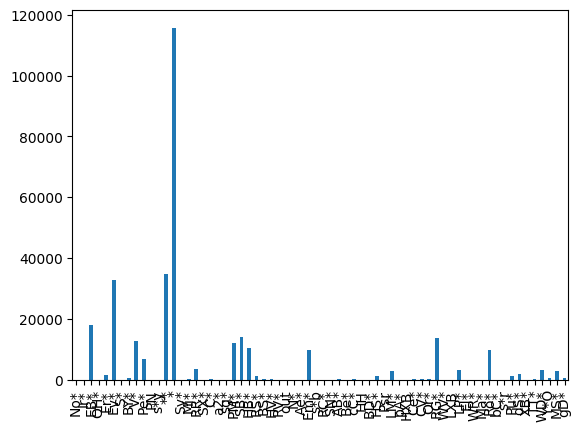

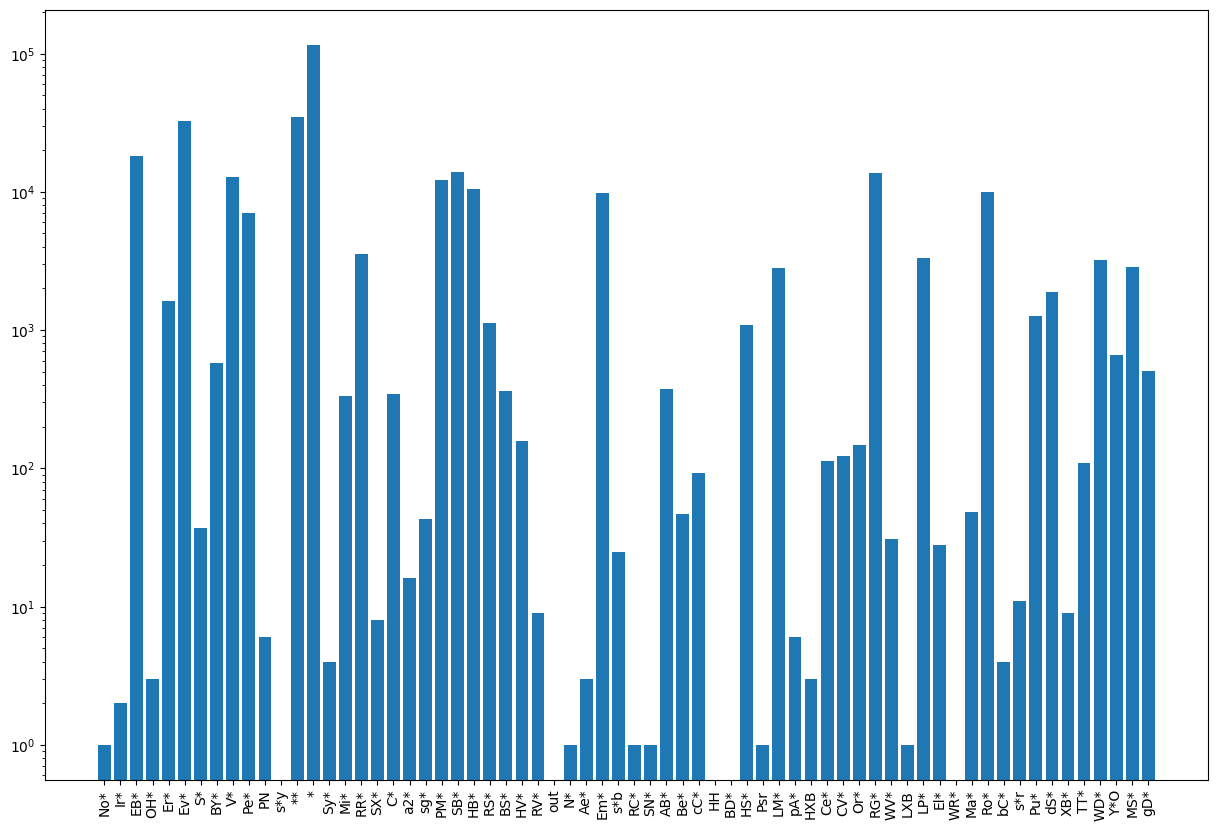

In [ ]:
X = pd.read_pickle("Pickles/train_data_transformed.pkl")
y = X[classes]
# Plot the distribution of the classes log scaled
y.sum().plot(kind='bar')

# MAke the plot larger and pretty
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))
plt.bar(y.columns, y.sum(), log=True)
plt.xticks(rotation=90)
plt.show()
